In [1]:
from __future__ import division
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from scipy.special import expit
import random
from random import randint
import nltk
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import time
%matplotlib inline

wordnet_lemmatizer = WordNetLemmatizer()

In [2]:
def plot_cost(iter_list,cost_list):
    plt.plot(iter_list,cost_list,'r.')
    plt.xlabel('Iterations ->')
    plt.ylabel('Cost')
    plt.show()

In [3]:
def sigmoid(x):
    return expit(x)
def tanh(x):
    return np.tanh(x)


In [4]:
def activation_func(z,func='sigmoid'):
    if(func=='sigmoid'):
        return sigmoid(z)
    else:
        #print("returning tanhz, ",tanh(z))
        return tanh(z)

In [5]:
def derivative_sigmoid(z):
    g_z=sigmoid(z)
    return g_z*(1-g_z)
def derivative_tanh(z):
    g_z=tanh(z)
    #print("returning tanh derivative val ",1-g_z**2)
    return (1-g_z*g_z)

In [6]:
def mse(Y,Y_pred):
    m=len(Y)
    J = np.sum((Y_pred - Y) ** 2)/(2 * m)
    return J

In [7]:
def predict(W,b,X,dim):
    y_pred=list()
    L=len(dim)-1
    N=len(X)
    threshold=0.2
    a=dict()
    z=dict()
    
    for i in range(1,L+1):
        a[i]=np.empty(shape=[1,dim[i]])
        z[i]=np.empty(shape=[1,dim[i]])
        
        
    for n in range(N):
    
        a[0]=X[n]
        
        # Forward Pass
        for l in range(1,L+1):
            z[l]=a[l-1].dot(W[l])+b[l]
            a[l]=activation_func(z[l],'tanh')
            
        if(a[L]>threshold):
            a[L]=1.0  # HAM
        else:
            a[L]=-1.0
            
        y_pred.append(a[L])
        
    y_pred=np.asarray(y_pred)
    return y_pred

In [8]:
def neural_network(learning_rate,dim,n_epoch,activation_func_name,train_X,train_Y,test_X,test_Y):
    L=len(dim)-1
    threshold=-0.1
    keep_prob=0.6
    W=dict()
    b=dict()
    a=dict()
    z=dict()
    delta=dict()
    lambda_reg=0.003
    
    tolerance=1e-5
    cost_old=999999
    
    N=len(train_X)
    a[0]=np.empty(shape=[1,dim[0]])
    
    for i in range(1,L+1):
        W[i]=np.random.randn(dim[i-1],dim[i])/np.sqrt(dim[i-1])
        b[i]=np.ones([1,dim[i]])

        
    cost_list=list()  
    iter_list=list()
    iter_count=0
    
    for epoch in range(n_epoch):
        print("Epoch",epoch)
        z=zip(train_X,train_Y)
        random.shuffle(z)
        train_X,train_Y=zip(*z)
        for n in range(N):
            #n=randint(0,N-1)    

            # Init a[0]=x_sel,y=corresponding_y
            a[0]=train_X[n]
            y=train_Y[n]

            # Forward Pass
            for l in range(1,L+1):
                z[l]=a[l-1].dot(W[l])+b[l]
                a[l]=activation_func(z[l],'tanh')
                mask=(np.random.rand(*a[l].shape) < keep_prob)/keep_prob
                if(l!=L):
                    a[l]*= mask

            #if(a[L]>threshold):
                #a[L]=1.0                # HAM
            #else:
                #a[L]=-1.0
                
            # Backward Pass
            if(epoch%10==0):
                print("n ",n," z[L] ",z[L],"a[L]is",a[L]," y is ",y)
            delta[L]=(2*(a[L]-y))*derivative_tanh(z[L])
            
            for l in range(L-1,0,-1):
                tmp=np.asarray(np.dot(W[l+1],delta[l+1]))
                delta[l]=np.asarray(np.asarray(derivative_tanh(z[l])).T*tmp)
                #print("l ",l,"delta[l]",delta[l])
            # Update weights
            for l in range(1,L+1):
                W[l]=(1-learning_rate*lambda_reg)*W[l]-learning_rate*(delta[l]*a[l-1]).T
               
        if(epoch%100==0):
            cost=mse(train_Y,predict(W,b,train_X,dim))
            #if((abs(cost-cost_old)<tolerance and iter_count>100) or cost_old==0 or epoch>=):
                #return cost_list,iter_list,W,b
            #cost_old=cost
            #cost_list.append(cost)
            #iter_list.append(iter_count)
            print("epoch",epoch," mse: ",cost)
            #iter_count+=1
    return cost_list,iter_list,W,b

    

In [9]:
def get_data():
    messages =pd.read_csv('Assignment_2_data.txt', sep='\t', quoting=csv.QUOTE_NONE,names=["label", "message"],encoding='utf8')
    word_index=dict()
    messages=shuffle(messages)
    vocab=0
    for index,rows in messages.iterrows():
        sentence=rows['message']
        tokens = nltk.word_tokenize(sentence)
        tokens=[w for w in tokens if not w in stopwords.words('english')]
        tokens=[token.lower() for token in tokens]
        wordset=[wordnet_lemmatizer.lemmatize(token) for token in tokens]
        wordset=list(set(wordset))
        for word in wordset:
            if not word in word_index:
                word_index[word]=vocab
                vocab+=1
    X=list()
    Y=list()
    for index,rows in messages.iterrows():
        sentence=rows['message']
        tokens = nltk.word_tokenize(sentence)
        tokens=[w for w in tokens if not w in stopwords.words('english')]
        tokens=[token.lower() for token in tokens]
        wordset=[wordnet_lemmatizer.lemmatize(token) for token in tokens]
        wordset=list(set(wordset))
        tmp_list=[0.0]*vocab
        #print(wordset)
        for word in wordset:
            tmp_list[word_index[word]]=1.0
        if (rows['label']=='ham'):
            Y.append(1.0)
        else:
            Y.append(-1.0)
        X.append(tmp_list)
    X=np.array(X)
    Y=np.array(Y)
    data=pd.DataFrame(X) 
    data['Y']=Y
    return X,Y,vocab,data,messages
            
        
    
    

In [10]:
def train_test_split(X,Y,ratio):
    train_length=(int)((1-ratio)*len(data))
    train_X=X[0:train_length+1]
    test_X=X[train_length+1:]
    train_Y=Y[0:train_length+1]
    test_Y=Y[train_length+1:]
    return train_X,train_Y,test_X,test_Y

In [11]:
t = int( time.time() * 1000.0 )
np.random.seed( ((t & 0xff000000) >> 24)+((t & 0x00ff0000)>>8) +((t & 0x0000ff00)<<8)+((t & 0x000000ff)<<24))
X,Y,V,data,messages=get_data()

In [12]:
data.head()

0    1    2    3    4    5    6    7    8    9 ...   9256  9257  9258  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0 ...    0.0   0.0   0.0   
1  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0 ...    0.0   0.0   0.0   
2  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    0.0   0.0   0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 ...    0.0   0.0   0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 ...    0.0   0.0   0.0   

   9259  9260  9261  9262  9263  9264    Y  
0   0.0   0.0   0.0   0.0   0.0   0.0  1.0  
1   0.0   0.0   0.0   0.0   0.0   0.0  1.0  
2   0.0   0.0   0.0   0.0   0.0   0.0 -1.0  
3   0.0   0.0   0.0   0.0   0.0   0.0  1.0  
4   0.0   0.0   0.0   0.0   0.0   0.0 -1.0  

[5 rows x 9266 columns]

In [13]:
messages.head()

label                                            message
1712   ham  I got your back! Do you have any dislikes in bed?
3259   ham  He fucking chickened out. He messaged me he wo...
3111  spam  Good Luck! Draw takes place 28th Feb 06. Good ...
2512   ham                                Er yep sure. Props?
4298  spam  thesmszone.com lets you send free anonymous an...

In [14]:
train_X,train_Y,test_X,test_Y=train_test_split(X,Y,0.2)

('Epoch', 0)
('n ', 0, ' z[L] ', array([[-0.4984584]]), 'a[L]is', array([[-0.46090391]]), ' y is ', 1.0)
('n ', 1, ' z[L] ', array([[ 5.85120247]]), 'a[L]is', array([[ 0.99998345]]), ' y is ', 1.0)
('n ', 2, ' z[L] ', array([[ 5.24142916]]), 'a[L]is', array([[ 0.99994398]]), ' y is ', 1.0)
('n ', 3, ' z[L] ', array([[ 5.56217703]]), 'a[L]is', array([[ 0.9999705]]), ' y is ', 1.0)
('n ', 4, ' z[L] ', array([[ 5.30824236]]), 'a[L]is', array([[ 0.99995098]]), ' y is ', 1.0)
('n ', 5, ' z[L] ', array([[ 5.765488]]), 'a[L]is', array([[ 0.99998036]]), ' y is ', 1.0)
('n ', 6, ' z[L] ', array([[ 3.78936691]]), 'a[L]is', array([[ 0.99897811]]), ' y is ', -1.0)
('n ', 7, ' z[L] ', array([[ 5.03682111]]), 'a[L]is', array([[ 0.99991565]]), ' y is ', 1.0)
('n ', 8, ' z[L] ', array([[ 4.05745062]]), 'a[L]is', array([[ 0.99940208]]), ' y is ', 1.0)
('n ', 9, ' z[L] ', array([[ 4.80428251]]), 'a[L]is', array([[ 0.99986571]]), ' y is ', 1.0)
('n ', 10, ' z[L] ', array([[ 6.11951678]]), 'a[L]is', array

('n ', 90, ' z[L] ', array([[ 4.33850837]]), 'a[L]is', array([[ 0.99965914]]), ' y is ', -1.0)
('n ', 91, ' z[L] ', array([[ 6.24473054]]), 'a[L]is', array([[ 0.99999247]]), ' y is ', 1.0)
('n ', 92, ' z[L] ', array([[ 4.98200343]]), 'a[L]is', array([[ 0.99990588]]), ' y is ', 1.0)
('n ', 93, ' z[L] ', array([[ 4.00814854]]), 'a[L]is', array([[ 0.99934014]]), ' y is ', 1.0)
('n ', 94, ' z[L] ', array([[ 6.54003253]]), 'a[L]is', array([[ 0.99999583]]), ' y is ', 1.0)
('n ', 95, ' z[L] ', array([[ 4.94903939]]), 'a[L]is', array([[ 0.99989946]]), ' y is ', 1.0)
('n ', 96, ' z[L] ', array([[ 5.18876319]]), 'a[L]is', array([[ 0.99993775]]), ' y is ', 1.0)
('n ', 97, ' z[L] ', array([[ 5.01998756]]), 'a[L]is', array([[ 0.99991276]]), ' y is ', 1.0)
('n ', 98, ' z[L] ', array([[ 3.60695565]]), 'a[L]is', array([[ 0.99852854]]), ' y is ', 1.0)
('n ', 99, ' z[L] ', array([[ 3.93269045]]), 'a[L]is', array([[ 0.99923269]]), ' y is ', 1.0)
('n ', 100, ' z[L] ', array([[ 3.93054314]]), 'a[L]is', arr

('n ', 198, ' z[L] ', array([[ 3.46804977]]), 'a[L]is', array([[ 0.99805778]]), ' y is ', 1.0)
('n ', 199, ' z[L] ', array([[ 3.85048137]]), 'a[L]is', array([[ 0.99909563]]), ' y is ', 1.0)
('n ', 200, ' z[L] ', array([[ 5.60569608]]), 'a[L]is', array([[ 0.99997296]]), ' y is ', -1.0)
('n ', 201, ' z[L] ', array([[ 2.47317418]]), 'a[L]is', array([[ 0.98588173]]), ' y is ', 1.0)
('n ', 202, ' z[L] ', array([[ 4.56888122]]), 'a[L]is', array([[ 0.99978497]]), ' y is ', 1.0)
('n ', 203, ' z[L] ', array([[ 5.30421121]]), 'a[L]is', array([[ 0.99995059]]), ' y is ', -1.0)
('n ', 204, ' z[L] ', array([[ 4.32850881]]), 'a[L]is', array([[ 0.99965226]]), ' y is ', 1.0)
('n ', 205, ' z[L] ', array([[ 4.62216707]]), 'a[L]is', array([[ 0.9998067]]), ' y is ', 1.0)
('n ', 206, ' z[L] ', array([[ 4.92210119]]), 'a[L]is', array([[ 0.9998939]]), ' y is ', 1.0)
('n ', 207, ' z[L] ', array([[ 3.31496039]]), 'a[L]is', array([[ 0.99736295]]), ' y is ', 1.0)
('n ', 208, ' z[L] ', array([[ 5.31924748]]), 'a[L

('n ', 290, ' z[L] ', array([[ 4.33916532]]), 'a[L]is', array([[ 0.99965959]]), ' y is ', 1.0)
('n ', 291, ' z[L] ', array([[ 4.0301536]]), 'a[L]is', array([[ 0.99936854]]), ' y is ', 1.0)
('n ', 292, ' z[L] ', array([[ 5.15556054]]), 'a[L]is', array([[ 0.99993348]]), ' y is ', 1.0)
('n ', 293, ' z[L] ', array([[ 4.32552719]]), 'a[L]is', array([[ 0.99965018]]), ' y is ', 1.0)
('n ', 294, ' z[L] ', array([[ 4.96985992]]), 'a[L]is', array([[ 0.99990356]]), ' y is ', 1.0)
('n ', 295, ' z[L] ', array([[ 2.28941335]]), 'a[L]is', array([[ 0.97967481]]), ' y is ', 1.0)
('n ', 296, ' z[L] ', array([[ 4.34812767]]), 'a[L]is', array([[ 0.99966563]]), ' y is ', 1.0)
('n ', 297, ' z[L] ', array([[ 4.56895323]]), 'a[L]is', array([[ 0.999785]]), ' y is ', 1.0)
('n ', 298, ' z[L] ', array([[ 4.13240393]]), 'a[L]is', array([[ 0.9994853]]), ' y is ', 1.0)
('n ', 299, ' z[L] ', array([[ 4.40927939]]), 'a[L]is', array([[ 0.99970412]]), ' y is ', 1.0)
('n ', 300, ' z[L] ', array([[ 4.10794143]]), 'a[L]is'

('n ', 380, ' z[L] ', array([[ 2.81784546]]), 'a[L]is', array([[ 0.99288895]]), ' y is ', 1.0)
('n ', 381, ' z[L] ', array([[ 4.78858055]]), 'a[L]is', array([[ 0.99986142]]), ' y is ', 1.0)
('n ', 382, ' z[L] ', array([[ 4.57578471]]), 'a[L]is', array([[ 0.99978792]]), ' y is ', 1.0)
('n ', 383, ' z[L] ', array([[ 3.46524579]]), 'a[L]is', array([[ 0.99804687]]), ' y is ', 1.0)
('n ', 384, ' z[L] ', array([[ 3.55911048]]), 'a[L]is', array([[ 0.9983809]]), ' y is ', 1.0)
('n ', 385, ' z[L] ', array([[ 5.90122201]]), 'a[L]is', array([[ 0.99998503]]), ' y is ', 1.0)
('n ', 386, ' z[L] ', array([[ 3.27118633]]), 'a[L]is', array([[ 0.99712202]]), ' y is ', 1.0)
('n ', 387, ' z[L] ', array([[ 4.59701892]]), 'a[L]is', array([[ 0.99979673]]), ' y is ', 1.0)
('n ', 388, ' z[L] ', array([[ 4.27177945]]), 'a[L]is', array([[ 0.99961048]]), ' y is ', 1.0)
('n ', 389, ' z[L] ', array([[ 2.99553515]]), 'a[L]is', array([[ 0.99501051]]), ' y is ', 1.0)
('n ', 390, ' z[L] ', array([[ 3.78852338]]), 'a[L]

('n ', 472, ' z[L] ', array([[ 5.1630971]]), 'a[L]is', array([[ 0.99993448]]), ' y is ', 1.0)
('n ', 473, ' z[L] ', array([[ 5.21525973]]), 'a[L]is', array([[ 0.99994097]]), ' y is ', 1.0)
('n ', 474, ' z[L] ', array([[ 4.5585731]]), 'a[L]is', array([[ 0.99978049]]), ' y is ', 1.0)
('n ', 475, ' z[L] ', array([[ 4.464936]]), 'a[L]is', array([[ 0.99973529]]), ' y is ', 1.0)
('n ', 476, ' z[L] ', array([[ 3.35557456]]), 'a[L]is', array([[ 0.99756843]]), ' y is ', 1.0)
('n ', 477, ' z[L] ', array([[ 3.44294011]]), 'a[L]is', array([[ 0.99795786]]), ' y is ', 1.0)
('n ', 478, ' z[L] ', array([[ 4.57040175]]), 'a[L]is', array([[ 0.99978562]]), ' y is ', 1.0)
('n ', 479, ' z[L] ', array([[ 3.74739636]]), 'a[L]is', array([[ 0.99888867]]), ' y is ', 1.0)
('n ', 480, ' z[L] ', array([[ 5.16041172]]), 'a[L]is', array([[ 0.99993412]]), ' y is ', 1.0)
('n ', 481, ' z[L] ', array([[ 3.08639816]]), 'a[L]is', array([[ 0.99583789]]), ' y is ', 1.0)
('n ', 482, ' z[L] ', array([[ 3.95020551]]), 'a[L]is'

('n ', 577, ' z[L] ', array([[ 3.58657157]]), 'a[L]is', array([[ 0.99846736]]), ' y is ', 1.0)
('n ', 578, ' z[L] ', array([[ 3.64497191]]), 'a[L]is', array([[ 0.9986362]]), ' y is ', 1.0)
('n ', 579, ' z[L] ', array([[ 3.77837537]]), 'a[L]is', array([[ 0.9989554]]), ' y is ', -1.0)
('n ', 580, ' z[L] ', array([[ 3.36646616]]), 'a[L]is', array([[ 0.99762076]]), ' y is ', 1.0)
('n ', 581, ' z[L] ', array([[ 2.46670378]]), 'a[L]is', array([[ 0.98569915]]), ' y is ', 1.0)
('n ', 582, ' z[L] ', array([[ 3.82290653]]), 'a[L]is', array([[ 0.99904437]]), ' y is ', 1.0)
('n ', 583, ' z[L] ', array([[ 3.04415622]]), 'a[L]is', array([[ 0.99547181]]), ' y is ', 1.0)
('n ', 584, ' z[L] ', array([[ 3.62056152]]), 'a[L]is', array([[ 0.99856801]]), ' y is ', 1.0)
('n ', 585, ' z[L] ', array([[ 2.9723472]]), 'a[L]is', array([[ 0.99477428]]), ' y is ', -1.0)
('n ', 586, ' z[L] ', array([[ 2.88139361]]), 'a[L]is', array([[ 0.993735]]), ' y is ', 1.0)
('n ', 587, ' z[L] ', array([[ 3.28802764]]), 'a[L]is

('n ', 668, ' z[L] ', array([[ 3.34662996]]), 'a[L]is', array([[ 0.99752459]]), ' y is ', 1.0)
('n ', 669, ' z[L] ', array([[ 3.80419805]]), 'a[L]is', array([[ 0.99900796]]), ' y is ', 1.0)
('n ', 670, ' z[L] ', array([[ 2.5807423]]), 'a[L]is', array([[ 0.988599]]), ' y is ', 1.0)
('n ', 671, ' z[L] ', array([[ 2.27288852]]), 'a[L]is', array([[ 0.97899901]]), ' y is ', 1.0)
('n ', 672, ' z[L] ', array([[ 2.66795443]]), 'a[L]is', array([[ 0.99041509]]), ' y is ', 1.0)
('n ', 673, ' z[L] ', array([[ 2.13594312]]), 'a[L]is', array([[ 0.97247328]]), ' y is ', 1.0)
('n ', 674, ' z[L] ', array([[ 3.48274723]]), 'a[L]is', array([[ 0.99811399]]), ' y is ', 1.0)
('n ', 675, ' z[L] ', array([[ 3.4237841]]), 'a[L]is', array([[ 0.99787818]]), ' y is ', 1.0)
('n ', 676, ' z[L] ', array([[ 3.82224474]]), 'a[L]is', array([[ 0.99904311]]), ' y is ', 1.0)
('n ', 677, ' z[L] ', array([[ 4.66051847]]), 'a[L]is', array([[ 0.99982097]]), ' y is ', 1.0)
('n ', 678, ' z[L] ', array([[ 4.40015378]]), 'a[L]is'

('n ', 760, ' z[L] ', array([[ 2.00164572]]), 'a[L]is', array([[ 0.96414367]]), ' y is ', 1.0)
('n ', 761, ' z[L] ', array([[ 1.57303853]]), 'a[L]is', array([[ 0.91750774]]), ' y is ', 1.0)
('n ', 762, ' z[L] ', array([[ 2.49829646]]), 'a[L]is', array([[ 0.98656892]]), ' y is ', 1.0)
('n ', 763, ' z[L] ', array([[ 2.43086576]]), 'a[L]is', array([[ 0.98464465]]), ' y is ', -1.0)
('n ', 764, ' z[L] ', array([[ 1.88676882]]), 'a[L]is', array([[ 0.95509029]]), ' y is ', 1.0)
('n ', 765, ' z[L] ', array([[ 0.69179046]]), 'a[L]is', array([[ 0.59913099]]), ' y is ', -1.0)
('n ', 766, ' z[L] ', array([[ 1.25953871]]), 'a[L]is', array([[ 0.85093689]]), ' y is ', -1.0)
('n ', 767, ' z[L] ', array([[-1.26335359]]), 'a[L]is', array([[-0.85198603]]), ' y is ', 1.0)
('n ', 768, ' z[L] ', array([[-0.46957254]]), 'a[L]is', array([[-0.43785387]]), ' y is ', 1.0)
('n ', 769, ' z[L] ', array([[ 2.810094]]), 'a[L]is', array([[ 0.99277825]]), ' y is ', -1.0)
('n ', 770, ' z[L] ', array([[ 3.52620778]]), 'a

('n ', 851, ' z[L] ', array([[ 4.37045721]]), 'a[L]is', array([[ 0.99968024]]), ' y is ', 1.0)
('n ', 852, ' z[L] ', array([[ 5.29176983]]), 'a[L]is', array([[ 0.99994934]]), ' y is ', 1.0)
('n ', 853, ' z[L] ', array([[ 5.15952361]]), 'a[L]is', array([[ 0.99993401]]), ' y is ', -1.0)
('n ', 854, ' z[L] ', array([[ 4.84166816]]), 'a[L]is', array([[ 0.99987538]]), ' y is ', 1.0)
('n ', 855, ' z[L] ', array([[ 1.79890872]]), 'a[L]is', array([[ 0.94669288]]), ' y is ', 1.0)
('n ', 856, ' z[L] ', array([[ 3.93271255]]), 'a[L]is', array([[ 0.99923272]]), ' y is ', 1.0)
('n ', 857, ' z[L] ', array([[ 3.47204881]]), 'a[L]is', array([[ 0.99807324]]), ' y is ', 1.0)
('n ', 858, ' z[L] ', array([[ 5.72084832]]), 'a[L]is', array([[ 0.99997852]]), ' y is ', 1.0)
('n ', 859, ' z[L] ', array([[ 4.47794577]]), 'a[L]is', array([[ 0.99974208]]), ' y is ', 1.0)
('n ', 860, ' z[L] ', array([[ 4.56071526]]), 'a[L]is', array([[ 0.99978143]]), ' y is ', 1.0)
('n ', 861, ' z[L] ', array([[ 3.14120433]]), 'a[

('n ', 942, ' z[L] ', array([[ 1.9973442]]), 'a[L]is', array([[ 0.96383946]]), ' y is ', -1.0)
('n ', 943, ' z[L] ', array([[ 4.60349007]]), 'a[L]is', array([[ 0.99979935]]), ' y is ', 1.0)
('n ', 944, ' z[L] ', array([[ 2.82583804]]), 'a[L]is', array([[ 0.99300132]]), ' y is ', 1.0)
('n ', 945, ' z[L] ', array([[ 2.85624186]]), 'a[L]is', array([[ 0.99341286]]), ' y is ', 1.0)
('n ', 946, ' z[L] ', array([[ 5.13641389]]), 'a[L]is', array([[ 0.99993088]]), ' y is ', -1.0)
('n ', 947, ' z[L] ', array([[ 3.1443783]]), 'a[L]is', array([[ 0.99629275]]), ' y is ', 1.0)
('n ', 948, ' z[L] ', array([[ 4.40149226]]), 'a[L]is', array([[ 0.99969948]]), ' y is ', 1.0)
('n ', 949, ' z[L] ', array([[ 3.83098673]]), 'a[L]is', array([[ 0.99905969]]), ' y is ', 1.0)
('n ', 950, ' z[L] ', array([[ 4.34885857]]), 'a[L]is', array([[ 0.99966612]]), ' y is ', 1.0)
('n ', 951, ' z[L] ', array([[ 5.18500904]]), 'a[L]is', array([[ 0.99993728]]), ' y is ', 1.0)
('n ', 952, ' z[L] ', array([[ 3.10081947]]), 'a[L

('n ', 1031, ' z[L] ', array([[ 3.02501416]]), 'a[L]is', array([[ 0.9952955]]), ' y is ', 1.0)
('n ', 1032, ' z[L] ', array([[ 4.00938752]]), 'a[L]is', array([[ 0.99934177]]), ' y is ', 1.0)
('n ', 1033, ' z[L] ', array([[ 1.98782479]]), 'a[L]is', array([[ 0.96315722]]), ' y is ', -1.0)
('n ', 1034, ' z[L] ', array([[ 2.98155506]]), 'a[L]is', array([[ 0.99486939]]), ' y is ', -1.0)
('n ', 1035, ' z[L] ', array([[ 2.4795692]]), 'a[L]is', array([[ 0.9860599]]), ' y is ', 1.0)
('n ', 1036, ' z[L] ', array([[ 3.34019763]]), 'a[L]is', array([[ 0.99749258]]), ' y is ', -1.0)
('n ', 1037, ' z[L] ', array([[ 2.59736274]]), 'a[L]is', array([[ 0.98896969]]), ' y is ', -1.0)
('n ', 1038, ' z[L] ', array([[ 2.44155122]]), 'a[L]is', array([[ 0.98496689]]), ' y is ', 1.0)
('n ', 1039, ' z[L] ', array([[ 3.76090065]]), 'a[L]is', array([[ 0.99891827]]), ' y is ', 1.0)
('n ', 1040, ' z[L] ', array([[ 3.32922189]]), 'a[L]is', array([[ 0.99743701]]), ' y is ', 1.0)
('n ', 1041, ' z[L] ', array([[ 2.46126

('n ', 1121, ' z[L] ', array([[ 3.64449812]]), 'a[L]is', array([[ 0.99863491]]), ' y is ', 1.0)
('n ', 1122, ' z[L] ', array([[ 4.60859786]]), 'a[L]is', array([[ 0.99980139]]), ' y is ', -1.0)
('n ', 1123, ' z[L] ', array([[ 3.80145312]]), 'a[L]is', array([[ 0.9990025]]), ' y is ', 1.0)
('n ', 1124, ' z[L] ', array([[ 4.58124007]]), 'a[L]is', array([[ 0.99979022]]), ' y is ', 1.0)
('n ', 1125, ' z[L] ', array([[ 4.30180773]]), 'a[L]is', array([[ 0.99963318]]), ' y is ', 1.0)
('n ', 1126, ' z[L] ', array([[ 3.03123852]]), 'a[L]is', array([[ 0.99535357]]), ' y is ', 1.0)
('n ', 1127, ' z[L] ', array([[ 2.95782325]]), 'a[L]is', array([[ 0.99462068]]), ' y is ', 1.0)
('n ', 1128, ' z[L] ', array([[ 5.37221764]]), 'a[L]is', array([[ 0.99995687]]), ' y is ', 1.0)
('n ', 1129, ' z[L] ', array([[ 4.05549961]]), 'a[L]is', array([[ 0.99939974]]), ' y is ', 1.0)
('n ', 1130, ' z[L] ', array([[ 4.00280116]]), 'a[L]is', array([[ 0.99933305]]), ' y is ', 1.0)
('n ', 1131, ' z[L] ', array([[ 4.214284

('n ', 1212, ' z[L] ', array([[ 2.9257388]]), 'a[L]is', array([[ 0.9942652]]), ' y is ', 1.0)
('n ', 1213, ' z[L] ', array([[ 4.04542331]]), 'a[L]is', array([[ 0.99938753]]), ' y is ', 1.0)
('n ', 1214, ' z[L] ', array([[ 4.98765246]]), 'a[L]is', array([[ 0.99990693]]), ' y is ', 1.0)
('n ', 1215, ' z[L] ', array([[ 4.39794226]]), 'a[L]is', array([[ 0.99969734]]), ' y is ', -1.0)
('n ', 1216, ' z[L] ', array([[ 5.5897511]]), 'a[L]is', array([[ 0.99997209]]), ' y is ', 1.0)
('n ', 1217, ' z[L] ', array([[ 4.39800487]]), 'a[L]is', array([[ 0.99969737]]), ' y is ', 1.0)
('n ', 1218, ' z[L] ', array([[ 3.73097355]]), 'a[L]is', array([[ 0.99885159]]), ' y is ', 1.0)
('n ', 1219, ' z[L] ', array([[ 4.35733855]]), 'a[L]is', array([[ 0.99967174]]), ' y is ', 1.0)
('n ', 1220, ' z[L] ', array([[ 4.93198256]]), 'a[L]is', array([[ 0.99989597]]), ' y is ', 1.0)
('n ', 1221, ' z[L] ', array([[ 4.4668368]]), 'a[L]is', array([[ 0.99973629]]), ' y is ', 1.0)
('n ', 1222, ' z[L] ', array([[ 3.99213974]

('n ', 1301, ' z[L] ', array([[ 4.48417291]]), 'a[L]is', array([[ 0.99974527]]), ' y is ', 1.0)
('n ', 1302, ' z[L] ', array([[ 3.10854643]]), 'a[L]is', array([[ 0.99601787]]), ' y is ', 1.0)
('n ', 1303, ' z[L] ', array([[ 4.20847874]]), 'a[L]is', array([[ 0.99955793]]), ' y is ', 1.0)
('n ', 1304, ' z[L] ', array([[ 4.58028828]]), 'a[L]is', array([[ 0.99978982]]), ' y is ', 1.0)
('n ', 1305, ' z[L] ', array([[ 4.71787021]]), 'a[L]is', array([[ 0.99984037]]), ' y is ', 1.0)
('n ', 1306, ' z[L] ', array([[ 3.00046272]]), 'a[L]is', array([[ 0.99505932]]), ' y is ', 1.0)
('n ', 1307, ' z[L] ', array([[ 3.7929199]]), 'a[L]is', array([[ 0.99898534]]), ' y is ', 1.0)
('n ', 1308, ' z[L] ', array([[ 3.78046492]]), 'a[L]is', array([[ 0.99895976]]), ' y is ', -1.0)
('n ', 1309, ' z[L] ', array([[ 4.06853396]]), 'a[L]is', array([[ 0.99941518]]), ' y is ', 1.0)
('n ', 1310, ' z[L] ', array([[ 3.70107468]]), 'a[L]is', array([[ 0.99878086]]), ' y is ', 1.0)
('n ', 1311, ' z[L] ', array([[ 3.833296

('n ', 1391, ' z[L] ', array([[ 2.44558855]]), 'a[L]is', array([[ 0.98508689]]), ' y is ', 1.0)
('n ', 1392, ' z[L] ', array([[ 3.66913373]]), 'a[L]is', array([[ 0.99870049]]), ' y is ', 1.0)
('n ', 1393, ' z[L] ', array([[ 4.05035605]]), 'a[L]is', array([[ 0.99939354]]), ' y is ', -1.0)
('n ', 1394, ' z[L] ', array([[ 3.80601062]]), 'a[L]is', array([[ 0.99901155]]), ' y is ', 1.0)
('n ', 1395, ' z[L] ', array([[ 2.89948021]]), 'a[L]is', array([[ 0.99395691]]), ' y is ', 1.0)
('n ', 1396, ' z[L] ', array([[ 1.98185291]]), 'a[L]is', array([[ 0.96272279]]), ' y is ', 1.0)
('n ', 1397, ' z[L] ', array([[ 3.44627037]]), 'a[L]is', array([[ 0.9979714]]), ' y is ', 1.0)
('n ', 1398, ' z[L] ', array([[ 1.67268091]]), 'a[L]is', array([[ 0.93190525]]), ' y is ', 1.0)
('n ', 1399, ' z[L] ', array([[ 2.53766481]]), 'a[L]is', array([[ 0.98757956]]), ' y is ', -1.0)
('n ', 1400, ' z[L] ', array([[ 2.7619842]]), 'a[L]is', array([[ 0.99205175]]), ' y is ', 1.0)
('n ', 1401, ' z[L] ', array([[ 4.510992

('n ', 1480, ' z[L] ', array([[ 4.96080787]]), 'a[L]is', array([[ 0.9999018]]), ' y is ', 1.0)
('n ', 1481, ' z[L] ', array([[ 4.76818114]]), 'a[L]is', array([[ 0.99985565]]), ' y is ', 1.0)
('n ', 1482, ' z[L] ', array([[ 3.94650604]]), 'a[L]is', array([[ 0.99925359]]), ' y is ', 1.0)
('n ', 1483, ' z[L] ', array([[ 5.84102369]]), 'a[L]is', array([[ 0.99998311]]), ' y is ', 1.0)
('n ', 1484, ' z[L] ', array([[ 4.33976603]]), 'a[L]is', array([[ 0.99966]]), ' y is ', 1.0)
('n ', 1485, ' z[L] ', array([[ 5.82543077]]), 'a[L]is', array([[ 0.99998258]]), ' y is ', 1.0)
('n ', 1486, ' z[L] ', array([[ 4.78193345]]), 'a[L]is', array([[ 0.99985957]]), ' y is ', 1.0)
('n ', 1487, ' z[L] ', array([[ 6.29616453]]), 'a[L]is', array([[ 0.9999932]]), ' y is ', 1.0)
('n ', 1488, ' z[L] ', array([[ 5.92764008]]), 'a[L]is', array([[ 0.9999858]]), ' y is ', 1.0)
('n ', 1489, ' z[L] ', array([[ 4.0896738]]), 'a[L]is', array([[ 0.99943939]]), ' y is ', 1.0)
('n ', 1490, ' z[L] ', array([[ 4.69742679]]), 

('n ', 1569, ' z[L] ', array([[ 4.97576274]]), 'a[L]is', array([[ 0.99990469]]), ' y is ', 1.0)
('n ', 1570, ' z[L] ', array([[ 3.78274843]]), 'a[L]is', array([[ 0.9989645]]), ' y is ', 1.0)
('n ', 1571, ' z[L] ', array([[ 5.47631937]]), 'a[L]is', array([[ 0.99996498]]), ' y is ', 1.0)
('n ', 1572, ' z[L] ', array([[ 5.42786178]]), 'a[L]is', array([[ 0.99996141]]), ' y is ', 1.0)
('n ', 1573, ' z[L] ', array([[ 5.47487851]]), 'a[L]is', array([[ 0.99996488]]), ' y is ', 1.0)
('n ', 1574, ' z[L] ', array([[ 4.62652521]]), 'a[L]is', array([[ 0.99980838]]), ' y is ', 1.0)
('n ', 1575, ' z[L] ', array([[ 4.30232888]]), 'a[L]is', array([[ 0.99963357]]), ' y is ', 1.0)
('n ', 1576, ' z[L] ', array([[ 4.54399959]]), 'a[L]is', array([[ 0.999774]]), ' y is ', -1.0)
('n ', 1577, ' z[L] ', array([[ 5.67175214]]), 'a[L]is', array([[ 0.99997631]]), ' y is ', -1.0)
('n ', 1578, ' z[L] ', array([[ 4.85991138]]), 'a[L]is', array([[ 0.99987985]]), ' y is ', 1.0)
('n ', 1579, ' z[L] ', array([[ 4.7255754

('n ', 1658, ' z[L] ', array([[ 5.8313002]]), 'a[L]is', array([[ 0.99998278]]), ' y is ', 1.0)
('n ', 1659, ' z[L] ', array([[ 4.92188932]]), 'a[L]is', array([[ 0.99989385]]), ' y is ', -1.0)
('n ', 1660, ' z[L] ', array([[ 4.45743108]]), 'a[L]is', array([[ 0.99973128]]), ' y is ', 1.0)
('n ', 1661, ' z[L] ', array([[ 4.36892134]]), 'a[L]is', array([[ 0.99967925]]), ' y is ', 1.0)
('n ', 1662, ' z[L] ', array([[ 2.41664832]]), 'a[L]is', array([[ 0.98420526]]), ' y is ', -1.0)
('n ', 1663, ' z[L] ', array([[ 3.9239587]]), 'a[L]is', array([[ 0.99921918]]), ' y is ', 1.0)
('n ', 1664, ' z[L] ', array([[ 6.01522352]]), 'a[L]is', array([[ 0.99998808]]), ' y is ', 1.0)
('n ', 1665, ' z[L] ', array([[ 5.59636177]]), 'a[L]is', array([[ 0.99997245]]), ' y is ', 1.0)
('n ', 1666, ' z[L] ', array([[ 4.89688854]]), 'a[L]is', array([[ 0.99988841]]), ' y is ', 1.0)
('n ', 1667, ' z[L] ', array([[ 4.03957274]]), 'a[L]is', array([[ 0.99938032]]), ' y is ', 1.0)
('n ', 1668, ' z[L] ', array([[ 2.531374

('n ', 1748, ' z[L] ', array([[ 3.30716041]]), 'a[L]is', array([[ 0.99732154]]), ' y is ', 1.0)
('n ', 1749, ' z[L] ', array([[ 4.35391044]]), 'a[L]is', array([[ 0.99966948]]), ' y is ', 1.0)
('n ', 1750, ' z[L] ', array([[ 5.22000716]]), 'a[L]is', array([[ 0.99994152]]), ' y is ', 1.0)
('n ', 1751, ' z[L] ', array([[ 5.52089347]]), 'a[L]is', array([[ 0.99996796]]), ' y is ', 1.0)
('n ', 1752, ' z[L] ', array([[ 5.17413411]]), 'a[L]is', array([[ 0.99993591]]), ' y is ', 1.0)
('n ', 1753, ' z[L] ', array([[ 4.96439779]]), 'a[L]is', array([[ 0.9999025]]), ' y is ', 1.0)
('n ', 1754, ' z[L] ', array([[ 4.37080907]]), 'a[L]is', array([[ 0.99968046]]), ' y is ', 1.0)
('n ', 1755, ' z[L] ', array([[ 4.79946196]]), 'a[L]is', array([[ 0.99986441]]), ' y is ', 1.0)
('n ', 1756, ' z[L] ', array([[ 4.81101546]]), 'a[L]is', array([[ 0.9998675]]), ' y is ', 1.0)
('n ', 1757, ' z[L] ', array([[ 4.86597526]]), 'a[L]is', array([[ 0.99988129]]), ' y is ', 1.0)
('n ', 1758, ' z[L] ', array([[ 4.76197921

('n ', 1839, ' z[L] ', array([[ 4.86855532]]), 'a[L]is', array([[ 0.99988191]]), ' y is ', 1.0)
('n ', 1840, ' z[L] ', array([[ 3.56559909]]), 'a[L]is', array([[ 0.99840176]]), ' y is ', -1.0)
('n ', 1841, ' z[L] ', array([[ 4.36224203]]), 'a[L]is', array([[ 0.99967494]]), ' y is ', 1.0)
('n ', 1842, ' z[L] ', array([[ 3.87795589]]), 'a[L]is', array([[ 0.99914396]]), ' y is ', 1.0)
('n ', 1843, ' z[L] ', array([[ 4.73855971]]), 'a[L]is', array([[ 0.99984684]]), ' y is ', 1.0)
('n ', 1844, ' z[L] ', array([[ 4.99156253]]), 'a[L]is', array([[ 0.99990766]]), ' y is ', -1.0)
('n ', 1845, ' z[L] ', array([[ 4.05883591]]), 'a[L]is', array([[ 0.99940373]]), ' y is ', 1.0)
('n ', 1846, ' z[L] ', array([[ 4.30574522]]), 'a[L]is', array([[ 0.99963606]]), ' y is ', 1.0)
('n ', 1847, ' z[L] ', array([[ 5.63525431]]), 'a[L]is', array([[ 0.99997451]]), ' y is ', -1.0)
('n ', 1848, ' z[L] ', array([[ 5.5606238]]), 'a[L]is', array([[ 0.99997041]]), ' y is ', -1.0)
('n ', 1849, ' z[L] ', array([[ 3.633

('n ', 1932, ' z[L] ', array([[ 3.4962613]]), 'a[L]is', array([[ 0.99816423]]), ' y is ', 1.0)
('n ', 1933, ' z[L] ', array([[ 4.0752674]]), 'a[L]is', array([[ 0.999423]]), ' y is ', 1.0)
('n ', 1934, ' z[L] ', array([[ 4.12732362]]), 'a[L]is', array([[ 0.99948004]]), ' y is ', 1.0)
('n ', 1935, ' z[L] ', array([[ 4.52229779]]), 'a[L]is', array([[ 0.99976397]]), ' y is ', 1.0)
('n ', 1936, ' z[L] ', array([[ 4.77345715]]), 'a[L]is', array([[ 0.99985717]]), ' y is ', 1.0)
('n ', 1937, ' z[L] ', array([[ 5.40974047]]), 'a[L]is', array([[ 0.99995999]]), ' y is ', 1.0)
('n ', 1938, ' z[L] ', array([[ 3.10567471]]), 'a[L]is', array([[ 0.99599498]]), ' y is ', 1.0)
('n ', 1939, ' z[L] ', array([[ 3.46729948]]), 'a[L]is', array([[ 0.99805487]]), ' y is ', 1.0)
('n ', 1940, ' z[L] ', array([[ 3.76030554]]), 'a[L]is', array([[ 0.99891698]]), ' y is ', 1.0)
('n ', 1941, ' z[L] ', array([[ 4.92903603]]), 'a[L]is', array([[ 0.99989536]]), ' y is ', 1.0)
('n ', 1942, ' z[L] ', array([[ 3.19095258]]

('n ', 2024, ' z[L] ', array([[ 2.68227688]]), 'a[L]is', array([[ 0.9906845]]), ' y is ', 1.0)
('n ', 2025, ' z[L] ', array([[ 2.69267764]]), 'a[L]is', array([[ 0.9908754]]), ' y is ', 1.0)
('n ', 2026, ' z[L] ', array([[ 2.65609704]]), 'a[L]is', array([[ 0.9901862]]), ' y is ', 1.0)
('n ', 2027, ' z[L] ', array([[ 2.68120167]]), 'a[L]is', array([[ 0.99066454]]), ' y is ', 1.0)
('n ', 2028, ' z[L] ', array([[ 2.05682822]]), 'a[L]is', array([[ 0.96783013]]), ' y is ', 1.0)
('n ', 2029, ' z[L] ', array([[ 2.79180076]]), 'a[L]is', array([[ 0.99251015]]), ' y is ', -1.0)
('n ', 2030, ' z[L] ', array([[ 3.23801248]]), 'a[L]is', array([[ 0.9969249]]), ' y is ', 1.0)
('n ', 2031, ' z[L] ', array([[ 1.93838935]]), 'a[L]is', array([[ 0.95940609]]), ' y is ', 1.0)
('n ', 2032, ' z[L] ', array([[ 3.10739973]]), 'a[L]is', array([[ 0.99600875]]), ' y is ', 1.0)
('n ', 2033, ' z[L] ', array([[ 2.21146672]]), 'a[L]is', array([[ 0.97628657]]), ' y is ', 1.0)
('n ', 2034, ' z[L] ', array([[ 1.88044865]

('n ', 2115, ' z[L] ', array([[ 3.42869548]]), 'a[L]is', array([[ 0.9978989]]), ' y is ', 1.0)
('n ', 2116, ' z[L] ', array([[ 3.13009237]]), 'a[L]is', array([[ 0.9961855]]), ' y is ', 1.0)
('n ', 2117, ' z[L] ', array([[ 2.56210297]]), 'a[L]is', array([[ 0.98816853]]), ' y is ', -1.0)
('n ', 2118, ' z[L] ', array([[ 3.11322638]]), 'a[L]is', array([[ 0.9960549]]), ' y is ', 1.0)
('n ', 2119, ' z[L] ', array([[ 3.00744863]]), 'a[L]is', array([[ 0.9951277]]), ' y is ', 1.0)
('n ', 2120, ' z[L] ', array([[ 2.58264052]]), 'a[L]is', array([[ 0.98864196]]), ' y is ', -1.0)
('n ', 2121, ' z[L] ', array([[ 3.59395333]]), 'a[L]is', array([[ 0.9984898]]), ' y is ', 1.0)
('n ', 2122, ' z[L] ', array([[ 2.90714296]]), 'a[L]is', array([[ 0.99404854]]), ' y is ', 1.0)
('n ', 2123, ' z[L] ', array([[ 3.0921138]]), 'a[L]is', array([[ 0.9958851]]), ' y is ', 1.0)
('n ', 2124, ' z[L] ', array([[ 3.0293675]]), 'a[L]is', array([[ 0.99533619]]), ' y is ', 1.0)
('n ', 2125, ' z[L] ', array([[ 3.73499346]]),

('n ', 2203, ' z[L] ', array([[ 1.95905819]]), 'a[L]is', array([[ 0.9610179]]), ' y is ', 1.0)
('n ', 2204, ' z[L] ', array([[ 3.11762146]]), 'a[L]is', array([[ 0.99608936]]), ' y is ', 1.0)
('n ', 2205, ' z[L] ', array([[ 2.79709045]]), 'a[L]is', array([[ 0.99258868]]), ' y is ', 1.0)
('n ', 2206, ' z[L] ', array([[ 2.39939055]]), 'a[L]is', array([[ 0.98365511]]), ' y is ', 1.0)
('n ', 2207, ' z[L] ', array([[ 3.43848406]]), 'a[L]is', array([[ 0.99793959]]), ' y is ', 1.0)
('n ', 2208, ' z[L] ', array([[ 2.71168417]]), 'a[L]is', array([[ 0.99121425]]), ' y is ', 1.0)
('n ', 2209, ' z[L] ', array([[ 2.29808423]]), 'a[L]is', array([[ 0.98002075]]), ' y is ', 1.0)
('n ', 2210, ' z[L] ', array([[ 3.33866994]]), 'a[L]is', array([[ 0.99748492]]), ' y is ', 1.0)
('n ', 2211, ' z[L] ', array([[ 2.66554885]]), 'a[L]is', array([[ 0.99036909]]), ' y is ', 1.0)
('n ', 2212, ' z[L] ', array([[ 2.49894948]]), 'a[L]is', array([[ 0.98658633]]), ' y is ', 1.0)
('n ', 2213, ' z[L] ', array([[ 3.2236755

('n ', 2294, ' z[L] ', array([[ 2.71720724]]), 'a[L]is', array([[ 0.99131034]]), ' y is ', 1.0)
('n ', 2295, ' z[L] ', array([[ 0.71847093]]), 'a[L]is', array([[ 0.61596127]]), ' y is ', 1.0)
('n ', 2296, ' z[L] ', array([[ 1.83009857]]), 'a[L]is', array([[ 0.94983572]]), ' y is ', 1.0)
('n ', 2297, ' z[L] ', array([[ 2.84562667]]), 'a[L]is', array([[ 0.99327199]]), ' y is ', 1.0)
('n ', 2298, ' z[L] ', array([[ 2.63739323]]), 'a[L]is', array([[ 0.98981404]]), ' y is ', 1.0)
('n ', 2299, ' z[L] ', array([[ 1.34060536]]), 'a[L]is', array([[ 0.87181757]]), ' y is ', 1.0)
('n ', 2300, ' z[L] ', array([[ 3.29163905]]), 'a[L]is', array([[ 0.99723721]]), ' y is ', -1.0)
('n ', 2301, ' z[L] ', array([[ 1.45556782]]), 'a[L]is', array([[ 0.89678835]]), ' y is ', 1.0)
('n ', 2302, ' z[L] ', array([[ 2.73516387]]), 'a[L]is', array([[ 0.99161559]]), ' y is ', 1.0)
('n ', 2303, ' z[L] ', array([[ 3.24381221]]), 'a[L]is', array([[ 0.99696031]]), ' y is ', 1.0)
('n ', 2304, ' z[L] ', array([[ 2.17732

('n ', 2385, ' z[L] ', array([[ 3.34702072]]), 'a[L]is', array([[ 0.99752653]]), ' y is ', 1.0)
('n ', 2386, ' z[L] ', array([[ 4.19398847]]), 'a[L]is', array([[ 0.99954493]]), ' y is ', 1.0)
('n ', 2387, ' z[L] ', array([[ 3.11535397]]), 'a[L]is', array([[ 0.99607162]]), ' y is ', 1.0)
('n ', 2388, ' z[L] ', array([[ 4.20386874]]), 'a[L]is', array([[ 0.99955383]]), ' y is ', 1.0)
('n ', 2389, ' z[L] ', array([[ 3.84082825]]), 'a[L]is', array([[ 0.999078]]), ' y is ', -1.0)
('n ', 2390, ' z[L] ', array([[ 3.62024841]]), 'a[L]is', array([[ 0.99856712]]), ' y is ', -1.0)
('n ', 2391, ' z[L] ', array([[ 3.82935643]]), 'a[L]is', array([[ 0.99905662]]), ' y is ', 1.0)
('n ', 2392, ' z[L] ', array([[ 4.04928184]]), 'a[L]is', array([[ 0.99939223]]), ' y is ', 1.0)
('n ', 2393, ' z[L] ', array([[ 3.82981935]]), 'a[L]is', array([[ 0.99905749]]), ' y is ', -1.0)
('n ', 2394, ' z[L] ', array([[ 2.44469585]]), 'a[L]is', array([[ 0.98506044]]), ' y is ', 1.0)
('n ', 2395, ' z[L] ', array([[ 2.46083

('n ', 2475, ' z[L] ', array([[-2.76161539]]), 'a[L]is', array([[-0.99204591]]), ' y is ', 1.0)
('n ', 2476, ' z[L] ', array([[-2.83314059]]), 'a[L]is', array([[-0.99310245]]), ' y is ', -1.0)
('n ', 2477, ' z[L] ', array([[-4.09154596]]), 'a[L]is', array([[-0.99944148]]), ' y is ', 1.0)
('n ', 2478, ' z[L] ', array([[-3.3754779]]), 'a[L]is', array([[-0.99766321]]), ' y is ', -1.0)
('n ', 2479, ' z[L] ', array([[-4.07968566]]), 'a[L]is', array([[-0.99942808]]), ' y is ', 1.0)
('n ', 2480, ' z[L] ', array([[-2.65370657]]), 'a[L]is', array([[-0.9901394]]), ' y is ', -1.0)
('n ', 2481, ' z[L] ', array([[-4.11205544]]), 'a[L]is', array([[-0.99946392]]), ' y is ', 1.0)
('n ', 2482, ' z[L] ', array([[-3.7349373]]), 'a[L]is', array([[-0.99886065]]), ' y is ', 1.0)
('n ', 2483, ' z[L] ', array([[-4.63576203]]), 'a[L]is', array([[-0.99981189]]), ' y is ', 1.0)
('n ', 2484, ' z[L] ', array([[-5.44031439]]), 'a[L]is', array([[-0.99996236]]), ' y is ', 1.0)
('n ', 2485, ' z[L] ', array([[-3.813919

('n ', 2567, ' z[L] ', array([[ 3.79509654]]), 'a[L]is', array([[ 0.99898974]]), ' y is ', 1.0)
('n ', 2568, ' z[L] ', array([[ 1.77240203]]), 'a[L]is', array([[ 0.94387209]]), ' y is ', 1.0)
('n ', 2569, ' z[L] ', array([[ 2.39649638]]), 'a[L]is', array([[ 0.98356101]]), ' y is ', 1.0)
('n ', 2570, ' z[L] ', array([[ 2.33893085]]), 'a[L]is', array([[ 0.98157359]]), ' y is ', -1.0)
('n ', 2571, ' z[L] ', array([[ 1.06982244]]), 'a[L]is', array([[ 0.78939432]]), ' y is ', 1.0)
('n ', 2572, ' z[L] ', array([[ 3.14940103]]), 'a[L]is', array([[ 0.99632974]]), ' y is ', -1.0)
('n ', 2573, ' z[L] ', array([[ 3.08330142]]), 'a[L]is', array([[ 0.99581208]]), ' y is ', 1.0)
('n ', 2574, ' z[L] ', array([[ 2.97520623]]), 'a[L]is', array([[ 0.994804]]), ' y is ', 1.0)
('n ', 2575, ' z[L] ', array([[ 2.53336359]]), 'a[L]is', array([[ 0.98747293]]), ' y is ', 1.0)
('n ', 2576, ' z[L] ', array([[ 2.54379458]]), 'a[L]is', array([[ 0.98772997]]), ' y is ', 1.0)
('n ', 2577, ' z[L] ', array([[ 3.456510

('n ', 2659, ' z[L] ', array([[ 2.33544603]]), 'a[L]is', array([[ 0.98144591]]), ' y is ', 1.0)
('n ', 2660, ' z[L] ', array([[ 2.62106284]]), 'a[L]is', array([[ 0.98947765]]), ' y is ', 1.0)
('n ', 2661, ' z[L] ', array([[ 2.06132116]]), 'a[L]is', array([[ 0.96811332]]), ' y is ', 1.0)
('n ', 2662, ' z[L] ', array([[ 4.29316661]]), 'a[L]is', array([[ 0.99962679]]), ' y is ', 1.0)
('n ', 2663, ' z[L] ', array([[ 1.49532631]]), 'a[L]is', array([[ 0.9043001]]), ' y is ', 1.0)
('n ', 2664, ' z[L] ', array([[ 3.02449015]]), 'a[L]is', array([[ 0.99529058]]), ' y is ', 1.0)
('n ', 2665, ' z[L] ', array([[ 3.7414181]]), 'a[L]is', array([[ 0.99887531]]), ' y is ', 1.0)
('n ', 2666, ' z[L] ', array([[ 3.22194111]]), 'a[L]is', array([[ 0.99682461]]), ' y is ', -1.0)
('n ', 2667, ' z[L] ', array([[ 3.48386605]]), 'a[L]is', array([[ 0.9981182]]), ' y is ', 1.0)
('n ', 2668, ' z[L] ', array([[ 1.12915869]]), 'a[L]is', array([[ 0.81073113]]), ' y is ', 1.0)
('n ', 2669, ' z[L] ', array([[ 4.80492009

('n ', 2749, ' z[L] ', array([[ 3.66422297]]), 'a[L]is', array([[ 0.99868768]]), ' y is ', 1.0)
('n ', 2750, ' z[L] ', array([[ 4.03469018]]), 'a[L]is', array([[ 0.99937424]]), ' y is ', 1.0)
('n ', 2751, ' z[L] ', array([[ 2.18696474]]), 'a[L]is', array([[ 0.9751104]]), ' y is ', 1.0)
('n ', 2752, ' z[L] ', array([[ 4.58807834]]), 'a[L]is', array([[ 0.99979307]]), ' y is ', 1.0)
('n ', 2753, ' z[L] ', array([[ 2.95785997]]), 'a[L]is', array([[ 0.99462107]]), ' y is ', 1.0)
('n ', 2754, ' z[L] ', array([[ 2.76661563]]), 'a[L]is', array([[ 0.99212474]]), ' y is ', 1.0)
('n ', 2755, ' z[L] ', array([[ 2.48040144]]), 'a[L]is', array([[ 0.98608292]]), ' y is ', 1.0)
('n ', 2756, ' z[L] ', array([[ 3.82212097]]), 'a[L]is', array([[ 0.99904287]]), ' y is ', 1.0)
('n ', 2757, ' z[L] ', array([[ 4.13538098]]), 'a[L]is', array([[ 0.99948835]]), ' y is ', 1.0)
('n ', 2758, ' z[L] ', array([[ 1.92390783]]), 'a[L]is', array([[ 0.95823809]]), ' y is ', 1.0)
('n ', 2759, ' z[L] ', array([[ 4.4693509

('n ', 2841, ' z[L] ', array([[ 3.73320309]]), 'a[L]is', array([[ 0.99885669]]), ' y is ', 1.0)
('n ', 2842, ' z[L] ', array([[ 4.59646673]]), 'a[L]is', array([[ 0.99979651]]), ' y is ', 1.0)
('n ', 2843, ' z[L] ', array([[ 3.09013766]]), 'a[L]is', array([[ 0.99586884]]), ' y is ', 1.0)
('n ', 2844, ' z[L] ', array([[ 3.40763962]]), 'a[L]is', array([[ 0.99780863]]), ' y is ', 1.0)
('n ', 2845, ' z[L] ', array([[ 4.02141394]]), 'a[L]is', array([[ 0.99935741]]), ' y is ', 1.0)
('n ', 2846, ' z[L] ', array([[ 3.0126233]]), 'a[L]is', array([[ 0.99517774]]), ' y is ', 1.0)
('n ', 2847, ' z[L] ', array([[ 1.64273347]]), 'a[L]is', array([[ 0.92785372]]), ' y is ', 1.0)
('n ', 2848, ' z[L] ', array([[ 2.83335405]]), 'a[L]is', array([[ 0.99310538]]), ' y is ', 1.0)
('n ', 2849, ' z[L] ', array([[ 4.62376353]]), 'a[L]is', array([[ 0.99980732]]), ' y is ', 1.0)
('n ', 2850, ' z[L] ', array([[ 6.40856823]]), 'a[L]is', array([[ 0.99999457]]), ' y is ', 1.0)
('n ', 2851, ' z[L] ', array([[ 2.3659337

('n ', 2933, ' z[L] ', array([[ 4.23503181]]), 'a[L]is', array([[ 0.99958078]]), ' y is ', 1.0)
('n ', 2934, ' z[L] ', array([[ 5.12866079]]), 'a[L]is', array([[ 0.9999298]]), ' y is ', 1.0)
('n ', 2935, ' z[L] ', array([[ 4.36693708]]), 'a[L]is', array([[ 0.99967798]]), ' y is ', 1.0)
('n ', 2936, ' z[L] ', array([[ 4.72549282]]), 'a[L]is', array([[ 0.99984279]]), ' y is ', 1.0)
('n ', 2937, ' z[L] ', array([[ 6.64486304]]), 'a[L]is', array([[ 0.99999662]]), ' y is ', 1.0)
('n ', 2938, ' z[L] ', array([[ 5.77370768]]), 'a[L]is', array([[ 0.99998068]]), ' y is ', 1.0)
('n ', 2939, ' z[L] ', array([[ 4.77318338]]), 'a[L]is', array([[ 0.99985709]]), ' y is ', 1.0)
('n ', 2940, ' z[L] ', array([[ 5.21357821]]), 'a[L]is', array([[ 0.99994077]]), ' y is ', 1.0)
('n ', 2941, ' z[L] ', array([[ 2.94486653]]), 'a[L]is', array([[ 0.99447985]]), ' y is ', 1.0)
('n ', 2942, ' z[L] ', array([[ 5.14506524]]), 'a[L]is', array([[ 0.99993207]]), ' y is ', 1.0)
('n ', 2943, ' z[L] ', array([[ 4.5921091

('n ', 3025, ' z[L] ', array([[ 5.41811433]]), 'a[L]is', array([[ 0.99996065]]), ' y is ', 1.0)
('n ', 3026, ' z[L] ', array([[ 4.56214251]]), 'a[L]is', array([[ 0.99978205]]), ' y is ', 1.0)
('n ', 3027, ' z[L] ', array([[ 5.80472836]]), 'a[L]is', array([[ 0.99998184]]), ' y is ', 1.0)
('n ', 3028, ' z[L] ', array([[ 5.33105645]]), 'a[L]is', array([[ 0.99995317]]), ' y is ', 1.0)
('n ', 3029, ' z[L] ', array([[ 5.67076824]]), 'a[L]is', array([[ 0.99997626]]), ' y is ', -1.0)
('n ', 3030, ' z[L] ', array([[ 4.80946391]]), 'a[L]is', array([[ 0.99986709]]), ' y is ', 1.0)
('n ', 3031, ' z[L] ', array([[ 4.72152136]]), 'a[L]is', array([[ 0.99984153]]), ' y is ', 1.0)
('n ', 3032, ' z[L] ', array([[ 4.6958113]]), 'a[L]is', array([[ 0.99983317]]), ' y is ', 1.0)
('n ', 3033, ' z[L] ', array([[ 4.1542389]]), 'a[L]is', array([[ 0.99950728]]), ' y is ', 1.0)
('n ', 3034, ' z[L] ', array([[ 6.58162652]]), 'a[L]is', array([[ 0.99999616]]), ' y is ', -1.0)
('n ', 3035, ' z[L] ', array([[ 3.879201

('n ', 3117, ' z[L] ', array([[ 4.68339329]]), 'a[L]is', array([[ 0.99982898]]), ' y is ', 1.0)
('n ', 3118, ' z[L] ', array([[ 3.0329477]]), 'a[L]is', array([[ 0.99536939]]), ' y is ', -1.0)
('n ', 3119, ' z[L] ', array([[ 3.68544604]]), 'a[L]is', array([[ 0.99874218]]), ' y is ', -1.0)
('n ', 3120, ' z[L] ', array([[ 3.00958206]]), 'a[L]is', array([[ 0.99514839]]), ' y is ', -1.0)
('n ', 3121, ' z[L] ', array([[ 2.94152387]]), 'a[L]is', array([[ 0.99444292]]), ' y is ', 1.0)
('n ', 3122, ' z[L] ', array([[ 3.58624104]]), 'a[L]is', array([[ 0.99846635]]), ' y is ', 1.0)
('n ', 3123, ' z[L] ', array([[ 6.739795]]), 'a[L]is', array([[ 0.9999972]]), ' y is ', 1.0)
('n ', 3124, ' z[L] ', array([[ 4.05769104]]), 'a[L]is', array([[ 0.99940237]]), ' y is ', 1.0)
('n ', 3125, ' z[L] ', array([[ 4.10128048]]), 'a[L]is', array([[ 0.99945225]]), ' y is ', 1.0)
('n ', 3126, ' z[L] ', array([[ 4.54450684]]), 'a[L]is', array([[ 0.99977423]]), ' y is ', -1.0)
('n ', 3127, ' z[L] ', array([[ 5.098308

('n ', 3208, ' z[L] ', array([[ 5.40368688]]), 'a[L]is', array([[ 0.9999595]]), ' y is ', 1.0)
('n ', 3209, ' z[L] ', array([[ 3.7997026]]), 'a[L]is', array([[ 0.998999]]), ' y is ', 1.0)
('n ', 3210, ' z[L] ', array([[ 2.38812379]]), 'a[L]is', array([[ 0.98328573]]), ' y is ', 1.0)
('n ', 3211, ' z[L] ', array([[ 4.94741079]]), 'a[L]is', array([[ 0.99989913]]), ' y is ', 1.0)
('n ', 3212, ' z[L] ', array([[ 4.55684425]]), 'a[L]is', array([[ 0.99977973]]), ' y is ', 1.0)
('n ', 3213, ' z[L] ', array([[ 3.37517423]]), 'a[L]is', array([[ 0.99766179]]), ' y is ', 1.0)
('n ', 3214, ' z[L] ', array([[ 4.68694175]]), 'a[L]is', array([[ 0.99983019]]), ' y is ', -1.0)
('n ', 3215, ' z[L] ', array([[ 4.54565895]]), 'a[L]is', array([[ 0.99977475]]), ' y is ', 1.0)
('n ', 3216, ' z[L] ', array([[ 4.82215751]]), 'a[L]is', array([[ 0.99987042]]), ' y is ', 1.0)
('n ', 3217, ' z[L] ', array([[ 3.71026227]]), 'a[L]is', array([[ 0.99880305]]), ' y is ', 1.0)
('n ', 3218, ' z[L] ', array([[ 4.12269877]

('n ', 3297, ' z[L] ', array([[ 4.372485]]), 'a[L]is', array([[ 0.99968153]]), ' y is ', 1.0)
('n ', 3298, ' z[L] ', array([[ 2.8955299]]), 'a[L]is', array([[ 0.99390912]]), ' y is ', 1.0)
('n ', 3299, ' z[L] ', array([[ 2.36013248]]), 'a[L]is', array([[ 0.98233184]]), ' y is ', 1.0)
('n ', 3300, ' z[L] ', array([[ 3.22551695]]), 'a[L]is', array([[ 0.9968472]]), ' y is ', 1.0)
('n ', 3301, ' z[L] ', array([[ 1.63009577]]), 'a[L]is', array([[ 0.92607522]]), ' y is ', 1.0)
('n ', 3302, ' z[L] ', array([[ 2.15327778]]), 'a[L]is', array([[ 0.97339878]]), ' y is ', 1.0)
('n ', 3303, ' z[L] ', array([[ 2.61359162]]), 'a[L]is', array([[ 0.98932008]]), ' y is ', 1.0)
('n ', 3304, ' z[L] ', array([[ 1.75674966]]), 'a[L]is', array([[ 0.94213887]]), ' y is ', 1.0)
('n ', 3305, ' z[L] ', array([[ 3.35070274]]), 'a[L]is', array([[ 0.99754465]]), ' y is ', 1.0)
('n ', 3306, ' z[L] ', array([[ 3.19513829]]), 'a[L]is', array([[ 0.99665004]]), ' y is ', 1.0)
('n ', 3307, ' z[L] ', array([[ 2.49167803]]

('n ', 3388, ' z[L] ', array([[ 2.37546343]]), 'a[L]is', array([[ 0.98286079]]), ' y is ', 1.0)
('n ', 3389, ' z[L] ', array([[ 1.89212183]]), 'a[L]is', array([[ 0.9555579]]), ' y is ', 1.0)
('n ', 3390, ' z[L] ', array([[ 3.91185388]]), 'a[L]is', array([[ 0.99920005]]), ' y is ', -1.0)
('n ', 3391, ' z[L] ', array([[ 4.45982079]]), 'a[L]is', array([[ 0.99973256]]), ' y is ', 1.0)
('n ', 3392, ' z[L] ', array([[ 4.24019234]]), 'a[L]is', array([[ 0.99958509]]), ' y is ', 1.0)
('n ', 3393, ' z[L] ', array([[ 5.94812735]]), 'a[L]is', array([[ 0.99998637]]), ' y is ', 1.0)
('n ', 3394, ' z[L] ', array([[ 5.19488589]]), 'a[L]is', array([[ 0.99993851]]), ' y is ', 1.0)
('n ', 3395, ' z[L] ', array([[ 4.60890322]]), 'a[L]is', array([[ 0.99980151]]), ' y is ', 1.0)
('n ', 3396, ' z[L] ', array([[ 4.52988283]]), 'a[L]is', array([[ 0.99976753]]), ' y is ', 1.0)
('n ', 3397, ' z[L] ', array([[ 2.72977185]]), 'a[L]is', array([[ 0.99152507]]), ' y is ', 1.0)
('n ', 3398, ' z[L] ', array([[ 4.164387

('n ', 3480, ' z[L] ', array([[ 4.29014326]]), 'a[L]is', array([[ 0.99962453]]), ' y is ', 1.0)
('n ', 3481, ' z[L] ', array([[ 3.3683239]]), 'a[L]is', array([[ 0.99762958]]), ' y is ', 1.0)
('n ', 3482, ' z[L] ', array([[ 2.75886596]]), 'a[L]is', array([[ 0.99200222]]), ' y is ', 1.0)
('n ', 3483, ' z[L] ', array([[ 4.50728487]]), 'a[L]is', array([[ 0.99975678]]), ' y is ', 1.0)
('n ', 3484, ' z[L] ', array([[ 5.75618243]]), 'a[L]is', array([[ 0.99997999]]), ' y is ', 1.0)
('n ', 3485, ' z[L] ', array([[ 2.85067204]]), 'a[L]is', array([[ 0.99333931]]), ' y is ', 1.0)
('n ', 3486, ' z[L] ', array([[ 5.56332966]]), 'a[L]is', array([[ 0.99997057]]), ' y is ', 1.0)
('n ', 3487, ' z[L] ', array([[ 3.96465422]]), 'a[L]is', array([[ 0.99928019]]), ' y is ', 1.0)
('n ', 3488, ' z[L] ', array([[ 4.24830746]]), 'a[L]is', array([[ 0.99959177]]), ' y is ', 1.0)
('n ', 3489, ' z[L] ', array([[ 2.23393286]]), 'a[L]is', array([[ 0.97731667]]), ' y is ', 1.0)
('n ', 3490, ' z[L] ', array([[ 3.7173662

('n ', 3572, ' z[L] ', array([[ 5.4496653]]), 'a[L]is', array([[ 0.99996306]]), ' y is ', 1.0)
('n ', 3573, ' z[L] ', array([[ 6.56060957]]), 'a[L]is', array([[ 0.999996]]), ' y is ', 1.0)
('n ', 3574, ' z[L] ', array([[ 3.97519452]]), 'a[L]is', array([[ 0.9992952]]), ' y is ', 1.0)
('n ', 3575, ' z[L] ', array([[ 5.31491807]]), 'a[L]is', array([[ 0.99995163]]), ' y is ', 1.0)
('n ', 3576, ' z[L] ', array([[ 3.92136419]]), 'a[L]is', array([[ 0.99921512]]), ' y is ', 1.0)
('n ', 3577, ' z[L] ', array([[ 3.81586691]]), 'a[L]is', array([[ 0.99903083]]), ' y is ', 1.0)
('n ', 3578, ' z[L] ', array([[ 5.13750177]]), 'a[L]is', array([[ 0.99993103]]), ' y is ', 1.0)
('n ', 3579, ' z[L] ', array([[ 4.68311012]]), 'a[L]is', array([[ 0.99982888]]), ' y is ', 1.0)
('n ', 3580, ' z[L] ', array([[ 4.49241004]]), 'a[L]is', array([[ 0.99974944]]), ' y is ', 1.0)
('n ', 3581, ' z[L] ', array([[ 5.03288226]]), 'a[L]is', array([[ 0.99991498]]), ' y is ', 1.0)
('n ', 3582, ' z[L] ', array([[ 2.68639036]]

('n ', 3663, ' z[L] ', array([[ 3.91708694]]), 'a[L]is', array([[ 0.99920837]]), ' y is ', 1.0)
('n ', 3664, ' z[L] ', array([[ 5.6107576]]), 'a[L]is', array([[ 0.99997323]]), ' y is ', 1.0)
('n ', 3665, ' z[L] ', array([[ 5.2527718]]), 'a[L]is', array([[ 0.99994523]]), ' y is ', 1.0)
('n ', 3666, ' z[L] ', array([[ 1.79954045]]), 'a[L]is', array([[ 0.9467584]]), ' y is ', -1.0)
('n ', 3667, ' z[L] ', array([[ 5.22126422]]), 'a[L]is', array([[ 0.99994167]]), ' y is ', 1.0)
('n ', 3668, ' z[L] ', array([[ 3.32544452]]), 'a[L]is', array([[ 0.99741759]]), ' y is ', -1.0)
('n ', 3669, ' z[L] ', array([[ 4.77752835]]), 'a[L]is', array([[ 0.99985833]]), ' y is ', 1.0)
('n ', 3670, ' z[L] ', array([[ 3.7141021]]), 'a[L]is', array([[ 0.9988122]]), ' y is ', 1.0)
('n ', 3671, ' z[L] ', array([[ 4.55727713]]), 'a[L]is', array([[ 0.99977992]]), ' y is ', 1.0)
('n ', 3672, ' z[L] ', array([[ 1.80664157]]), 'a[L]is', array([[ 0.9474895]]), ' y is ', 1.0)
('n ', 3673, ' z[L] ', array([[ 3.25173772]]

('n ', 3755, ' z[L] ', array([[ 3.57813063]]), 'a[L]is', array([[ 0.99844129]]), ' y is ', 1.0)
('n ', 3756, ' z[L] ', array([[ 2.65218376]]), 'a[L]is', array([[ 0.99010947]]), ' y is ', 1.0)
('n ', 3757, ' z[L] ', array([[ 2.99942067]]), 'a[L]is', array([[ 0.99504903]]), ' y is ', 1.0)
('n ', 3758, ' z[L] ', array([[ 3.50384606]]), 'a[L]is', array([[ 0.99819185]]), ' y is ', -1.0)
('n ', 3759, ' z[L] ', array([[ 1.44252466]]), 'a[L]is', array([[ 0.89420481]]), ' y is ', -1.0)
('n ', 3760, ' z[L] ', array([[ 0.24101071]]), 'a[L]is', array([[ 0.23645018]]), ' y is ', 1.0)
('n ', 3761, ' z[L] ', array([[ 3.85403592]]), 'a[L]is', array([[ 0.99910203]]), ' y is ', 1.0)
('n ', 3762, ' z[L] ', array([[ 5.41545243]]), 'a[L]is', array([[ 0.99996044]]), ' y is ', 1.0)
('n ', 3763, ' z[L] ', array([[ 4.29433068]]), 'a[L]is', array([[ 0.99962766]]), ' y is ', 1.0)
('n ', 3764, ' z[L] ', array([[ 5.72040463]]), 'a[L]is', array([[ 0.9999785]]), ' y is ', 1.0)
('n ', 3765, ' z[L] ', array([[ 4.76310

('n ', 3847, ' z[L] ', array([[ 3.22370238]]), 'a[L]is', array([[ 0.99683576]]), ' y is ', 1.0)
('n ', 3848, ' z[L] ', array([[ 5.47380982]]), 'a[L]is', array([[ 0.9999648]]), ' y is ', -1.0)
('n ', 3849, ' z[L] ', array([[ 4.09468778]]), 'a[L]is', array([[ 0.99944498]]), ' y is ', 1.0)
('n ', 3850, ' z[L] ', array([[ 2.46339214]]), 'a[L]is', array([[ 0.9856048]]), ' y is ', 1.0)
('n ', 3851, ' z[L] ', array([[ 4.00872627]]), 'a[L]is', array([[ 0.9993409]]), ' y is ', 1.0)
('n ', 3852, ' z[L] ', array([[ 2.64419426]]), 'a[L]is', array([[ 0.98995096]]), ' y is ', 1.0)
('n ', 3853, ' z[L] ', array([[ 4.62922106]]), 'a[L]is', array([[ 0.99980941]]), ' y is ', 1.0)
('n ', 3854, ' z[L] ', array([[ 4.80800497]]), 'a[L]is', array([[ 0.9998667]]), ' y is ', 1.0)
('n ', 3855, ' z[L] ', array([[ 3.6502963]]), 'a[L]is', array([[ 0.99865063]]), ' y is ', 1.0)
('n ', 3856, ' z[L] ', array([[ 2.08084714]]), 'a[L]is', array([[ 0.96931582]]), ' y is ', 1.0)
('n ', 3857, ' z[L] ', array([[ 4.08733556]]

('n ', 3937, ' z[L] ', array([[ 2.8370653]]), 'a[L]is', array([[ 0.99315619]]), ' y is ', -1.0)
('n ', 3938, ' z[L] ', array([[ 0.91124121]]), 'a[L]is', array([[ 0.72172746]]), ' y is ', 1.0)
('n ', 3939, ' z[L] ', array([[ 2.12674242]]), 'a[L]is', array([[ 0.97196922]]), ' y is ', 1.0)
('n ', 3940, ' z[L] ', array([[ 2.82731732]]), 'a[L]is', array([[ 0.99302193]]), ' y is ', 1.0)
('n ', 3941, ' z[L] ', array([[ 3.44982917]]), 'a[L]is', array([[ 0.99798577]]), ' y is ', 1.0)
('n ', 3942, ' z[L] ', array([[ 3.50242503]]), 'a[L]is', array([[ 0.99818671]]), ' y is ', 1.0)
('n ', 3943, ' z[L] ', array([[ 3.69287577]]), 'a[L]is', array([[ 0.99876072]]), ' y is ', 1.0)
('n ', 3944, ' z[L] ', array([[ 1.94530844]]), 'a[L]is', array([[ 0.9599528]]), ' y is ', 1.0)
('n ', 3945, ' z[L] ', array([[ 3.02835465]]), 'a[L]is', array([[ 0.99532675]]), ' y is ', 1.0)
('n ', 3946, ' z[L] ', array([[ 1.96803468]]), 'a[L]is', array([[ 0.96169822]]), ' y is ', 1.0)
('n ', 3947, ' z[L] ', array([[ 2.3464260

('n ', 4025, ' z[L] ', array([[ 2.8604675]]), 'a[L]is', array([[ 0.99346811]]), ' y is ', -1.0)
('n ', 4026, ' z[L] ', array([[ 5.44025067]]), 'a[L]is', array([[ 0.99996236]]), ' y is ', 1.0)
('n ', 4027, ' z[L] ', array([[ 4.29993532]]), 'a[L]is', array([[ 0.99963181]]), ' y is ', 1.0)
('n ', 4028, ' z[L] ', array([[ 4.95093853]]), 'a[L]is', array([[ 0.99989984]]), ' y is ', 1.0)
('n ', 4029, ' z[L] ', array([[ 5.29565129]]), 'a[L]is', array([[ 0.99994973]]), ' y is ', 1.0)
('n ', 4030, ' z[L] ', array([[ 3.72972911]]), 'a[L]is', array([[ 0.99884873]]), ' y is ', 1.0)
('n ', 4031, ' z[L] ', array([[ 5.85846078]]), 'a[L]is', array([[ 0.99998369]]), ' y is ', -1.0)
('n ', 4032, ' z[L] ', array([[ 5.21162627]]), 'a[L]is', array([[ 0.99994054]]), ' y is ', 1.0)
('n ', 4033, ' z[L] ', array([[ 4.3550107]]), 'a[L]is', array([[ 0.9996702]]), ' y is ', 1.0)
('n ', 4034, ' z[L] ', array([[ 4.72840757]]), 'a[L]is', array([[ 0.9998437]]), ' y is ', -1.0)
('n ', 4035, ' z[L] ', array([[ 3.8963490

('n ', 4115, ' z[L] ', array([[ 3.04637427]]), 'a[L]is', array([[ 0.9954918]]), ' y is ', 1.0)
('n ', 4116, ' z[L] ', array([[ 3.07417804]]), 'a[L]is', array([[ 0.99573513]]), ' y is ', 1.0)
('n ', 4117, ' z[L] ', array([[ 2.62943768]]), 'a[L]is', array([[ 0.98965152]]), ' y is ', 1.0)
('n ', 4118, ' z[L] ', array([[ 3.4552941]]), 'a[L]is', array([[ 0.99800764]]), ' y is ', 1.0)
('n ', 4119, ' z[L] ', array([[ 3.04132438]]), 'a[L]is', array([[ 0.99544614]]), ' y is ', 1.0)
('n ', 4120, ' z[L] ', array([[ 2.30339559]]), 'a[L]is', array([[ 0.98022978]]), ' y is ', -1.0)
('n ', 4121, ' z[L] ', array([[ 3.27005646]]), 'a[L]is', array([[ 0.99711552]]), ' y is ', 1.0)
('n ', 4122, ' z[L] ', array([[ 3.48010904]]), 'a[L]is', array([[ 0.99810402]]), ' y is ', 1.0)
('n ', 4123, ' z[L] ', array([[ 2.79659131]]), 'a[L]is', array([[ 0.9925813]]), ' y is ', 1.0)
('n ', 4124, ' z[L] ', array([[ 2.85032469]]), 'a[L]is', array([[ 0.9933347]]), ' y is ', 1.0)
('n ', 4125, ' z[L] ', array([[ 4.46174045]

('n ', 4207, ' z[L] ', array([[ 4.69956862]]), 'a[L]is', array([[ 0.99983442]]), ' y is ', 1.0)
('n ', 4208, ' z[L] ', array([[ 6.73359741]]), 'a[L]is', array([[ 0.99999717]]), ' y is ', 1.0)
('n ', 4209, ' z[L] ', array([[ 5.06664016]]), 'a[L]is', array([[ 0.99992053]]), ' y is ', 1.0)
('n ', 4210, ' z[L] ', array([[ 4.2499194]]), 'a[L]is', array([[ 0.99959308]]), ' y is ', 1.0)
('n ', 4211, ' z[L] ', array([[ 3.99918619]]), 'a[L]is', array([[ 0.99932821]]), ' y is ', 1.0)
('n ', 4212, ' z[L] ', array([[ 4.45880597]]), 'a[L]is', array([[ 0.99973202]]), ' y is ', -1.0)
('n ', 4213, ' z[L] ', array([[ 4.56019353]]), 'a[L]is', array([[ 0.9997812]]), ' y is ', 1.0)
('n ', 4214, ' z[L] ', array([[ 5.11304564]]), 'a[L]is', array([[ 0.99992758]]), ' y is ', -1.0)
('n ', 4215, ' z[L] ', array([[ 4.22689264]]), 'a[L]is', array([[ 0.99957391]]), ' y is ', 1.0)
('n ', 4216, ' z[L] ', array([[ 5.05264961]]), 'a[L]is', array([[ 0.99991828]]), ' y is ', 1.0)
('n ', 4217, ' z[L] ', array([[ 6.155520

('n ', 4299, ' z[L] ', array([[ 5.24042625]]), 'a[L]is', array([[ 0.99994386]]), ' y is ', 1.0)
('n ', 4300, ' z[L] ', array([[ 4.78782848]]), 'a[L]is', array([[ 0.99986121]]), ' y is ', 1.0)
('n ', 4301, ' z[L] ', array([[ 6.38702453]]), 'a[L]is', array([[ 0.99999433]]), ' y is ', -1.0)
('n ', 4302, ' z[L] ', array([[ 6.07056984]]), 'a[L]is', array([[ 0.99998933]]), ' y is ', 1.0)
('n ', 4303, ' z[L] ', array([[ 4.18936901]]), 'a[L]is', array([[ 0.99954071]]), ' y is ', 1.0)
('n ', 4304, ' z[L] ', array([[ 4.47359349]]), 'a[L]is', array([[ 0.99973983]]), ' y is ', 1.0)
('n ', 4305, ' z[L] ', array([[ 4.55805546]]), 'a[L]is', array([[ 0.99978026]]), ' y is ', 1.0)
('n ', 4306, ' z[L] ', array([[ 5.56382862]]), 'a[L]is', array([[ 0.9999706]]), ' y is ', 1.0)
('n ', 4307, ' z[L] ', array([[ 3.38350832]]), 'a[L]is', array([[ 0.9977004]]), ' y is ', 1.0)
('n ', 4308, ' z[L] ', array([[ 4.44417299]]), 'a[L]is', array([[ 0.99972406]]), ' y is ', 1.0)
('n ', 4309, ' z[L] ', array([[ 4.7170740

('n ', 4390, ' z[L] ', array([[ 5.82022184]]), 'a[L]is', array([[ 0.99998239]]), ' y is ', -1.0)
('n ', 4391, ' z[L] ', array([[ 3.82615091]]), 'a[L]is', array([[ 0.99905055]]), ' y is ', -1.0)
('n ', 4392, ' z[L] ', array([[ 5.8330704]]), 'a[L]is', array([[ 0.99998284]]), ' y is ', 1.0)
('n ', 4393, ' z[L] ', array([[ 5.31233337]]), 'a[L]is', array([[ 0.99995138]]), ' y is ', 1.0)
('n ', 4394, ' z[L] ', array([[ 4.8502908]]), 'a[L]is', array([[ 0.99987751]]), ' y is ', 1.0)
('n ', 4395, ' z[L] ', array([[ 4.27641693]]), 'a[L]is', array([[ 0.99961408]]), ' y is ', 1.0)
('n ', 4396, ' z[L] ', array([[ 4.85195824]]), 'a[L]is', array([[ 0.99987792]]), ' y is ', -1.0)
('n ', 4397, ' z[L] ', array([[ 5.29686336]]), 'a[L]is', array([[ 0.99994986]]), ' y is ', 1.0)
('n ', 4398, ' z[L] ', array([[ 5.86625731]]), 'a[L]is', array([[ 0.99998394]]), ' y is ', 1.0)
('n ', 4399, ' z[L] ', array([[ 5.42343323]]), 'a[L]is', array([[ 0.99996107]]), ' y is ', 1.0)
('n ', 4400, ' z[L] ', array([[ 4.22845

('n ', 23, ' z[L] ', array([[ 5.97689631]]), 'a[L]is', array([[ 0.99998713]]), ' y is ', 1.0)
('n ', 24, ' z[L] ', array([[ 2.82804346]]), 'a[L]is', array([[ 0.99303202]]), ' y is ', 1.0)
('n ', 25, ' z[L] ', array([[ 4.27455142]]), 'a[L]is', array([[ 0.99961264]]), ' y is ', 1.0)
('n ', 26, ' z[L] ', array([[ 5.72907344]]), 'a[L]is', array([[ 0.99997887]]), ' y is ', 1.0)
('n ', 27, ' z[L] ', array([[ 4.50729958]]), 'a[L]is', array([[ 0.99975679]]), ' y is ', 1.0)
('n ', 28, ' z[L] ', array([[-4.79000187]]), 'a[L]is', array([[-0.99986182]]), ' y is ', -1.0)
('n ', 29, ' z[L] ', array([[ 4.77784045]]), 'a[L]is', array([[ 0.99985841]]), ' y is ', 1.0)
('n ', 30, ' z[L] ', array([[ 5.3961179]]), 'a[L]is', array([[ 0.99995888]]), ' y is ', 1.0)
('n ', 31, ' z[L] ', array([[-2.03922677]]), 'a[L]is', array([[-0.96669668]]), ' y is ', 1.0)
('n ', 32, ' z[L] ', array([[ 3.9056222]]), 'a[L]is', array([[ 0.99919002]]), ' y is ', 1.0)
('n ', 33, ' z[L] ', array([[ 2.36246226]]), 'a[L]is', array(

('n ', 111, ' z[L] ', array([[-2.63724393]]), 'a[L]is', array([[-0.98981102]]), ' y is ', -1.0)
('n ', 112, ' z[L] ', array([[ 4.01134624]]), 'a[L]is', array([[ 0.99934434]]), ' y is ', 1.0)
('n ', 113, ' z[L] ', array([[ 4.77828484]]), 'a[L]is', array([[ 0.99985854]]), ' y is ', 1.0)
('n ', 114, ' z[L] ', array([[ 5.01960127]]), 'a[L]is', array([[ 0.99991269]]), ' y is ', 1.0)
('n ', 115, ' z[L] ', array([[ 5.2945217]]), 'a[L]is', array([[ 0.99994962]]), ' y is ', 1.0)
('n ', 116, ' z[L] ', array([[ 4.52548763]]), 'a[L]is', array([[ 0.99976547]]), ' y is ', 1.0)
('n ', 117, ' z[L] ', array([[ 5.15067435]]), 'a[L]is', array([[ 0.99993283]]), ' y is ', 1.0)
('n ', 118, ' z[L] ', array([[ 2.91454418]]), 'a[L]is', array([[ 0.99413573]]), ' y is ', 1.0)
('n ', 119, ' z[L] ', array([[ 4.3919576]]), 'a[L]is', array([[ 0.99969369]]), ' y is ', 1.0)
('n ', 120, ' z[L] ', array([[ 4.56265527]]), 'a[L]is', array([[ 0.99978227]]), ' y is ', 1.0)
('n ', 121, ' z[L] ', array([[ 4.53087874]]), 'a[L]

('n ', 200, ' z[L] ', array([[ 5.26929615]]), 'a[L]is', array([[ 0.99994701]]), ' y is ', 1.0)
('n ', 201, ' z[L] ', array([[ 3.65301764]]), 'a[L]is', array([[ 0.99865795]]), ' y is ', 1.0)
('n ', 202, ' z[L] ', array([[ 2.36795031]]), 'a[L]is', array([[ 0.98260356]]), ' y is ', 1.0)
('n ', 203, ' z[L] ', array([[ 0.36045268]]), 'a[L]is', array([[ 0.3456127]]), ' y is ', 1.0)
('n ', 204, ' z[L] ', array([[ 3.43745251]]), 'a[L]is', array([[ 0.99793534]]), ' y is ', 1.0)
('n ', 205, ' z[L] ', array([[ 2.97784252]]), 'a[L]is', array([[ 0.99483126]]), ' y is ', 1.0)
('n ', 206, ' z[L] ', array([[ 4.44111699]]), 'a[L]is', array([[ 0.99972237]]), ' y is ', 1.0)
('n ', 207, ' z[L] ', array([[ 4.69045233]]), 'a[L]is', array([[ 0.99983138]]), ' y is ', 1.0)
('n ', 208, ' z[L] ', array([[ 4.39674744]]), 'a[L]is', array([[ 0.99969661]]), ' y is ', 1.0)
('n ', 209, ' z[L] ', array([[ 4.57406113]]), 'a[L]is', array([[ 0.99978718]]), ' y is ', 1.0)
('n ', 210, ' z[L] ', array([[ 3.78254385]]), 'a[L]

('n ', 287, ' z[L] ', array([[-5.24115641]]), 'a[L]is', array([[-0.99994395]]), ' y is ', -1.0)
('n ', 288, ' z[L] ', array([[ 5.25935754]]), 'a[L]is', array([[ 0.99994595]]), ' y is ', 1.0)
('n ', 289, ' z[L] ', array([[ 5.46410909]]), 'a[L]is', array([[ 0.99996411]]), ' y is ', 1.0)
('n ', 290, ' z[L] ', array([[ 4.93404212]]), 'a[L]is', array([[ 0.9998964]]), ' y is ', 1.0)
('n ', 291, ' z[L] ', array([[ 5.23441449]]), 'a[L]is', array([[ 0.99994319]]), ' y is ', 1.0)
('n ', 292, ' z[L] ', array([[ 5.2369035]]), 'a[L]is', array([[ 0.99994347]]), ' y is ', 1.0)
('n ', 293, ' z[L] ', array([[ 4.8383608]]), 'a[L]is', array([[ 0.99987455]]), ' y is ', 1.0)
('n ', 294, ' z[L] ', array([[ 0.50127389]]), 'a[L]is', array([[ 0.46311842]]), ' y is ', -1.0)
('n ', 295, ' z[L] ', array([[ 4.37831086]]), 'a[L]is', array([[ 0.99968522]]), ' y is ', 1.0)
('n ', 296, ' z[L] ', array([[ 5.01010806]]), 'a[L]is', array([[ 0.99991102]]), ' y is ', 1.0)
('n ', 297, ' z[L] ', array([[-2.63411578]]), 'a[L]

('n ', 380, ' z[L] ', array([[-3.68323478]]), 'a[L]is', array([[-0.99873661]]), ' y is ', -1.0)
('n ', 381, ' z[L] ', array([[-5.81546982]]), 'a[L]is', array([[-0.99998223]]), ' y is ', -1.0)
('n ', 382, ' z[L] ', array([[ 2.74526267]]), 'a[L]is', array([[ 0.99178255]]), ' y is ', 1.0)
('n ', 383, ' z[L] ', array([[-2.99378584]]), 'a[L]is', array([[-0.99499306]]), ' y is ', 1.0)
('n ', 384, ' z[L] ', array([[ 0.76641535]]), 'a[L]is', array([[ 0.6448402]]), ' y is ', 1.0)
('n ', 385, ' z[L] ', array([[-5.11399302]]), 'a[L]is', array([[-0.99992771]]), ' y is ', -1.0)
('n ', 386, ' z[L] ', array([[ 4.92349137]]), 'a[L]is', array([[ 0.99989419]]), ' y is ', 1.0)
('n ', 387, ' z[L] ', array([[-4.478266]]), 'a[L]is', array([[-0.99974225]]), ' y is ', -1.0)
('n ', 388, ' z[L] ', array([[ 2.68906579]]), 'a[L]is', array([[ 0.99080955]]), ' y is ', 1.0)
('n ', 389, ' z[L] ', array([[ 2.29868985]]), 'a[L]is', array([[ 0.9800447]]), ' y is ', 1.0)
('n ', 390, ' z[L] ', array([[ 3.80371553]]), 'a[L

('n ', 473, ' z[L] ', array([[ 6.6620382]]), 'a[L]is', array([[ 0.99999673]]), ' y is ', 1.0)
('n ', 474, ' z[L] ', array([[ 6.28315126]]), 'a[L]is', array([[ 0.99999302]]), ' y is ', 1.0)
('n ', 475, ' z[L] ', array([[ 2.8458002]]), 'a[L]is', array([[ 0.99327432]]), ' y is ', 1.0)
('n ', 476, ' z[L] ', array([[ 4.96535333]]), 'a[L]is', array([[ 0.99990269]]), ' y is ', 1.0)
('n ', 477, ' z[L] ', array([[ 6.23134461]]), 'a[L]is', array([[ 0.99999226]]), ' y is ', 1.0)
('n ', 478, ' z[L] ', array([[ 4.43606981]]), 'a[L]is', array([[ 0.99971955]]), ' y is ', 1.0)
('n ', 479, ' z[L] ', array([[ 6.70559902]]), 'a[L]is', array([[ 0.999997]]), ' y is ', 1.0)
('n ', 480, ' z[L] ', array([[ 5.40943333]]), 'a[L]is', array([[ 0.99995996]]), ' y is ', 1.0)
('n ', 481, ' z[L] ', array([[ 5.84618292]]), 'a[L]is', array([[ 0.99998329]]), ' y is ', 1.0)
('n ', 482, ' z[L] ', array([[ 5.25216356]]), 'a[L]is', array([[ 0.99994517]]), ' y is ', 1.0)
('n ', 483, ' z[L] ', array([[ 5.07558506]]), 'a[L]is'

('n ', 563, ' z[L] ', array([[ 5.56409343]]), 'a[L]is', array([[ 0.99997062]]), ' y is ', 1.0)
('n ', 564, ' z[L] ', array([[ 4.39546995]]), 'a[L]is', array([[ 0.99969584]]), ' y is ', 1.0)
('n ', 565, ' z[L] ', array([[ 4.32452318]]), 'a[L]is', array([[ 0.99964947]]), ' y is ', 1.0)
('n ', 566, ' z[L] ', array([[ 6.5862743]]), 'a[L]is', array([[ 0.9999962]]), ' y is ', 1.0)
('n ', 567, ' z[L] ', array([[-2.84803849]]), 'a[L]is', array([[-0.99330426]]), ' y is ', -1.0)
('n ', 568, ' z[L] ', array([[ 5.89208103]]), 'a[L]is', array([[ 0.99998475]]), ' y is ', 1.0)
('n ', 569, ' z[L] ', array([[ 5.64479247]]), 'a[L]is', array([[ 0.999975]]), ' y is ', 1.0)
('n ', 570, ' z[L] ', array([[ 4.47522351]]), 'a[L]is', array([[ 0.99974068]]), ' y is ', 1.0)
('n ', 571, ' z[L] ', array([[ 0.46042685]]), 'a[L]is', array([[ 0.43043205]]), ' y is ', -1.0)
('n ', 572, ' z[L] ', array([[-0.89412714]]), 'a[L]is', array([[-0.71342622]]), ' y is ', -1.0)
('n ', 573, ' z[L] ', array([[ 5.94046054]]), 'a[L]

('n ', 652, ' z[L] ', array([[ 5.0226708]]), 'a[L]is', array([[ 0.99991323]]), ' y is ', 1.0)
('n ', 653, ' z[L] ', array([[ 3.93656016]]), 'a[L]is', array([[ 0.9992386]]), ' y is ', 1.0)
('n ', 654, ' z[L] ', array([[ 4.86864601]]), 'a[L]is', array([[ 0.99988193]]), ' y is ', 1.0)
('n ', 655, ' z[L] ', array([[ 4.13007517]]), 'a[L]is', array([[ 0.99948289]]), ' y is ', 1.0)
('n ', 656, ' z[L] ', array([[ 5.16323249]]), 'a[L]is', array([[ 0.99993449]]), ' y is ', 1.0)
('n ', 657, ' z[L] ', array([[ 4.77940052]]), 'a[L]is', array([[ 0.99985886]]), ' y is ', 1.0)
('n ', 658, ' z[L] ', array([[ 4.20431423]]), 'a[L]is', array([[ 0.99955423]]), ' y is ', -1.0)
('n ', 659, ' z[L] ', array([[ 5.02000508]]), 'a[L]is', array([[ 0.99991277]]), ' y is ', 1.0)
('n ', 660, ' z[L] ', array([[ 4.21510189]]), 'a[L]is', array([[ 0.99956374]]), ' y is ', 1.0)
('n ', 661, ' z[L] ', array([[-3.12665304]]), 'a[L]is', array([[-0.99615923]]), ' y is ', -1.0)
('n ', 662, ' z[L] ', array([[ 3.68258379]]), 'a[L

('n ', 741, ' z[L] ', array([[ 4.91448081]]), 'a[L]is', array([[ 0.99989227]]), ' y is ', 1.0)
('n ', 742, ' z[L] ', array([[ 4.67468092]]), 'a[L]is', array([[ 0.99982597]]), ' y is ', 1.0)
('n ', 743, ' z[L] ', array([[ 5.14869461]]), 'a[L]is', array([[ 0.99993256]]), ' y is ', 1.0)
('n ', 744, ' z[L] ', array([[ 2.31082589]]), 'a[L]is', array([[ 0.98051856]]), ' y is ', 1.0)
('n ', 745, ' z[L] ', array([[ 5.1413397]]), 'a[L]is', array([[ 0.99993156]]), ' y is ', 1.0)
('n ', 746, ' z[L] ', array([[ 4.51975432]]), 'a[L]is', array([[ 0.99976277]]), ' y is ', 1.0)
('n ', 747, ' z[L] ', array([[ 3.49229191]]), 'a[L]is', array([[ 0.99814962]]), ' y is ', 1.0)
('n ', 748, ' z[L] ', array([[ 3.57082985]]), 'a[L]is', array([[ 0.99841838]]), ' y is ', 1.0)
('n ', 749, ' z[L] ', array([[ 5.79012101]]), 'a[L]is', array([[ 0.9999813]]), ' y is ', 1.0)
('n ', 750, ' z[L] ', array([[ 4.84526031]]), 'a[L]is', array([[ 0.99987627]]), ' y is ', 1.0)
('n ', 751, ' z[L] ', array([[ 4.05348014]]), 'a[L]i

('n ', 831, ' z[L] ', array([[ 5.66926325]]), 'a[L]is', array([[ 0.99997619]]), ' y is ', 1.0)
('n ', 832, ' z[L] ', array([[ 5.50874477]]), 'a[L]is', array([[ 0.99996718]]), ' y is ', 1.0)
('n ', 833, ' z[L] ', array([[ 4.80794045]]), 'a[L]is', array([[ 0.99986669]]), ' y is ', 1.0)
('n ', 834, ' z[L] ', array([[ 6.11190566]]), 'a[L]is', array([[ 0.99999018]]), ' y is ', 1.0)
('n ', 835, ' z[L] ', array([[ 4.93971717]]), 'a[L]is', array([[ 0.99989757]]), ' y is ', 1.0)
('n ', 836, ' z[L] ', array([[ 5.7729721]]), 'a[L]is', array([[ 0.99998065]]), ' y is ', 1.0)
('n ', 837, ' z[L] ', array([[ 4.55518956]]), 'a[L]is', array([[ 0.999779]]), ' y is ', 1.0)
('n ', 838, ' z[L] ', array([[-4.13734776]]), 'a[L]is', array([[-0.99949036]]), ' y is ', -1.0)
('n ', 839, ' z[L] ', array([[ 5.23650324]]), 'a[L]is', array([[ 0.99994342]]), ' y is ', 1.0)
('n ', 840, ' z[L] ', array([[-3.07231262]]), 'a[L]is', array([[-0.99571922]]), ' y is ', -1.0)
('n ', 841, ' z[L] ', array([[ 4.59335071]]), 'a[L]

('n ', 918, ' z[L] ', array([[ 4.24868459]]), 'a[L]is', array([[ 0.99959207]]), ' y is ', 1.0)
('n ', 919, ' z[L] ', array([[ 4.87315781]]), 'a[L]is', array([[ 0.99988299]]), ' y is ', 1.0)
('n ', 920, ' z[L] ', array([[ 4.31893946]]), 'a[L]is', array([[ 0.99964554]]), ' y is ', 1.0)
('n ', 921, ' z[L] ', array([[-0.49797269]]), 'a[L]is', array([[-0.46052129]]), ' y is ', -1.0)
('n ', 922, ' z[L] ', array([[ 6.63611665]]), 'a[L]is', array([[ 0.99999656]]), ' y is ', 1.0)
('n ', 923, ' z[L] ', array([[ 4.83143546]]), 'a[L]is', array([[ 0.9998728]]), ' y is ', 1.0)
('n ', 924, ' z[L] ', array([[ 2.35856092]]), 'a[L]is', array([[ 0.98227671]]), ' y is ', 1.0)
('n ', 925, ' z[L] ', array([[ 4.08961637]]), 'a[L]is', array([[ 0.99943932]]), ' y is ', 1.0)
('n ', 926, ' z[L] ', array([[ 5.31529533]]), 'a[L]is', array([[ 0.99995167]]), ' y is ', 1.0)
('n ', 927, ' z[L] ', array([[ 6.19641509]]), 'a[L]is', array([[ 0.9999917]]), ' y is ', 1.0)
('n ', 928, ' z[L] ', array([[ 4.789635]]), 'a[L]is

('n ', 1007, ' z[L] ', array([[ 2.66036522]]), 'a[L]is', array([[ 0.99026921]]), ' y is ', 1.0)
('n ', 1008, ' z[L] ', array([[ 5.45443268]]), 'a[L]is', array([[ 0.99996341]]), ' y is ', 1.0)
('n ', 1009, ' z[L] ', array([[-1.94546002]]), 'a[L]is', array([[-0.95996469]]), ' y is ', -1.0)
('n ', 1010, ' z[L] ', array([[ 6.76227407]]), 'a[L]is', array([[ 0.99999732]]), ' y is ', 1.0)
('n ', 1011, ' z[L] ', array([[ 5.45363972]]), 'a[L]is', array([[ 0.99996335]]), ' y is ', 1.0)
('n ', 1012, ' z[L] ', array([[ 4.41359143]]), 'a[L]is', array([[ 0.99970666]]), ' y is ', 1.0)
('n ', 1013, ' z[L] ', array([[ 6.01203455]]), 'a[L]is', array([[ 0.999988]]), ' y is ', 1.0)
('n ', 1014, ' z[L] ', array([[-4.9409543]]), 'a[L]is', array([[-0.99989782]]), ' y is ', -1.0)
('n ', 1015, ' z[L] ', array([[ 4.03778432]]), 'a[L]is', array([[ 0.9993781]]), ' y is ', 1.0)
('n ', 1016, ' z[L] ', array([[ 4.4518421]]), 'a[L]is', array([[ 0.99972826]]), ' y is ', 1.0)
('n ', 1017, ' z[L] ', array([[ 4.08562456]

('n ', 1098, ' z[L] ', array([[ 5.60639369]]), 'a[L]is', array([[ 0.999973]]), ' y is ', 1.0)
('n ', 1099, ' z[L] ', array([[ 6.32087708]]), 'a[L]is', array([[ 0.99999353]]), ' y is ', 1.0)
('n ', 1100, ' z[L] ', array([[ 4.48362697]]), 'a[L]is', array([[ 0.999745]]), ' y is ', 1.0)
('n ', 1101, ' z[L] ', array([[-0.96887663]]), 'a[L]is', array([[-0.74821021]]), ' y is ', -1.0)
('n ', 1102, ' z[L] ', array([[ 8.13180286]]), 'a[L]is', array([[ 0.99999983]]), ' y is ', 1.0)
('n ', 1103, ' z[L] ', array([[ 6.63698766]]), 'a[L]is', array([[ 0.99999656]]), ' y is ', 1.0)
('n ', 1104, ' z[L] ', array([[ 2.80865744]]), 'a[L]is', array([[ 0.99275755]]), ' y is ', 1.0)
('n ', 1105, ' z[L] ', array([[ 4.84902751]]), 'a[L]is', array([[ 0.9998772]]), ' y is ', 1.0)
('n ', 1106, ' z[L] ', array([[ 5.80741281]]), 'a[L]is', array([[ 0.99998194]]), ' y is ', 1.0)
('n ', 1107, ' z[L] ', array([[ 3.05570277]]), 'a[L]is', array([[ 0.99557495]]), ' y is ', 1.0)
('n ', 1108, ' z[L] ', array([[ 6.78808067]]

('n ', 1190, ' z[L] ', array([[ 6.43411921]]), 'a[L]is', array([[ 0.99999484]]), ' y is ', 1.0)
('n ', 1191, ' z[L] ', array([[ 6.12646837]]), 'a[L]is', array([[ 0.99999046]]), ' y is ', 1.0)
('n ', 1192, ' z[L] ', array([[ 4.33734465]]), 'a[L]is', array([[ 0.99965835]]), ' y is ', 1.0)
('n ', 1193, ' z[L] ', array([[ 4.87249053]]), 'a[L]is', array([[ 0.99988283]]), ' y is ', 1.0)
('n ', 1194, ' z[L] ', array([[ 6.05577364]]), 'a[L]is', array([[ 0.99998901]]), ' y is ', 1.0)
('n ', 1195, ' z[L] ', array([[ 3.53957362]]), 'a[L]is', array([[ 0.99831644]]), ' y is ', 1.0)
('n ', 1196, ' z[L] ', array([[ 5.03053115]]), 'a[L]is', array([[ 0.99991458]]), ' y is ', 1.0)
('n ', 1197, ' z[L] ', array([[ 6.0209663]]), 'a[L]is', array([[ 0.99998822]]), ' y is ', 1.0)
('n ', 1198, ' z[L] ', array([[ 2.67641594]]), 'a[L]is', array([[ 0.99057518]]), ' y is ', 1.0)
('n ', 1199, ' z[L] ', array([[ 7.42839495]]), 'a[L]is', array([[ 0.99999929]]), ' y is ', 1.0)
('n ', 1200, ' z[L] ', array([[ 4.0199674

('n ', 1280, ' z[L] ', array([[ 3.85317698]]), 'a[L]is', array([[ 0.99910049]]), ' y is ', 1.0)
('n ', 1281, ' z[L] ', array([[ 4.85187431]]), 'a[L]is', array([[ 0.9998779]]), ' y is ', 1.0)
('n ', 1282, ' z[L] ', array([[-2.8280767]]), 'a[L]is', array([[-0.99303248]]), ' y is ', -1.0)
('n ', 1283, ' z[L] ', array([[-2.0199622]]), 'a[L]is', array([[-0.96541112]]), ' y is ', -1.0)
('n ', 1284, ' z[L] ', array([[ 4.85466217]]), 'a[L]is', array([[ 0.99987858]]), ' y is ', 1.0)
('n ', 1285, ' z[L] ', array([[ 5.76451237]]), 'a[L]is', array([[ 0.99998032]]), ' y is ', -1.0)
('n ', 1286, ' z[L] ', array([[ 5.31744127]]), 'a[L]is', array([[ 0.99995188]]), ' y is ', 1.0)
('n ', 1287, ' z[L] ', array([[ 4.71158728]]), 'a[L]is', array([[ 0.99983836]]), ' y is ', 1.0)
('n ', 1288, ' z[L] ', array([[ 5.22295516]]), 'a[L]is', array([[ 0.99994187]]), ' y is ', 1.0)
('n ', 1289, ' z[L] ', array([[ 6.08433921]]), 'a[L]is', array([[ 0.99998962]]), ' y is ', 1.0)
('n ', 1290, ' z[L] ', array([[ 6.170539

('n ', 1368, ' z[L] ', array([[ 4.84209161]]), 'a[L]is', array([[ 0.99987549]]), ' y is ', 1.0)
('n ', 1369, ' z[L] ', array([[ 6.95359759]]), 'a[L]is', array([[ 0.99999818]]), ' y is ', 1.0)
('n ', 1370, ' z[L] ', array([[ 6.14812]]), 'a[L]is', array([[ 0.99999086]]), ' y is ', 1.0)
('n ', 1371, ' z[L] ', array([[ 7.38242754]]), 'a[L]is', array([[ 0.99999923]]), ' y is ', 1.0)
('n ', 1372, ' z[L] ', array([[ 5.44933365]]), 'a[L]is', array([[ 0.99996303]]), ' y is ', 1.0)
('n ', 1373, ' z[L] ', array([[ 5.35639366]]), 'a[L]is', array([[ 0.99995548]]), ' y is ', 1.0)
('n ', 1374, ' z[L] ', array([[-3.87884742]]), 'a[L]is', array([[-0.99914548]]), ' y is ', -1.0)
('n ', 1375, ' z[L] ', array([[ 5.90801382]]), 'a[L]is', array([[ 0.99998523]]), ' y is ', 1.0)
('n ', 1376, ' z[L] ', array([[ 6.67691995]]), 'a[L]is', array([[ 0.99999683]]), ' y is ', 1.0)
('n ', 1377, ' z[L] ', array([[ 6.68058959]]), 'a[L]is', array([[ 0.99999685]]), ' y is ', 1.0)
('n ', 1378, ' z[L] ', array([[ 4.27700924

('n ', 1461, ' z[L] ', array([[ 4.76537606]]), 'a[L]is', array([[ 0.99985484]]), ' y is ', 1.0)
('n ', 1462, ' z[L] ', array([[ 3.65515097]]), 'a[L]is', array([[ 0.99866366]]), ' y is ', 1.0)
('n ', 1463, ' z[L] ', array([[-1.95956489]]), 'a[L]is', array([[-0.96105661]]), ' y is ', -1.0)
('n ', 1464, ' z[L] ', array([[ 4.51892465]]), 'a[L]is', array([[ 0.99976238]]), ' y is ', 1.0)
('n ', 1465, ' z[L] ', array([[ 4.81063815]]), 'a[L]is', array([[ 0.9998674]]), ' y is ', 1.0)
('n ', 1466, ' z[L] ', array([[ 4.72002726]]), 'a[L]is', array([[ 0.99984106]]), ' y is ', 1.0)
('n ', 1467, ' z[L] ', array([[ 4.1070981]]), 'a[L]is', array([[ 0.99945858]]), ' y is ', 1.0)
('n ', 1468, ' z[L] ', array([[-4.2424269]]), 'a[L]is', array([[-0.99958694]]), ' y is ', -1.0)
('n ', 1469, ' z[L] ', array([[ 4.84073486]]), 'a[L]is', array([[ 0.99987515]]), ' y is ', 1.0)
('n ', 1470, ' z[L] ', array([[ 4.67407814]]), 'a[L]is', array([[ 0.99982576]]), ' y is ', 1.0)
('n ', 1471, ' z[L] ', array([[ 4.9460164

('n ', 1552, ' z[L] ', array([[-1.42036091]]), 'a[L]is', array([[-0.88967419]]), ' y is ', -1.0)
('n ', 1553, ' z[L] ', array([[ 1.60366378]]), 'a[L]is', array([[ 0.92221819]]), ' y is ', -1.0)
('n ', 1554, ' z[L] ', array([[ 1.69045906]]), 'a[L]is', array([[ 0.93420566]]), ' y is ', 1.0)
('n ', 1555, ' z[L] ', array([[ 3.99222332]]), 'a[L]is', array([[ 0.99931879]]), ' y is ', 1.0)
('n ', 1556, ' z[L] ', array([[ 3.59193797]]), 'a[L]is', array([[ 0.99848371]]), ' y is ', 1.0)
('n ', 1557, ' z[L] ', array([[ 3.69692818]]), 'a[L]is', array([[ 0.99877072]]), ' y is ', 1.0)
('n ', 1558, ' z[L] ', array([[ 4.26020723]]), 'a[L]is', array([[ 0.99960137]]), ' y is ', 1.0)
('n ', 1559, ' z[L] ', array([[ 2.44322293]]), 'a[L]is', array([[ 0.98501669]]), ' y is ', 1.0)
('n ', 1560, ' z[L] ', array([[ 3.49477765]]), 'a[L]is', array([[ 0.99815878]]), ' y is ', 1.0)
('n ', 1561, ' z[L] ', array([[ 3.95219515]]), 'a[L]is', array([[ 0.99926203]]), ' y is ', 1.0)
('n ', 1562, ' z[L] ', array([[ 3.6261

('n ', 1642, ' z[L] ', array([[ 5.1952995]]), 'a[L]is', array([[ 0.99993856]]), ' y is ', 1.0)
('n ', 1643, ' z[L] ', array([[ 1.27639743]]), 'a[L]is', array([[ 0.8555221]]), ' y is ', 1.0)
('n ', 1644, ' z[L] ', array([[ 0.00859032]]), 'a[L]is', array([[ 0.00859011]]), ' y is ', 1.0)
('n ', 1645, ' z[L] ', array([[ 3.24545173]]), 'a[L]is', array([[ 0.99697024]]), ' y is ', 1.0)
('n ', 1646, ' z[L] ', array([[-1.76640731]]), 'a[L]is', array([[-0.94321432]]), ' y is ', -1.0)
('n ', 1647, ' z[L] ', array([[ 3.7481259]]), 'a[L]is', array([[ 0.99889029]]), ' y is ', 1.0)
('n ', 1648, ' z[L] ', array([[-1.58795017]]), 'a[L]is', array([[-0.91983445]]), ' y is ', -1.0)
('n ', 1649, ' z[L] ', array([[-1.09042009]]), 'a[L]is', array([[-0.79703142]]), ' y is ', -1.0)
('n ', 1650, ' z[L] ', array([[ 3.10870461]]), 'a[L]is', array([[ 0.99601913]]), ' y is ', 1.0)
('n ', 1651, ' z[L] ', array([[ 4.30257385]]), 'a[L]is', array([[ 0.99963375]]), ' y is ', 1.0)
('n ', 1652, ' z[L] ', array([[ 4.925203

('n ', 1733, ' z[L] ', array([[-2.1877867]]), 'a[L]is', array([[-0.97515077]]), ' y is ', -1.0)
('n ', 1734, ' z[L] ', array([[ 3.64175208]]), 'a[L]is', array([[ 0.99862739]]), ' y is ', 1.0)
('n ', 1735, ' z[L] ', array([[-1.14615972]]), 'a[L]is', array([[-0.81647788]]), ' y is ', -1.0)
('n ', 1736, ' z[L] ', array([[-3.35131071]]), 'a[L]is', array([[-0.99754763]]), ' y is ', -1.0)
('n ', 1737, ' z[L] ', array([[ 4.20851429]]), 'a[L]is', array([[ 0.99955796]]), ' y is ', 1.0)
('n ', 1738, ' z[L] ', array([[ 3.97483746]]), 'a[L]is', array([[ 0.9992947]]), ' y is ', 1.0)
('n ', 1739, ' z[L] ', array([[ 4.7542389]]), 'a[L]is', array([[ 0.99985157]]), ' y is ', 1.0)
('n ', 1740, ' z[L] ', array([[ 3.93793276]]), 'a[L]is', array([[ 0.99924069]]), ' y is ', 1.0)
('n ', 1741, ' z[L] ', array([[ 5.15845337]]), 'a[L]is', array([[ 0.99993386]]), ' y is ', 1.0)
('n ', 1742, ' z[L] ', array([[ 4.53989944]]), 'a[L]is', array([[ 0.99977214]]), ' y is ', -1.0)
('n ', 1743, ' z[L] ', array([[ 3.85443

('n ', 1824, ' z[L] ', array([[ 5.58586331]]), 'a[L]is', array([[ 0.99997187]]), ' y is ', 1.0)
('n ', 1825, ' z[L] ', array([[ 5.98725475]]), 'a[L]is', array([[ 0.99998739]]), ' y is ', 1.0)
('n ', 1826, ' z[L] ', array([[ 2.87429701]]), 'a[L]is', array([[ 0.99364573]]), ' y is ', -1.0)
('n ', 1827, ' z[L] ', array([[ 4.87652833]]), 'a[L]is', array([[ 0.99988377]]), ' y is ', 1.0)
('n ', 1828, ' z[L] ', array([[ 4.8854396]]), 'a[L]is', array([[ 0.99988583]]), ' y is ', 1.0)
('n ', 1829, ' z[L] ', array([[ 6.01714678]]), 'a[L]is', array([[ 0.99998813]]), ' y is ', 1.0)
('n ', 1830, ' z[L] ', array([[ 4.88594666]]), 'a[L]is', array([[ 0.99988594]]), ' y is ', 1.0)
('n ', 1831, ' z[L] ', array([[ 2.62587007]]), 'a[L]is', array([[ 0.98957781]]), ' y is ', -1.0)
('n ', 1832, ' z[L] ', array([[ 4.7396994]]), 'a[L]is', array([[ 0.99984719]]), ' y is ', 1.0)
('n ', 1833, ' z[L] ', array([[ 5.26507843]]), 'a[L]is', array([[ 0.99994656]]), ' y is ', 1.0)
('n ', 1834, ' z[L] ', array([[ 6.310575

('n ', 1915, ' z[L] ', array([[-2.86917316]]), 'a[L]is', array([[-0.99358049]]), ' y is ', -1.0)
('n ', 1916, ' z[L] ', array([[ 4.87014962]]), 'a[L]is', array([[ 0.99988228]]), ' y is ', 1.0)
('n ', 1917, ' z[L] ', array([[ 5.12811177]]), 'a[L]is', array([[ 0.99992973]]), ' y is ', 1.0)
('n ', 1918, ' z[L] ', array([[-5.88165926]]), 'a[L]is', array([[-0.99998443]]), ' y is ', -1.0)
('n ', 1919, ' z[L] ', array([[ 3.88742232]]), 'a[L]is', array([[ 0.99916001]]), ' y is ', 1.0)
('n ', 1920, ' z[L] ', array([[ 5.2530867]]), 'a[L]is', array([[ 0.99994527]]), ' y is ', 1.0)
('n ', 1921, ' z[L] ', array([[ 2.36851571]]), 'a[L]is', array([[ 0.98262305]]), ' y is ', 1.0)
('n ', 1922, ' z[L] ', array([[ 5.69247342]]), 'a[L]is', array([[ 0.99997727]]), ' y is ', 1.0)
('n ', 1923, ' z[L] ', array([[ 5.13712075]]), 'a[L]is', array([[ 0.99993098]]), ' y is ', 1.0)
('n ', 1924, ' z[L] ', array([[ 4.27085745]]), 'a[L]is', array([[ 0.99960977]]), ' y is ', 1.0)
('n ', 1925, ' z[L] ', array([[ 4.11356

('n ', 2006, ' z[L] ', array([[ 4.61983016]]), 'a[L]is', array([[ 0.9998058]]), ' y is ', 1.0)
('n ', 2007, ' z[L] ', array([[ 6.09231851]]), 'a[L]is', array([[ 0.99998978]]), ' y is ', 1.0)
('n ', 2008, ' z[L] ', array([[ 5.54492633]]), 'a[L]is', array([[ 0.99996947]]), ' y is ', 1.0)
('n ', 2009, ' z[L] ', array([[ 5.87250495]]), 'a[L]is', array([[ 0.99998414]]), ' y is ', 1.0)
('n ', 2010, ' z[L] ', array([[ 4.44302218]]), 'a[L]is', array([[ 0.99972343]]), ' y is ', 1.0)
('n ', 2011, ' z[L] ', array([[-3.52560312]]), 'a[L]is', array([[-0.99826877]]), ' y is ', -1.0)
('n ', 2012, ' z[L] ', array([[ 3.36049304]]), 'a[L]is', array([[ 0.9975922]]), ' y is ', 1.0)
('n ', 2013, ' z[L] ', array([[ 4.12727085]]), 'a[L]is', array([[ 0.99947999]]), ' y is ', 1.0)
('n ', 2014, ' z[L] ', array([[ 4.56429655]]), 'a[L]is', array([[ 0.99978299]]), ' y is ', 1.0)
('n ', 2015, ' z[L] ', array([[ 5.51350353]]), 'a[L]is', array([[ 0.99996749]]), ' y is ', 1.0)
('n ', 2016, ' z[L] ', array([[ 1.2297437

('n ', 2097, ' z[L] ', array([[ 5.02640976]]), 'a[L]is', array([[ 0.99991388]]), ' y is ', 1.0)
('n ', 2098, ' z[L] ', array([[ 4.65481883]]), 'a[L]is', array([[ 0.99981892]]), ' y is ', 1.0)
('n ', 2099, ' z[L] ', array([[ 4.9812766]]), 'a[L]is', array([[ 0.99990574]]), ' y is ', 1.0)
('n ', 2100, ' z[L] ', array([[ 6.26020665]]), 'a[L]is', array([[ 0.9999927]]), ' y is ', 1.0)
('n ', 2101, ' z[L] ', array([[ 5.39420901]]), 'a[L]is', array([[ 0.99995873]]), ' y is ', 1.0)
('n ', 2102, ' z[L] ', array([[ 4.76499237]]), 'a[L]is', array([[ 0.99985473]]), ' y is ', 1.0)
('n ', 2103, ' z[L] ', array([[ 3.91491518]]), 'a[L]is', array([[ 0.99920493]]), ' y is ', 1.0)
('n ', 2104, ' z[L] ', array([[ 4.72925625]]), 'a[L]is', array([[ 0.99984397]]), ' y is ', 1.0)
('n ', 2105, ' z[L] ', array([[ 3.72848471]]), 'a[L]is', array([[ 0.99884586]]), ' y is ', 1.0)
('n ', 2106, ' z[L] ', array([[ 4.68441575]]), 'a[L]is', array([[ 0.99982933]]), ' y is ', 1.0)
('n ', 2107, ' z[L] ', array([[ 5.50435211

('n ', 2186, ' z[L] ', array([[ 4.70034632]]), 'a[L]is', array([[ 0.99983468]]), ' y is ', -1.0)
('n ', 2187, ' z[L] ', array([[ 4.1732131]]), 'a[L]is', array([[ 0.99952563]]), ' y is ', 1.0)
('n ', 2188, ' z[L] ', array([[ 5.79585043]]), 'a[L]is', array([[ 0.99998152]]), ' y is ', 1.0)
('n ', 2189, ' z[L] ', array([[ 5.19606358]]), 'a[L]is', array([[ 0.99993866]]), ' y is ', 1.0)
('n ', 2190, ' z[L] ', array([[ 5.3195059]]), 'a[L]is', array([[ 0.99995208]]), ' y is ', 1.0)
('n ', 2191, ' z[L] ', array([[ 4.87611835]]), 'a[L]is', array([[ 0.99988368]]), ' y is ', 1.0)
('n ', 2192, ' z[L] ', array([[ 3.57823447]]), 'a[L]is', array([[ 0.99844161]]), ' y is ', 1.0)
('n ', 2193, ' z[L] ', array([[ 3.26741919]]), 'a[L]is', array([[ 0.99710028]]), ' y is ', 1.0)
('n ', 2194, ' z[L] ', array([[ 5.97246654]]), 'a[L]is', array([[ 0.99998702]]), ' y is ', 1.0)
('n ', 2195, ' z[L] ', array([[ 5.29091426]]), 'a[L]is', array([[ 0.99994926]]), ' y is ', 1.0)
('n ', 2196, ' z[L] ', array([[ 4.7798262

('n ', 2276, ' z[L] ', array([[-1.77208696]]), 'a[L]is', array([[-0.94383771]]), ' y is ', -1.0)
('n ', 2277, ' z[L] ', array([[-3.50413018]]), 'a[L]is', array([[-0.99819287]]), ' y is ', -1.0)
('n ', 2278, ' z[L] ', array([[ 4.1588596]]), 'a[L]is', array([[ 0.99951182]]), ' y is ', 1.0)
('n ', 2279, ' z[L] ', array([[ 5.58718767]]), 'a[L]is', array([[ 0.99997194]]), ' y is ', 1.0)
('n ', 2280, ' z[L] ', array([[ 3.38082402]]), 'a[L]is', array([[ 0.99768804]]), ' y is ', 1.0)
('n ', 2281, ' z[L] ', array([[-0.93555665]]), 'a[L]is', array([[-0.73317409]]), ' y is ', -1.0)
('n ', 2282, ' z[L] ', array([[ 3.98486014]]), 'a[L]is', array([[ 0.99930869]]), ' y is ', 1.0)
('n ', 2283, ' z[L] ', array([[ 5.12704956]]), 'a[L]is', array([[ 0.99992958]]), ' y is ', 1.0)
('n ', 2284, ' z[L] ', array([[ 5.49335118]]), 'a[L]is', array([[ 0.99996615]]), ' y is ', 1.0)
('n ', 2285, ' z[L] ', array([[-2.01916406]]), 'a[L]is', array([[-0.96535682]]), ' y is ', -1.0)
('n ', 2286, ' z[L] ', array([[ 5.789

('n ', 2366, ' z[L] ', array([[ 5.29783415]]), 'a[L]is', array([[ 0.99994995]]), ' y is ', 1.0)
('n ', 2367, ' z[L] ', array([[ 5.72536176]]), 'a[L]is', array([[ 0.99997872]]), ' y is ', 1.0)
('n ', 2368, ' z[L] ', array([[ 4.72965514]]), 'a[L]is', array([[ 0.99984409]]), ' y is ', 1.0)
('n ', 2369, ' z[L] ', array([[ 5.29145622]]), 'a[L]is', array([[ 0.99994931]]), ' y is ', -1.0)
('n ', 2370, ' z[L] ', array([[ 5.49655765]]), 'a[L]is', array([[ 0.99996637]]), ' y is ', 1.0)
('n ', 2371, ' z[L] ', array([[ 5.0864002]]), 'a[L]is', array([[ 0.99992361]]), ' y is ', 1.0)
('n ', 2372, ' z[L] ', array([[ 6.52915271]]), 'a[L]is', array([[ 0.99999574]]), ' y is ', 1.0)
('n ', 2373, ' z[L] ', array([[ 4.99097532]]), 'a[L]is', array([[ 0.99990755]]), ' y is ', 1.0)
('n ', 2374, ' z[L] ', array([[ 4.61988076]]), 'a[L]is', array([[ 0.99980582]]), ' y is ', 1.0)
('n ', 2375, ' z[L] ', array([[ 2.98712896]]), 'a[L]is', array([[ 0.99492613]]), ' y is ', -1.0)
('n ', 2376, ' z[L] ', array([[ 4.70238

('n ', 2458, ' z[L] ', array([[ 4.58843857]]), 'a[L]is', array([[ 0.99979322]]), ' y is ', 1.0)
('n ', 2459, ' z[L] ', array([[ 5.76627314]]), 'a[L]is', array([[ 0.99998039]]), ' y is ', 1.0)
('n ', 2460, ' z[L] ', array([[ 4.50898637]]), 'a[L]is', array([[ 0.99975761]]), ' y is ', 1.0)
('n ', 2461, ' z[L] ', array([[ 0.92988177]]), 'a[L]is', array([[ 0.73053877]]), ' y is ', -1.0)
('n ', 2462, ' z[L] ', array([[ 6.73914702]]), 'a[L]is', array([[ 0.9999972]]), ' y is ', 1.0)
('n ', 2463, ' z[L] ', array([[ 0.09046139]]), 'a[L]is', array([[ 0.09021544]]), ' y is ', 1.0)
('n ', 2464, ' z[L] ', array([[ 4.79414219]]), 'a[L]is', array([[ 0.99986296]]), ' y is ', 1.0)
('n ', 2465, ' z[L] ', array([[-1.77316589]]), 'a[L]is', array([[-0.94395538]]), ' y is ', -1.0)
('n ', 2466, ' z[L] ', array([[ 5.40465429]]), 'a[L]is', array([[ 0.99995958]]), ' y is ', 1.0)
('n ', 2467, ' z[L] ', array([[ 4.43833858]]), 'a[L]is', array([[ 0.99972082]]), ' y is ', 1.0)
('n ', 2468, ' z[L] ', array([[ 3.86236

('n ', 2548, ' z[L] ', array([[ 4.92540344]]), 'a[L]is', array([[ 0.9998946]]), ' y is ', 1.0)
('n ', 2549, ' z[L] ', array([[ 4.57380273]]), 'a[L]is', array([[ 0.99978707]]), ' y is ', 1.0)
('n ', 2550, ' z[L] ', array([[ 5.17958693]]), 'a[L]is', array([[ 0.9999366]]), ' y is ', 1.0)
('n ', 2551, ' z[L] ', array([[-2.67703614]]), 'a[L]is', array([[-0.9905868]]), ' y is ', -1.0)
('n ', 2552, ' z[L] ', array([[ 0.43305578]]), 'a[L]is', array([[ 0.4078719]]), ' y is ', -1.0)
('n ', 2553, ' z[L] ', array([[ 4.42923406]]), 'a[L]is', array([[ 0.9997157]]), ' y is ', 1.0)
('n ', 2554, ' z[L] ', array([[ 4.06921353]]), 'a[L]is', array([[ 0.99941598]]), ' y is ', 1.0)
('n ', 2555, ' z[L] ', array([[ 3.75816607]]), 'a[L]is', array([[ 0.99891234]]), ' y is ', 1.0)
('n ', 2556, ' z[L] ', array([[ 1.10063245]]), 'a[L]is', array([[ 0.80072608]]), ' y is ', 1.0)
('n ', 2557, ' z[L] ', array([[ 5.27387306]]), 'a[L]is', array([[ 0.9999475]]), ' y is ', 1.0)
('n ', 2558, ' z[L] ', array([[ 4.98904763]]

('n ', 2639, ' z[L] ', array([[ 3.03563302]]), 'a[L]is', array([[ 0.99539413]]), ' y is ', 1.0)
('n ', 2640, ' z[L] ', array([[ 6.91899228]]), 'a[L]is', array([[ 0.99999804]]), ' y is ', 1.0)
('n ', 2641, ' z[L] ', array([[ 5.91098616]]), 'a[L]is', array([[ 0.99998532]]), ' y is ', 1.0)
('n ', 2642, ' z[L] ', array([[-4.00340924]]), 'a[L]is', array([[-0.99933386]]), ' y is ', -1.0)
('n ', 2643, ' z[L] ', array([[ 4.00865004]]), 'a[L]is', array([[ 0.9993408]]), ' y is ', 1.0)
('n ', 2644, ' z[L] ', array([[ 5.31589555]]), 'a[L]is', array([[ 0.99995173]]), ' y is ', 1.0)
('n ', 2645, ' z[L] ', array([[ 3.2494029]]), 'a[L]is', array([[ 0.99699405]]), ' y is ', 1.0)
('n ', 2646, ' z[L] ', array([[ 5.64365815]]), 'a[L]is', array([[ 0.99997494]]), ' y is ', 1.0)
('n ', 2647, ' z[L] ', array([[ 1.99191891]]), 'a[L]is', array([[ 0.96345217]]), ' y is ', 1.0)
('n ', 2648, ' z[L] ', array([[ 5.65435563]]), 'a[L]is', array([[ 0.99997547]]), ' y is ', 1.0)
('n ', 2649, ' z[L] ', array([[ 4.34205]]

('n ', 2726, ' z[L] ', array([[ 6.75168006]]), 'a[L]is', array([[ 0.99999727]]), ' y is ', 1.0)
('n ', 2727, ' z[L] ', array([[ 6.80614525]]), 'a[L]is', array([[ 0.99999755]]), ' y is ', 1.0)
('n ', 2728, ' z[L] ', array([[ 5.79643964]]), 'a[L]is', array([[ 0.99998154]]), ' y is ', -1.0)
('n ', 2729, ' z[L] ', array([[-2.38866669]]), 'a[L]is', array([[-0.98330372]]), ' y is ', -1.0)
('n ', 2730, ' z[L] ', array([[ 7.6615284]]), 'a[L]is', array([[ 0.99999956]]), ' y is ', 1.0)
('n ', 2731, ' z[L] ', array([[ 4.17835366]]), 'a[L]is', array([[ 0.99953048]]), ' y is ', 1.0)
('n ', 2732, ' z[L] ', array([[ 5.55903257]]), 'a[L]is', array([[ 0.99997032]]), ' y is ', 1.0)
('n ', 2733, ' z[L] ', array([[ 5.66936868]]), 'a[L]is', array([[ 0.99997619]]), ' y is ', 1.0)
('n ', 2734, ' z[L] ', array([[-1.43852434]]), 'a[L]is', array([[-0.89340028]]), ' y is ', -1.0)
('n ', 2735, ' z[L] ', array([[ 4.02511773]]), 'a[L]is', array([[ 0.99936215]]), ' y is ', 1.0)
('n ', 2736, ' z[L] ', array([[ 6.0926

('n ', 2813, ' z[L] ', array([[ 4.01293011]]), 'a[L]is', array([[ 0.99934642]]), ' y is ', 1.0)
('n ', 2814, ' z[L] ', array([[ 5.67930673]]), 'a[L]is', array([[ 0.99997666]]), ' y is ', 1.0)
('n ', 2815, ' z[L] ', array([[-3.87316896]]), 'a[L]is', array([[-0.99913573]]), ' y is ', -1.0)
('n ', 2816, ' z[L] ', array([[ 4.5136037]]), 'a[L]is', array([[ 0.99975983]]), ' y is ', 1.0)
('n ', 2817, ' z[L] ', array([[-1.05911838]]), 'a[L]is', array([[-0.7853262]]), ' y is ', -1.0)
('n ', 2818, ' z[L] ', array([[ 6.64159613]]), 'a[L]is', array([[ 0.99999659]]), ' y is ', 1.0)
('n ', 2819, ' z[L] ', array([[ 6.86787164]]), 'a[L]is', array([[ 0.99999783]]), ' y is ', 1.0)
('n ', 2820, ' z[L] ', array([[ 6.98270498]]), 'a[L]is', array([[ 0.99999828]]), ' y is ', 1.0)
('n ', 2821, ' z[L] ', array([[ 7.00511335]]), 'a[L]is', array([[ 0.99999835]]), ' y is ', 1.0)
('n ', 2822, ' z[L] ', array([[ 5.88886016]]), 'a[L]is', array([[ 0.99998465]]), ' y is ', 1.0)
('n ', 2823, ' z[L] ', array([[ 6.926460

('n ', 2900, ' z[L] ', array([[ 3.14517517]]), 'a[L]is', array([[ 0.99629864]]), ' y is ', 1.0)
('n ', 2901, ' z[L] ', array([[ 4.84609647]]), 'a[L]is', array([[ 0.99987648]]), ' y is ', 1.0)
('n ', 2902, ' z[L] ', array([[ 6.90730064]]), 'a[L]is', array([[ 0.999998]]), ' y is ', 1.0)
('n ', 2903, ' z[L] ', array([[ 4.50309976]]), 'a[L]is', array([[ 0.99975474]]), ' y is ', 1.0)
('n ', 2904, ' z[L] ', array([[ 2.40056484]]), 'a[L]is', array([[ 0.98369314]]), ' y is ', 1.0)
('n ', 2905, ' z[L] ', array([[ 6.11292985]]), 'a[L]is', array([[ 0.9999902]]), ' y is ', 1.0)
('n ', 2906, ' z[L] ', array([[ 4.76597936]]), 'a[L]is', array([[ 0.99985502]]), ' y is ', 1.0)
('n ', 2907, ' z[L] ', array([[ 5.54134169]]), 'a[L]is', array([[ 0.99996925]]), ' y is ', 1.0)
('n ', 2908, ' z[L] ', array([[ 5.16533296]]), 'a[L]is', array([[ 0.99993477]]), ' y is ', 1.0)
('n ', 2909, ' z[L] ', array([[ 5.25539079]]), 'a[L]is', array([[ 0.99994552]]), ' y is ', 1.0)
('n ', 2910, ' z[L] ', array([[-3.6980023]]

('n ', 2990, ' z[L] ', array([[-3.19329051]]), 'a[L]is', array([[-0.99663765]]), ' y is ', -1.0)
('n ', 2991, ' z[L] ', array([[ 3.39538876]]), 'a[L]is', array([[ 0.99775434]]), ' y is ', 1.0)
('n ', 2992, ' z[L] ', array([[ 5.84138585]]), 'a[L]is', array([[ 0.99998312]]), ' y is ', 1.0)
('n ', 2993, ' z[L] ', array([[ 5.70978081]]), 'a[L]is', array([[ 0.99997804]]), ' y is ', 1.0)
('n ', 2994, ' z[L] ', array([[ 5.46211427]]), 'a[L]is', array([[ 0.99996397]]), ' y is ', 1.0)
('n ', 2995, ' z[L] ', array([[ 4.6987932]]), 'a[L]is', array([[ 0.99983417]]), ' y is ', 1.0)
('n ', 2996, ' z[L] ', array([[-3.94518648]]), 'a[L]is', array([[-0.99925162]]), ' y is ', -1.0)
('n ', 2997, ' z[L] ', array([[ 4.27121397]]), 'a[L]is', array([[ 0.99961004]]), ' y is ', 1.0)
('n ', 2998, ' z[L] ', array([[ 5.28773453]]), 'a[L]is', array([[ 0.99994893]]), ' y is ', 1.0)
('n ', 2999, ' z[L] ', array([[ 4.93260266]]), 'a[L]is', array([[ 0.9998961]]), ' y is ', 1.0)
('n ', 3000, ' z[L] ', array([[ 4.314372

('n ', 3080, ' z[L] ', array([[ 6.78599317]]), 'a[L]is', array([[ 0.99999745]]), ' y is ', 1.0)
('n ', 3081, ' z[L] ', array([[-3.65116248]]), 'a[L]is', array([[-0.99865297]]), ' y is ', -1.0)
('n ', 3082, ' z[L] ', array([[ 3.66389411]]), 'a[L]is', array([[ 0.99868681]]), ' y is ', 1.0)
('n ', 3083, ' z[L] ', array([[ 5.94287195]]), 'a[L]is', array([[ 0.99998622]]), ' y is ', 1.0)
('n ', 3084, ' z[L] ', array([[ 6.48731772]]), 'a[L]is', array([[ 0.99999536]]), ' y is ', 1.0)
('n ', 3085, ' z[L] ', array([[ 4.54145329]]), 'a[L]is', array([[ 0.99977284]]), ' y is ', 1.0)
('n ', 3086, ' z[L] ', array([[ 5.00032812]]), 'a[L]is', array([[ 0.99990926]]), ' y is ', 1.0)
('n ', 3087, ' z[L] ', array([[ 4.79433104]]), 'a[L]is', array([[ 0.99986301]]), ' y is ', 1.0)
('n ', 3088, ' z[L] ', array([[ 1.35318038]]), 'a[L]is', array([[ 0.87480187]]), ' y is ', -1.0)
('n ', 3089, ' z[L] ', array([[ 4.31557063]]), 'a[L]is', array([[ 0.99964314]]), ' y is ', 1.0)
('n ', 3090, ' z[L] ', array([[ 2.5868

('n ', 3169, ' z[L] ', array([[ 5.66514577]]), 'a[L]is', array([[ 0.99997599]]), ' y is ', 1.0)
('n ', 3170, ' z[L] ', array([[ 5.75282276]]), 'a[L]is', array([[ 0.99997985]]), ' y is ', 1.0)
('n ', 3171, ' z[L] ', array([[ 5.79383208]]), 'a[L]is', array([[ 0.99998144]]), ' y is ', 1.0)
('n ', 3172, ' z[L] ', array([[ 4.9839608]]), 'a[L]is', array([[ 0.99990624]]), ' y is ', 1.0)
('n ', 3173, ' z[L] ', array([[-5.48614996]]), 'a[L]is', array([[-0.99996566]]), ' y is ', -1.0)
('n ', 3174, ' z[L] ', array([[ 4.31484102]]), 'a[L]is', array([[ 0.99964262]]), ' y is ', 1.0)
('n ', 3175, ' z[L] ', array([[ 3.98174989]]), 'a[L]is', array([[ 0.99930438]]), ' y is ', 1.0)
('n ', 3176, ' z[L] ', array([[-2.99366095]]), 'a[L]is', array([[-0.99499182]]), ' y is ', -1.0)
('n ', 3177, ' z[L] ', array([[ 5.93348044]]), 'a[L]is', array([[ 0.99998596]]), ' y is ', 1.0)
('n ', 3178, ' z[L] ', array([[-2.46366139]]), 'a[L]is', array([[-0.9856125]]), ' y is ', -1.0)
('n ', 3179, ' z[L] ', array([[ 6.54776

('n ', 3261, ' z[L] ', array([[ 5.51018876]]), 'a[L]is', array([[ 0.99996727]]), ' y is ', 1.0)
('n ', 3262, ' z[L] ', array([[-3.84685103]]), 'a[L]is', array([[-0.99908904]]), ' y is ', -1.0)
('n ', 3263, ' z[L] ', array([[ 6.83030859]]), 'a[L]is', array([[ 0.99999766]]), ' y is ', 1.0)
('n ', 3264, ' z[L] ', array([[ 5.40140222]]), 'a[L]is', array([[ 0.99995932]]), ' y is ', 1.0)
('n ', 3265, ' z[L] ', array([[ 5.77869049]]), 'a[L]is', array([[ 0.99998087]]), ' y is ', 1.0)
('n ', 3266, ' z[L] ', array([[ 5.91722097]]), 'a[L]is', array([[ 0.9999855]]), ' y is ', 1.0)
('n ', 3267, ' z[L] ', array([[ 3.88326701]]), 'a[L]is', array([[ 0.999153]]), ' y is ', 1.0)
('n ', 3268, ' z[L] ', array([[-3.57005652]]), 'a[L]is', array([[-0.99841593]]), ' y is ', -1.0)
('n ', 3269, ' z[L] ', array([[ 6.95449421]]), 'a[L]is', array([[ 0.99999818]]), ' y is ', 1.0)
('n ', 3270, ' z[L] ', array([[ 4.9860243]]), 'a[L]is', array([[ 0.99990663]]), ' y is ', 1.0)
('n ', 3271, ' z[L] ', array([[-4.10164823

('n ', 3352, ' z[L] ', array([[ 5.18414017]]), 'a[L]is', array([[ 0.99993718]]), ' y is ', 1.0)
('n ', 3353, ' z[L] ', array([[ 5.42297762]]), 'a[L]is', array([[ 0.99996103]]), ' y is ', 1.0)
('n ', 3354, ' z[L] ', array([[ 6.09648813]]), 'a[L]is', array([[ 0.99998987]]), ' y is ', 1.0)
('n ', 3355, ' z[L] ', array([[ 5.75470061]]), 'a[L]is', array([[ 0.99997993]]), ' y is ', 1.0)
('n ', 3356, ' z[L] ', array([[ 1.12251063]]), 'a[L]is', array([[ 0.80844043]]), ' y is ', -1.0)
('n ', 3357, ' z[L] ', array([[-2.84024615]]), 'a[L]is', array([[-0.99319945]]), ' y is ', -1.0)
('n ', 3358, ' z[L] ', array([[ 5.08337145]]), 'a[L]is', array([[ 0.99992315]]), ' y is ', 1.0)
('n ', 3359, ' z[L] ', array([[ 5.01399068]]), 'a[L]is', array([[ 0.99991171]]), ' y is ', 1.0)
('n ', 3360, ' z[L] ', array([[ 4.16865143]]), 'a[L]is', array([[ 0.99952128]]), ' y is ', 1.0)
('n ', 3361, ' z[L] ', array([[ 5.09450508]]), 'a[L]is', array([[ 0.99992484]]), ' y is ', 1.0)
('n ', 3362, ' z[L] ', array([[ 5.2558

('n ', 3444, ' z[L] ', array([[ 3.98483889]]), 'a[L]is', array([[ 0.99930866]]), ' y is ', 1.0)
('n ', 3445, ' z[L] ', array([[ 4.15774121]]), 'a[L]is', array([[ 0.99951072]]), ' y is ', 1.0)
('n ', 3446, ' z[L] ', array([[ 4.91323233]]), 'a[L]is', array([[ 0.999892]]), ' y is ', 1.0)
('n ', 3447, ' z[L] ', array([[ 4.3097525]]), 'a[L]is', array([[ 0.99963897]]), ' y is ', 1.0)
('n ', 3448, ' z[L] ', array([[ 4.72145132]]), 'a[L]is', array([[ 0.99984151]]), ' y is ', 1.0)
('n ', 3449, ' z[L] ', array([[-3.58129908]]), 'a[L]is', array([[-0.99845112]]), ' y is ', -1.0)
('n ', 3450, ' z[L] ', array([[ 0.46881954]]), 'a[L]is', array([[ 0.43724503]]), ' y is ', -1.0)
('n ', 3451, ' z[L] ', array([[ 3.6422565]]), 'a[L]is', array([[ 0.99862878]]), ' y is ', 1.0)
('n ', 3452, ' z[L] ', array([[ 3.53921538]]), 'a[L]is', array([[ 0.99831523]]), ' y is ', 1.0)
('n ', 3453, ' z[L] ', array([[ 4.39240808]]), 'a[L]is', array([[ 0.99969397]]), ' y is ', 1.0)
('n ', 3454, ' z[L] ', array([[ 4.0482011]

('n ', 3536, ' z[L] ', array([[ 2.46682213]]), 'a[L]is', array([[ 0.98570251]]), ' y is ', 1.0)
('n ', 3537, ' z[L] ', array([[ 4.40814141]]), 'a[L]is', array([[ 0.99970345]]), ' y is ', 1.0)
('n ', 3538, ' z[L] ', array([[-2.31278655]]), 'a[L]is', array([[-0.98059406]]), ' y is ', -1.0)
('n ', 3539, ' z[L] ', array([[-2.89542579]]), 'a[L]is', array([[-0.99390786]]), ' y is ', -1.0)
('n ', 3540, ' z[L] ', array([[ 4.64231938]]), 'a[L]is', array([[ 0.99981434]]), ' y is ', 1.0)
('n ', 3541, ' z[L] ', array([[ 3.95326898]]), 'a[L]is', array([[ 0.99926362]]), ' y is ', 1.0)
('n ', 3542, ' z[L] ', array([[ 4.38615939]]), 'a[L]is', array([[ 0.99969012]]), ' y is ', 1.0)
('n ', 3543, ' z[L] ', array([[ 3.15801699]]), 'a[L]is', array([[ 0.99639233]]), ' y is ', 1.0)
('n ', 3544, ' z[L] ', array([[ 4.52041419]]), 'a[L]is', array([[ 0.99976308]]), ' y is ', 1.0)
('n ', 3545, ' z[L] ', array([[ 4.44038914]]), 'a[L]is', array([[ 0.99972197]]), ' y is ', 1.0)
('n ', 3546, ' z[L] ', array([[ 3.7193

('n ', 3626, ' z[L] ', array([[ 3.25620994]]), 'a[L]is', array([[ 0.99703464]]), ' y is ', 1.0)
('n ', 3627, ' z[L] ', array([[ 3.08146282]]), 'a[L]is', array([[ 0.99579669]]), ' y is ', 1.0)
('n ', 3628, ' z[L] ', array([[ 4.10195736]]), 'a[L]is', array([[ 0.99945299]]), ' y is ', 1.0)
('n ', 3629, ' z[L] ', array([[ 4.05198999]]), 'a[L]is', array([[ 0.99939552]]), ' y is ', 1.0)
('n ', 3630, ' z[L] ', array([[ 2.15320807]]), 'a[L]is', array([[ 0.97339512]]), ' y is ', 1.0)
('n ', 3631, ' z[L] ', array([[ 3.88137397]]), 'a[L]is', array([[ 0.99914979]]), ' y is ', 1.0)
('n ', 3632, ' z[L] ', array([[ 3.99074034]]), 'a[L]is', array([[ 0.99931677]]), ' y is ', 1.0)
('n ', 3633, ' z[L] ', array([[ 4.92687295]]), 'a[L]is', array([[ 0.99989491]]), ' y is ', 1.0)
('n ', 3634, ' z[L] ', array([[ 1.0489314]]), 'a[L]is', array([[ 0.78139056]]), ' y is ', -1.0)
('n ', 3635, ' z[L] ', array([[-2.84085084]]), 'a[L]is', array([[-0.99320764]]), ' y is ', -1.0)
('n ', 3636, ' z[L] ', array([[ 3.48064

('n ', 3717, ' z[L] ', array([[ 2.98726406]]), 'a[L]is', array([[ 0.99492749]]), ' y is ', 1.0)
('n ', 3718, ' z[L] ', array([[ 4.77239007]]), 'a[L]is', array([[ 0.99985686]]), ' y is ', 1.0)
('n ', 3719, ' z[L] ', array([[ 5.12901118]]), 'a[L]is', array([[ 0.99992985]]), ' y is ', 1.0)
('n ', 3720, ' z[L] ', array([[ 3.77433005]]), 'a[L]is', array([[ 0.99894692]]), ' y is ', 1.0)
('n ', 3721, ' z[L] ', array([[ 4.68832512]]), 'a[L]is', array([[ 0.99983066]]), ' y is ', 1.0)
('n ', 3722, ' z[L] ', array([[-2.06061128]]), 'a[L]is', array([[-0.96806874]]), ' y is ', -1.0)
('n ', 3723, ' z[L] ', array([[ 4.58339452]]), 'a[L]is', array([[ 0.99979112]]), ' y is ', 1.0)
('n ', 3724, ' z[L] ', array([[ 6.08981256]]), 'a[L]is', array([[ 0.99998973]]), ' y is ', 1.0)
('n ', 3725, ' z[L] ', array([[ 4.56076886]]), 'a[L]is', array([[ 0.99978145]]), ' y is ', 1.0)
('n ', 3726, ' z[L] ', array([[ 5.01035859]]), 'a[L]is', array([[ 0.99991107]]), ' y is ', 1.0)
('n ', 3727, ' z[L] ', array([[ 4.52681

('n ', 3806, ' z[L] ', array([[ 4.11313006]]), 'a[L]is', array([[ 0.99946507]]), ' y is ', 1.0)
('n ', 3807, ' z[L] ', array([[ 4.49954688]]), 'a[L]is', array([[ 0.99975299]]), ' y is ', 1.0)
('n ', 3808, ' z[L] ', array([[ 5.91909979]]), 'a[L]is', array([[ 0.99998555]]), ' y is ', 1.0)
('n ', 3809, ' z[L] ', array([[ 6.10947587]]), 'a[L]is', array([[ 0.99999013]]), ' y is ', 1.0)
('n ', 3810, ' z[L] ', array([[ 4.005418]]), 'a[L]is', array([[ 0.99933653]]), ' y is ', 1.0)
('n ', 3811, ' z[L] ', array([[ 4.32152002]]), 'a[L]is', array([[ 0.99964736]]), ' y is ', 1.0)
('n ', 3812, ' z[L] ', array([[ 4.98535738]]), 'a[L]is', array([[ 0.99990651]]), ' y is ', 1.0)
('n ', 3813, ' z[L] ', array([[ 4.82594358]]), 'a[L]is', array([[ 0.9998714]]), ' y is ', 1.0)
('n ', 3814, ' z[L] ', array([[ 5.87933655]]), 'a[L]is', array([[ 0.99998436]]), ' y is ', 1.0)
('n ', 3815, ' z[L] ', array([[ 3.94607103]]), 'a[L]is', array([[ 0.99925294]]), ' y is ', 1.0)
('n ', 3816, ' z[L] ', array([[ 4.92763551]

('n ', 3896, ' z[L] ', array([[ 4.1104814]]), 'a[L]is', array([[ 0.99946223]]), ' y is ', 1.0)
('n ', 3897, ' z[L] ', array([[ 5.44880105]]), 'a[L]is', array([[ 0.999963]]), ' y is ', 1.0)
('n ', 3898, ' z[L] ', array([[-4.57315734]]), 'a[L]is', array([[-0.9997868]]), ' y is ', -1.0)
('n ', 3899, ' z[L] ', array([[ 4.03453315]]), 'a[L]is', array([[ 0.99937405]]), ' y is ', 1.0)
('n ', 3900, ' z[L] ', array([[ 3.60963348]]), 'a[L]is', array([[ 0.99853639]]), ' y is ', 1.0)
('n ', 3901, ' z[L] ', array([[-4.44270194]]), 'a[L]is', array([[-0.99972325]]), ' y is ', -1.0)
('n ', 3902, ' z[L] ', array([[ 6.1982692]]), 'a[L]is', array([[ 0.99999173]]), ' y is ', 1.0)
('n ', 3903, ' z[L] ', array([[ 3.57165913]]), 'a[L]is', array([[ 0.998421]]), ' y is ', 1.0)
('n ', 3904, ' z[L] ', array([[ 0.98221402]]), 'a[L]is', array([[ 0.75402274]]), ' y is ', 1.0)
('n ', 3905, ' z[L] ', array([[ 6.26118666]]), 'a[L]is', array([[ 0.99999271]]), ' y is ', 1.0)
('n ', 3906, ' z[L] ', array([[ 1.05223469]])

('n ', 3985, ' z[L] ', array([[-2.72404948]]), 'a[L]is', array([[-0.99142794]]), ' y is ', -1.0)
('n ', 3986, ' z[L] ', array([[ 6.21083907]]), 'a[L]is', array([[ 0.99999194]]), ' y is ', 1.0)
('n ', 3987, ' z[L] ', array([[ 5.71211244]]), 'a[L]is', array([[ 0.99997815]]), ' y is ', 1.0)
('n ', 3988, ' z[L] ', array([[ 7.36620625]]), 'a[L]is', array([[ 0.9999992]]), ' y is ', 1.0)
('n ', 3989, ' z[L] ', array([[ 4.74633573]]), 'a[L]is', array([[ 0.99984921]]), ' y is ', 1.0)
('n ', 3990, ' z[L] ', array([[ 6.21881115]]), 'a[L]is', array([[ 0.99999207]]), ' y is ', 1.0)
('n ', 3991, ' z[L] ', array([[ 5.12967029]]), 'a[L]is', array([[ 0.99992994]]), ' y is ', 1.0)
('n ', 3992, ' z[L] ', array([[ 5.20341535]]), 'a[L]is', array([[ 0.99993955]]), ' y is ', 1.0)
('n ', 3993, ' z[L] ', array([[-1.72746777]]), 'a[L]is', array([[-0.93875598]]), ' y is ', -1.0)
('n ', 3994, ' z[L] ', array([[ 5.4021789]]), 'a[L]is', array([[ 0.99995938]]), ' y is ', 1.0)
('n ', 3995, ' z[L] ', array([[ 6.646183

('n ', 4074, ' z[L] ', array([[ 5.85968618]]), 'a[L]is', array([[ 0.99998373]]), ' y is ', 1.0)
('n ', 4075, ' z[L] ', array([[ 6.17513513]]), 'a[L]is', array([[ 0.99999134]]), ' y is ', 1.0)
('n ', 4076, ' z[L] ', array([[-3.17761219]]), 'a[L]is', array([[-0.99653074]]), ' y is ', -1.0)
('n ', 4077, ' z[L] ', array([[ 5.19347547]]), 'a[L]is', array([[ 0.99993834]]), ' y is ', 1.0)
('n ', 4078, ' z[L] ', array([[ 5.4273341]]), 'a[L]is', array([[ 0.99996137]]), ' y is ', 1.0)
('n ', 4079, ' z[L] ', array([[ 4.37413783]]), 'a[L]is', array([[ 0.99968258]]), ' y is ', 1.0)
('n ', 4080, ' z[L] ', array([[ 4.66250055]]), 'a[L]is', array([[ 0.99982168]]), ' y is ', 1.0)
('n ', 4081, ' z[L] ', array([[ 5.12033636]]), 'a[L]is', array([[ 0.99992862]]), ' y is ', 1.0)
('n ', 4082, ' z[L] ', array([[ 4.69924065]]), 'a[L]is', array([[ 0.99983431]]), ' y is ', 1.0)
('n ', 4083, ' z[L] ', array([[ 6.74972301]]), 'a[L]is', array([[ 0.99999726]]), ' y is ', 1.0)
('n ', 4084, ' z[L] ', array([[ 3.389319

('n ', 4162, ' z[L] ', array([[ 5.55145166]]), 'a[L]is', array([[ 0.99996986]]), ' y is ', 1.0)
('n ', 4163, ' z[L] ', array([[ 5.36273848]]), 'a[L]is', array([[ 0.99995605]]), ' y is ', 1.0)
('n ', 4164, ' z[L] ', array([[ 5.38214911]]), 'a[L]is', array([[ 0.99995772]]), ' y is ', 1.0)
('n ', 4165, ' z[L] ', array([[ 5.00396677]]), 'a[L]is', array([[ 0.99990992]]), ' y is ', 1.0)
('n ', 4166, ' z[L] ', array([[ 5.67895383]]), 'a[L]is', array([[ 0.99997665]]), ' y is ', 1.0)
('n ', 4167, ' z[L] ', array([[ 4.62153931]]), 'a[L]is', array([[ 0.99980646]]), ' y is ', 1.0)
('n ', 4168, ' z[L] ', array([[ 5.7912385]]), 'a[L]is', array([[ 0.99998134]]), ' y is ', 1.0)
('n ', 4169, ' z[L] ', array([[ 5.32920049]]), 'a[L]is', array([[ 0.999953]]), ' y is ', 1.0)
('n ', 4170, ' z[L] ', array([[ 5.21394265]]), 'a[L]is', array([[ 0.99994081]]), ' y is ', 1.0)
('n ', 4171, ' z[L] ', array([[ 5.10037209]]), 'a[L]is', array([[ 0.99992572]]), ' y is ', 1.0)
('n ', 4172, ' z[L] ', array([[ 5.16935073]

('n ', 4255, ' z[L] ', array([[ 4.62099018]]), 'a[L]is', array([[ 0.99980625]]), ' y is ', 1.0)
('n ', 4256, ' z[L] ', array([[ 5.48287349]]), 'a[L]is', array([[ 0.99996543]]), ' y is ', 1.0)
('n ', 4257, ' z[L] ', array([[ 4.81454304]]), 'a[L]is', array([[ 0.99986843]]), ' y is ', 1.0)
('n ', 4258, ' z[L] ', array([[ 5.84542132]]), 'a[L]is', array([[ 0.99998326]]), ' y is ', 1.0)
('n ', 4259, ' z[L] ', array([[ 5.58874499]]), 'a[L]is', array([[ 0.99997203]]), ' y is ', 1.0)
('n ', 4260, ' z[L] ', array([[ 5.33835742]]), 'a[L]is', array([[ 0.99995385]]), ' y is ', 1.0)
('n ', 4261, ' z[L] ', array([[ 3.57884003]]), 'a[L]is', array([[ 0.99844349]]), ' y is ', 1.0)
('n ', 4262, ' z[L] ', array([[ 5.54405264]]), 'a[L]is', array([[ 0.99996941]]), ' y is ', 1.0)
('n ', 4263, ' z[L] ', array([[ 4.54199049]]), 'a[L]is', array([[ 0.99977309]]), ' y is ', 1.0)
('n ', 4264, ' z[L] ', array([[ 5.35717406]]), 'a[L]is', array([[ 0.99995555]]), ' y is ', 1.0)
('n ', 4265, ' z[L] ', array([[ 5.497970

('n ', 4348, ' z[L] ', array([[ 2.2520115]]), 'a[L]is', array([[ 0.97811337]]), ' y is ', 1.0)
('n ', 4349, ' z[L] ', array([[ 4.82757129]]), 'a[L]is', array([[ 0.99987182]]), ' y is ', 1.0)
('n ', 4350, ' z[L] ', array([[-4.77119736]]), 'a[L]is', array([[-0.99985652]]), ' y is ', -1.0)
('n ', 4351, ' z[L] ', array([[ 6.0201556]]), 'a[L]is', array([[ 0.9999882]]), ' y is ', 1.0)
('n ', 4352, ' z[L] ', array([[ 6.28531904]]), 'a[L]is', array([[ 0.99999306]]), ' y is ', 1.0)
('n ', 4353, ' z[L] ', array([[ 4.0057149]]), 'a[L]is', array([[ 0.99933692]]), ' y is ', 1.0)
('n ', 4354, ' z[L] ', array([[ 5.33852133]]), 'a[L]is', array([[ 0.99995386]]), ' y is ', 1.0)
('n ', 4355, ' z[L] ', array([[ 5.68796582]]), 'a[L]is', array([[ 0.99997706]]), ' y is ', 1.0)
('n ', 4356, ' z[L] ', array([[ 5.35216158]]), 'a[L]is', array([[ 0.99995511]]), ' y is ', 1.0)
('n ', 4357, ' z[L] ', array([[ 4.77120344]]), 'a[L]is', array([[ 0.99985652]]), ' y is ', 1.0)
('n ', 4358, ' z[L] ', array([[ 5.52419078]

('n ', 4437, ' z[L] ', array([[ 5.59475959]]), 'a[L]is', array([[ 0.99997236]]), ' y is ', 1.0)
('n ', 4438, ' z[L] ', array([[-4.17680737]]), 'a[L]is', array([[-0.99952902]]), ' y is ', -1.0)
('n ', 4439, ' z[L] ', array([[ 5.59072311]]), 'a[L]is', array([[ 0.99997214]]), ' y is ', 1.0)
('n ', 4440, ' z[L] ', array([[ 5.24339444]]), 'a[L]is', array([[ 0.9999442]]), ' y is ', 1.0)
('n ', 4441, ' z[L] ', array([[ 6.46925696]]), 'a[L]is', array([[ 0.99999519]]), ' y is ', 1.0)
('n ', 4442, ' z[L] ', array([[ 5.3856616]]), 'a[L]is', array([[ 0.99995801]]), ' y is ', 1.0)
('n ', 4443, ' z[L] ', array([[ 6.27959874]]), 'a[L]is', array([[ 0.99999298]]), ' y is ', 1.0)
('n ', 4444, ' z[L] ', array([[ 6.27777465]]), 'a[L]is', array([[ 0.99999295]]), ' y is ', 1.0)
('n ', 4445, ' z[L] ', array([[ 5.49521811]]), 'a[L]is', array([[ 0.99996628]]), ' y is ', 1.0)
('n ', 4446, ' z[L] ', array([[ 6.79359512]]), 'a[L]is', array([[ 0.99999749]]), ' y is ', 1.0)
('n ', 4447, ' z[L] ', array([[ 5.3476666

('n ', 70, ' z[L] ', array([[ 4.32337359]]), 'a[L]is', array([[ 0.99964867]]), ' y is ', 1.0)
('n ', 71, ' z[L] ', array([[ 4.92565433]]), 'a[L]is', array([[ 0.99989465]]), ' y is ', 1.0)
('n ', 72, ' z[L] ', array([[ 5.03808867]]), 'a[L]is', array([[ 0.99991586]]), ' y is ', 1.0)
('n ', 73, ' z[L] ', array([[ 2.54639257]]), 'a[L]is', array([[ 0.98779318]]), ' y is ', 1.0)
('n ', 74, ' z[L] ', array([[ 3.31180665]]), 'a[L]is', array([[ 0.99734628]]), ' y is ', 1.0)
('n ', 75, ' z[L] ', array([[ 4.74407002]]), 'a[L]is', array([[ 0.99984852]]), ' y is ', 1.0)
('n ', 76, ' z[L] ', array([[ 3.98055515]]), 'a[L]is', array([[ 0.99930271]]), ' y is ', 1.0)
('n ', 77, ' z[L] ', array([[-2.79268319]]), 'a[L]is', array([[-0.99252331]]), ' y is ', -1.0)
('n ', 78, ' z[L] ', array([[-2.43125625]]), 'a[L]is', array([[-0.98465655]]), ' y is ', -1.0)
('n ', 79, ' z[L] ', array([[ 3.37423645]]), 'a[L]is', array([[ 0.99765741]]), ' y is ', 1.0)
('n ', 80, ' z[L] ', array([[ 4.54576648]]), 'a[L]is', arr

('n ', 164, ' z[L] ', array([[ 4.57585907]]), 'a[L]is', array([[ 0.99978795]]), ' y is ', 1.0)
('n ', 165, ' z[L] ', array([[ 4.13571645]]), 'a[L]is', array([[ 0.99948869]]), ' y is ', 1.0)
('n ', 166, ' z[L] ', array([[ 5.69710438]]), 'a[L]is', array([[ 0.99997748]]), ' y is ', 1.0)
('n ', 167, ' z[L] ', array([[ 5.32440675]]), 'a[L]is', array([[ 0.99995254]]), ' y is ', 1.0)
('n ', 168, ' z[L] ', array([[ 5.90951955]]), 'a[L]is', array([[ 0.99998527]]), ' y is ', 1.0)
('n ', 169, ' z[L] ', array([[ 5.76424627]]), 'a[L]is', array([[ 0.99998031]]), ' y is ', 1.0)
('n ', 170, ' z[L] ', array([[ 5.17033865]]), 'a[L]is', array([[ 0.99993542]]), ' y is ', 1.0)
('n ', 171, ' z[L] ', array([[ 5.25493045]]), 'a[L]is', array([[ 0.99994547]]), ' y is ', 1.0)
('n ', 172, ' z[L] ', array([[ 6.12368402]]), 'a[L]is', array([[ 0.9999904]]), ' y is ', 1.0)
('n ', 173, ' z[L] ', array([[ 5.24250673]]), 'a[L]is', array([[ 0.9999441]]), ' y is ', 1.0)
('n ', 174, ' z[L] ', array([[ 5.98524245]]), 'a[L]i

('n ', 259, ' z[L] ', array([[ 5.73911606]]), 'a[L]is', array([[ 0.99997929]]), ' y is ', 1.0)
('n ', 260, ' z[L] ', array([[ 5.46924882]]), 'a[L]is', array([[ 0.99996448]]), ' y is ', 1.0)
('n ', 261, ' z[L] ', array([[ 6.36515226]]), 'a[L]is', array([[ 0.99999408]]), ' y is ', 1.0)
('n ', 262, ' z[L] ', array([[ 6.84334767]]), 'a[L]is', array([[ 0.99999773]]), ' y is ', 1.0)
('n ', 263, ' z[L] ', array([[ 4.44391853]]), 'a[L]is', array([[ 0.99972392]]), ' y is ', 1.0)
('n ', 264, ' z[L] ', array([[ 4.43425194]]), 'a[L]is', array([[ 0.99971853]]), ' y is ', 1.0)
('n ', 265, ' z[L] ', array([[ 3.57475049]]), 'a[L]is', array([[ 0.99843072]]), ' y is ', 1.0)
('n ', 266, ' z[L] ', array([[ 6.42849843]]), 'a[L]is', array([[ 0.99999478]]), ' y is ', 1.0)
('n ', 267, ' z[L] ', array([[ 4.94429968]]), 'a[L]is', array([[ 0.99989851]]), ' y is ', 1.0)
('n ', 268, ' z[L] ', array([[ 5.72374145]]), 'a[L]is', array([[ 0.99997865]]), ' y is ', 1.0)
('n ', 269, ' z[L] ', array([[ 6.12354371]]), 'a[L

('n ', 355, ' z[L] ', array([[ 3.26396516]]), 'a[L]is', array([[ 0.99708021]]), ' y is ', 1.0)
('n ', 356, ' z[L] ', array([[ 5.1123351]]), 'a[L]is', array([[ 0.99992747]]), ' y is ', 1.0)
('n ', 357, ' z[L] ', array([[ 3.10589233]]), 'a[L]is', array([[ 0.99599672]]), ' y is ', 1.0)
('n ', 358, ' z[L] ', array([[-3.09793924]]), 'a[L]is', array([[-0.99593266]]), ' y is ', -1.0)
('n ', 359, ' z[L] ', array([[ 0.63335619]]), 'a[L]is', array([[ 0.56035889]]), ' y is ', 1.0)
('n ', 360, ' z[L] ', array([[ 6.03569609]]), 'a[L]is', array([[ 0.99998856]]), ' y is ', 1.0)
('n ', 361, ' z[L] ', array([[ 5.80101334]]), 'a[L]is', array([[ 0.99998171]]), ' y is ', 1.0)
('n ', 362, ' z[L] ', array([[ 5.03683663]]), 'a[L]is', array([[ 0.99991565]]), ' y is ', 1.0)
('n ', 363, ' z[L] ', array([[ 6.2360443]]), 'a[L]is', array([[ 0.99999234]]), ' y is ', 1.0)
('n ', 364, ' z[L] ', array([[ 6.41739228]]), 'a[L]is', array([[ 0.99999467]]), ' y is ', 1.0)
('n ', 365, ' z[L] ', array([[ 5.38890708]]), 'a[L]

('n ', 449, ' z[L] ', array([[ 5.48049847]]), 'a[L]is', array([[ 0.99996527]]), ' y is ', 1.0)
('n ', 450, ' z[L] ', array([[ 3.87611243]]), 'a[L]is', array([[ 0.9991408]]), ' y is ', 1.0)
('n ', 451, ' z[L] ', array([[ 5.54621148]]), 'a[L]is', array([[ 0.99996955]]), ' y is ', 1.0)
('n ', 452, ' z[L] ', array([[ 4.70984666]]), 'a[L]is', array([[ 0.99983779]]), ' y is ', 1.0)
('n ', 453, ' z[L] ', array([[ 4.00315672]]), 'a[L]is', array([[ 0.99933352]]), ' y is ', 1.0)
('n ', 454, ' z[L] ', array([[-3.91213666]]), 'a[L]is', array([[-0.9992005]]), ' y is ', -1.0)
('n ', 455, ' z[L] ', array([[-2.99762381]]), 'a[L]is', array([[-0.99503125]]), ' y is ', -1.0)
('n ', 456, ' z[L] ', array([[ 5.23529167]]), 'a[L]is', array([[ 0.99994328]]), ' y is ', 1.0)
('n ', 457, ' z[L] ', array([[ 5.14555069]]), 'a[L]is', array([[ 0.99993213]]), ' y is ', 1.0)
('n ', 458, ' z[L] ', array([[ 2.85789127]]), 'a[L]is', array([[ 0.99343448]]), ' y is ', 1.0)
('n ', 459, ' z[L] ', array([[ 5.96302194]]), 'a[L

('n ', 545, ' z[L] ', array([[ 5.96563036]]), 'a[L]is', array([[ 0.99998684]]), ' y is ', 1.0)
('n ', 546, ' z[L] ', array([[ 4.21137341]]), 'a[L]is', array([[ 0.99956048]]), ' y is ', 1.0)
('n ', 547, ' z[L] ', array([[ 5.0045599]]), 'a[L]is', array([[ 0.99991003]]), ' y is ', 1.0)
('n ', 548, ' z[L] ', array([[ 5.5934597]]), 'a[L]is', array([[ 0.99997229]]), ' y is ', 1.0)
('n ', 549, ' z[L] ', array([[ 4.311202]]), 'a[L]is', array([[ 0.99964001]]), ' y is ', 1.0)
('n ', 550, ' z[L] ', array([[-3.3407457]]), 'a[L]is', array([[-0.99749533]]), ' y is ', -1.0)
('n ', 551, ' z[L] ', array([[ 4.77887305]]), 'a[L]is', array([[ 0.99985871]]), ' y is ', 1.0)
('n ', 552, ' z[L] ', array([[ 4.66475167]]), 'a[L]is', array([[ 0.99982248]]), ' y is ', 1.0)
('n ', 553, ' z[L] ', array([[ 4.63300556]]), 'a[L]is', array([[ 0.99981085]]), ' y is ', 1.0)
('n ', 554, ' z[L] ', array([[ 3.98198788]]), 'a[L]is', array([[ 0.99930471]]), ' y is ', 1.0)
('n ', 555, ' z[L] ', array([[ 4.80393828]]), 'a[L]is'

('n ', 640, ' z[L] ', array([[ 4.38649186]]), 'a[L]is', array([[ 0.99969033]]), ' y is ', 1.0)
('n ', 641, ' z[L] ', array([[ 5.65739959]]), 'a[L]is', array([[ 0.99997562]]), ' y is ', 1.0)
('n ', 642, ' z[L] ', array([[ 6.08396665]]), 'a[L]is', array([[ 0.99998961]]), ' y is ', 1.0)
('n ', 643, ' z[L] ', array([[ 6.39861895]]), 'a[L]is', array([[ 0.99999446]]), ' y is ', 1.0)
('n ', 644, ' z[L] ', array([[ 4.00019754]]), 'a[L]is', array([[ 0.99932956]]), ' y is ', 1.0)
('n ', 645, ' z[L] ', array([[-3.41815179]]), 'a[L]is', array([[-0.99785417]]), ' y is ', -1.0)
('n ', 646, ' z[L] ', array([[ 5.51664763]]), 'a[L]is', array([[ 0.99996769]]), ' y is ', 1.0)
('n ', 647, ' z[L] ', array([[ 4.8495825]]), 'a[L]is', array([[ 0.99987734]]), ' y is ', 1.0)
('n ', 648, ' z[L] ', array([[ 4.46458078]]), 'a[L]is', array([[ 0.9997351]]), ' y is ', 1.0)
('n ', 649, ' z[L] ', array([[ 5.72297127]]), 'a[L]is', array([[ 0.99997861]]), ' y is ', 1.0)
('n ', 650, ' z[L] ', array([[ 4.09862384]]), 'a[L]

('n ', 736, ' z[L] ', array([[ 5.73349671]]), 'a[L]is', array([[ 0.99997906]]), ' y is ', 1.0)
('n ', 737, ' z[L] ', array([[ 6.12029896]]), 'a[L]is', array([[ 0.99999034]]), ' y is ', 1.0)
('n ', 738, ' z[L] ', array([[-3.1007645]]), 'a[L]is', array([[-0.99595554]]), ' y is ', -1.0)
('n ', 739, ' z[L] ', array([[ 4.1190899]]), 'a[L]is', array([[ 0.99947141]]), ' y is ', 1.0)
('n ', 740, ' z[L] ', array([[ 4.74855491]]), 'a[L]is', array([[ 0.99984987]]), ' y is ', 1.0)
('n ', 741, ' z[L] ', array([[-1.68800094]]), 'a[L]is', array([[-0.93389212]]), ' y is ', -1.0)
('n ', 742, ' z[L] ', array([[ 3.59357601]]), 'a[L]is', array([[ 0.99848866]]), ' y is ', 1.0)
('n ', 743, ' z[L] ', array([[ 6.06421245]]), 'a[L]is', array([[ 0.99998919]]), ' y is ', 1.0)
('n ', 744, ' z[L] ', array([[-2.26486847]]), 'a[L]is', array([[-0.97866306]]), ' y is ', -1.0)
('n ', 745, ' z[L] ', array([[-1.13736443]]), 'a[L]is', array([[-0.81352471]]), ' y is ', -1.0)
('n ', 746, ' z[L] ', array([[ 5.87577244]]), 'a

('n ', 830, ' z[L] ', array([[ 5.29789786]]), 'a[L]is', array([[ 0.99994996]]), ' y is ', 1.0)
('n ', 831, ' z[L] ', array([[ 3.16962086]]), 'a[L]is', array([[ 0.99647494]]), ' y is ', 1.0)
('n ', 832, ' z[L] ', array([[ 5.81980636]]), 'a[L]is', array([[ 0.99998238]]), ' y is ', 1.0)
('n ', 833, ' z[L] ', array([[ 2.95823169]]), 'a[L]is', array([[ 0.99462506]]), ' y is ', 1.0)
('n ', 834, ' z[L] ', array([[ 4.91738689]]), 'a[L]is', array([[ 0.99989289]]), ' y is ', 1.0)
('n ', 835, ' z[L] ', array([[ 4.09917247]]), 'a[L]is', array([[ 0.99944993]]), ' y is ', 1.0)
('n ', 836, ' z[L] ', array([[ 5.98794178]]), 'a[L]is', array([[ 0.99998741]]), ' y is ', 1.0)
('n ', 837, ' z[L] ', array([[ 3.1529791]]), 'a[L]is', array([[ 0.99635586]]), ' y is ', 1.0)
('n ', 838, ' z[L] ', array([[ 5.12944471]]), 'a[L]is', array([[ 0.99992991]]), ' y is ', 1.0)
('n ', 839, ' z[L] ', array([[ 3.89227872]]), 'a[L]is', array([[ 0.99916812]]), ' y is ', 1.0)
('n ', 840, ' z[L] ', array([[ 5.02247657]]), 'a[L]

('n ', 925, ' z[L] ', array([[ 3.3942016]]), 'a[L]is', array([[ 0.997749]]), ' y is ', 1.0)
('n ', 926, ' z[L] ', array([[ 5.28228775]]), 'a[L]is', array([[ 0.99994837]]), ' y is ', 1.0)
('n ', 927, ' z[L] ', array([[ 4.71429093]]), 'a[L]is', array([[ 0.99983923]]), ' y is ', 1.0)
('n ', 928, ' z[L] ', array([[ 0.62888287]]), 'a[L]is', array([[ 0.55728251]]), ' y is ', -1.0)
('n ', 929, ' z[L] ', array([[ 1.75353853]]), 'a[L]is', array([[ 0.94177693]]), ' y is ', 1.0)
('n ', 930, ' z[L] ', array([[ 5.75656305]]), 'a[L]is', array([[ 0.99998]]), ' y is ', 1.0)
('n ', 931, ' z[L] ', array([[ 2.64037701]]), 'a[L]is', array([[ 0.98987434]]), ' y is ', 1.0)
('n ', 932, ' z[L] ', array([[ 4.03423129]]), 'a[L]is', array([[ 0.99937367]]), ' y is ', 1.0)
('n ', 933, ' z[L] ', array([[ 5.78559581]]), 'a[L]is', array([[ 0.99998113]]), ' y is ', 1.0)
('n ', 934, ' z[L] ', array([[ 4.85145255]]), 'a[L]is', array([[ 0.9998778]]), ' y is ', 1.0)
('n ', 935, ' z[L] ', array([[ 3.39391146]]), 'a[L]is', 

('n ', 1021, ' z[L] ', array([[ 4.59266394]]), 'a[L]is', array([[ 0.99979496]]), ' y is ', 1.0)
('n ', 1022, ' z[L] ', array([[ 5.7943602]]), 'a[L]is', array([[ 0.99998146]]), ' y is ', 1.0)
('n ', 1023, ' z[L] ', array([[ 5.74763841]]), 'a[L]is', array([[ 0.99997964]]), ' y is ', 1.0)
('n ', 1024, ' z[L] ', array([[ 4.35973341]]), 'a[L]is', array([[ 0.9996733]]), ' y is ', 1.0)
('n ', 1025, ' z[L] ', array([[ 5.92935557]]), 'a[L]is', array([[ 0.99998585]]), ' y is ', 1.0)
('n ', 1026, ' z[L] ', array([[ 4.49229335]]), 'a[L]is', array([[ 0.99974938]]), ' y is ', 1.0)
('n ', 1027, ' z[L] ', array([[-2.3901724]]), 'a[L]is', array([[-0.98335351]]), ' y is ', -1.0)
('n ', 1028, ' z[L] ', array([[ 4.10368922]]), 'a[L]is', array([[ 0.99945488]]), ' y is ', 1.0)
('n ', 1029, ' z[L] ', array([[ 3.39368949]]), 'a[L]is', array([[ 0.9977467]]), ' y is ', 1.0)
('n ', 1030, ' z[L] ', array([[-2.26171737]]), 'a[L]is', array([[-0.97852962]]), ' y is ', -1.0)
('n ', 1031, ' z[L] ', array([[ 4.73306251

('n ', 1113, ' z[L] ', array([[-3.23783516]]), 'a[L]is', array([[-0.99692381]]), ' y is ', -1.0)
('n ', 1114, ' z[L] ', array([[ 4.0673521]]), 'a[L]is', array([[ 0.9994138]]), ' y is ', 1.0)
('n ', 1115, ' z[L] ', array([[ 5.41017889]]), 'a[L]is', array([[ 0.99996002]]), ' y is ', 1.0)
('n ', 1116, ' z[L] ', array([[ 5.00563784]]), 'a[L]is', array([[ 0.99991022]]), ' y is ', 1.0)
('n ', 1117, ' z[L] ', array([[ 5.18826278]]), 'a[L]is', array([[ 0.99993769]]), ' y is ', 1.0)
('n ', 1118, ' z[L] ', array([[ 4.98901711]]), 'a[L]is', array([[ 0.99990719]]), ' y is ', 1.0)
('n ', 1119, ' z[L] ', array([[-3.62844681]]), 'a[L]is', array([[-0.9985904]]), ' y is ', -1.0)
('n ', 1120, ' z[L] ', array([[ 4.11292012]]), 'a[L]is', array([[ 0.99946485]]), ' y is ', 1.0)
('n ', 1121, ' z[L] ', array([[ 4.57130095]]), 'a[L]is', array([[ 0.99978601]]), ' y is ', 1.0)
('n ', 1122, ' z[L] ', array([[ 2.56511745]]), 'a[L]is', array([[ 0.98823923]]), ' y is ', 1.0)
('n ', 1123, ' z[L] ', array([[ 4.7859549

('n ', 1206, ' z[L] ', array([[ 4.53204779]]), 'a[L]is', array([[ 0.99976853]]), ' y is ', 1.0)
('n ', 1207, ' z[L] ', array([[ 6.49492694]]), 'a[L]is', array([[ 0.99999543]]), ' y is ', 1.0)
('n ', 1208, ' z[L] ', array([[ 5.9909223]]), 'a[L]is', array([[ 0.99998749]]), ' y is ', 1.0)
('n ', 1209, ' z[L] ', array([[ 1.4477615]]), 'a[L]is', array([[ 0.89524936]]), ' y is ', 1.0)
('n ', 1210, ' z[L] ', array([[ 4.80723486]]), 'a[L]is', array([[ 0.9998665]]), ' y is ', 1.0)
('n ', 1211, ' z[L] ', array([[ 0.81914611]]), 'a[L]is', array([[ 0.67460485]]), ' y is ', 1.0)
('n ', 1212, ' z[L] ', array([[ 2.39423902]]), 'a[L]is', array([[ 0.98348723]]), ' y is ', 1.0)
('n ', 1213, ' z[L] ', array([[ 6.31862182]]), 'a[L]is', array([[ 0.9999935]]), ' y is ', 1.0)
('n ', 1214, ' z[L] ', array([[ 4.34948872]]), 'a[L]is', array([[ 0.99966654]]), ' y is ', -1.0)
('n ', 1215, ' z[L] ', array([[ 4.1265029]]), 'a[L]is', array([[ 0.99947919]]), ' y is ', 1.0)
('n ', 1216, ' z[L] ', array([[ 5.18413418]]

('n ', 1301, ' z[L] ', array([[ 4.94643743]]), 'a[L]is', array([[ 0.99989894]]), ' y is ', 1.0)
('n ', 1302, ' z[L] ', array([[-5.61263429]]), 'a[L]is', array([[-0.99997333]]), ' y is ', -1.0)
('n ', 1303, ' z[L] ', array([[ 5.8634158]]), 'a[L]is', array([[ 0.99998385]]), ' y is ', 1.0)
('n ', 1304, ' z[L] ', array([[ 7.19950679]]), 'a[L]is', array([[ 0.99999888]]), ' y is ', 1.0)
('n ', 1305, ' z[L] ', array([[ 5.27849651]]), 'a[L]is', array([[ 0.99994798]]), ' y is ', 1.0)
('n ', 1306, ' z[L] ', array([[ 4.84820644]]), 'a[L]is', array([[ 0.999877]]), ' y is ', 1.0)
('n ', 1307, ' z[L] ', array([[ 6.11953223]]), 'a[L]is', array([[ 0.99999032]]), ' y is ', 1.0)
('n ', 1308, ' z[L] ', array([[-3.00812878]]), 'a[L]is', array([[-0.99513431]]), ' y is ', -1.0)
('n ', 1309, ' z[L] ', array([[ 4.1771628]]), 'a[L]is', array([[ 0.99952936]]), ' y is ', 1.0)
('n ', 1310, ' z[L] ', array([[-2.0897389]]), 'a[L]is', array([[-0.96984852]]), ' y is ', -1.0)
('n ', 1311, ' z[L] ', array([[ 6.53871084

('n ', 1397, ' z[L] ', array([[ 5.96698339]]), 'a[L]is', array([[ 0.99998687]]), ' y is ', 1.0)
('n ', 1398, ' z[L] ', array([[ 5.31038767]]), 'a[L]is', array([[ 0.99995119]]), ' y is ', 1.0)
('n ', 1399, ' z[L] ', array([[ 5.25192172]]), 'a[L]is', array([[ 0.99994514]]), ' y is ', 1.0)
('n ', 1400, ' z[L] ', array([[ 4.22641943]]), 'a[L]is', array([[ 0.9995735]]), ' y is ', 1.0)
('n ', 1401, ' z[L] ', array([[ 5.28218585]]), 'a[L]is', array([[ 0.99994836]]), ' y is ', 1.0)
('n ', 1402, ' z[L] ', array([[ 5.75371238]]), 'a[L]is', array([[ 0.99997989]]), ' y is ', 1.0)
('n ', 1403, ' z[L] ', array([[ 4.37567385]]), 'a[L]is', array([[ 0.99968355]]), ' y is ', 1.0)
('n ', 1404, ' z[L] ', array([[ 4.57190467]]), 'a[L]is', array([[ 0.99978626]]), ' y is ', 1.0)
('n ', 1405, ' z[L] ', array([[ 6.38230937]]), 'a[L]is', array([[ 0.99999428]]), ' y is ', 1.0)
('n ', 1406, ' z[L] ', array([[ 4.42135379]]), 'a[L]is', array([[ 0.99971118]]), ' y is ', 1.0)
('n ', 1407, ' z[L] ', array([[ 4.0438731

('n ', 1492, ' z[L] ', array([[ 4.29557956]]), 'a[L]is', array([[ 0.99962859]]), ' y is ', 1.0)
('n ', 1493, ' z[L] ', array([[ 4.84681174]]), 'a[L]is', array([[ 0.99987666]]), ' y is ', 1.0)
('n ', 1494, ' z[L] ', array([[ 4.85193222]]), 'a[L]is', array([[ 0.99987791]]), ' y is ', 1.0)
('n ', 1495, ' z[L] ', array([[ 5.06543912]]), 'a[L]is', array([[ 0.99992034]]), ' y is ', 1.0)
('n ', 1496, ' z[L] ', array([[-4.52367885]]), 'a[L]is', array([[-0.99976462]]), ' y is ', -1.0)
('n ', 1497, ' z[L] ', array([[-0.72128169]]), 'a[L]is', array([[-0.61770258]]), ' y is ', -1.0)
('n ', 1498, ' z[L] ', array([[ 6.17733177]]), 'a[L]is', array([[ 0.99999138]]), ' y is ', 1.0)
('n ', 1499, ' z[L] ', array([[ 6.47128708]]), 'a[L]is', array([[ 0.99999521]]), ' y is ', 1.0)
('n ', 1500, ' z[L] ', array([[ 4.91130855]]), 'a[L]is', array([[ 0.99989158]]), ' y is ', 1.0)
('n ', 1501, ' z[L] ', array([[ 3.97383221]]), 'a[L]is', array([[ 0.99929328]]), ' y is ', 1.0)
('n ', 1502, ' z[L] ', array([[ 5.4676

('n ', 1588, ' z[L] ', array([[-4.53922888]]), 'a[L]is', array([[-0.99977183]]), ' y is ', -1.0)
('n ', 1589, ' z[L] ', array([[ 5.43519528]]), 'a[L]is', array([[ 0.99996197]]), ' y is ', 1.0)
('n ', 1590, ' z[L] ', array([[ 5.95131287]]), 'a[L]is', array([[ 0.99998645]]), ' y is ', 1.0)
('n ', 1591, ' z[L] ', array([[ 4.9569026]]), 'a[L]is', array([[ 0.99990103]]), ' y is ', 1.0)
('n ', 1592, ' z[L] ', array([[ 5.59437654]]), 'a[L]is', array([[ 0.99997234]]), ' y is ', 1.0)
('n ', 1593, ' z[L] ', array([[ 4.5463783]]), 'a[L]is', array([[ 0.99977507]]), ' y is ', 1.0)
('n ', 1594, ' z[L] ', array([[ 2.52786385]]), 'a[L]is', array([[ 0.98733525]]), ' y is ', 1.0)
('n ', 1595, ' z[L] ', array([[ 5.9838954]]), 'a[L]is', array([[ 0.99998731]]), ' y is ', 1.0)
('n ', 1596, ' z[L] ', array([[-1.85368473]]), 'a[L]is', array([[-0.95209177]]), ' y is ', -1.0)
('n ', 1597, ' z[L] ', array([[ 4.62418588]]), 'a[L]is', array([[ 0.99980748]]), ' y is ', 1.0)
('n ', 1598, ' z[L] ', array([[ 2.6840589

('n ', 1679, ' z[L] ', array([[-3.52019633]]), 'a[L]is', array([[-0.99824997]]), ' y is ', -1.0)
('n ', 1680, ' z[L] ', array([[ 5.38728365]]), 'a[L]is', array([[ 0.99995815]]), ' y is ', 1.0)
('n ', 1681, ' z[L] ', array([[ 5.53826256]]), 'a[L]is', array([[ 0.99996906]]), ' y is ', 1.0)
('n ', 1682, ' z[L] ', array([[ 2.60728001]]), 'a[L]is', array([[ 0.98918515]]), ' y is ', 1.0)
('n ', 1683, ' z[L] ', array([[ 7.39719324]]), 'a[L]is', array([[ 0.99999925]]), ' y is ', 1.0)
('n ', 1684, ' z[L] ', array([[ 6.58949046]]), 'a[L]is', array([[ 0.99999622]]), ' y is ', 1.0)
('n ', 1685, ' z[L] ', array([[ 4.01241483]]), 'a[L]is', array([[ 0.99934574]]), ' y is ', 1.0)
('n ', 1686, ' z[L] ', array([[ 3.35175129]]), 'a[L]is', array([[ 0.99754979]]), ' y is ', 1.0)
('n ', 1687, ' z[L] ', array([[ 5.78007312]]), 'a[L]is', array([[ 0.99998092]]), ' y is ', 1.0)
('n ', 1688, ' z[L] ', array([[ 7.53800785]]), 'a[L]is', array([[ 0.99999943]]), ' y is ', 1.0)
('n ', 1689, ' z[L] ', array([[ 4.62773

('n ', 1773, ' z[L] ', array([[ 7.650637]]), 'a[L]is', array([[ 0.99999955]]), ' y is ', 1.0)
('n ', 1774, ' z[L] ', array([[ 6.33077421]]), 'a[L]is', array([[ 0.99999366]]), ' y is ', 1.0)
('n ', 1775, ' z[L] ', array([[ 5.83100355]]), 'a[L]is', array([[ 0.99998277]]), ' y is ', 1.0)
('n ', 1776, ' z[L] ', array([[ 6.22949823]]), 'a[L]is', array([[ 0.99999223]]), ' y is ', 1.0)
('n ', 1777, ' z[L] ', array([[ 3.57128665]]), 'a[L]is', array([[ 0.99841982]]), ' y is ', 1.0)
('n ', 1778, ' z[L] ', array([[ 6.84360385]]), 'a[L]is', array([[ 0.99999773]]), ' y is ', 1.0)
('n ', 1779, ' z[L] ', array([[ 4.2973459]]), 'a[L]is', array([[ 0.9996299]]), ' y is ', 1.0)
('n ', 1780, ' z[L] ', array([[ 7.89252537]]), 'a[L]is', array([[ 0.99999972]]), ' y is ', 1.0)
('n ', 1781, ' z[L] ', array([[ 1.491674]]), 'a[L]is', array([[ 0.9036323]]), ' y is ', -1.0)
('n ', 1782, ' z[L] ', array([[-3.38463432]]), 'a[L]is', array([[-0.99770557]]), ' y is ', -1.0)
('n ', 1783, ' z[L] ', array([[-0.07876157]])

('n ', 1866, ' z[L] ', array([[ 4.67346868]]), 'a[L]is', array([[ 0.99982555]]), ' y is ', 1.0)
('n ', 1867, ' z[L] ', array([[ 3.75315103]]), 'a[L]is', array([[ 0.99890138]]), ' y is ', 1.0)
('n ', 1868, ' z[L] ', array([[ 4.35928142]]), 'a[L]is', array([[ 0.99967301]]), ' y is ', 1.0)
('n ', 1869, ' z[L] ', array([[ 5.15945196]]), 'a[L]is', array([[ 0.999934]]), ' y is ', 1.0)
('n ', 1870, ' z[L] ', array([[ 5.3587332]]), 'a[L]is', array([[ 0.99995569]]), ' y is ', 1.0)
('n ', 1871, ' z[L] ', array([[ 5.40979976]]), 'a[L]is', array([[ 0.99995999]]), ' y is ', 1.0)
('n ', 1872, ' z[L] ', array([[ 4.73314124]]), 'a[L]is', array([[ 0.99984517]]), ' y is ', 1.0)
('n ', 1873, ' z[L] ', array([[ 4.83833232]]), 'a[L]is', array([[ 0.99987455]]), ' y is ', 1.0)
('n ', 1874, ' z[L] ', array([[ 5.58599943]]), 'a[L]is', array([[ 0.99997188]]), ' y is ', 1.0)
('n ', 1875, ' z[L] ', array([[ 4.17012829]]), 'a[L]is', array([[ 0.99952269]]), ' y is ', 1.0)
('n ', 1876, ' z[L] ', array([[ 5.39194825]

('n ', 1959, ' z[L] ', array([[ 4.96821167]]), 'a[L]is', array([[ 0.99990324]]), ' y is ', 1.0)
('n ', 1960, ' z[L] ', array([[ 3.1526578]]), 'a[L]is', array([[ 0.99635352]]), ' y is ', 1.0)
('n ', 1961, ' z[L] ', array([[ 5.74382868]]), 'a[L]is', array([[ 0.99997949]]), ' y is ', 1.0)
('n ', 1962, ' z[L] ', array([[ 0.65498125]]), 'a[L]is', array([[ 0.57501376]]), ' y is ', -1.0)
('n ', 1963, ' z[L] ', array([[ 4.51033349]]), 'a[L]is', array([[ 0.99975826]]), ' y is ', 1.0)
('n ', 1964, ' z[L] ', array([[ 3.94133699]]), 'a[L]is', array([[ 0.99924584]]), ' y is ', 1.0)
('n ', 1965, ' z[L] ', array([[ 0.82396222]]), 'a[L]is', array([[ 0.67722067]]), ' y is ', 1.0)
('n ', 1966, ' z[L] ', array([[ 4.04722167]]), 'a[L]is', array([[ 0.99938973]]), ' y is ', 1.0)
('n ', 1967, ' z[L] ', array([[ 5.93187988]]), 'a[L]is', array([[ 0.99998592]]), ' y is ', 1.0)
('n ', 1968, ' z[L] ', array([[ 3.91209101]]), 'a[L]is', array([[ 0.99920043]]), ' y is ', 1.0)
('n ', 1969, ' z[L] ', array([[ 3.145920

('n ', 2051, ' z[L] ', array([[ 4.31152106]]), 'a[L]is', array([[ 0.99964024]]), ' y is ', 1.0)
('n ', 2052, ' z[L] ', array([[ 4.27032582]]), 'a[L]is', array([[ 0.99960935]]), ' y is ', 1.0)
('n ', 2053, ' z[L] ', array([[ 4.75481328]]), 'a[L]is', array([[ 0.99985174]]), ' y is ', 1.0)
('n ', 2054, ' z[L] ', array([[ 3.37855959]]), 'a[L]is', array([[ 0.99767755]]), ' y is ', 1.0)
('n ', 2055, ' z[L] ', array([[-2.84496485]]), 'a[L]is', array([[-0.99326311]]), ' y is ', -1.0)
('n ', 2056, ' z[L] ', array([[ 3.71727654]]), 'a[L]is', array([[ 0.99881971]]), ' y is ', 1.0)
('n ', 2057, ' z[L] ', array([[ 2.8636182]]), 'a[L]is', array([[ 0.99350901]]), ' y is ', 1.0)
('n ', 2058, ' z[L] ', array([[-2.54799537]]), 'a[L]is', array([[-0.98783201]]), ' y is ', -1.0)
('n ', 2059, ' z[L] ', array([[ 4.45702444]]), 'a[L]is', array([[ 0.99973106]]), ' y is ', 1.0)
('n ', 2060, ' z[L] ', array([[ 4.06396205]]), 'a[L]is', array([[ 0.99940981]]), ' y is ', 1.0)
('n ', 2061, ' z[L] ', array([[ 5.35402

('n ', 2141, ' z[L] ', array([[ 1.05815449]]), 'a[L]is', array([[ 0.7849565]]), ' y is ', 1.0)
('n ', 2142, ' z[L] ', array([[-2.91722063]]), 'a[L]is', array([[-0.99416695]]), ' y is ', -1.0)
('n ', 2143, ' z[L] ', array([[ 5.67525258]]), 'a[L]is', array([[ 0.99997647]]), ' y is ', 1.0)
('n ', 2144, ' z[L] ', array([[ 3.76491487]]), 'a[L]is', array([[ 0.99892692]]), ' y is ', 1.0)
('n ', 2145, ' z[L] ', array([[ 4.1108774]]), 'a[L]is', array([[ 0.99946266]]), ' y is ', 1.0)
('n ', 2146, ' z[L] ', array([[ 4.36784258]]), 'a[L]is', array([[ 0.99967856]]), ' y is ', 1.0)
('n ', 2147, ' z[L] ', array([[ 5.26304225]]), 'a[L]is', array([[ 0.99994635]]), ' y is ', 1.0)
('n ', 2148, ' z[L] ', array([[ 5.57864151]]), 'a[L]is', array([[ 0.99997146]]), ' y is ', 1.0)
('n ', 2149, ' z[L] ', array([[ 5.6281215]]), 'a[L]is', array([[ 0.99997415]]), ' y is ', 1.0)
('n ', 2150, ' z[L] ', array([[ 3.18446392]]), 'a[L]is', array([[ 0.99657787]]), ' y is ', 1.0)
('n ', 2151, ' z[L] ', array([[ 4.8765623]

('n ', 2233, ' z[L] ', array([[ 5.15918015]]), 'a[L]is', array([[ 0.99993396]]), ' y is ', 1.0)
('n ', 2234, ' z[L] ', array([[ 5.04773446]]), 'a[L]is', array([[ 0.99991747]]), ' y is ', 1.0)
('n ', 2235, ' z[L] ', array([[ 4.45914591]]), 'a[L]is', array([[ 0.9997322]]), ' y is ', 1.0)
('n ', 2236, ' z[L] ', array([[-2.37339559]]), 'a[L]is', array([[-0.98279037]]), ' y is ', -1.0)
('n ', 2237, ' z[L] ', array([[ 3.72453488]]), 'a[L]is', array([[ 0.99883671]]), ' y is ', -1.0)
('n ', 2238, ' z[L] ', array([[ 4.77984518]]), 'a[L]is', array([[ 0.99985898]]), ' y is ', 1.0)
('n ', 2239, ' z[L] ', array([[-3.19200983]]), 'a[L]is', array([[-0.99662905]]), ' y is ', -1.0)
('n ', 2240, ' z[L] ', array([[ 3.65530569]]), 'a[L]is', array([[ 0.99866408]]), ' y is ', 1.0)
('n ', 2241, ' z[L] ', array([[ 5.91075978]]), 'a[L]is', array([[ 0.99998531]]), ' y is ', 1.0)
('n ', 2242, ' z[L] ', array([[ 0.02768921]]), 'a[L]is', array([[ 0.02768214]]), ' y is ', 1.0)
('n ', 2243, ' z[L] ', array([[ 5.1098

('n ', 2325, ' z[L] ', array([[ 5.68703842]]), 'a[L]is', array([[ 0.99997702]]), ' y is ', 1.0)
('n ', 2326, ' z[L] ', array([[ 4.79345907]]), 'a[L]is', array([[ 0.99986277]]), ' y is ', 1.0)
('n ', 2327, ' z[L] ', array([[ 4.69115004]]), 'a[L]is', array([[ 0.99983161]]), ' y is ', 1.0)
('n ', 2328, ' z[L] ', array([[ 4.33559212]]), 'a[L]is', array([[ 0.99965715]]), ' y is ', 1.0)
('n ', 2329, ' z[L] ', array([[ 5.06120816]]), 'a[L]is', array([[ 0.99991967]]), ' y is ', 1.0)
('n ', 2330, ' z[L] ', array([[ 3.84328137]]), 'a[L]is', array([[ 0.99908252]]), ' y is ', 1.0)
('n ', 2331, ' z[L] ', array([[-0.25351567]]), 'a[L]is', array([[-0.24822059]]), ' y is ', 1.0)
('n ', 2332, ' z[L] ', array([[ 5.66304352]]), 'a[L]is', array([[ 0.99997589]]), ' y is ', 1.0)
('n ', 2333, ' z[L] ', array([[ 3.91350472]]), 'a[L]is', array([[ 0.99920269]]), ' y is ', 1.0)
('n ', 2334, ' z[L] ', array([[ 4.79786153]]), 'a[L]is', array([[ 0.99986397]]), ' y is ', -1.0)
('n ', 2335, ' z[L] ', array([[ 3.06556

('n ', 2417, ' z[L] ', array([[ 5.8075605]]), 'a[L]is', array([[ 0.99998194]]), ' y is ', 1.0)
('n ', 2418, ' z[L] ', array([[ 5.83636991]]), 'a[L]is', array([[ 0.99998295]]), ' y is ', 1.0)
('n ', 2419, ' z[L] ', array([[ 6.20845761]]), 'a[L]is', array([[ 0.9999919]]), ' y is ', 1.0)
('n ', 2420, ' z[L] ', array([[ 3.66355058]]), 'a[L]is', array([[ 0.99868591]]), ' y is ', 1.0)
('n ', 2421, ' z[L] ', array([[ 4.91985908]]), 'a[L]is', array([[ 0.99989342]]), ' y is ', 1.0)
('n ', 2422, ' z[L] ', array([[ 4.30196243]]), 'a[L]is', array([[ 0.9996333]]), ' y is ', 1.0)
('n ', 2423, ' z[L] ', array([[-2.1856814]]), 'a[L]is', array([[-0.97504723]]), ' y is ', -1.0)
('n ', 2424, ' z[L] ', array([[ 3.59534433]]), 'a[L]is', array([[ 0.99849399]]), ' y is ', 1.0)
('n ', 2425, ' z[L] ', array([[ 4.21778721]]), 'a[L]is', array([[ 0.99956608]]), ' y is ', 1.0)
('n ', 2426, ' z[L] ', array([[ 4.46435507]]), 'a[L]is', array([[ 0.99973498]]), ' y is ', 1.0)
('n ', 2427, ' z[L] ', array([[-1.62847307]

('n ', 2512, ' z[L] ', array([[-2.49393529]]), 'a[L]is', array([[-0.98645206]]), ' y is ', -1.0)
('n ', 2513, ' z[L] ', array([[ 5.55972811]]), 'a[L]is', array([[ 0.99997036]]), ' y is ', 1.0)
('n ', 2514, ' z[L] ', array([[ 5.6680547]]), 'a[L]is', array([[ 0.99997613]]), ' y is ', 1.0)
('n ', 2515, ' z[L] ', array([[ 6.12837432]]), 'a[L]is', array([[ 0.99999049]]), ' y is ', 1.0)
('n ', 2516, ' z[L] ', array([[ 2.8760545]]), 'a[L]is', array([[ 0.99366796]]), ' y is ', 1.0)
('n ', 2517, ' z[L] ', array([[ 5.63980253]]), 'a[L]is', array([[ 0.99997474]]), ' y is ', 1.0)
('n ', 2518, ' z[L] ', array([[ 2.59497826]]), 'a[L]is', array([[ 0.98891726]]), ' y is ', 1.0)
('n ', 2519, ' z[L] ', array([[ 5.2776943]]), 'a[L]is', array([[ 0.9999479]]), ' y is ', 1.0)
('n ', 2520, ' z[L] ', array([[ 3.89200637]]), 'a[L]is', array([[ 0.99916767]]), ' y is ', 1.0)
('n ', 2521, ' z[L] ', array([[ 3.13707298]]), 'a[L]is', array([[ 0.99623829]]), ' y is ', 1.0)
('n ', 2522, ' z[L] ', array([[ 4.2339865]]

('n ', 2605, ' z[L] ', array([[ 4.01741976]]), 'a[L]is', array([[ 0.99935226]]), ' y is ', -1.0)
('n ', 2606, ' z[L] ', array([[ 7.09962177]]), 'a[L]is', array([[ 0.99999864]]), ' y is ', 1.0)
('n ', 2607, ' z[L] ', array([[ 0.88994739]]), 'a[L]is', array([[ 0.71136775]]), ' y is ', 1.0)
('n ', 2608, ' z[L] ', array([[ 6.40793062]]), 'a[L]is', array([[ 0.99999457]]), ' y is ', 1.0)
('n ', 2609, ' z[L] ', array([[-2.8146298]]), 'a[L]is', array([[-0.99284323]]), ' y is ', -1.0)
('n ', 2610, ' z[L] ', array([[ 5.90630556]]), 'a[L]is', array([[ 0.99998518]]), ' y is ', 1.0)
('n ', 2611, ' z[L] ', array([[-4.81221611]]), 'a[L]is', array([[-0.99986782]]), ' y is ', -1.0)
('n ', 2612, ' z[L] ', array([[ 4.76662683]]), 'a[L]is', array([[ 0.9998552]]), ' y is ', 1.0)
('n ', 2613, ' z[L] ', array([[ 1.73996888]]), 'a[L]is', array([[ 0.94022303]]), ' y is ', 1.0)
('n ', 2614, ' z[L] ', array([[ 5.11943165]]), 'a[L]is', array([[ 0.9999285]]), ' y is ', 1.0)
('n ', 2615, ' z[L] ', array([[ 5.879601

('n ', 2697, ' z[L] ', array([[ 6.25944722]]), 'a[L]is', array([[ 0.99999269]]), ' y is ', 1.0)
('n ', 2698, ' z[L] ', array([[ 4.7628894]]), 'a[L]is', array([[ 0.99985412]]), ' y is ', 1.0)
('n ', 2699, ' z[L] ', array([[-4.73966229]]), 'a[L]is', array([[-0.99984718]]), ' y is ', -1.0)
('n ', 2700, ' z[L] ', array([[ 3.32944922]]), 'a[L]is', array([[ 0.99743817]]), ' y is ', 1.0)
('n ', 2701, ' z[L] ', array([[-4.33705031]]), 'a[L]is', array([[-0.99965815]]), ' y is ', -1.0)
('n ', 2702, ' z[L] ', array([[ 5.98612338]]), 'a[L]is', array([[ 0.99998737]]), ' y is ', 1.0)
('n ', 2703, ' z[L] ', array([[ 3.02672311]]), 'a[L]is', array([[ 0.99531152]]), ' y is ', 1.0)
('n ', 2704, ' z[L] ', array([[ 2.71302305]]), 'a[L]is', array([[ 0.99123764]]), ' y is ', 1.0)
('n ', 2705, ' z[L] ', array([[ 4.86694975]]), 'a[L]is', array([[ 0.99988153]]), ' y is ', 1.0)
('n ', 2706, ' z[L] ', array([[ 5.81050434]]), 'a[L]is', array([[ 0.99998205]]), ' y is ', 1.0)
('n ', 2707, ' z[L] ', array([[ 6.96710

('n ', 2790, ' z[L] ', array([[ 6.91658076]]), 'a[L]is', array([[ 0.99999803]]), ' y is ', 1.0)
('n ', 2791, ' z[L] ', array([[ 6.14652709]]), 'a[L]is', array([[ 0.99999083]]), ' y is ', 1.0)
('n ', 2792, ' z[L] ', array([[ 5.65364671]]), 'a[L]is', array([[ 0.99997543]]), ' y is ', 1.0)
('n ', 2793, ' z[L] ', array([[ 7.24880242]]), 'a[L]is', array([[ 0.99999899]]), ' y is ', 1.0)
('n ', 2794, ' z[L] ', array([[ 5.71228772]]), 'a[L]is', array([[ 0.99997815]]), ' y is ', 1.0)
('n ', 2795, ' z[L] ', array([[ 6.24928529]]), 'a[L]is', array([[ 0.99999254]]), ' y is ', 1.0)
('n ', 2796, ' z[L] ', array([[ 7.14686848]]), 'a[L]is', array([[ 0.99999876]]), ' y is ', 1.0)
('n ', 2797, ' z[L] ', array([[ 6.185712]]), 'a[L]is', array([[ 0.99999152]]), ' y is ', 1.0)
('n ', 2798, ' z[L] ', array([[ 7.75956302]]), 'a[L]is', array([[ 0.99999964]]), ' y is ', 1.0)
('n ', 2799, ' z[L] ', array([[ 6.24508895]]), 'a[L]is', array([[ 0.99999247]]), ' y is ', 1.0)
('n ', 2800, ' z[L] ', array([[ 6.1845867]

('n ', 2881, ' z[L] ', array([[ 5.72655826]]), 'a[L]is', array([[ 0.99997877]]), ' y is ', 1.0)
('n ', 2882, ' z[L] ', array([[ 1.81379573]]), 'a[L]is', array([[ 0.94821617]]), ' y is ', -1.0)
('n ', 2883, ' z[L] ', array([[ 6.12493106]]), 'a[L]is', array([[ 0.99999043]]), ' y is ', 1.0)
('n ', 2884, ' z[L] ', array([[ 5.81360416]]), 'a[L]is', array([[ 0.99998216]]), ' y is ', 1.0)
('n ', 2885, ' z[L] ', array([[ 3.67750699]]), 'a[L]is', array([[ 0.99872206]]), ' y is ', 1.0)
('n ', 2886, ' z[L] ', array([[ 8.88634517]]), 'a[L]is', array([[ 0.99999996]]), ' y is ', 1.0)
('n ', 2887, ' z[L] ', array([[ 6.4953501]]), 'a[L]is', array([[ 0.99999544]]), ' y is ', 1.0)
('n ', 2888, ' z[L] ', array([[ 7.60958549]]), 'a[L]is', array([[ 0.99999951]]), ' y is ', 1.0)
('n ', 2889, ' z[L] ', array([[ 6.88118179]]), 'a[L]is', array([[ 0.99999789]]), ' y is ', 1.0)
('n ', 2890, ' z[L] ', array([[-2.77539131]]), 'a[L]is', array([[-0.99226123]]), ' y is ', -1.0)
('n ', 2891, ' z[L] ', array([[-5.44020

('n ', 2975, ' z[L] ', array([[-4.72620709]]), 'a[L]is', array([[-0.99984301]]), ' y is ', -1.0)
('n ', 2976, ' z[L] ', array([[ 7.25343444]]), 'a[L]is', array([[ 0.999999]]), ' y is ', 1.0)
('n ', 2977, ' z[L] ', array([[ 7.25241237]]), 'a[L]is', array([[ 0.999999]]), ' y is ', 1.0)
('n ', 2978, ' z[L] ', array([[ 8.03454499]]), 'a[L]is', array([[ 0.99999979]]), ' y is ', 1.0)
('n ', 2979, ' z[L] ', array([[ 7.54676441]]), 'a[L]is', array([[ 0.99999944]]), ' y is ', 1.0)
('n ', 2980, ' z[L] ', array([[ 3.47087347]]), 'a[L]is', array([[ 0.99806871]]), ' y is ', -1.0)
('n ', 2981, ' z[L] ', array([[ 6.33924997]]), 'a[L]is', array([[ 0.99999377]]), ' y is ', 1.0)
('n ', 2982, ' z[L] ', array([[ 7.64939233]]), 'a[L]is', array([[ 0.99999955]]), ' y is ', 1.0)
('n ', 2983, ' z[L] ', array([[ 5.0931089]]), 'a[L]is', array([[ 0.99992463]]), ' y is ', 1.0)
('n ', 2984, ' z[L] ', array([[ 4.64326695]]), 'a[L]is', array([[ 0.99981469]]), ' y is ', 1.0)
('n ', 2985, ' z[L] ', array([[ 7.47446463]

('n ', 3072, ' z[L] ', array([[ 7.08939178]]), 'a[L]is', array([[ 0.99999861]]), ' y is ', 1.0)
('n ', 3073, ' z[L] ', array([[ 6.56824624]]), 'a[L]is', array([[ 0.99999606]]), ' y is ', 1.0)
('n ', 3074, ' z[L] ', array([[ 7.08219408]]), 'a[L]is', array([[ 0.99999859]]), ' y is ', 1.0)
('n ', 3075, ' z[L] ', array([[ 6.20022163]]), 'a[L]is', array([[ 0.99999177]]), ' y is ', 1.0)
('n ', 3076, ' z[L] ', array([[ 8.37619239]]), 'a[L]is', array([[ 0.99999989]]), ' y is ', 1.0)
('n ', 3077, ' z[L] ', array([[ 7.88406213]]), 'a[L]is', array([[ 0.99999972]]), ' y is ', 1.0)
('n ', 3078, ' z[L] ', array([[ 7.61642614]]), 'a[L]is', array([[ 0.99999952]]), ' y is ', 1.0)
('n ', 3079, ' z[L] ', array([[ 8.85695064]]), 'a[L]is', array([[ 0.99999996]]), ' y is ', 1.0)
('n ', 3080, ' z[L] ', array([[-3.48601812]]), 'a[L]is', array([[-0.99812627]]), ' y is ', -1.0)
('n ', 3081, ' z[L] ', array([[ 6.73278802]]), 'a[L]is', array([[ 0.99999716]]), ' y is ', 1.0)
('n ', 3082, ' z[L] ', array([[ 7.23867

('n ', 3167, ' z[L] ', array([[ 6.30784549]]), 'a[L]is', array([[ 0.99999336]]), ' y is ', 1.0)
('n ', 3168, ' z[L] ', array([[ 8.52666026]]), 'a[L]is', array([[ 0.99999992]]), ' y is ', 1.0)
('n ', 3169, ' z[L] ', array([[ 6.07526804]]), 'a[L]is', array([[ 0.99998943]]), ' y is ', 1.0)
('n ', 3170, ' z[L] ', array([[ 3.81469072]]), 'a[L]is', array([[ 0.99902855]]), ' y is ', 1.0)
('n ', 3171, ' z[L] ', array([[ 6.24132303]]), 'a[L]is', array([[ 0.99999242]]), ' y is ', 1.0)
('n ', 3172, ' z[L] ', array([[ 5.88729873]]), 'a[L]is', array([[ 0.9999846]]), ' y is ', 1.0)
('n ', 3173, ' z[L] ', array([[ 4.86387316]]), 'a[L]is', array([[ 0.99988079]]), ' y is ', 1.0)
('n ', 3174, ' z[L] ', array([[ 7.54506037]]), 'a[L]is', array([[ 0.99999944]]), ' y is ', 1.0)
('n ', 3175, ' z[L] ', array([[ 7.83862395]]), 'a[L]is', array([[ 0.99999969]]), ' y is ', 1.0)
('n ', 3176, ' z[L] ', array([[ 5.36500838]]), 'a[L]is', array([[ 0.99995624]]), ' y is ', 1.0)
('n ', 3177, ' z[L] ', array([[ 4.5287870

('n ', 3258, ' z[L] ', array([[ 5.08747655]]), 'a[L]is', array([[ 0.99992378]]), ' y is ', 1.0)
('n ', 3259, ' z[L] ', array([[ 7.44314907]]), 'a[L]is', array([[ 0.99999931]]), ' y is ', 1.0)
('n ', 3260, ' z[L] ', array([[ 6.86746025]]), 'a[L]is', array([[ 0.99999783]]), ' y is ', 1.0)
('n ', 3261, ' z[L] ', array([[ 5.95851761]]), 'a[L]is', array([[ 0.99998665]]), ' y is ', 1.0)
('n ', 3262, ' z[L] ', array([[ 7.88853616]]), 'a[L]is', array([[ 0.99999972]]), ' y is ', 1.0)
('n ', 3263, ' z[L] ', array([[ 5.18195568]]), 'a[L]is', array([[ 0.9999369]]), ' y is ', 1.0)
('n ', 3264, ' z[L] ', array([[ 8.57376271]]), 'a[L]is', array([[ 0.99999993]]), ' y is ', 1.0)
('n ', 3265, ' z[L] ', array([[ 7.51045433]]), 'a[L]is', array([[ 0.9999994]]), ' y is ', 1.0)
('n ', 3266, ' z[L] ', array([[ 5.02976875]]), 'a[L]is', array([[ 0.99991445]]), ' y is ', 1.0)
('n ', 3267, ' z[L] ', array([[ 7.06744449]]), 'a[L]is', array([[ 0.99999855]]), ' y is ', 1.0)
('n ', 3268, ' z[L] ', array([[ 6.17727159

('n ', 3351, ' z[L] ', array([[ 6.28982544]]), 'a[L]is', array([[ 0.99999312]]), ' y is ', 1.0)
('n ', 3352, ' z[L] ', array([[ 5.54494525]]), 'a[L]is', array([[ 0.99996947]]), ' y is ', 1.0)
('n ', 3353, ' z[L] ', array([[ 7.09350144]]), 'a[L]is', array([[ 0.99999862]]), ' y is ', 1.0)
('n ', 3354, ' z[L] ', array([[ 6.29364218]]), 'a[L]is', array([[ 0.99999317]]), ' y is ', 1.0)
('n ', 3355, ' z[L] ', array([[-3.3247858]]), 'a[L]is', array([[-0.99741419]]), ' y is ', -1.0)
('n ', 3356, ' z[L] ', array([[ 5.80826063]]), 'a[L]is', array([[ 0.99998197]]), ' y is ', 1.0)
('n ', 3357, ' z[L] ', array([[ 4.99671096]]), 'a[L]is', array([[ 0.99990861]]), ' y is ', 1.0)
('n ', 3358, ' z[L] ', array([[ 6.94524924]]), 'a[L]is', array([[ 0.99999814]]), ' y is ', 1.0)
('n ', 3359, ' z[L] ', array([[ 6.14759525]]), 'a[L]is', array([[ 0.99999085]]), ' y is ', 1.0)
('n ', 3360, ' z[L] ', array([[ 7.48056186]]), 'a[L]is', array([[ 0.99999936]]), ' y is ', 1.0)
('n ', 3361, ' z[L] ', array([[ 6.781638

('n ', 3446, ' z[L] ', array([[ 7.36171192]]), 'a[L]is', array([[ 0.99999919]]), ' y is ', 1.0)
('n ', 3447, ' z[L] ', array([[ 5.43139449]]), 'a[L]is', array([[ 0.99996168]]), ' y is ', 1.0)
('n ', 3448, ' z[L] ', array([[ 6.40336431]]), 'a[L]is', array([[ 0.99999452]]), ' y is ', 1.0)
('n ', 3449, ' z[L] ', array([[ 5.72196399]]), 'a[L]is', array([[ 0.99997857]]), ' y is ', 1.0)
('n ', 3450, ' z[L] ', array([[ 6.7973854]]), 'a[L]is', array([[ 0.99999751]]), ' y is ', 1.0)
('n ', 3451, ' z[L] ', array([[ 6.05486213]]), 'a[L]is', array([[ 0.99998899]]), ' y is ', 1.0)
('n ', 3452, ' z[L] ', array([[ 5.9255845]]), 'a[L]is', array([[ 0.99998574]]), ' y is ', 1.0)
('n ', 3453, ' z[L] ', array([[ 5.24309458]]), 'a[L]is', array([[ 0.99994416]]), ' y is ', 1.0)
('n ', 3454, ' z[L] ', array([[ 5.80722258]]), 'a[L]is', array([[ 0.99998193]]), ' y is ', 1.0)
('n ', 3455, ' z[L] ', array([[ 5.95750057]]), 'a[L]is', array([[ 0.99998662]]), ' y is ', 1.0)
('n ', 3456, ' z[L] ', array([[ 4.2059588]

('n ', 3539, ' z[L] ', array([[ 6.69902646]]), 'a[L]is', array([[ 0.99999696]]), ' y is ', 1.0)
('n ', 3540, ' z[L] ', array([[ 4.00669976]]), 'a[L]is', array([[ 0.99933822]]), ' y is ', -1.0)
('n ', 3541, ' z[L] ', array([[ 4.99243015]]), 'a[L]is', array([[ 0.99990782]]), ' y is ', 1.0)
('n ', 3542, ' z[L] ', array([[ 5.33617629]]), 'a[L]is', array([[ 0.99995365]]), ' y is ', 1.0)
('n ', 3543, ' z[L] ', array([[ 5.23881917]]), 'a[L]is', array([[ 0.99994368]]), ' y is ', 1.0)
('n ', 3544, ' z[L] ', array([[ 8.21610655]]), 'a[L]is', array([[ 0.99999985]]), ' y is ', 1.0)
('n ', 3545, ' z[L] ', array([[ 3.13255563]]), 'a[L]is', array([[ 0.99620421]]), ' y is ', 1.0)
('n ', 3546, ' z[L] ', array([[-3.99235429]]), 'a[L]is', array([[-0.99931897]]), ' y is ', -1.0)
('n ', 3547, ' z[L] ', array([[ 5.26398381]]), 'a[L]is', array([[ 0.99994645]]), ' y is ', 1.0)
('n ', 3548, ' z[L] ', array([[ 3.30842943]]), 'a[L]is', array([[ 0.99732832]]), ' y is ', 1.0)
('n ', 3549, ' z[L] ', array([[ 4.6068

('n ', 3635, ' z[L] ', array([[ 2.10229637]]), 'a[L]is', array([[ 0.97058534]]), ' y is ', 1.0)
('n ', 3636, ' z[L] ', array([[-3.78910425]]), 'a[L]is', array([[-0.99897757]]), ' y is ', -1.0)
('n ', 3637, ' z[L] ', array([[ 7.16430778]]), 'a[L]is', array([[ 0.9999988]]), ' y is ', 1.0)
('n ', 3638, ' z[L] ', array([[ 4.15304013]]), 'a[L]is', array([[ 0.9995061]]), ' y is ', 1.0)
('n ', 3639, ' z[L] ', array([[ 4.35887717]]), 'a[L]is', array([[ 0.99967274]]), ' y is ', 1.0)
('n ', 3640, ' z[L] ', array([[ 7.15643364]]), 'a[L]is', array([[ 0.99999878]]), ' y is ', 1.0)
('n ', 3641, ' z[L] ', array([[ 3.81670852]]), 'a[L]is', array([[ 0.99903246]]), ' y is ', 1.0)
('n ', 3642, ' z[L] ', array([[ 5.1554603]]), 'a[L]is', array([[ 0.99993347]]), ' y is ', 1.0)
('n ', 3643, ' z[L] ', array([[ 4.25560556]]), 'a[L]is', array([[ 0.99959768]]), ' y is ', 1.0)
('n ', 3644, ' z[L] ', array([[-3.21078358]]), 'a[L]is', array([[-0.99675307]]), ' y is ', -1.0)
('n ', 3645, ' z[L] ', array([[ 5.4753633

('n ', 3727, ' z[L] ', array([[ 4.07142561]]), 'a[L]is', array([[ 0.99941856]]), ' y is ', 1.0)
('n ', 3728, ' z[L] ', array([[ 7.94513417]]), 'a[L]is', array([[ 0.99999975]]), ' y is ', 1.0)
('n ', 3729, ' z[L] ', array([[ 2.02155379]]), 'a[L]is', array([[ 0.96551915]]), ' y is ', 1.0)
('n ', 3730, ' z[L] ', array([[ 6.99123362]]), 'a[L]is', array([[ 0.99999831]]), ' y is ', 1.0)
('n ', 3731, ' z[L] ', array([[ 5.75117951]]), 'a[L]is', array([[ 0.99997979]]), ' y is ', 1.0)
('n ', 3732, ' z[L] ', array([[ 7.58156483]]), 'a[L]is', array([[ 0.99999948]]), ' y is ', 1.0)
('n ', 3733, ' z[L] ', array([[-3.65302869]]), 'a[L]is', array([[-0.99865798]]), ' y is ', -1.0)
('n ', 3734, ' z[L] ', array([[ 3.21356794]]), 'a[L]is', array([[ 0.99677107]]), ' y is ', 1.0)
('n ', 3735, ' z[L] ', array([[ 2.15792508]]), 'a[L]is', array([[ 0.97364164]]), ' y is ', 1.0)
('n ', 3736, ' z[L] ', array([[-5.31573194]]), 'a[L]is', array([[-0.99995171]]), ' y is ', -1.0)
('n ', 3737, ' z[L] ', array([[ 7.5504

('n ', 3819, ' z[L] ', array([[ 5.90817419]]), 'a[L]is', array([[ 0.99998523]]), ' y is ', 1.0)
('n ', 3820, ' z[L] ', array([[ 0.99888242]]), 'a[L]is', array([[ 0.7611244]]), ' y is ', 1.0)
('n ', 3821, ' z[L] ', array([[ 6.2970145]]), 'a[L]is', array([[ 0.99999322]]), ' y is ', 1.0)
('n ', 3822, ' z[L] ', array([[-2.57750976]]), 'a[L]is', array([[-0.98852548]]), ' y is ', -1.0)
('n ', 3823, ' z[L] ', array([[ 6.67780195]]), 'a[L]is', array([[ 0.99999683]]), ' y is ', 1.0)
('n ', 3824, ' z[L] ', array([[ 6.53269548]]), 'a[L]is', array([[ 0.99999577]]), ' y is ', 1.0)
('n ', 3825, ' z[L] ', array([[-4.63078796]]), 'a[L]is', array([[-0.99981001]]), ' y is ', -1.0)
('n ', 3826, ' z[L] ', array([[ 7.38220733]]), 'a[L]is', array([[ 0.99999923]]), ' y is ', 1.0)
('n ', 3827, ' z[L] ', array([[ 6.22241158]]), 'a[L]is', array([[ 0.99999212]]), ' y is ', 1.0)
('n ', 3828, ' z[L] ', array([[ 6.49625221]]), 'a[L]is', array([[ 0.99999545]]), ' y is ', 1.0)
('n ', 3829, ' z[L] ', array([[ 6.005907

('n ', 3909, ' z[L] ', array([[ 4.24259072]]), 'a[L]is', array([[ 0.99958707]]), ' y is ', 1.0)
('n ', 3910, ' z[L] ', array([[ 6.54528831]]), 'a[L]is', array([[ 0.99999587]]), ' y is ', 1.0)
('n ', 3911, ' z[L] ', array([[ 6.82082587]]), 'a[L]is', array([[ 0.99999762]]), ' y is ', 1.0)
('n ', 3912, ' z[L] ', array([[ 6.60808244]]), 'a[L]is', array([[ 0.99999636]]), ' y is ', 1.0)
('n ', 3913, ' z[L] ', array([[ 5.14026851]]), 'a[L]is', array([[ 0.99993141]]), ' y is ', 1.0)
('n ', 3914, ' z[L] ', array([[ 4.65669606]]), 'a[L]is', array([[ 0.9998196]]), ' y is ', 1.0)
('n ', 3915, ' z[L] ', array([[ 6.95447512]]), 'a[L]is', array([[ 0.99999818]]), ' y is ', 1.0)
('n ', 3916, ' z[L] ', array([[ 8.37593213]]), 'a[L]is', array([[ 0.99999989]]), ' y is ', 1.0)
('n ', 3917, ' z[L] ', array([[ 7.42642326]]), 'a[L]is', array([[ 0.99999929]]), ' y is ', 1.0)
('n ', 3918, ' z[L] ', array([[ 4.9148093]]), 'a[L]is', array([[ 0.99989234]]), ' y is ', 1.0)
('n ', 3919, ' z[L] ', array([[ 0.90301247

('n ', 4001, ' z[L] ', array([[ 5.48691395]]), 'a[L]is', array([[ 0.99996571]]), ' y is ', 1.0)
('n ', 4002, ' z[L] ', array([[ 7.24134212]]), 'a[L]is', array([[ 0.99999897]]), ' y is ', 1.0)
('n ', 4003, ' z[L] ', array([[ 3.58564345]]), 'a[L]is', array([[ 0.99846451]]), ' y is ', -1.0)
('n ', 4004, ' z[L] ', array([[ 6.78405665]]), 'a[L]is', array([[ 0.99999744]]), ' y is ', 1.0)
('n ', 4005, ' z[L] ', array([[ 6.5701305]]), 'a[L]is', array([[ 0.99999607]]), ' y is ', 1.0)
('n ', 4006, ' z[L] ', array([[-5.14896675]]), 'a[L]is', array([[-0.9999326]]), ' y is ', -1.0)
('n ', 4007, ' z[L] ', array([[ 4.95558234]]), 'a[L]is', array([[ 0.99990077]]), ' y is ', 1.0)
('n ', 4008, ' z[L] ', array([[ 5.1652943]]), 'a[L]is', array([[ 0.99993476]]), ' y is ', -1.0)
('n ', 4009, ' z[L] ', array([[ 6.5122644]]), 'a[L]is', array([[ 0.99999559]]), ' y is ', 1.0)
('n ', 4010, ' z[L] ', array([[ 2.89221557]]), 'a[L]is', array([[ 0.99386874]]), ' y is ', 1.0)
('n ', 4011, ' z[L] ', array([[ 7.5131215

('n ', 4092, ' z[L] ', array([[ 6.6115709]]), 'a[L]is', array([[ 0.99999638]]), ' y is ', 1.0)
('n ', 4093, ' z[L] ', array([[ 6.20259596]]), 'a[L]is', array([[ 0.99999181]]), ' y is ', 1.0)
('n ', 4094, ' z[L] ', array([[ 6.47307691]]), 'a[L]is', array([[ 0.99999523]]), ' y is ', 1.0)
('n ', 4095, ' z[L] ', array([[ 7.11820111]]), 'a[L]is', array([[ 0.99999869]]), ' y is ', 1.0)
('n ', 4096, ' z[L] ', array([[ 5.96119665]]), 'a[L]is', array([[ 0.99998672]]), ' y is ', 1.0)
('n ', 4097, ' z[L] ', array([[ 7.49223017]]), 'a[L]is', array([[ 0.99999938]]), ' y is ', 1.0)
('n ', 4098, ' z[L] ', array([[ 6.46422818]]), 'a[L]is', array([[ 0.99999514]]), ' y is ', 1.0)
('n ', 4099, ' z[L] ', array([[ 6.20982796]]), 'a[L]is', array([[ 0.99999192]]), ' y is ', 1.0)
('n ', 4100, ' z[L] ', array([[ 6.63997113]]), 'a[L]is', array([[ 0.99999658]]), ' y is ', 1.0)
('n ', 4101, ' z[L] ', array([[ 5.77988498]]), 'a[L]is', array([[ 0.99998092]]), ' y is ', 1.0)
('n ', 4102, ' z[L] ', array([[-4.0349058

('n ', 4184, ' z[L] ', array([[ 4.54730697]]), 'a[L]is', array([[ 0.99977549]]), ' y is ', 1.0)
('n ', 4185, ' z[L] ', array([[ 4.74022286]]), 'a[L]is', array([[ 0.99984735]]), ' y is ', 1.0)
('n ', 4186, ' z[L] ', array([[ 6.43804935]]), 'a[L]is', array([[ 0.99999488]]), ' y is ', 1.0)
('n ', 4187, ' z[L] ', array([[ 6.02400967]]), 'a[L]is', array([[ 0.99998829]]), ' y is ', 1.0)
('n ', 4188, ' z[L] ', array([[ 5.63873331]]), 'a[L]is', array([[ 0.99997469]]), ' y is ', 1.0)
('n ', 4189, ' z[L] ', array([[ 5.62101459]]), 'a[L]is', array([[ 0.99997378]]), ' y is ', 1.0)
('n ', 4190, ' z[L] ', array([[ 6.89942853]]), 'a[L]is', array([[ 0.99999797]]), ' y is ', 1.0)
('n ', 4191, ' z[L] ', array([[ 5.60935006]]), 'a[L]is', array([[ 0.99997316]]), ' y is ', 1.0)
('n ', 4192, ' z[L] ', array([[-4.05940197]]), 'a[L]is', array([[-0.99940441]]), ' y is ', -1.0)
('n ', 4193, ' z[L] ', array([[ 5.79706312]]), 'a[L]is', array([[ 0.99998156]]), ' y is ', 1.0)
('n ', 4194, ' z[L] ', array([[ 4.53539

('n ', 4274, ' z[L] ', array([[ 4.79959871]]), 'a[L]is', array([[ 0.99986444]]), ' y is ', 1.0)
('n ', 4275, ' z[L] ', array([[ 6.89392063]]), 'a[L]is', array([[ 0.99999794]]), ' y is ', 1.0)
('n ', 4276, ' z[L] ', array([[-5.57868579]]), 'a[L]is', array([[-0.99997146]]), ' y is ', -1.0)
('n ', 4277, ' z[L] ', array([[ 5.34601769]]), 'a[L]is', array([[ 0.99995455]]), ' y is ', 1.0)
('n ', 4278, ' z[L] ', array([[ 6.47463736]]), 'a[L]is', array([[ 0.99999524]]), ' y is ', 1.0)
('n ', 4279, ' z[L] ', array([[ 3.69728636]]), 'a[L]is', array([[ 0.9987716]]), ' y is ', 1.0)
('n ', 4280, ' z[L] ', array([[ 6.9241289]]), 'a[L]is', array([[ 0.99999806]]), ' y is ', 1.0)
('n ', 4281, ' z[L] ', array([[ 6.51325338]]), 'a[L]is', array([[ 0.9999956]]), ' y is ', 1.0)
('n ', 4282, ' z[L] ', array([[ 5.72180743]]), 'a[L]is', array([[ 0.99997856]]), ' y is ', 1.0)
('n ', 4283, ' z[L] ', array([[ 6.27553893]]), 'a[L]is', array([[ 0.99999292]]), ' y is ', 1.0)
('n ', 4284, ' z[L] ', array([[-3.21147811

('n ', 4366, ' z[L] ', array([[ 2.62161437]]), 'a[L]is', array([[ 0.98948919]]), ' y is ', 1.0)
('n ', 4367, ' z[L] ', array([[ 5.02216212]]), 'a[L]is', array([[ 0.99991314]]), ' y is ', 1.0)
('n ', 4368, ' z[L] ', array([[ 5.80467132]]), 'a[L]is', array([[ 0.99998184]]), ' y is ', 1.0)
('n ', 4369, ' z[L] ', array([[ 2.7797624]]), 'a[L]is', array([[ 0.99232833]]), ' y is ', -1.0)
('n ', 4370, ' z[L] ', array([[ 1.69362012]]), 'a[L]is', array([[ 0.93460675]]), ' y is ', 1.0)
('n ', 4371, ' z[L] ', array([[ 5.16762428]]), 'a[L]is', array([[ 0.99993507]]), ' y is ', 1.0)
('n ', 4372, ' z[L] ', array([[ 5.72398577]]), 'a[L]is', array([[ 0.99997866]]), ' y is ', 1.0)
('n ', 4373, ' z[L] ', array([[ 3.9829417]]), 'a[L]is', array([[ 0.99930603]]), ' y is ', 1.0)
('n ', 4374, ' z[L] ', array([[ 4.84566595]]), 'a[L]is', array([[ 0.99987637]]), ' y is ', 1.0)
('n ', 4375, ' z[L] ', array([[ 6.06476771]]), 'a[L]is', array([[ 0.9999892]]), ' y is ', 1.0)
('n ', 4376, ' z[L] ', array([[ 6.35988449

('n ', 4459, ' z[L] ', array([[ 2.24435302]]), 'a[L]is', array([[ 0.97777931]]), ' y is ', 1.0)
('Epoch', 21)
('Epoch', 22)
('Epoch', 23)
('Epoch', 24)
('Epoch', 25)
('Epoch', 26)
('Epoch', 27)
('Epoch', 28)
('Epoch', 29)
('Epoch', 30)
('n ', 0, ' z[L] ', array([[-1.55293143]]), 'a[L]is', array([[-0.91426787]]), ' y is ', -1.0)
('n ', 1, ' z[L] ', array([[ 5.4633211]]), 'a[L]is', array([[ 0.99996405]]), ' y is ', 1.0)
('n ', 2, ' z[L] ', array([[ 5.61497489]]), 'a[L]is', array([[ 0.99997346]]), ' y is ', 1.0)
('n ', 3, ' z[L] ', array([[ 4.44867853]]), 'a[L]is', array([[ 0.99972654]]), ' y is ', 1.0)
('n ', 4, ' z[L] ', array([[ 4.93495769]]), 'a[L]is', array([[ 0.99989659]]), ' y is ', 1.0)
('n ', 5, ' z[L] ', array([[ 4.80010131]]), 'a[L]is', array([[ 0.99986458]]), ' y is ', 1.0)
('n ', 6, ' z[L] ', array([[ 4.59600095]]), 'a[L]is', array([[ 0.99979632]]), ' y is ', 1.0)
('n ', 7, ' z[L] ', array([[ 4.98866876]]), 'a[L]is', array([[ 0.99990712]]), ' y is ', 1.0)
('n ', 8, ' z[L] ', 

('n ', 86, ' z[L] ', array([[ 3.97552048]]), 'a[L]is', array([[ 0.99929566]]), ' y is ', 1.0)
('n ', 87, ' z[L] ', array([[ 4.19775882]]), 'a[L]is', array([[ 0.99954835]]), ' y is ', 1.0)
('n ', 88, ' z[L] ', array([[-2.82658664]]), 'a[L]is', array([[-0.99301176]]), ' y is ', -1.0)
('n ', 89, ' z[L] ', array([[-1.48835675]]), 'a[L]is', array([[-0.90302193]]), ' y is ', -1.0)
('n ', 90, ' z[L] ', array([[ 5.65693301]]), 'a[L]is', array([[ 0.9999756]]), ' y is ', 1.0)
('n ', 91, ' z[L] ', array([[ 4.50705923]]), 'a[L]is', array([[ 0.99975667]]), ' y is ', 1.0)
('n ', 92, ' z[L] ', array([[ 5.74044952]]), 'a[L]is', array([[ 0.99997935]]), ' y is ', 1.0)
('n ', 93, ' z[L] ', array([[ 5.68705512]]), 'a[L]is', array([[ 0.99997702]]), ' y is ', 1.0)
('n ', 94, ' z[L] ', array([[ 3.85871747]]), 'a[L]is', array([[ 0.99911039]]), ' y is ', 1.0)
('n ', 95, ' z[L] ', array([[ 4.53530823]]), 'a[L]is', array([[ 0.99977004]]), ' y is ', 1.0)
('n ', 96, ' z[L] ', array([[ 5.03707201]]), 'a[L]is', arra

('n ', 174, ' z[L] ', array([[ 4.24488053]]), 'a[L]is', array([[ 0.99958896]]), ' y is ', 1.0)
('n ', 175, ' z[L] ', array([[ 2.87145051]]), 'a[L]is', array([[ 0.99360957]]), ' y is ', 1.0)
('n ', 176, ' z[L] ', array([[ 5.33486715]]), 'a[L]is', array([[ 0.99995353]]), ' y is ', 1.0)
('n ', 177, ' z[L] ', array([[ 5.15197073]]), 'a[L]is', array([[ 0.999933]]), ' y is ', 1.0)
('n ', 178, ' z[L] ', array([[ 5.09183107]]), 'a[L]is', array([[ 0.99992444]]), ' y is ', 1.0)
('n ', 179, ' z[L] ', array([[ 5.38536983]]), 'a[L]is', array([[ 0.99995799]]), ' y is ', 1.0)
('n ', 180, ' z[L] ', array([[ 5.03991339]]), 'a[L]is', array([[ 0.99991617]]), ' y is ', 1.0)
('n ', 181, ' z[L] ', array([[ 0.94595046]]), 'a[L]is', array([[ 0.73794424]]), ' y is ', -1.0)
('n ', 182, ' z[L] ', array([[ 5.56538073]]), 'a[L]is', array([[ 0.99997069]]), ' y is ', 1.0)
('n ', 183, ' z[L] ', array([[ 5.47957692]]), 'a[L]is', array([[ 0.9999652]]), ' y is ', 1.0)
('n ', 184, ' z[L] ', array([[ 5.30289008]]), 'a[L]i

('n ', 261, ' z[L] ', array([[-3.78313157]]), 'a[L]is', array([[-0.99896529]]), ' y is ', -1.0)
('n ', 262, ' z[L] ', array([[ 5.02192531]]), 'a[L]is', array([[ 0.9999131]]), ' y is ', 1.0)
('n ', 263, ' z[L] ', array([[ 3.1784325]]), 'a[L]is', array([[ 0.99653642]]), ' y is ', 1.0)
('n ', 264, ' z[L] ', array([[ 5.26491194]]), 'a[L]is', array([[ 0.99994655]]), ' y is ', 1.0)
('n ', 265, ' z[L] ', array([[-2.4954688]]), 'a[L]is', array([[-0.98649326]]), ' y is ', -1.0)
('n ', 266, ' z[L] ', array([[ 4.41817294]]), 'a[L]is', array([[ 0.99970934]]), ' y is ', 1.0)
('n ', 267, ' z[L] ', array([[ 5.96224418]]), 'a[L]is', array([[ 0.99998675]]), ' y is ', 1.0)
('n ', 268, ' z[L] ', array([[ 6.89439257]]), 'a[L]is', array([[ 0.99999795]]), ' y is ', 1.0)
('n ', 269, ' z[L] ', array([[ 5.45209243]]), 'a[L]is', array([[ 0.99996324]]), ' y is ', 1.0)
('n ', 270, ' z[L] ', array([[ 5.03741694]]), 'a[L]is', array([[ 0.99991575]]), ' y is ', 1.0)
('n ', 271, ' z[L] ', array([[ 6.00710701]]), 'a[L]

('n ', 351, ' z[L] ', array([[ 5.10125019]]), 'a[L]is', array([[ 0.99992585]]), ' y is ', 1.0)
('n ', 352, ' z[L] ', array([[-1.82904824]]), 'a[L]is', array([[-0.94973288]]), ' y is ', -1.0)
('n ', 353, ' z[L] ', array([[ 5.31412667]]), 'a[L]is', array([[ 0.99995156]]), ' y is ', 1.0)
('n ', 354, ' z[L] ', array([[ 4.42162221]]), 'a[L]is', array([[ 0.99971133]]), ' y is ', 1.0)
('n ', 355, ' z[L] ', array([[ 5.25742561]]), 'a[L]is', array([[ 0.99994574]]), ' y is ', 1.0)
('n ', 356, ' z[L] ', array([[ 4.87279884]]), 'a[L]is', array([[ 0.9998829]]), ' y is ', 1.0)
('n ', 357, ' z[L] ', array([[ 5.69912401]]), 'a[L]is', array([[ 0.99997757]]), ' y is ', 1.0)
('n ', 358, ' z[L] ', array([[ 5.39556812]]), 'a[L]is', array([[ 0.99995884]]), ' y is ', 1.0)
('n ', 359, ' z[L] ', array([[ 4.9811348]]), 'a[L]is', array([[ 0.99990571]]), ' y is ', 1.0)
('n ', 360, ' z[L] ', array([[ 6.13280215]]), 'a[L]is', array([[ 0.99999058]]), ' y is ', 1.0)
('n ', 361, ' z[L] ', array([[ 5.48906305]]), 'a[L]

('n ', 439, ' z[L] ', array([[ 3.66903309]]), 'a[L]is', array([[ 0.99870023]]), ' y is ', 1.0)
('n ', 440, ' z[L] ', array([[ 6.54473438]]), 'a[L]is', array([[ 0.99999587]]), ' y is ', 1.0)
('n ', 441, ' z[L] ', array([[ 5.19468419]]), 'a[L]is', array([[ 0.99993849]]), ' y is ', 1.0)
('n ', 442, ' z[L] ', array([[-2.33682991]]), 'a[L]is', array([[-0.98149672]]), ' y is ', -1.0)
('n ', 443, ' z[L] ', array([[ 4.45889907]]), 'a[L]is', array([[ 0.99973207]]), ' y is ', 1.0)
('n ', 444, ' z[L] ', array([[ 5.57155833]]), 'a[L]is', array([[ 0.99997105]]), ' y is ', 1.0)
('n ', 445, ' z[L] ', array([[ 4.78386281]]), 'a[L]is', array([[ 0.99986011]]), ' y is ', 1.0)
('n ', 446, ' z[L] ', array([[ 5.64925341]]), 'a[L]is', array([[ 0.99997522]]), ' y is ', 1.0)
('n ', 447, ' z[L] ', array([[ 4.6007696]]), 'a[L]is', array([[ 0.99979825]]), ' y is ', 1.0)
('n ', 448, ' z[L] ', array([[-3.97142887]]), 'a[L]is', array([[-0.99928987]]), ' y is ', -1.0)
('n ', 449, ' z[L] ', array([[ 1.7866527]]), 'a[L

('n ', 530, ' z[L] ', array([[ 4.4596444]]), 'a[L]is', array([[ 0.99973247]]), ' y is ', 1.0)
('n ', 531, ' z[L] ', array([[ 4.49887483]]), 'a[L]is', array([[ 0.99975265]]), ' y is ', 1.0)
('n ', 532, ' z[L] ', array([[ 4.55500338]]), 'a[L]is', array([[ 0.99977892]]), ' y is ', 1.0)
('n ', 533, ' z[L] ', array([[-3.42797656]]), 'a[L]is', array([[-0.99789588]]), ' y is ', -1.0)
('n ', 534, ' z[L] ', array([[ 3.79868909]]), 'a[L]is', array([[ 0.99899697]]), ' y is ', 1.0)
('n ', 535, ' z[L] ', array([[ 4.08860467]]), 'a[L]is', array([[ 0.99943819]]), ' y is ', 1.0)
('n ', 536, ' z[L] ', array([[ 5.69993796]]), 'a[L]is', array([[ 0.99997761]]), ' y is ', 1.0)
('n ', 537, ' z[L] ', array([[ 6.10476061]]), 'a[L]is', array([[ 0.99999003]]), ' y is ', 1.0)
('n ', 538, ' z[L] ', array([[ 4.73201588]]), 'a[L]is', array([[ 0.99984483]]), ' y is ', 1.0)
('n ', 539, ' z[L] ', array([[ 4.92912675]]), 'a[L]is', array([[ 0.99989538]]), ' y is ', 1.0)
('n ', 540, ' z[L] ', array([[ 5.51827417]]), 'a[L

('n ', 619, ' z[L] ', array([[ 5.78451595]]), 'a[L]is', array([[ 0.99998109]]), ' y is ', 1.0)
('n ', 620, ' z[L] ', array([[ 4.50485395]]), 'a[L]is', array([[ 0.99975559]]), ' y is ', 1.0)
('n ', 621, ' z[L] ', array([[-3.22043836]]), 'a[L]is', array([[-0.99681506]]), ' y is ', -1.0)
('n ', 622, ' z[L] ', array([[ 5.19070375]]), 'a[L]is', array([[ 0.99993799]]), ' y is ', 1.0)
('n ', 623, ' z[L] ', array([[ 5.10862467]]), 'a[L]is', array([[ 0.99992693]]), ' y is ', 1.0)
('n ', 624, ' z[L] ', array([[ 6.0946636]]), 'a[L]is', array([[ 0.99998983]]), ' y is ', 1.0)
('n ', 625, ' z[L] ', array([[ 4.64219646]]), 'a[L]is', array([[ 0.99981429]]), ' y is ', 1.0)
('n ', 626, ' z[L] ', array([[ 4.05286379]]), 'a[L]is', array([[ 0.99939657]]), ' y is ', 1.0)
('n ', 627, ' z[L] ', array([[-3.43759831]]), 'a[L]is', array([[-0.99793594]]), ' y is ', -1.0)
('n ', 628, ' z[L] ', array([[-3.82849969]]), 'a[L]is', array([[-0.999055]]), ' y is ', -1.0)
('n ', 629, ' z[L] ', array([[-3.61562116]]), 'a[L

('n ', 706, ' z[L] ', array([[ 5.9006742]]), 'a[L]is', array([[ 0.99998501]]), ' y is ', 1.0)
('n ', 707, ' z[L] ', array([[ 4.88404843]]), 'a[L]is', array([[ 0.99988551]]), ' y is ', 1.0)
('n ', 708, ' z[L] ', array([[ 4.69501632]]), 'a[L]is', array([[ 0.99983291]]), ' y is ', 1.0)
('n ', 709, ' z[L] ', array([[-2.49819703]]), 'a[L]is', array([[-0.98656627]]), ' y is ', -1.0)
('n ', 710, ' z[L] ', array([[-4.38108698]]), 'a[L]is', array([[-0.99968696]]), ' y is ', -1.0)
('n ', 711, ' z[L] ', array([[ 3.74414925]]), 'a[L]is', array([[ 0.99888144]]), ' y is ', 1.0)
('n ', 712, ' z[L] ', array([[ 5.38070618]]), 'a[L]is', array([[ 0.9999576]]), ' y is ', 1.0)
('n ', 713, ' z[L] ', array([[ 5.48729659]]), 'a[L]is', array([[ 0.99996574]]), ' y is ', 1.0)
('n ', 714, ' z[L] ', array([[ 4.4846156]]), 'a[L]is', array([[ 0.9997455]]), ' y is ', 1.0)
('n ', 715, ' z[L] ', array([[ 3.71018142]]), 'a[L]is', array([[ 0.99880285]]), ' y is ', 1.0)
('n ', 716, ' z[L] ', array([[ 3.15939812]]), 'a[L]i

('n ', 796, ' z[L] ', array([[ 3.93945507]]), 'a[L]is', array([[ 0.999243]]), ' y is ', 1.0)
('n ', 797, ' z[L] ', array([[ 3.86240836]]), 'a[L]is', array([[ 0.99911693]]), ' y is ', 1.0)
('n ', 798, ' z[L] ', array([[ 4.51010147]]), 'a[L]is', array([[ 0.99975815]]), ' y is ', 1.0)
('n ', 799, ' z[L] ', array([[ 5.44758864]]), 'a[L]is', array([[ 0.99996291]]), ' y is ', 1.0)
('n ', 800, ' z[L] ', array([[ 6.72310395]]), 'a[L]is', array([[ 0.99999711]]), ' y is ', 1.0)
('n ', 801, ' z[L] ', array([[ 5.27131195]]), 'a[L]is', array([[ 0.99994723]]), ' y is ', 1.0)
('n ', 802, ' z[L] ', array([[ 6.15647752]]), 'a[L]is', array([[ 0.99999101]]), ' y is ', 1.0)
('n ', 803, ' z[L] ', array([[ 5.70466188]]), 'a[L]is', array([[ 0.99997782]]), ' y is ', 1.0)
('n ', 804, ' z[L] ', array([[ 5.59841644]]), 'a[L]is', array([[ 0.99997257]]), ' y is ', 1.0)
('n ', 805, ' z[L] ', array([[ 4.12308386]]), 'a[L]is', array([[ 0.99947561]]), ' y is ', 1.0)
('n ', 806, ' z[L] ', array([[ 4.49571162]]), 'a[L]i

('n ', 885, ' z[L] ', array([[ 4.25482717]]), 'a[L]is', array([[ 0.99959705]]), ' y is ', 1.0)
('n ', 886, ' z[L] ', array([[-4.6025098]]), 'a[L]is', array([[-0.99979895]]), ' y is ', -1.0)
('n ', 887, ' z[L] ', array([[ 5.63480696]]), 'a[L]is', array([[ 0.99997449]]), ' y is ', 1.0)
('n ', 888, ' z[L] ', array([[-4.7518333]]), 'a[L]is', array([[-0.99985086]]), ' y is ', -1.0)
('n ', 889, ' z[L] ', array([[ 5.70475856]]), 'a[L]is', array([[ 0.99997782]]), ' y is ', 1.0)
('n ', 890, ' z[L] ', array([[ 5.57721642]]), 'a[L]is', array([[ 0.99997138]]), ' y is ', 1.0)
('n ', 891, ' z[L] ', array([[ 4.19229332]]), 'a[L]is', array([[ 0.99954338]]), ' y is ', 1.0)
('n ', 892, ' z[L] ', array([[ 3.64435665]]), 'a[L]is', array([[ 0.99863452]]), ' y is ', 1.0)
('n ', 893, ' z[L] ', array([[ 3.8261595]]), 'a[L]is', array([[ 0.99905057]]), ' y is ', 1.0)
('n ', 894, ' z[L] ', array([[ 4.04716426]]), 'a[L]is', array([[ 0.99938966]]), ' y is ', 1.0)
('n ', 895, ' z[L] ', array([[ 6.64656499]]), 'a[L]

('n ', 976, ' z[L] ', array([[ 7.4633643]]), 'a[L]is', array([[ 0.99999934]]), ' y is ', 1.0)
('n ', 977, ' z[L] ', array([[ 6.81913837]]), 'a[L]is', array([[ 0.99999761]]), ' y is ', 1.0)
('n ', 978, ' z[L] ', array([[ 4.46335534]]), 'a[L]is', array([[ 0.99973445]]), ' y is ', 1.0)
('n ', 979, ' z[L] ', array([[ 6.39102601]]), 'a[L]is', array([[ 0.99999438]]), ' y is ', 1.0)
('n ', 980, ' z[L] ', array([[ 6.32674539]]), 'a[L]is', array([[ 0.99999361]]), ' y is ', 1.0)
('n ', 981, ' z[L] ', array([[ 1.32778249]]), 'a[L]is', array([[ 0.86870631]]), ' y is ', 1.0)
('n ', 982, ' z[L] ', array([[-3.35926406]]), 'a[L]is', array([[-0.99758629]]), ' y is ', -1.0)
('n ', 983, ' z[L] ', array([[ 7.03220593]]), 'a[L]is', array([[ 0.99999844]]), ' y is ', 1.0)
('n ', 984, ' z[L] ', array([[ 3.48752005]]), 'a[L]is', array([[ 0.99813189]]), ' y is ', 1.0)
('n ', 985, ' z[L] ', array([[ 5.90247613]]), 'a[L]is', array([[ 0.99998507]]), ' y is ', 1.0)
('n ', 986, ' z[L] ', array([[ 5.74574417]]), 'a[L

('n ', 1067, ' z[L] ', array([[ 7.0631702]]), 'a[L]is', array([[ 0.99999853]]), ' y is ', 1.0)
('n ', 1068, ' z[L] ', array([[ 6.31483492]]), 'a[L]is', array([[ 0.99999345]]), ' y is ', 1.0)
('n ', 1069, ' z[L] ', array([[ 5.79148066]]), 'a[L]is', array([[ 0.99998135]]), ' y is ', 1.0)
('n ', 1070, ' z[L] ', array([[ 8.05679723]]), 'a[L]is', array([[ 0.9999998]]), ' y is ', 1.0)
('n ', 1071, ' z[L] ', array([[ 4.34165972]]), 'a[L]is', array([[ 0.99966128]]), ' y is ', 1.0)
('n ', 1072, ' z[L] ', array([[-4.89195171]]), 'a[L]is', array([[-0.9998873]]), ' y is ', -1.0)
('n ', 1073, ' z[L] ', array([[ 7.39302439]]), 'a[L]is', array([[ 0.99999924]]), ' y is ', 1.0)
('n ', 1074, ' z[L] ', array([[ 6.07344838]]), 'a[L]is', array([[ 0.99998939]]), ' y is ', 1.0)
('n ', 1075, ' z[L] ', array([[ 6.67824824]]), 'a[L]is', array([[ 0.99999683]]), ' y is ', 1.0)
('n ', 1076, ' z[L] ', array([[ 6.27021623]]), 'a[L]is', array([[ 0.99999284]]), ' y is ', 1.0)
('n ', 1077, ' z[L] ', array([[-4.02641986

('n ', 1160, ' z[L] ', array([[-2.72679672]]), 'a[L]is', array([[-0.99147471]]), ' y is ', -1.0)
('n ', 1161, ' z[L] ', array([[ 5.42435115]]), 'a[L]is', array([[ 0.99996114]]), ' y is ', 1.0)
('n ', 1162, ' z[L] ', array([[ 4.93798132]]), 'a[L]is', array([[ 0.99989721]]), ' y is ', 1.0)
('n ', 1163, ' z[L] ', array([[ 5.76646254]]), 'a[L]is', array([[ 0.9999804]]), ' y is ', 1.0)
('n ', 1164, ' z[L] ', array([[ 6.42991394]]), 'a[L]is', array([[ 0.9999948]]), ' y is ', 1.0)
('n ', 1165, ' z[L] ', array([[ 5.47516829]]), 'a[L]is', array([[ 0.9999649]]), ' y is ', 1.0)
('n ', 1166, ' z[L] ', array([[ 5.7290299]]), 'a[L]is', array([[ 0.99997887]]), ' y is ', 1.0)
('n ', 1167, ' z[L] ', array([[ 5.99635059]]), 'a[L]is', array([[ 0.99998762]]), ' y is ', 1.0)
('n ', 1168, ' z[L] ', array([[ 7.14352825]]), 'a[L]is', array([[ 0.99999875]]), ' y is ', 1.0)
('n ', 1169, ' z[L] ', array([[ 5.71886241]]), 'a[L]is', array([[ 0.99997844]]), ' y is ', 1.0)
('n ', 1170, ' z[L] ', array([[ 5.3998472]]

('n ', 1252, ' z[L] ', array([[ 4.77086541]]), 'a[L]is', array([[ 0.99985643]]), ' y is ', 1.0)
('n ', 1253, ' z[L] ', array([[-4.19321489]]), 'a[L]is', array([[-0.99954422]]), ' y is ', -1.0)
('n ', 1254, ' z[L] ', array([[-4.2170435]]), 'a[L]is', array([[-0.99956543]]), ' y is ', -1.0)
('n ', 1255, ' z[L] ', array([[ 5.76518431]]), 'a[L]is', array([[ 0.99998035]]), ' y is ', 1.0)
('n ', 1256, ' z[L] ', array([[ 6.45326587]]), 'a[L]is', array([[ 0.99999504]]), ' y is ', 1.0)
('n ', 1257, ' z[L] ', array([[ 4.74525992]]), 'a[L]is', array([[ 0.99984888]]), ' y is ', 1.0)
('n ', 1258, ' z[L] ', array([[ 6.46016465]]), 'a[L]is', array([[ 0.9999951]]), ' y is ', 1.0)
('n ', 1259, ' z[L] ', array([[-4.34834258]]), 'a[L]is', array([[-0.99966578]]), ' y is ', -1.0)
('n ', 1260, ' z[L] ', array([[ 6.92648032]]), 'a[L]is', array([[ 0.99999807]]), ' y is ', 1.0)
('n ', 1261, ' z[L] ', array([[ 6.50416939]]), 'a[L]is', array([[ 0.99999552]]), ' y is ', 1.0)
('n ', 1262, ' z[L] ', array([[ 5.53411

('n ', 1343, ' z[L] ', array([[ 6.2581399]]), 'a[L]is', array([[ 0.99999267]]), ' y is ', 1.0)
('n ', 1344, ' z[L] ', array([[ 6.41694893]]), 'a[L]is', array([[ 0.99999466]]), ' y is ', 1.0)
('n ', 1345, ' z[L] ', array([[ 6.41840578]]), 'a[L]is', array([[ 0.99999468]]), ' y is ', 1.0)
('n ', 1346, ' z[L] ', array([[ 6.22800832]]), 'a[L]is', array([[ 0.99999221]]), ' y is ', 1.0)
('n ', 1347, ' z[L] ', array([[ 3.82905086]]), 'a[L]is', array([[ 0.99905604]]), ' y is ', 1.0)
('n ', 1348, ' z[L] ', array([[ 4.99127246]]), 'a[L]is', array([[ 0.99990761]]), ' y is ', 1.0)
('n ', 1349, ' z[L] ', array([[ 4.11515314]]), 'a[L]is', array([[ 0.99946723]]), ' y is ', 1.0)
('n ', 1350, ' z[L] ', array([[ 1.42278146]]), 'a[L]is', array([[ 0.89017774]]), ' y is ', 1.0)
('n ', 1351, ' z[L] ', array([[ 3.32205863]]), 'a[L]is', array([[ 0.99740007]]), ' y is ', 1.0)
('n ', 1352, ' z[L] ', array([[-1.84954211]]), 'a[L]is', array([[-0.95170281]]), ' y is ', -1.0)
('n ', 1353, ' z[L] ', array([[ 6.932674

('n ', 1431, ' z[L] ', array([[ 2.71275982]]), 'a[L]is', array([[ 0.99123304]]), ' y is ', 1.0)
('n ', 1432, ' z[L] ', array([[ 3.13090732]]), 'a[L]is', array([[ 0.9961917]]), ' y is ', 1.0)
('n ', 1433, ' z[L] ', array([[ 2.39441625]]), 'a[L]is', array([[ 0.98349304]]), ' y is ', 1.0)
('n ', 1434, ' z[L] ', array([[ 5.29271036]]), 'a[L]is', array([[ 0.99994944]]), ' y is ', 1.0)
('n ', 1435, ' z[L] ', array([[ 3.4968527]]), 'a[L]is', array([[ 0.9981664]]), ' y is ', 1.0)
('n ', 1436, ' z[L] ', array([[ 6.22208917]]), 'a[L]is', array([[ 0.99999212]]), ' y is ', 1.0)
('n ', 1437, ' z[L] ', array([[-3.83064104]]), 'a[L]is', array([[-0.99905904]]), ' y is ', -1.0)
('n ', 1438, ' z[L] ', array([[ 4.97043682]]), 'a[L]is', array([[ 0.99990367]]), ' y is ', 1.0)
('n ', 1439, ' z[L] ', array([[ 4.1619728]]), 'a[L]is', array([[ 0.99951484]]), ' y is ', 1.0)
('n ', 1440, ' z[L] ', array([[ 5.39208076]]), 'a[L]is', array([[ 0.99995855]]), ' y is ', 1.0)
('n ', 1441, ' z[L] ', array([[ 4.97948461]

('n ', 1522, ' z[L] ', array([[-4.77096914]]), 'a[L]is', array([[-0.99985646]]), ' y is ', -1.0)
('n ', 1523, ' z[L] ', array([[ 5.80789612]]), 'a[L]is', array([[ 0.99998196]]), ' y is ', 1.0)
('n ', 1524, ' z[L] ', array([[ 6.2380166]]), 'a[L]is', array([[ 0.99999237]]), ' y is ', 1.0)
('n ', 1525, ' z[L] ', array([[ 2.79767375]]), 'a[L]is', array([[ 0.99259729]]), ' y is ', -1.0)
('n ', 1526, ' z[L] ', array([[ 5.82487916]]), 'a[L]is', array([[ 0.99998256]]), ' y is ', 1.0)
('n ', 1527, ' z[L] ', array([[-5.76859431]]), 'a[L]is', array([[-0.99998048]]), ' y is ', -1.0)
('n ', 1528, ' z[L] ', array([[ 8.07272409]]), 'a[L]is', array([[ 0.99999981]]), ' y is ', 1.0)
('n ', 1529, ' z[L] ', array([[ 5.80141416]]), 'a[L]is', array([[ 0.99998172]]), ' y is ', 1.0)
('n ', 1530, ' z[L] ', array([[ 5.84727579]]), 'a[L]is', array([[ 0.99998332]]), ' y is ', 1.0)
('n ', 1531, ' z[L] ', array([[ 5.93999686]]), 'a[L]is', array([[ 0.99998614]]), ' y is ', 1.0)
('n ', 1532, ' z[L] ', array([[ 6.6295

('n ', 1611, ' z[L] ', array([[ 5.86330266]]), 'a[L]is', array([[ 0.99998385]]), ' y is ', 1.0)
('n ', 1612, ' z[L] ', array([[ 5.94497283]]), 'a[L]is', array([[ 0.99998628]]), ' y is ', 1.0)
('n ', 1613, ' z[L] ', array([[ 5.24416639]]), 'a[L]is', array([[ 0.99994428]]), ' y is ', 1.0)
('n ', 1614, ' z[L] ', array([[ 4.77795257]]), 'a[L]is', array([[ 0.99985845]]), ' y is ', 1.0)
('n ', 1615, ' z[L] ', array([[ 4.78539506]]), 'a[L]is', array([[ 0.99986054]]), ' y is ', 1.0)
('n ', 1616, ' z[L] ', array([[ 4.11183274]]), 'a[L]is', array([[ 0.99946368]]), ' y is ', 1.0)
('n ', 1617, ' z[L] ', array([[ 3.48430653]]), 'a[L]is', array([[ 0.99811986]]), ' y is ', 1.0)
('n ', 1618, ' z[L] ', array([[ 5.08189972]]), 'a[L]is', array([[ 0.99992292]]), ' y is ', 1.0)
('n ', 1619, ' z[L] ', array([[ 5.53876654]]), 'a[L]is', array([[ 0.99996909]]), ' y is ', 1.0)
('n ', 1620, ' z[L] ', array([[ 6.2833802]]), 'a[L]is', array([[ 0.99999303]]), ' y is ', 1.0)
('n ', 1621, ' z[L] ', array([[-0.7362619

('n ', 1703, ' z[L] ', array([[ 6.21233361]]), 'a[L]is', array([[ 0.99999196]]), ' y is ', 1.0)
('n ', 1704, ' z[L] ', array([[ 5.95345686]]), 'a[L]is', array([[ 0.99998651]]), ' y is ', 1.0)
('n ', 1705, ' z[L] ', array([[ 6.5330726]]), 'a[L]is', array([[ 0.99999577]]), ' y is ', 1.0)
('n ', 1706, ' z[L] ', array([[ 5.13184843]]), 'a[L]is', array([[ 0.99993025]]), ' y is ', 1.0)
('n ', 1707, ' z[L] ', array([[ 2.91164074]]), 'a[L]is', array([[ 0.99410168]]), ' y is ', 1.0)
('n ', 1708, ' z[L] ', array([[-4.06523797]]), 'a[L]is', array([[-0.99941132]]), ' y is ', -1.0)
('n ', 1709, ' z[L] ', array([[ 5.15362126]]), 'a[L]is', array([[ 0.99993322]]), ' y is ', 1.0)
('n ', 1710, ' z[L] ', array([[ 5.27933667]]), 'a[L]is', array([[ 0.99994807]]), ' y is ', 1.0)
('n ', 1711, ' z[L] ', array([[ 4.15381838]]), 'a[L]is', array([[ 0.99950687]]), ' y is ', 1.0)
('n ', 1712, ' z[L] ', array([[ 4.11158248]]), 'a[L]is', array([[ 0.99946342]]), ' y is ', 1.0)
('n ', 1713, ' z[L] ', array([[ 0.830137

('n ', 1794, ' z[L] ', array([[ 4.94678188]]), 'a[L]is', array([[ 0.99989901]]), ' y is ', 1.0)
('n ', 1795, ' z[L] ', array([[ 5.6026541]]), 'a[L]is', array([[ 0.9999728]]), ' y is ', 1.0)
('n ', 1796, ' z[L] ', array([[ 3.22504965]]), 'a[L]is', array([[ 0.99684426]]), ' y is ', 1.0)
('n ', 1797, ' z[L] ', array([[ 6.8187786]]), 'a[L]is', array([[ 0.99999761]]), ' y is ', 1.0)
('n ', 1798, ' z[L] ', array([[ 5.53705139]]), 'a[L]is', array([[ 0.99996898]]), ' y is ', 1.0)
('n ', 1799, ' z[L] ', array([[ 5.68195266]]), 'a[L]is', array([[ 0.99997679]]), ' y is ', 1.0)
('n ', 1800, ' z[L] ', array([[ 3.73993192]]), 'a[L]is', array([[ 0.99887197]]), ' y is ', 1.0)
('n ', 1801, ' z[L] ', array([[ 6.74601397]]), 'a[L]is', array([[ 0.99999724]]), ' y is ', 1.0)
('n ', 1802, ' z[L] ', array([[ 5.64567369]]), 'a[L]is', array([[ 0.99997504]]), ' y is ', 1.0)
('n ', 1803, ' z[L] ', array([[ 4.75157397]]), 'a[L]is', array([[ 0.99985078]]), ' y is ', 1.0)
('n ', 1804, ' z[L] ', array([[-2.92185163]

('n ', 1884, ' z[L] ', array([[ 4.85204717]]), 'a[L]is', array([[ 0.99987794]]), ' y is ', 1.0)
('n ', 1885, ' z[L] ', array([[ 5.32127187]]), 'a[L]is', array([[ 0.99995224]]), ' y is ', 1.0)
('n ', 1886, ' z[L] ', array([[ 7.34392619]]), 'a[L]is', array([[ 0.99999916]]), ' y is ', 1.0)
('n ', 1887, ' z[L] ', array([[ 6.09131388]]), 'a[L]is', array([[ 0.99998976]]), ' y is ', 1.0)
('n ', 1888, ' z[L] ', array([[-3.44756804]]), 'a[L]is', array([[-0.99797665]]), ' y is ', -1.0)
('n ', 1889, ' z[L] ', array([[ 5.12526359]]), 'a[L]is', array([[ 0.99992932]]), ' y is ', 1.0)
('n ', 1890, ' z[L] ', array([[ 4.51084179]]), 'a[L]is', array([[ 0.9997585]]), ' y is ', 1.0)
('n ', 1891, ' z[L] ', array([[-4.29933234]]), 'a[L]is', array([[-0.99963136]]), ' y is ', -1.0)
('n ', 1892, ' z[L] ', array([[ 3.15174931]]), 'a[L]is', array([[ 0.9963469]]), ' y is ', 1.0)
('n ', 1893, ' z[L] ', array([[ 7.17544668]]), 'a[L]is', array([[ 0.99999883]]), ' y is ', 1.0)
('n ', 1894, ' z[L] ', array([[ 6.643149

('n ', 1972, ' z[L] ', array([[-0.45958496]]), 'a[L]is', array([[-0.42974588]]), ' y is ', 1.0)
('n ', 1973, ' z[L] ', array([[ 3.67355432]]), 'a[L]is', array([[ 0.99871192]]), ' y is ', 1.0)
('n ', 1974, ' z[L] ', array([[ 4.48814036]]), 'a[L]is', array([[ 0.99974729]]), ' y is ', 1.0)
('n ', 1975, ' z[L] ', array([[-0.51381799]]), 'a[L]is', array([[-0.47291465]]), ' y is ', -1.0)
('n ', 1976, ' z[L] ', array([[ 5.41087619]]), 'a[L]is', array([[ 0.99996008]]), ' y is ', 1.0)
('n ', 1977, ' z[L] ', array([[ 4.44216961]]), 'a[L]is', array([[ 0.99972295]]), ' y is ', 1.0)
('n ', 1978, ' z[L] ', array([[ 5.7579832]]), 'a[L]is', array([[ 0.99998006]]), ' y is ', 1.0)
('n ', 1979, ' z[L] ', array([[ 4.66984805]]), 'a[L]is', array([[ 0.99982428]]), ' y is ', 1.0)
('n ', 1980, ' z[L] ', array([[-2.50097042]]), 'a[L]is', array([[-0.98664008]]), ' y is ', -1.0)
('n ', 1981, ' z[L] ', array([[ 5.22130515]]), 'a[L]is', array([[ 0.99994168]]), ' y is ', 1.0)
('n ', 1982, ' z[L] ', array([[ 5.00865

('n ', 2058, ' z[L] ', array([[ 4.92441851]]), 'a[L]is', array([[ 0.99989439]]), ' y is ', 1.0)
('n ', 2059, ' z[L] ', array([[ 6.31660946]]), 'a[L]is', array([[ 0.99999348]]), ' y is ', 1.0)
('n ', 2060, ' z[L] ', array([[-3.87991313]]), 'a[L]is', array([[-0.9991473]]), ' y is ', -1.0)
('n ', 2061, ' z[L] ', array([[ 4.60100648]]), 'a[L]is', array([[ 0.99979835]]), ' y is ', 1.0)
('n ', 2062, ' z[L] ', array([[ 2.48369624]]), 'a[L]is', array([[ 0.9861737]]), ' y is ', 1.0)
('n ', 2063, ' z[L] ', array([[ 4.30247918]]), 'a[L]is', array([[ 0.99963368]]), ' y is ', 1.0)
('n ', 2064, ' z[L] ', array([[ 5.19503683]]), 'a[L]is', array([[ 0.99993853]]), ' y is ', 1.0)
('n ', 2065, ' z[L] ', array([[ 5.80618688]]), 'a[L]is', array([[ 0.99998189]]), ' y is ', 1.0)
('n ', 2066, ' z[L] ', array([[ 4.7640879]]), 'a[L]is', array([[ 0.99985447]]), ' y is ', 1.0)
('n ', 2067, ' z[L] ', array([[ 5.978433]]), 'a[L]is', array([[ 0.99998717]]), ' y is ', 1.0)
('n ', 2068, ' z[L] ', array([[ 5.52467583]]

('n ', 2149, ' z[L] ', array([[ 4.43357992]]), 'a[L]is', array([[ 0.99971816]]), ' y is ', 1.0)
('n ', 2150, ' z[L] ', array([[-3.77196521]]), 'a[L]is', array([[-0.99894193]]), ' y is ', -1.0)
('n ', 2151, ' z[L] ', array([[ 7.54235367]]), 'a[L]is', array([[ 0.99999944]]), ' y is ', 1.0)
('n ', 2152, ' z[L] ', array([[-4.84492716]]), 'a[L]is', array([[-0.99987619]]), ' y is ', -1.0)
('n ', 2153, ' z[L] ', array([[ 5.93878268]]), 'a[L]is', array([[ 0.99998611]]), ' y is ', 1.0)
('n ', 2154, ' z[L] ', array([[-3.64251763]]), 'a[L]is', array([[-0.99862949]]), ' y is ', -1.0)
('n ', 2155, ' z[L] ', array([[ 6.02508231]]), 'a[L]is', array([[ 0.99998831]]), ' y is ', 1.0)
('n ', 2156, ' z[L] ', array([[ 7.06755508]]), 'a[L]is', array([[ 0.99999855]]), ' y is ', 1.0)
('n ', 2157, ' z[L] ', array([[ 5.53615294]]), 'a[L]is', array([[ 0.99996893]]), ' y is ', 1.0)
('n ', 2158, ' z[L] ', array([[ 7.24007546]]), 'a[L]is', array([[ 0.99999897]]), ' y is ', 1.0)
('n ', 2159, ' z[L] ', array([[ 6.532

('n ', 2240, ' z[L] ', array([[ 4.76911624]]), 'a[L]is', array([[ 0.99985592]]), ' y is ', 1.0)
('n ', 2241, ' z[L] ', array([[ 6.15792682]]), 'a[L]is', array([[ 0.99999104]]), ' y is ', 1.0)
('n ', 2242, ' z[L] ', array([[ 4.60700655]]), 'a[L]is', array([[ 0.99980075]]), ' y is ', 1.0)
('n ', 2243, ' z[L] ', array([[ 4.44467423]]), 'a[L]is', array([[ 0.99972434]]), ' y is ', 1.0)
('n ', 2244, ' z[L] ', array([[ 4.73212164]]), 'a[L]is', array([[ 0.99984486]]), ' y is ', 1.0)
('n ', 2245, ' z[L] ', array([[ 4.05413029]]), 'a[L]is', array([[ 0.9993981]]), ' y is ', 1.0)
('n ', 2246, ' z[L] ', array([[ 4.87263908]]), 'a[L]is', array([[ 0.99988287]]), ' y is ', 1.0)
('n ', 2247, ' z[L] ', array([[-3.11703655]]), 'a[L]is', array([[-0.99608479]]), ' y is ', -1.0)
('n ', 2248, ' z[L] ', array([[ 4.69512362]]), 'a[L]is', array([[ 0.99983294]]), ' y is ', 1.0)
('n ', 2249, ' z[L] ', array([[ 4.48753763]]), 'a[L]is', array([[ 0.99974698]]), ' y is ', 1.0)
('n ', 2250, ' z[L] ', array([[ 4.187571

('n ', 2326, ' z[L] ', array([[ 3.82401205]]), 'a[L]is', array([[ 0.99904648]]), ' y is ', 1.0)
('n ', 2327, ' z[L] ', array([[-1.43967892]]), 'a[L]is', array([[-0.89363307]]), ' y is ', -1.0)
('n ', 2328, ' z[L] ', array([[ 3.9111802]]), 'a[L]is', array([[ 0.99919897]]), ' y is ', 1.0)
('n ', 2329, ' z[L] ', array([[ 3.89411799]]), 'a[L]is', array([[ 0.99917118]]), ' y is ', 1.0)
('n ', 2330, ' z[L] ', array([[ 4.56225563]]), 'a[L]is', array([[ 0.9997821]]), ' y is ', 1.0)
('n ', 2331, ' z[L] ', array([[ 3.70933503]]), 'a[L]is', array([[ 0.99880083]]), ' y is ', 1.0)
('n ', 2332, ' z[L] ', array([[ 4.08776115]]), 'a[L]is', array([[ 0.99943724]]), ' y is ', 1.0)
('n ', 2333, ' z[L] ', array([[-1.50489516]]), 'a[L]is', array([[-0.90602893]]), ' y is ', -1.0)
('n ', 2334, ' z[L] ', array([[ 3.72405612]]), 'a[L]is', array([[ 0.9988356]]), ' y is ', 1.0)
('n ', 2335, ' z[L] ', array([[-0.90789118]]), 'a[L]is', array([[-0.72011855]]), ' y is ', -1.0)
('n ', 2336, ' z[L] ', array([[ 3.142414

('n ', 2417, ' z[L] ', array([[ 4.10181755]]), 'a[L]is', array([[ 0.99945284]]), ' y is ', 1.0)
('n ', 2418, ' z[L] ', array([[ 4.74383115]]), 'a[L]is', array([[ 0.99984845]]), ' y is ', 1.0)
('n ', 2419, ' z[L] ', array([[ 4.14910407]]), 'a[L]is', array([[ 0.9995022]]), ' y is ', 1.0)
('n ', 2420, ' z[L] ', array([[-0.46837213]]), 'a[L]is', array([[-0.43688309]]), ' y is ', -1.0)
('n ', 2421, ' z[L] ', array([[ 3.27626082]]), 'a[L]is', array([[ 0.99715104]]), ' y is ', 1.0)
('n ', 2422, ' z[L] ', array([[ 3.79433416]]), 'a[L]is', array([[ 0.9989882]]), ' y is ', 1.0)
('n ', 2423, ' z[L] ', array([[ 0.9958055]]), 'a[L]is', array([[ 0.75982694]]), ' y is ', 1.0)
('n ', 2424, ' z[L] ', array([[ 6.10994858]]), 'a[L]is', array([[ 0.99999014]]), ' y is ', 1.0)
('n ', 2425, ' z[L] ', array([[-3.30921397]]), 'a[L]is', array([[-0.9973325]]), ' y is ', -1.0)
('n ', 2426, ' z[L] ', array([[ 5.48484309]]), 'a[L]is', array([[ 0.99996557]]), ' y is ', 1.0)
('n ', 2427, ' z[L] ', array([[ 5.14179539

('n ', 2509, ' z[L] ', array([[ 3.76467048]]), 'a[L]is', array([[ 0.99892639]]), ' y is ', 1.0)
('n ', 2510, ' z[L] ', array([[ 4.69793628]]), 'a[L]is', array([[ 0.99983388]]), ' y is ', 1.0)
('n ', 2511, ' z[L] ', array([[ 4.07931962]]), 'a[L]is', array([[ 0.99942766]]), ' y is ', 1.0)
('n ', 2512, ' z[L] ', array([[ 5.73358793]]), 'a[L]is', array([[ 0.99997906]]), ' y is ', 1.0)
('n ', 2513, ' z[L] ', array([[ 5.23352381]]), 'a[L]is', array([[ 0.99994308]]), ' y is ', 1.0)
('n ', 2514, ' z[L] ', array([[ 5.68017275]]), 'a[L]is', array([[ 0.9999767]]), ' y is ', 1.0)
('n ', 2515, ' z[L] ', array([[ 6.13707215]]), 'a[L]is', array([[ 0.99999066]]), ' y is ', 1.0)
('n ', 2516, ' z[L] ', array([[ 4.8571497]]), 'a[L]is', array([[ 0.99987918]]), ' y is ', 1.0)
('n ', 2517, ' z[L] ', array([[ 5.18975563]]), 'a[L]is', array([[ 0.99993788]]), ' y is ', 1.0)
('n ', 2518, ' z[L] ', array([[-1.51271435]]), 'a[L]is', array([[-0.90741956]]), ' y is ', -1.0)
('n ', 2519, ' z[L] ', array([[ 6.1297990

('n ', 2598, ' z[L] ', array([[ 7.03859417]]), 'a[L]is', array([[ 0.99999846]]), ' y is ', 1.0)
('n ', 2599, ' z[L] ', array([[ 6.14536467]]), 'a[L]is', array([[ 0.99999081]]), ' y is ', 1.0)
('n ', 2600, ' z[L] ', array([[ 6.78543797]]), 'a[L]is', array([[ 0.99999745]]), ' y is ', 1.0)
('n ', 2601, ' z[L] ', array([[ 5.7654506]]), 'a[L]is', array([[ 0.99998036]]), ' y is ', 1.0)
('n ', 2602, ' z[L] ', array([[ 4.34651653]]), 'a[L]is', array([[ 0.99966456]]), ' y is ', 1.0)
('n ', 2603, ' z[L] ', array([[ 5.74176079]]), 'a[L]is', array([[ 0.9999794]]), ' y is ', 1.0)
('n ', 2604, ' z[L] ', array([[ 4.44383987]]), 'a[L]is', array([[ 0.99972388]]), ' y is ', 1.0)
('n ', 2605, ' z[L] ', array([[ 3.79560991]]), 'a[L]is', array([[ 0.99899078]]), ' y is ', 1.0)
('n ', 2606, ' z[L] ', array([[ 3.33651838]]), 'a[L]is', array([[ 0.99747409]]), ' y is ', 1.0)
('n ', 2607, ' z[L] ', array([[ 6.49497017]]), 'a[L]is', array([[ 0.99999543]]), ' y is ', 1.0)
('n ', 2608, ' z[L] ', array([[ 7.6650663]

('n ', 2689, ' z[L] ', array([[ 7.0717672]]), 'a[L]is', array([[ 0.99999856]]), ' y is ', 1.0)
('n ', 2690, ' z[L] ', array([[ 4.95819674]]), 'a[L]is', array([[ 0.99990129]]), ' y is ', 1.0)
('n ', 2691, ' z[L] ', array([[ 6.03530542]]), 'a[L]is', array([[ 0.99998855]]), ' y is ', 1.0)
('n ', 2692, ' z[L] ', array([[ 4.65255188]]), 'a[L]is', array([[ 0.9998181]]), ' y is ', 1.0)
('n ', 2693, ' z[L] ', array([[ 7.18654012]]), 'a[L]is', array([[ 0.99999885]]), ' y is ', 1.0)
('n ', 2694, ' z[L] ', array([[ 5.25698143]]), 'a[L]is', array([[ 0.99994569]]), ' y is ', 1.0)
('n ', 2695, ' z[L] ', array([[ 7.54321879]]), 'a[L]is', array([[ 0.99999944]]), ' y is ', 1.0)
('n ', 2696, ' z[L] ', array([[ 5.11346235]]), 'a[L]is', array([[ 0.99992764]]), ' y is ', 1.0)
('n ', 2697, ' z[L] ', array([[ 2.74379231]]), 'a[L]is', array([[ 0.99175845]]), ' y is ', 1.0)
('n ', 2698, ' z[L] ', array([[-6.47077169]]), 'a[L]is', array([[-0.99999521]]), ' y is ', -1.0)
('n ', 2699, ' z[L] ', array([[ 4.7741039

('n ', 2780, ' z[L] ', array([[ 7.39857539]]), 'a[L]is', array([[ 0.99999925]]), ' y is ', 1.0)
('n ', 2781, ' z[L] ', array([[ 6.3819919]]), 'a[L]is', array([[ 0.99999428]]), ' y is ', 1.0)
('n ', 2782, ' z[L] ', array([[ 8.30613489]]), 'a[L]is', array([[ 0.99999988]]), ' y is ', 1.0)
('n ', 2783, ' z[L] ', array([[ 4.73607178]]), 'a[L]is', array([[ 0.99984608]]), ' y is ', 1.0)
('n ', 2784, ' z[L] ', array([[ 7.55451831]]), 'a[L]is', array([[ 0.99999945]]), ' y is ', 1.0)
('n ', 2785, ' z[L] ', array([[ 7.08647194]]), 'a[L]is', array([[ 0.9999986]]), ' y is ', 1.0)
('n ', 2786, ' z[L] ', array([[ 7.06687788]]), 'a[L]is', array([[ 0.99999855]]), ' y is ', 1.0)
('n ', 2787, ' z[L] ', array([[ 5.15792724]]), 'a[L]is', array([[ 0.99993379]]), ' y is ', 1.0)
('n ', 2788, ' z[L] ', array([[ 7.50731885]]), 'a[L]is', array([[ 0.9999994]]), ' y is ', 1.0)
('n ', 2789, ' z[L] ', array([[ 6.22210122]]), 'a[L]is', array([[ 0.99999212]]), ' y is ', 1.0)
('n ', 2790, ' z[L] ', array([[ 7.63488651]

('n ', 2870, ' z[L] ', array([[-1.48464832]]), 'a[L]is', array([[-0.90233524]]), ' y is ', 1.0)
('n ', 2871, ' z[L] ', array([[ 6.68041301]]), 'a[L]is', array([[ 0.99999685]]), ' y is ', -1.0)
('n ', 2872, ' z[L] ', array([[ 6.91463563]]), 'a[L]is', array([[ 0.99999803]]), ' y is ', 1.0)
('n ', 2873, ' z[L] ', array([[ 6.34669131]]), 'a[L]is', array([[ 0.99999386]]), ' y is ', 1.0)
('n ', 2874, ' z[L] ', array([[-2.74605275]]), 'a[L]is', array([[-0.99179547]]), ' y is ', -1.0)
('n ', 2875, ' z[L] ', array([[ 4.75142478]]), 'a[L]is', array([[ 0.99985073]]), ' y is ', 1.0)
('n ', 2876, ' z[L] ', array([[ 6.87394638]]), 'a[L]is', array([[ 0.99999786]]), ' y is ', 1.0)
('n ', 2877, ' z[L] ', array([[ 7.58384705]]), 'a[L]is', array([[ 0.99999948]]), ' y is ', 1.0)
('n ', 2878, ' z[L] ', array([[ 5.72548382]]), 'a[L]is', array([[ 0.99997872]]), ' y is ', 1.0)
('n ', 2879, ' z[L] ', array([[ 6.93837076]]), 'a[L]is', array([[ 0.99999812]]), ' y is ', 1.0)
('n ', 2880, ' z[L] ', array([[ 7.2306

('n ', 2960, ' z[L] ', array([[ 6.26340106]]), 'a[L]is', array([[ 0.99999274]]), ' y is ', 1.0)
('n ', 2961, ' z[L] ', array([[ 6.81301587]]), 'a[L]is', array([[ 0.99999758]]), ' y is ', 1.0)
('n ', 2962, ' z[L] ', array([[-6.81291976]]), 'a[L]is', array([[-0.99999758]]), ' y is ', -1.0)
('n ', 2963, ' z[L] ', array([[ 7.3392337]]), 'a[L]is', array([[ 0.99999916]]), ' y is ', 1.0)
('n ', 2964, ' z[L] ', array([[ 6.96860997]]), 'a[L]is', array([[ 0.99999823]]), ' y is ', 1.0)
('n ', 2965, ' z[L] ', array([[ 6.86122744]]), 'a[L]is', array([[ 0.9999978]]), ' y is ', 1.0)
('n ', 2966, ' z[L] ', array([[ 6.92194017]]), 'a[L]is', array([[ 0.99999806]]), ' y is ', 1.0)
('n ', 2967, ' z[L] ', array([[ 9.14194534]]), 'a[L]is', array([[ 0.99999998]]), ' y is ', 1.0)
('n ', 2968, ' z[L] ', array([[ 6.15472986]]), 'a[L]is', array([[ 0.99999098]]), ' y is ', 1.0)
('n ', 2969, ' z[L] ', array([[ 5.17564263]]), 'a[L]is', array([[ 0.9999361]]), ' y is ', 1.0)
('n ', 2970, ' z[L] ', array([[ 7.7171484]

('n ', 3050, ' z[L] ', array([[ 7.08305876]]), 'a[L]is', array([[ 0.99999859]]), ' y is ', 1.0)
('n ', 3051, ' z[L] ', array([[ 5.71982097]]), 'a[L]is', array([[ 0.99997848]]), ' y is ', 1.0)
('n ', 3052, ' z[L] ', array([[-4.53265918]]), 'a[L]is', array([[-0.99976881]]), ' y is ', -1.0)
('n ', 3053, ' z[L] ', array([[-5.00852215]]), 'a[L]is', array([[-0.99991074]]), ' y is ', -1.0)
('n ', 3054, ' z[L] ', array([[ 4.12602624]]), 'a[L]is', array([[ 0.99947869]]), ' y is ', 1.0)
('n ', 3055, ' z[L] ', array([[ 7.55237628]]), 'a[L]is', array([[ 0.99999945]]), ' y is ', 1.0)
('n ', 3056, ' z[L] ', array([[ 6.08731244]]), 'a[L]is', array([[ 0.99998968]]), ' y is ', 1.0)
('n ', 3057, ' z[L] ', array([[ 3.23341462]]), 'a[L]is', array([[ 0.99689653]]), ' y is ', 1.0)
('n ', 3058, ' z[L] ', array([[ 4.78567406]]), 'a[L]is', array([[ 0.99986061]]), ' y is ', 1.0)
('n ', 3059, ' z[L] ', array([[ 1.16695869]]), 'a[L]is', array([[ 0.82329475]]), ' y is ', 1.0)
('n ', 3060, ' z[L] ', array([[-0.5384

('n ', 3140, ' z[L] ', array([[ 7.51483143]]), 'a[L]is', array([[ 0.99999941]]), ' y is ', 1.0)
('n ', 3141, ' z[L] ', array([[-1.67343236]]), 'a[L]is', array([[-0.93200403]]), ' y is ', -1.0)
('n ', 3142, ' z[L] ', array([[ 4.9040068]]), 'a[L]is', array([[ 0.99988999]]), ' y is ', 1.0)
('n ', 3143, ' z[L] ', array([[ 7.84598312]]), 'a[L]is', array([[ 0.99999969]]), ' y is ', 1.0)
('n ', 3144, ' z[L] ', array([[ 6.5152019]]), 'a[L]is', array([[ 0.99999561]]), ' y is ', 1.0)
('n ', 3145, ' z[L] ', array([[ 7.96229117]]), 'a[L]is', array([[ 0.99999976]]), ' y is ', 1.0)
('n ', 3146, ' z[L] ', array([[ 7.46358532]]), 'a[L]is', array([[ 0.99999934]]), ' y is ', 1.0)
('n ', 3147, ' z[L] ', array([[ 6.9859723]]), 'a[L]is', array([[ 0.99999829]]), ' y is ', 1.0)
('n ', 3148, ' z[L] ', array([[ 5.40344209]]), 'a[L]is', array([[ 0.99995948]]), ' y is ', 1.0)
('n ', 3149, ' z[L] ', array([[ 7.27737295]]), 'a[L]is', array([[ 0.99999905]]), ' y is ', 1.0)
('n ', 3150, ' z[L] ', array([[-6.34779247

('n ', 3231, ' z[L] ', array([[ 7.65282403]]), 'a[L]is', array([[ 0.99999955]]), ' y is ', 1.0)
('n ', 3232, ' z[L] ', array([[ 6.19005464]]), 'a[L]is', array([[ 0.9999916]]), ' y is ', 1.0)
('n ', 3233, ' z[L] ', array([[ 6.78880007]]), 'a[L]is', array([[ 0.99999746]]), ' y is ', 1.0)
('n ', 3234, ' z[L] ', array([[-5.15533024]]), 'a[L]is', array([[-0.99993345]]), ' y is ', -1.0)
('n ', 3235, ' z[L] ', array([[ 6.18189354]]), 'a[L]is', array([[ 0.99999146]]), ' y is ', 1.0)
('n ', 3236, ' z[L] ', array([[ 6.664589]]), 'a[L]is', array([[ 0.99999675]]), ' y is ', 1.0)
('n ', 3237, ' z[L] ', array([[ 6.00396661]]), 'a[L]is', array([[ 0.99998781]]), ' y is ', 1.0)
('n ', 3238, ' z[L] ', array([[ 4.04128296]]), 'a[L]is', array([[ 0.99938244]]), ' y is ', 1.0)
('n ', 3239, ' z[L] ', array([[ 5.60923288]]), 'a[L]is', array([[ 0.99997315]]), ' y is ', 1.0)
('n ', 3240, ' z[L] ', array([[ 7.31054107]]), 'a[L]is', array([[ 0.99999911]]), ' y is ', 1.0)
('n ', 3241, ' z[L] ', array([[ 5.73528058

('n ', 3321, ' z[L] ', array([[ 5.89663349]]), 'a[L]is', array([[ 0.99998489]]), ' y is ', 1.0)
('n ', 3322, ' z[L] ', array([[ 6.14074051]]), 'a[L]is', array([[ 0.99999073]]), ' y is ', 1.0)
('n ', 3323, ' z[L] ', array([[ 5.11923343]]), 'a[L]is', array([[ 0.99992847]]), ' y is ', 1.0)
('n ', 3324, ' z[L] ', array([[ 5.14971902]]), 'a[L]is', array([[ 0.9999327]]), ' y is ', 1.0)
('n ', 3325, ' z[L] ', array([[ 4.18311246]]), 'a[L]is', array([[ 0.99953492]]), ' y is ', 1.0)
('n ', 3326, ' z[L] ', array([[-2.11635742]]), 'a[L]is', array([[-0.97138935]]), ' y is ', -1.0)
('n ', 3327, ' z[L] ', array([[ 5.40342157]]), 'a[L]is', array([[ 0.99995948]]), ' y is ', 1.0)
('n ', 3328, ' z[L] ', array([[ 5.56065856]]), 'a[L]is', array([[ 0.99997041]]), ' y is ', 1.0)
('n ', 3329, ' z[L] ', array([[ 5.50659315]]), 'a[L]is', array([[ 0.99996703]]), ' y is ', 1.0)
('n ', 3330, ' z[L] ', array([[ 6.67085684]]), 'a[L]is', array([[ 0.99999679]]), ' y is ', 1.0)
('n ', 3331, ' z[L] ', array([[-0.070293

('n ', 3412, ' z[L] ', array([[ 5.42429395]]), 'a[L]is', array([[ 0.99996114]]), ' y is ', 1.0)
('n ', 3413, ' z[L] ', array([[ 7.28207185]]), 'a[L]is', array([[ 0.99999905]]), ' y is ', 1.0)
('n ', 3414, ' z[L] ', array([[ 6.9757503]]), 'a[L]is', array([[ 0.99999825]]), ' y is ', 1.0)
('n ', 3415, ' z[L] ', array([[ 3.63799679]]), 'a[L]is', array([[ 0.99861705]]), ' y is ', 1.0)
('n ', 3416, ' z[L] ', array([[ 6.69994298]]), 'a[L]is', array([[ 0.99999697]]), ' y is ', 1.0)
('n ', 3417, ' z[L] ', array([[ 4.60756092]]), 'a[L]is', array([[ 0.99980097]]), ' y is ', 1.0)
('n ', 3418, ' z[L] ', array([[ 5.64363035]]), 'a[L]is', array([[ 0.99997494]]), ' y is ', 1.0)
('n ', 3419, ' z[L] ', array([[ 6.82572027]]), 'a[L]is', array([[ 0.99999764]]), ' y is ', 1.0)
('n ', 3420, ' z[L] ', array([[ 6.36951132]]), 'a[L]is', array([[ 0.99999413]]), ' y is ', 1.0)
('n ', 3421, ' z[L] ', array([[ 6.03105591]]), 'a[L]is', array([[ 0.99998845]]), ' y is ', 1.0)
('n ', 3422, ' z[L] ', array([[ 5.5193910

('n ', 3503, ' z[L] ', array([[ 5.95906005]]), 'a[L]is', array([[ 0.99998666]]), ' y is ', 1.0)
('n ', 3504, ' z[L] ', array([[ 5.45662114]]), 'a[L]is', array([[ 0.99996357]]), ' y is ', 1.0)
('n ', 3505, ' z[L] ', array([[ 6.3631654]]), 'a[L]is', array([[ 0.99999406]]), ' y is ', 1.0)
('n ', 3506, ' z[L] ', array([[ 4.78238587]]), 'a[L]is', array([[ 0.9998597]]), ' y is ', 1.0)
('n ', 3507, ' z[L] ', array([[ 4.66782258]]), 'a[L]is', array([[ 0.99982357]]), ' y is ', 1.0)
('n ', 3508, ' z[L] ', array([[ 7.65948193]]), 'a[L]is', array([[ 0.99999956]]), ' y is ', 1.0)
('n ', 3509, ' z[L] ', array([[ 5.1197693]]), 'a[L]is', array([[ 0.99992854]]), ' y is ', 1.0)
('n ', 3510, ' z[L] ', array([[ 5.53492501]]), 'a[L]is', array([[ 0.99996885]]), ' y is ', 1.0)
('n ', 3511, ' z[L] ', array([[ 7.25333724]]), 'a[L]is', array([[ 0.999999]]), ' y is ', 1.0)
('n ', 3512, ' z[L] ', array([[-3.25812325]]), 'a[L]is', array([[-0.99704595]]), ' y is ', -1.0)
('n ', 3513, ' z[L] ', array([[-4.409222]]),

('n ', 3607, ' z[L] ', array([[ 3.4890873]]), 'a[L]is', array([[ 0.99813773]]), ' y is ', 1.0)
('n ', 3608, ' z[L] ', array([[ 5.14504845]]), 'a[L]is', array([[ 0.99993207]]), ' y is ', 1.0)
('n ', 3609, ' z[L] ', array([[ 5.45370705]]), 'a[L]is', array([[ 0.99996336]]), ' y is ', -1.0)
('n ', 3610, ' z[L] ', array([[ 5.93481049]]), 'a[L]is', array([[ 0.999986]]), ' y is ', 1.0)
('n ', 3611, ' z[L] ', array([[ 7.63042467]]), 'a[L]is', array([[ 0.99999953]]), ' y is ', 1.0)
('n ', 3612, ' z[L] ', array([[ 6.93282999]]), 'a[L]is', array([[ 0.9999981]]), ' y is ', 1.0)
('n ', 3613, ' z[L] ', array([[ 6.34784256]]), 'a[L]is', array([[ 0.99999387]]), ' y is ', 1.0)
('n ', 3614, ' z[L] ', array([[ 4.73863202]]), 'a[L]is', array([[ 0.99984687]]), ' y is ', 1.0)
('n ', 3615, ' z[L] ', array([[ 6.31018477]]), 'a[L]is', array([[ 0.99999339]]), ' y is ', 1.0)
('n ', 3616, ' z[L] ', array([[ 6.36910128]]), 'a[L]is', array([[ 0.99999413]]), ' y is ', 1.0)
('n ', 3617, ' z[L] ', array([[-6.18022566]

('n ', 3704, ' z[L] ', array([[ 5.19668024]]), 'a[L]is', array([[ 0.99993873]]), ' y is ', 1.0)
('n ', 3705, ' z[L] ', array([[ 4.35463701]]), 'a[L]is', array([[ 0.99966996]]), ' y is ', 1.0)
('n ', 3706, ' z[L] ', array([[ 6.88088259]]), 'a[L]is', array([[ 0.99999789]]), ' y is ', 1.0)
('n ', 3707, ' z[L] ', array([[ 7.44039873]]), 'a[L]is', array([[ 0.99999931]]), ' y is ', 1.0)
('n ', 3708, ' z[L] ', array([[ 5.70277884]]), 'a[L]is', array([[ 0.99997773]]), ' y is ', 1.0)
('n ', 3709, ' z[L] ', array([[ 6.5802258]]), 'a[L]is', array([[ 0.99999615]]), ' y is ', 1.0)
('n ', 3710, ' z[L] ', array([[ 6.03565242]]), 'a[L]is', array([[ 0.99998856]]), ' y is ', 1.0)
('n ', 3711, ' z[L] ', array([[ 5.18638664]]), 'a[L]is', array([[ 0.99993746]]), ' y is ', 1.0)
('n ', 3712, ' z[L] ', array([[ 4.91889]]), 'a[L]is', array([[ 0.99989321]]), ' y is ', 1.0)
('n ', 3713, ' z[L] ', array([[ 6.13683793]]), 'a[L]is', array([[ 0.99999065]]), ' y is ', 1.0)
('n ', 3714, ' z[L] ', array([[ 6.30803157]]

('n ', 3792, ' z[L] ', array([[ 4.94937243]]), 'a[L]is', array([[ 0.99989953]]), ' y is ', 1.0)
('n ', 3793, ' z[L] ', array([[ 5.03999304]]), 'a[L]is', array([[ 0.99991618]]), ' y is ', 1.0)
('n ', 3794, ' z[L] ', array([[ 2.32741974]]), 'a[L]is', array([[ 0.9811485]]), ' y is ', 1.0)
('n ', 3795, ' z[L] ', array([[ 4.74394698]]), 'a[L]is', array([[ 0.99984848]]), ' y is ', 1.0)
('n ', 3796, ' z[L] ', array([[ 5.05171844]]), 'a[L]is', array([[ 0.99991813]]), ' y is ', 1.0)
('n ', 3797, ' z[L] ', array([[ 4.89387863]]), 'a[L]is', array([[ 0.99988774]]), ' y is ', 1.0)
('n ', 3798, ' z[L] ', array([[-3.20588267]]), 'a[L]is', array([[-0.99672114]]), ' y is ', -1.0)
('n ', 3799, ' z[L] ', array([[-3.43720089]]), 'a[L]is', array([[-0.9979343]]), ' y is ', -1.0)
('n ', 3800, ' z[L] ', array([[ 5.64422175]]), 'a[L]is', array([[ 0.99997497]]), ' y is ', 1.0)
('n ', 3801, ' z[L] ', array([[ 5.62030597]]), 'a[L]is', array([[ 0.99997374]]), ' y is ', 1.0)
('n ', 3802, ' z[L] ', array([[ 5.432383

('n ', 3884, ' z[L] ', array([[ 5.11959444]]), 'a[L]is', array([[ 0.99992852]]), ' y is ', 1.0)
('n ', 3885, ' z[L] ', array([[ 4.54198631]]), 'a[L]is', array([[ 0.99977309]]), ' y is ', 1.0)
('n ', 3886, ' z[L] ', array([[ 5.49128932]]), 'a[L]is', array([[ 0.99996601]]), ' y is ', 1.0)
('n ', 3887, ' z[L] ', array([[ 5.03293179]]), 'a[L]is', array([[ 0.99991499]]), ' y is ', 1.0)
('n ', 3888, ' z[L] ', array([[ 4.12234841]]), 'a[L]is', array([[ 0.99947484]]), ' y is ', 1.0)
('n ', 3889, ' z[L] ', array([[ 4.15037917]]), 'a[L]is', array([[ 0.99950347]]), ' y is ', 1.0)
('n ', 3890, ' z[L] ', array([[ 4.41186592]]), 'a[L]is', array([[ 0.99970565]]), ' y is ', 1.0)
('n ', 3891, ' z[L] ', array([[ 3.09369876]]), 'a[L]is', array([[ 0.99589809]]), ' y is ', 1.0)
('n ', 3892, ' z[L] ', array([[-1.880493]]), 'a[L]is', array([[-0.95453594]]), ' y is ', -1.0)
('n ', 3893, ' z[L] ', array([[ 4.31319819]]), 'a[L]is', array([[ 0.99964144]]), ' y is ', 1.0)
('n ', 3894, ' z[L] ', array([[ 3.9171844

('n ', 3973, ' z[L] ', array([[ 2.91831752]]), 'a[L]is', array([[ 0.99417969]]), ' y is ', 1.0)
('n ', 3974, ' z[L] ', array([[-0.58449007]]), 'a[L]is', array([[-0.52592124]]), ' y is ', 1.0)
('n ', 3975, ' z[L] ', array([[ 5.2736788]]), 'a[L]is', array([[ 0.99994748]]), ' y is ', 1.0)
('n ', 3976, ' z[L] ', array([[ 0.90320076]]), 'a[L]is', array([[ 0.7178528]]), ' y is ', 1.0)
('n ', 3977, ' z[L] ', array([[ 6.15864427]]), 'a[L]is', array([[ 0.99999105]]), ' y is ', 1.0)
('n ', 3978, ' z[L] ', array([[ 3.62969084]]), 'a[L]is', array([[ 0.9985939]]), ' y is ', 1.0)
('n ', 3979, ' z[L] ', array([[ 7.25684059]]), 'a[L]is', array([[ 0.99999901]]), ' y is ', 1.0)
('n ', 3980, ' z[L] ', array([[ 5.64278654]]), 'a[L]is', array([[ 0.99997489]]), ' y is ', 1.0)
('n ', 3981, ' z[L] ', array([[ 5.79306315]]), 'a[L]is', array([[ 0.99998141]]), ' y is ', 1.0)
('n ', 3982, ' z[L] ', array([[ 5.30555371]]), 'a[L]is', array([[ 0.99995072]]), ' y is ', 1.0)
('n ', 3983, ' z[L] ', array([[-4.61118167]

('n ', 4062, ' z[L] ', array([[ 5.75223274]]), 'a[L]is', array([[ 0.99997983]]), ' y is ', 1.0)
('n ', 4063, ' z[L] ', array([[-2.89569688]]), 'a[L]is', array([[-0.99391115]]), ' y is ', -1.0)
('n ', 4064, ' z[L] ', array([[ 4.26220571]]), 'a[L]is', array([[ 0.99960296]]), ' y is ', 1.0)
('n ', 4065, ' z[L] ', array([[ 6.9394397]]), 'a[L]is', array([[ 0.99999812]]), ' y is ', 1.0)
('n ', 4066, ' z[L] ', array([[ 4.71456411]]), 'a[L]is', array([[ 0.99983931]]), ' y is ', 1.0)
('n ', 4067, ' z[L] ', array([[ 5.34303812]]), 'a[L]is', array([[ 0.99995428]]), ' y is ', 1.0)
('n ', 4068, ' z[L] ', array([[ 6.74208859]]), 'a[L]is', array([[ 0.99999721]]), ' y is ', 1.0)
('n ', 4069, ' z[L] ', array([[ 5.7841498]]), 'a[L]is', array([[ 0.99998108]]), ' y is ', 1.0)
('n ', 4070, ' z[L] ', array([[ 0.31672503]]), 'a[L]is', array([[ 0.30654268]]), ' y is ', -1.0)
('n ', 4071, ' z[L] ', array([[ 4.92896681]]), 'a[L]is', array([[ 0.99989534]]), ' y is ', 1.0)
('n ', 4072, ' z[L] ', array([[ 3.657486

('n ', 4153, ' z[L] ', array([[ 6.58018087]]), 'a[L]is', array([[ 0.99999615]]), ' y is ', 1.0)
('n ', 4154, ' z[L] ', array([[ 7.25659935]]), 'a[L]is', array([[ 0.999999]]), ' y is ', 1.0)
('n ', 4155, ' z[L] ', array([[ 6.52426389]]), 'a[L]is', array([[ 0.99999569]]), ' y is ', 1.0)
('n ', 4156, ' z[L] ', array([[ 5.75104837]]), 'a[L]is', array([[ 0.99997978]]), ' y is ', 1.0)
('n ', 4157, ' z[L] ', array([[ 5.57541006]]), 'a[L]is', array([[ 0.99997127]]), ' y is ', 1.0)
('n ', 4158, ' z[L] ', array([[ 5.09234807]]), 'a[L]is', array([[ 0.99992452]]), ' y is ', 1.0)
('n ', 4159, ' z[L] ', array([[ 6.51796517]]), 'a[L]is', array([[ 0.99999564]]), ' y is ', 1.0)
('n ', 4160, ' z[L] ', array([[ 6.29635587]]), 'a[L]is', array([[ 0.99999321]]), ' y is ', 1.0)
('n ', 4161, ' z[L] ', array([[ 6.93504517]]), 'a[L]is', array([[ 0.99999811]]), ' y is ', 1.0)
('n ', 4162, ' z[L] ', array([[ 6.29916779]]), 'a[L]is', array([[ 0.99999324]]), ' y is ', 1.0)
('n ', 4163, ' z[L] ', array([[ 6.26170756

('n ', 4243, ' z[L] ', array([[-4.22864095]]), 'a[L]is', array([[-0.99957539]]), ' y is ', -1.0)
('n ', 4244, ' z[L] ', array([[-3.72837259]]), 'a[L]is', array([[-0.9988456]]), ' y is ', -1.0)
('n ', 4245, ' z[L] ', array([[ 6.01669399]]), 'a[L]is', array([[ 0.99998812]]), ' y is ', 1.0)
('n ', 4246, ' z[L] ', array([[ 6.18989228]]), 'a[L]is', array([[ 0.99999159]]), ' y is ', -1.0)
('n ', 4247, ' z[L] ', array([[-5.16728721]]), 'a[L]is', array([[-0.99993502]]), ' y is ', -1.0)
('n ', 4248, ' z[L] ', array([[ 6.34198501]]), 'a[L]is', array([[ 0.9999938]]), ' y is ', 1.0)
('n ', 4249, ' z[L] ', array([[ 5.67116531]]), 'a[L]is', array([[ 0.99997628]]), ' y is ', 1.0)
('n ', 4250, ' z[L] ', array([[ 4.73497871]]), 'a[L]is', array([[ 0.99984574]]), ' y is ', 1.0)
('n ', 4251, ' z[L] ', array([[ 7.08106692]]), 'a[L]is', array([[ 0.99999859]]), ' y is ', 1.0)
('n ', 4252, ' z[L] ', array([[ 6.81726511]]), 'a[L]is', array([[ 0.9999976]]), ' y is ', 1.0)
('n ', 4253, ' z[L] ', array([[ 6.45543

('n ', 4334, ' z[L] ', array([[ 6.90867693]]), 'a[L]is', array([[ 0.999998]]), ' y is ', 1.0)
('n ', 4335, ' z[L] ', array([[-4.45710927]]), 'a[L]is', array([[-0.99973111]]), ' y is ', -1.0)
('n ', 4336, ' z[L] ', array([[ 7.08189261]]), 'a[L]is', array([[ 0.99999859]]), ' y is ', 1.0)
('n ', 4337, ' z[L] ', array([[-4.45471133]]), 'a[L]is', array([[-0.99972982]]), ' y is ', -1.0)
('n ', 4338, ' z[L] ', array([[ 6.31003805]]), 'a[L]is', array([[ 0.99999339]]), ' y is ', 1.0)
('n ', 4339, ' z[L] ', array([[ 5.95904528]]), 'a[L]is', array([[ 0.99998666]]), ' y is ', 1.0)
('n ', 4340, ' z[L] ', array([[ 5.20195791]]), 'a[L]is', array([[ 0.99993937]]), ' y is ', 1.0)
('n ', 4341, ' z[L] ', array([[ 4.78012967]]), 'a[L]is', array([[ 0.99985906]]), ' y is ', 1.0)
('n ', 4342, ' z[L] ', array([[ 6.8847079]]), 'a[L]is', array([[ 0.99999791]]), ' y is ', 1.0)
('n ', 4343, ' z[L] ', array([[ 5.68930256]]), 'a[L]is', array([[ 0.99997713]]), ' y is ', 1.0)
('n ', 4344, ' z[L] ', array([[ 4.7487738

('n ', 4434, ' z[L] ', array([[ 3.20404834]]), 'a[L]is', array([[ 0.99670911]]), ' y is ', 1.0)
('n ', 4435, ' z[L] ', array([[ 6.38862267]]), 'a[L]is', array([[ 0.99999435]]), ' y is ', 1.0)
('n ', 4436, ' z[L] ', array([[ 4.16548667]]), 'a[L]is', array([[ 0.99951824]]), ' y is ', 1.0)
('n ', 4437, ' z[L] ', array([[ 6.34912469]]), 'a[L]is', array([[ 0.99999389]]), ' y is ', 1.0)
('n ', 4438, ' z[L] ', array([[ 5.89661736]]), 'a[L]is', array([[ 0.99998489]]), ' y is ', 1.0)
('n ', 4439, ' z[L] ', array([[ 6.65764199]]), 'a[L]is', array([[ 0.9999967]]), ' y is ', 1.0)
('n ', 4440, ' z[L] ', array([[-0.52637595]]), 'a[L]is', array([[-0.48260598]]), ' y is ', 1.0)
('n ', 4441, ' z[L] ', array([[ 4.61127596]]), 'a[L]is', array([[ 0.99980245]]), ' y is ', -1.0)
('n ', 4442, ' z[L] ', array([[ 5.35291036]]), 'a[L]is', array([[ 0.99995517]]), ' y is ', 1.0)
('n ', 4443, ' z[L] ', array([[ 3.88108131]]), 'a[L]is', array([[ 0.99914929]]), ' y is ', 1.0)
('n ', 4444, ' z[L] ', array([[ 3.113159

('n ', 65, ' z[L] ', array([[ 4.94845321]]), 'a[L]is', array([[ 0.99989934]]), ' y is ', 1.0)
('n ', 66, ' z[L] ', array([[ 5.51552478]]), 'a[L]is', array([[ 0.99996762]]), ' y is ', 1.0)
('n ', 67, ' z[L] ', array([[ 4.7185551]]), 'a[L]is', array([[ 0.99984059]]), ' y is ', 1.0)
('n ', 68, ' z[L] ', array([[ 5.37167937]]), 'a[L]is', array([[ 0.99995682]]), ' y is ', 1.0)
('n ', 69, ' z[L] ', array([[-2.69445956]]), 'a[L]is', array([[-0.99090771]]), ' y is ', -1.0)
('n ', 70, ' z[L] ', array([[ 4.44190987]]), 'a[L]is', array([[ 0.99972281]]), ' y is ', 1.0)
('n ', 71, ' z[L] ', array([[ 4.61521842]]), 'a[L]is', array([[ 0.999804]]), ' y is ', 1.0)
('n ', 72, ' z[L] ', array([[ 5.58617791]]), 'a[L]is', array([[ 0.99997189]]), ' y is ', 1.0)
('n ', 73, ' z[L] ', array([[-3.14771303]]), 'a[L]is', array([[-0.99631735]]), ' y is ', -1.0)
('n ', 74, ' z[L] ', array([[ 3.80403644]]), 'a[L]is', array([[ 0.99900764]]), ' y is ', 1.0)
('n ', 75, ' z[L] ', array([[-2.74108289]]), 'a[L]is', array(

('n ', 154, ' z[L] ', array([[ 5.49103326]]), 'a[L]is', array([[ 0.99996599]]), ' y is ', 1.0)
('n ', 155, ' z[L] ', array([[-1.94521843]]), 'a[L]is', array([[-0.95994573]]), ' y is ', -1.0)
('n ', 156, ' z[L] ', array([[ 5.57802734]]), 'a[L]is', array([[ 0.99997142]]), ' y is ', 1.0)
('n ', 157, ' z[L] ', array([[ 4.56216644]]), 'a[L]is', array([[ 0.99978206]]), ' y is ', 1.0)
('n ', 158, ' z[L] ', array([[ 4.70580773]]), 'a[L]is', array([[ 0.99983648]]), ' y is ', 1.0)
('n ', 159, ' z[L] ', array([[ 3.29262499]]), 'a[L]is', array([[ 0.99724264]]), ' y is ', 1.0)
('n ', 160, ' z[L] ', array([[-0.68012883]]), 'a[L]is', array([[-0.59160314]]), ' y is ', -1.0)
('n ', 161, ' z[L] ', array([[ 3.01374959]]), 'a[L]is', array([[ 0.99518857]]), ' y is ', 1.0)
('n ', 162, ' z[L] ', array([[ 5.46852506]]), 'a[L]is', array([[ 0.99996443]]), ' y is ', 1.0)
('n ', 163, ' z[L] ', array([[ 4.17506163]]), 'a[L]is', array([[ 0.99952738]]), ' y is ', 1.0)
('n ', 164, ' z[L] ', array([[-3.19497185]]), 'a

('n ', 242, ' z[L] ', array([[ 4.90499901]]), 'a[L]is', array([[ 0.99989021]]), ' y is ', 1.0)
('n ', 243, ' z[L] ', array([[ 5.03117428]]), 'a[L]is', array([[ 0.99991469]]), ' y is ', 1.0)
('n ', 244, ' z[L] ', array([[ 4.65504607]]), 'a[L]is', array([[ 0.999819]]), ' y is ', 1.0)
('n ', 245, ' z[L] ', array([[ 3.60873743]]), 'a[L]is', array([[ 0.99853377]]), ' y is ', 1.0)
('n ', 246, ' z[L] ', array([[ 5.58388755]]), 'a[L]is', array([[ 0.99997176]]), ' y is ', 1.0)
('n ', 247, ' z[L] ', array([[-3.21163406]]), 'a[L]is', array([[-0.99675858]]), ' y is ', -1.0)
('n ', 248, ' z[L] ', array([[ 5.93055983]]), 'a[L]is', array([[ 0.99998588]]), ' y is ', 1.0)
('n ', 249, ' z[L] ', array([[ 4.80209983]]), 'a[L]is', array([[ 0.99986512]]), ' y is ', 1.0)
('n ', 250, ' z[L] ', array([[ 4.78072018]]), 'a[L]is', array([[ 0.99985923]]), ' y is ', 1.0)
('n ', 251, ' z[L] ', array([[ 4.90381403]]), 'a[L]is', array([[ 0.99988995]]), ' y is ', 1.0)
('n ', 252, ' z[L] ', array([[ 4.16635818]]), 'a[L]

('n ', 332, ' z[L] ', array([[-3.19784005]]), 'a[L]is', array([[-0.99666806]]), ' y is ', -1.0)
('n ', 333, ' z[L] ', array([[ 5.09983417]]), 'a[L]is', array([[ 0.99992564]]), ' y is ', 1.0)
('n ', 334, ' z[L] ', array([[ 3.67827127]]), 'a[L]is', array([[ 0.99872401]]), ' y is ', 1.0)
('n ', 335, ' z[L] ', array([[ 5.2919642]]), 'a[L]is', array([[ 0.99994936]]), ' y is ', 1.0)
('n ', 336, ' z[L] ', array([[ 5.21954264]]), 'a[L]is', array([[ 0.99994147]]), ' y is ', 1.0)
('n ', 337, ' z[L] ', array([[ 4.89051975]]), 'a[L]is', array([[ 0.99988698]]), ' y is ', 1.0)
('n ', 338, ' z[L] ', array([[ 5.67213816]]), 'a[L]is', array([[ 0.99997633]]), ' y is ', 1.0)
('n ', 339, ' z[L] ', array([[ 5.97298033]]), 'a[L]is', array([[ 0.99998703]]), ' y is ', 1.0)
('n ', 340, ' z[L] ', array([[ 6.32589481]]), 'a[L]is', array([[ 0.9999936]]), ' y is ', 1.0)
('n ', 341, ' z[L] ', array([[ 3.92870843]]), 'a[L]is', array([[ 0.99922656]]), ' y is ', 1.0)
('n ', 342, ' z[L] ', array([[ 5.47352563]]), 'a[L]

('n ', 424, ' z[L] ', array([[ 3.63032469]]), 'a[L]is', array([[ 0.99859568]]), ' y is ', 1.0)
('n ', 425, ' z[L] ', array([[ 2.54543969]]), 'a[L]is', array([[ 0.98777003]]), ' y is ', 1.0)
('n ', 426, ' z[L] ', array([[ 4.27840728]]), 'a[L]is', array([[ 0.99961561]]), ' y is ', 1.0)
('n ', 427, ' z[L] ', array([[ 4.33773259]]), 'a[L]is', array([[ 0.99965861]]), ' y is ', 1.0)
('n ', 428, ' z[L] ', array([[ 5.30520344]]), 'a[L]is', array([[ 0.99995069]]), ' y is ', 1.0)
('n ', 429, ' z[L] ', array([[ 5.26266692]]), 'a[L]is', array([[ 0.99994631]]), ' y is ', 1.0)
('n ', 430, ' z[L] ', array([[ 5.72811383]]), 'a[L]is', array([[ 0.99997883]]), ' y is ', 1.0)
('n ', 431, ' z[L] ', array([[ 5.56437646]]), 'a[L]is', array([[ 0.99997063]]), ' y is ', 1.0)
('n ', 432, ' z[L] ', array([[-4.25264631]]), 'a[L]is', array([[-0.99959529]]), ' y is ', -1.0)
('n ', 433, ' z[L] ', array([[ 4.96524371]]), 'a[L]is', array([[ 0.99990267]]), ' y is ', 1.0)
('n ', 434, ' z[L] ', array([[ 5.54806992]]), 'a[

('n ', 511, ' z[L] ', array([[ 4.86529559]]), 'a[L]is', array([[ 0.99988113]]), ' y is ', 1.0)
('n ', 512, ' z[L] ', array([[ 2.49138582]]), 'a[L]is', array([[ 0.98638327]]), ' y is ', 1.0)
('n ', 513, ' z[L] ', array([[-3.42858592]]), 'a[L]is', array([[-0.99789844]]), ' y is ', -1.0)
('n ', 514, ' z[L] ', array([[ 5.09153226]]), 'a[L]is', array([[ 0.99992439]]), ' y is ', 1.0)
('n ', 515, ' z[L] ', array([[-3.9845721]]), 'a[L]is', array([[-0.99930829]]), ' y is ', -1.0)
('n ', 516, ' z[L] ', array([[ 4.50731756]]), 'a[L]is', array([[ 0.9997568]]), ' y is ', 1.0)
('n ', 517, ' z[L] ', array([[ 5.89326258]]), 'a[L]is', array([[ 0.99998479]]), ' y is ', 1.0)
('n ', 518, ' z[L] ', array([[ 4.68917893]]), 'a[L]is', array([[ 0.99983095]]), ' y is ', 1.0)
('n ', 519, ' z[L] ', array([[ 2.32640042]]), 'a[L]is', array([[ 0.98111039]]), ' y is ', 1.0)
('n ', 520, ' z[L] ', array([[ 2.92027579]]), 'a[L]is', array([[ 0.99420238]]), ' y is ', -1.0)
('n ', 521, ' z[L] ', array([[ 5.09399564]]), 'a[

('n ', 603, ' z[L] ', array([[ 2.58011778]]), 'a[L]is', array([[ 0.98858483]]), ' y is ', 1.0)
('n ', 604, ' z[L] ', array([[ 5.69329298]]), 'a[L]is', array([[ 0.99997731]]), ' y is ', 1.0)
('n ', 605, ' z[L] ', array([[ 5.43825792]]), 'a[L]is', array([[ 0.99996221]]), ' y is ', 1.0)
('n ', 606, ' z[L] ', array([[ 6.34896574]]), 'a[L]is', array([[ 0.99999389]]), ' y is ', 1.0)
('n ', 607, ' z[L] ', array([[ 4.92368105]]), 'a[L]is', array([[ 0.99989423]]), ' y is ', 1.0)
('n ', 608, ' z[L] ', array([[ 7.04371567]]), 'a[L]is', array([[ 0.99999848]]), ' y is ', 1.0)
('n ', 609, ' z[L] ', array([[ 5.4855681]]), 'a[L]is', array([[ 0.99996562]]), ' y is ', 1.0)
('n ', 610, ' z[L] ', array([[ 4.44108041]]), 'a[L]is', array([[ 0.99972235]]), ' y is ', 1.0)
('n ', 611, ' z[L] ', array([[ 2.08123497]]), 'a[L]is', array([[ 0.96933925]]), ' y is ', 1.0)
('n ', 612, ' z[L] ', array([[ 3.24077157]]), 'a[L]is', array([[ 0.99694179]]), ' y is ', 1.0)
('n ', 613, ' z[L] ', array([[ 4.26693708]]), 'a[L]

('n ', 694, ' z[L] ', array([[ 4.19930952]]), 'a[L]is', array([[ 0.99954975]]), ' y is ', 1.0)
('n ', 695, ' z[L] ', array([[ 4.95359473]]), 'a[L]is', array([[ 0.99990037]]), ' y is ', 1.0)
('n ', 696, ' z[L] ', array([[ 2.90844729]]), 'a[L]is', array([[ 0.994064]]), ' y is ', 1.0)
('n ', 697, ' z[L] ', array([[ 5.54632011]]), 'a[L]is', array([[ 0.99996955]]), ' y is ', 1.0)
('n ', 698, ' z[L] ', array([[ 6.11527693]]), 'a[L]is', array([[ 0.99999024]]), ' y is ', 1.0)
('n ', 699, ' z[L] ', array([[ 1.9701309]]), 'a[L]is', array([[ 0.9618554]]), ' y is ', 1.0)
('n ', 700, ' z[L] ', array([[ 4.29882623]]), 'a[L]is', array([[ 0.99963099]]), ' y is ', 1.0)
('n ', 701, ' z[L] ', array([[ 5.54718271]]), 'a[L]is', array([[ 0.99996961]]), ' y is ', 1.0)
('n ', 702, ' z[L] ', array([[ 5.71807622]]), 'a[L]is', array([[ 0.9999784]]), ' y is ', 1.0)
('n ', 703, ' z[L] ', array([[ 5.99434945]]), 'a[L]is', array([[ 0.99998757]]), ' y is ', 1.0)
('n ', 704, ' z[L] ', array([[-4.03229089]]), 'a[L]is',

('n ', 785, ' z[L] ', array([[ 4.47838648]]), 'a[L]is', array([[ 0.99974231]]), ' y is ', 1.0)
('n ', 786, ' z[L] ', array([[ 5.41414598]]), 'a[L]is', array([[ 0.99996034]]), ' y is ', 1.0)
('n ', 787, ' z[L] ', array([[ 5.61024297]]), 'a[L]is', array([[ 0.99997321]]), ' y is ', 1.0)
('n ', 788, ' z[L] ', array([[ 4.60240393]]), 'a[L]is', array([[ 0.99979891]]), ' y is ', 1.0)
('n ', 789, ' z[L] ', array([[ 6.18831081]]), 'a[L]is', array([[ 0.99999157]]), ' y is ', 1.0)
('n ', 790, ' z[L] ', array([[ 5.48214254]]), 'a[L]is', array([[ 0.99996538]]), ' y is ', -1.0)
('n ', 791, ' z[L] ', array([[ 4.84260954]]), 'a[L]is', array([[ 0.99987562]]), ' y is ', 1.0)
('n ', 792, ' z[L] ', array([[ 5.67391647]]), 'a[L]is', array([[ 0.99997641]]), ' y is ', -1.0)
('n ', 793, ' z[L] ', array([[ 5.80042489]]), 'a[L]is', array([[ 0.99998168]]), ' y is ', 1.0)
('n ', 794, ' z[L] ', array([[ 4.90594777]]), 'a[L]is', array([[ 0.99989041]]), ' y is ', 1.0)
('n ', 795, ' z[L] ', array([[ 5.54763907]]), 'a

('n ', 877, ' z[L] ', array([[ 3.88137194]]), 'a[L]is', array([[ 0.99914979]]), ' y is ', 1.0)
('n ', 878, ' z[L] ', array([[ 5.59165448]]), 'a[L]is', array([[ 0.99997219]]), ' y is ', 1.0)
('n ', 879, ' z[L] ', array([[-1.63558788]]), 'a[L]is', array([[-0.92685325]]), ' y is ', -1.0)
('n ', 880, ' z[L] ', array([[-2.64496929]]), 'a[L]is', array([[-0.98996645]]), ' y is ', -1.0)
('n ', 881, ' z[L] ', array([[ 4.76134696]]), 'a[L]is', array([[ 0.99985367]]), ' y is ', 1.0)
('n ', 882, ' z[L] ', array([[ 3.73687368]]), 'a[L]is', array([[ 0.99886505]]), ' y is ', 1.0)
('n ', 883, ' z[L] ', array([[ 2.88725359]]), 'a[L]is', array([[ 0.99380778]]), ' y is ', 1.0)
('n ', 884, ' z[L] ', array([[ 0.21973467]]), 'a[L]is', array([[ 0.21626516]]), ' y is ', -1.0)
('n ', 885, ' z[L] ', array([[ 2.90464419]]), 'a[L]is', array([[ 0.99401881]]), ' y is ', 1.0)
('n ', 886, ' z[L] ', array([[ 1.53519604]]), 'a[L]is', array([[ 0.91130958]]), ' y is ', 1.0)
('n ', 887, ' z[L] ', array([[ 4.18127076]]), '

('n ', 969, ' z[L] ', array([[ 4.9019859]]), 'a[L]is', array([[ 0.99988954]]), ' y is ', 1.0)
('n ', 970, ' z[L] ', array([[ 5.19483102]]), 'a[L]is', array([[ 0.9999385]]), ' y is ', 1.0)
('n ', 971, ' z[L] ', array([[ 4.14276801]]), 'a[L]is', array([[ 0.99949585]]), ' y is ', 1.0)
('n ', 972, ' z[L] ', array([[ 5.89484762]]), 'a[L]is', array([[ 0.99998484]]), ' y is ', 1.0)
('n ', 973, ' z[L] ', array([[ 5.70021772]]), 'a[L]is', array([[ 0.99997762]]), ' y is ', 1.0)
('n ', 974, ' z[L] ', array([[-0.76463811]]), 'a[L]is', array([[-0.64380079]]), ' y is ', -1.0)
('n ', 975, ' z[L] ', array([[-4.44468877]]), 'a[L]is', array([[-0.99972435]]), ' y is ', -1.0)
('n ', 976, ' z[L] ', array([[ 7.4436929]]), 'a[L]is', array([[ 0.99999932]]), ' y is ', 1.0)
('n ', 977, ' z[L] ', array([[ 6.81492593]]), 'a[L]is', array([[ 0.99999759]]), ' y is ', 1.0)
('n ', 978, ' z[L] ', array([[ 3.81677008]]), 'a[L]is', array([[ 0.99903258]]), ' y is ', 1.0)
('n ', 979, ' z[L] ', array([[ 6.69444845]]), 'a[L]

('n ', 1060, ' z[L] ', array([[ 4.51810882]]), 'a[L]is', array([[ 0.99976199]]), ' y is ', 1.0)
('n ', 1061, ' z[L] ', array([[ 6.37204466]]), 'a[L]is', array([[ 0.99999416]]), ' y is ', 1.0)
('n ', 1062, ' z[L] ', array([[ 6.23634491]]), 'a[L]is', array([[ 0.99999234]]), ' y is ', 1.0)
('n ', 1063, ' z[L] ', array([[ 6.20234577]]), 'a[L]is', array([[ 0.9999918]]), ' y is ', 1.0)
('n ', 1064, ' z[L] ', array([[-2.7175445]]), 'a[L]is', array([[-0.99131618]]), ' y is ', -1.0)
('n ', 1065, ' z[L] ', array([[-5.4746498]]), 'a[L]is', array([[-0.99996486]]), ' y is ', -1.0)
('n ', 1066, ' z[L] ', array([[ 6.24658087]]), 'a[L]is', array([[ 0.9999925]]), ' y is ', 1.0)
('n ', 1067, ' z[L] ', array([[ 5.27102439]]), 'a[L]is', array([[ 0.9999472]]), ' y is ', 1.0)
('n ', 1068, ' z[L] ', array([[-4.92161634]]), 'a[L]is', array([[-0.99989379]]), ' y is ', -1.0)
('n ', 1069, ' z[L] ', array([[ 4.95424185]]), 'a[L]is', array([[ 0.9999005]]), ' y is ', 1.0)
('n ', 1070, ' z[L] ', array([[ 1.09077412]

('n ', 1147, ' z[L] ', array([[ 5.67361049]]), 'a[L]is', array([[ 0.9999764]]), ' y is ', 1.0)
('n ', 1148, ' z[L] ', array([[ 4.68018994]]), 'a[L]is', array([[ 0.99982788]]), ' y is ', 1.0)
('n ', 1149, ' z[L] ', array([[-3.41200814]]), 'a[L]is', array([[-0.99782767]]), ' y is ', -1.0)
('n ', 1150, ' z[L] ', array([[ 4.81771484]]), 'a[L]is', array([[ 0.99986927]]), ' y is ', 1.0)
('n ', 1151, ' z[L] ', array([[ 3.22219415]]), 'a[L]is', array([[ 0.99682621]]), ' y is ', 1.0)
('n ', 1152, ' z[L] ', array([[ 4.28356018]]), 'a[L]is', array([[ 0.99961955]]), ' y is ', 1.0)
('n ', 1153, ' z[L] ', array([[ 6.06243339]]), 'a[L]is', array([[ 0.99998915]]), ' y is ', 1.0)
('n ', 1154, ' z[L] ', array([[ 4.49570491]]), 'a[L]is', array([[ 0.99975108]]), ' y is ', 1.0)
('n ', 1155, ' z[L] ', array([[ 4.31444592]]), 'a[L]is', array([[ 0.99964234]]), ' y is ', 1.0)
('n ', 1156, ' z[L] ', array([[ 5.17118411]]), 'a[L]is', array([[ 0.99993553]]), ' y is ', 1.0)
('n ', 1157, ' z[L] ', array([[ 5.147590

('n ', 1233, ' z[L] ', array([[ 4.77105893]]), 'a[L]is', array([[ 0.99985648]]), ' y is ', 1.0)
('n ', 1234, ' z[L] ', array([[-5.79225889]]), 'a[L]is', array([[-0.99998138]]), ' y is ', -1.0)
('n ', 1235, ' z[L] ', array([[ 5.59621339]]), 'a[L]is', array([[ 0.99997244]]), ' y is ', 1.0)
('n ', 1236, ' z[L] ', array([[ 6.48187396]]), 'a[L]is', array([[ 0.99999531]]), ' y is ', 1.0)
('n ', 1237, ' z[L] ', array([[ 6.24707709]]), 'a[L]is', array([[ 0.9999925]]), ' y is ', 1.0)
('n ', 1238, ' z[L] ', array([[ 4.55188961]]), 'a[L]is', array([[ 0.99977754]]), ' y is ', 1.0)
('n ', 1239, ' z[L] ', array([[-3.35895995]]), 'a[L]is', array([[-0.99758482]]), ' y is ', -1.0)
('n ', 1240, ' z[L] ', array([[ 1.72404877]]), 'a[L]is', array([[ 0.93834871]]), ' y is ', 1.0)
('n ', 1241, ' z[L] ', array([[ 6.81626825]]), 'a[L]is', array([[ 0.9999976]]), ' y is ', 1.0)
('n ', 1242, ' z[L] ', array([[ 6.1420939]]), 'a[L]is', array([[ 0.99999075]]), ' y is ', 1.0)
('n ', 1243, ' z[L] ', array([[-2.9162744

('n ', 1324, ' z[L] ', array([[ 6.8542751]]), 'a[L]is', array([[ 0.99999777]]), ' y is ', 1.0)
('n ', 1325, ' z[L] ', array([[ 8.07434806]]), 'a[L]is', array([[ 0.99999981]]), ' y is ', 1.0)
('n ', 1326, ' z[L] ', array([[-5.17935049]]), 'a[L]is', array([[-0.99993657]]), ' y is ', -1.0)
('n ', 1327, ' z[L] ', array([[ 6.76198126]]), 'a[L]is', array([[ 0.99999732]]), ' y is ', 1.0)
('n ', 1328, ' z[L] ', array([[ 4.42610092]]), 'a[L]is', array([[ 0.99971391]]), ' y is ', 1.0)
('n ', 1329, ' z[L] ', array([[ 5.36443553]]), 'a[L]is', array([[ 0.99995619]]), ' y is ', 1.0)
('n ', 1330, ' z[L] ', array([[ 6.99445564]]), 'a[L]is', array([[ 0.99999832]]), ' y is ', 1.0)
('n ', 1331, ' z[L] ', array([[ 6.17425537]]), 'a[L]is', array([[ 0.99999133]]), ' y is ', 1.0)
('n ', 1332, ' z[L] ', array([[-6.63470975]]), 'a[L]is', array([[-0.99999655]]), ' y is ', -1.0)
('n ', 1333, ' z[L] ', array([[ 4.75997473]]), 'a[L]is', array([[ 0.99985326]]), ' y is ', 1.0)
('n ', 1334, ' z[L] ', array([[ 6.50159

('n ', 1414, ' z[L] ', array([[ 5.16821731]]), 'a[L]is', array([[ 0.99993514]]), ' y is ', 1.0)
('n ', 1415, ' z[L] ', array([[ 6.56365982]]), 'a[L]is', array([[ 0.99999602]]), ' y is ', 1.0)
('n ', 1416, ' z[L] ', array([[ 5.02614699]]), 'a[L]is', array([[ 0.99991383]]), ' y is ', 1.0)
('n ', 1417, ' z[L] ', array([[ 4.57213726]]), 'a[L]is', array([[ 0.99978636]]), ' y is ', 1.0)
('n ', 1418, ' z[L] ', array([[ 6.10293925]]), 'a[L]is', array([[ 0.99999]]), ' y is ', 1.0)
('n ', 1419, ' z[L] ', array([[ 6.81353107]]), 'a[L]is', array([[ 0.99999759]]), ' y is ', 1.0)
('n ', 1420, ' z[L] ', array([[ 6.30127862]]), 'a[L]is', array([[ 0.99999327]]), ' y is ', 1.0)
('n ', 1421, ' z[L] ', array([[ 6.56596497]]), 'a[L]is', array([[ 0.99999604]]), ' y is ', 1.0)
('n ', 1422, ' z[L] ', array([[-4.35399262]]), 'a[L]is', array([[-0.99966953]]), ' y is ', -1.0)
('n ', 1423, ' z[L] ', array([[ 6.68345233]]), 'a[L]is', array([[ 0.99999687]]), ' y is ', 1.0)
('n ', 1424, ' z[L] ', array([[-5.5865819]

('n ', 1503, ' z[L] ', array([[ 5.88635927]]), 'a[L]is', array([[ 0.99998458]]), ' y is ', 1.0)
('n ', 1504, ' z[L] ', array([[ 6.30802265]]), 'a[L]is', array([[ 0.99999336]]), ' y is ', 1.0)
('n ', 1505, ' z[L] ', array([[ 4.8572212]]), 'a[L]is', array([[ 0.9998792]]), ' y is ', 1.0)
('n ', 1506, ' z[L] ', array([[-2.92030294]]), 'a[L]is', array([[-0.99420269]]), ' y is ', -1.0)
('n ', 1507, ' z[L] ', array([[-3.79295964]]), 'a[L]is', array([[-0.99898542]]), ' y is ', -1.0)
('n ', 1508, ' z[L] ', array([[ 6.41408116]]), 'a[L]is', array([[ 0.99999463]]), ' y is ', 1.0)
('n ', 1509, ' z[L] ', array([[ 6.52558871]]), 'a[L]is', array([[ 0.9999957]]), ' y is ', 1.0)
('n ', 1510, ' z[L] ', array([[-3.87663931]]), 'a[L]is', array([[-0.9991417]]), ' y is ', -1.0)
('n ', 1511, ' z[L] ', array([[ 6.8675566]]), 'a[L]is', array([[ 0.99999783]]), ' y is ', 1.0)
('n ', 1512, ' z[L] ', array([[ 5.96401228]]), 'a[L]is', array([[ 0.99998679]]), ' y is ', 1.0)
('n ', 1513, ' z[L] ', array([[-2.42727045

('n ', 1593, ' z[L] ', array([[-3.02205563]]), 'a[L]is', array([[-0.99526765]]), ' y is ', -1.0)
('n ', 1594, ' z[L] ', array([[ 6.99276927]]), 'a[L]is', array([[ 0.99999831]]), ' y is ', 1.0)
('n ', 1595, ' z[L] ', array([[ 5.88700277]]), 'a[L]is', array([[ 0.9999846]]), ' y is ', 1.0)
('n ', 1596, ' z[L] ', array([[-1.8475592]]), 'a[L]is', array([[-0.95151555]]), ' y is ', -1.0)
('n ', 1597, ' z[L] ', array([[ 5.37691773]]), 'a[L]is', array([[ 0.99995727]]), ' y is ', 1.0)
('n ', 1598, ' z[L] ', array([[ 5.34551342]]), 'a[L]is', array([[ 0.9999545]]), ' y is ', 1.0)
('n ', 1599, ' z[L] ', array([[ 4.49744895]]), 'a[L]is', array([[ 0.99975195]]), ' y is ', 1.0)
('n ', 1600, ' z[L] ', array([[ 5.48866922]]), 'a[L]is', array([[ 0.99996583]]), ' y is ', 1.0)
('n ', 1601, ' z[L] ', array([[ 6.01238616]]), 'a[L]is', array([[ 0.99998801]]), ' y is ', 1.0)
('n ', 1602, ' z[L] ', array([[ 7.02570918]]), 'a[L]is', array([[ 0.99999842]]), ' y is ', 1.0)
('n ', 1603, ' z[L] ', array([[ 6.7683695

('n ', 1684, ' z[L] ', array([[ 5.8455749]]), 'a[L]is', array([[ 0.99998327]]), ' y is ', 1.0)
('n ', 1685, ' z[L] ', array([[ 6.18419171]]), 'a[L]is', array([[ 0.9999915]]), ' y is ', 1.0)
('n ', 1686, ' z[L] ', array([[ 5.77645705]]), 'a[L]is', array([[ 0.99998078]]), ' y is ', 1.0)
('n ', 1687, ' z[L] ', array([[-4.42173868]]), 'a[L]is', array([[-0.9997114]]), ' y is ', -1.0)
('n ', 1688, ' z[L] ', array([[ 4.02134964]]), 'a[L]is', array([[ 0.99935733]]), ' y is ', 1.0)
('n ', 1689, ' z[L] ', array([[ 0.48042587]]), 'a[L]is', array([[ 0.44658461]]), ' y is ', -1.0)
('n ', 1690, ' z[L] ', array([[-4.82015619]]), 'a[L]is', array([[-0.9998699]]), ' y is ', -1.0)
('n ', 1691, ' z[L] ', array([[ 2.0615771]]), 'a[L]is', array([[ 0.96812938]]), ' y is ', 1.0)
('n ', 1692, ' z[L] ', array([[ 6.58539888]]), 'a[L]is', array([[ 0.99999619]]), ' y is ', 1.0)
('n ', 1693, ' z[L] ', array([[ 7.34843284]]), 'a[L]is', array([[ 0.99999917]]), ' y is ', 1.0)
('n ', 1694, ' z[L] ', array([[ 6.15767373

('n ', 1776, ' z[L] ', array([[ 5.38018767]]), 'a[L]is', array([[ 0.99995755]]), ' y is ', 1.0)
('n ', 1777, ' z[L] ', array([[ 5.09376806]]), 'a[L]is', array([[ 0.99992473]]), ' y is ', 1.0)
('n ', 1778, ' z[L] ', array([[ 3.45836633]]), 'a[L]is', array([[ 0.99801984]]), ' y is ', 1.0)
('n ', 1779, ' z[L] ', array([[-4.42468536]]), 'a[L]is', array([[-0.9997131]]), ' y is ', -1.0)
('n ', 1780, ' z[L] ', array([[ 0.71049404]]), 'a[L]is', array([[ 0.61098654]]), ' y is ', 1.0)
('n ', 1781, ' z[L] ', array([[ 2.26329786]]), 'a[L]is', array([[ 0.97859665]]), ' y is ', 1.0)
('n ', 1782, ' z[L] ', array([[ 2.35476091]]), 'a[L]is', array([[ 0.98214271]]), ' y is ', 1.0)
('n ', 1783, ' z[L] ', array([[ 5.34441256]]), 'a[L]is', array([[ 0.9999544]]), ' y is ', 1.0)
('n ', 1784, ' z[L] ', array([[ 5.57006979]]), 'a[L]is', array([[ 0.99997096]]), ' y is ', 1.0)
('n ', 1785, ' z[L] ', array([[ 5.24489791]]), 'a[L]is', array([[ 0.99994436]]), ' y is ', 1.0)
('n ', 1786, ' z[L] ', array([[ 5.7329866

('n ', 1866, ' z[L] ', array([[ 2.37293273]]), 'a[L]is', array([[ 0.98277457]]), ' y is ', 1.0)
('n ', 1867, ' z[L] ', array([[ 4.29747]]), 'a[L]is', array([[ 0.99962999]]), ' y is ', 1.0)
('n ', 1868, ' z[L] ', array([[ 4.43829539]]), 'a[L]is', array([[ 0.9997208]]), ' y is ', 1.0)
('n ', 1869, ' z[L] ', array([[ 2.97572633]]), 'a[L]is', array([[ 0.99480939]]), ' y is ', 1.0)
('n ', 1870, ' z[L] ', array([[ 4.23886036]]), 'a[L]is', array([[ 0.99958398]]), ' y is ', 1.0)
('n ', 1871, ' z[L] ', array([[ 5.25705855]]), 'a[L]is', array([[ 0.9999457]]), ' y is ', 1.0)
('n ', 1872, ' z[L] ', array([[ 3.38947948]]), 'a[L]is', array([[ 0.99772767]]), ' y is ', 1.0)
('n ', 1873, ' z[L] ', array([[ 5.15380408]]), 'a[L]is', array([[ 0.99993325]]), ' y is ', 1.0)
('n ', 1874, ' z[L] ', array([[ 3.59333852]]), 'a[L]is', array([[ 0.99848795]]), ' y is ', 1.0)
('n ', 1875, ' z[L] ', array([[ 4.50023453]]), 'a[L]is', array([[ 0.99975333]]), ' y is ', 1.0)
('n ', 1876, ' z[L] ', array([[ 4.96431973]])

('n ', 1957, ' z[L] ', array([[ 7.4475821]]), 'a[L]is', array([[ 0.99999932]]), ' y is ', 1.0)
('n ', 1958, ' z[L] ', array([[ 5.60098555]]), 'a[L]is', array([[ 0.99997271]]), ' y is ', 1.0)
('n ', 1959, ' z[L] ', array([[ 3.63031844]]), 'a[L]is', array([[ 0.99859567]]), ' y is ', 1.0)
('n ', 1960, ' z[L] ', array([[ 5.85364604]]), 'a[L]is', array([[ 0.99998353]]), ' y is ', 1.0)
('n ', 1961, ' z[L] ', array([[ 6.47609119]]), 'a[L]is', array([[ 0.99999526]]), ' y is ', 1.0)
('n ', 1962, ' z[L] ', array([[ 6.00107666]]), 'a[L]is', array([[ 0.99998774]]), ' y is ', 1.0)
('n ', 1963, ' z[L] ', array([[ 6.07716323]]), 'a[L]is', array([[ 0.99998947]]), ' y is ', 1.0)
('n ', 1964, ' z[L] ', array([[ 4.7115285]]), 'a[L]is', array([[ 0.99983834]]), ' y is ', 1.0)
('n ', 1965, ' z[L] ', array([[ 5.32312836]]), 'a[L]is', array([[ 0.99995242]]), ' y is ', 1.0)
('n ', 1966, ' z[L] ', array([[ 5.29352927]]), 'a[L]is', array([[ 0.99994952]]), ' y is ', 1.0)
('n ', 1967, ' z[L] ', array([[-0.86883035

('n ', 2046, ' z[L] ', array([[ 4.01659754]]), 'a[L]is', array([[ 0.99935119]]), ' y is ', 1.0)
('n ', 2047, ' z[L] ', array([[ 3.47790641]]), 'a[L]is', array([[ 0.99809566]]), ' y is ', 1.0)
('n ', 2048, ' z[L] ', array([[ 6.1861987]]), 'a[L]is', array([[ 0.99999153]]), ' y is ', 1.0)
('n ', 2049, ' z[L] ', array([[ 6.54388781]]), 'a[L]is', array([[ 0.99999586]]), ' y is ', 1.0)
('n ', 2050, ' z[L] ', array([[ 5.8287827]]), 'a[L]is', array([[ 0.99998269]]), ' y is ', 1.0)
('n ', 2051, ' z[L] ', array([[ 5.19911063]]), 'a[L]is', array([[ 0.99993903]]), ' y is ', 1.0)
('n ', 2052, ' z[L] ', array([[-5.54864131]]), 'a[L]is', array([[-0.99996969]]), ' y is ', -1.0)
('n ', 2053, ' z[L] ', array([[ 0.93226262]]), 'a[L]is', array([[ 0.73164706]]), ' y is ', 1.0)
('n ', 2054, ' z[L] ', array([[ 5.35203942]]), 'a[L]is', array([[ 0.99995509]]), ' y is ', 1.0)
('n ', 2055, ' z[L] ', array([[ 7.30795923]]), 'a[L]is', array([[ 0.9999991]]), ' y is ', -1.0)
('n ', 2056, ' z[L] ', array([[ 5.9252423

('n ', 2137, ' z[L] ', array([[ 4.52723742]]), 'a[L]is', array([[ 0.99976629]]), ' y is ', 1.0)
('n ', 2138, ' z[L] ', array([[-3.64469005]]), 'a[L]is', array([[-0.99863543]]), ' y is ', -1.0)
('n ', 2139, ' z[L] ', array([[ 5.51286114]]), 'a[L]is', array([[ 0.99996745]]), ' y is ', 1.0)
('n ', 2140, ' z[L] ', array([[ 5.35637362]]), 'a[L]is', array([[ 0.99995548]]), ' y is ', 1.0)
('n ', 2141, ' z[L] ', array([[ 6.25913742]]), 'a[L]is', array([[ 0.99999268]]), ' y is ', 1.0)
('n ', 2142, ' z[L] ', array([[ 6.36664305]]), 'a[L]is', array([[ 0.9999941]]), ' y is ', 1.0)
('n ', 2143, ' z[L] ', array([[ 6.96360861]]), 'a[L]is', array([[ 0.99999821]]), ' y is ', 1.0)
('n ', 2144, ' z[L] ', array([[ 6.11272498]]), 'a[L]is', array([[ 0.99999019]]), ' y is ', 1.0)
('n ', 2145, ' z[L] ', array([[ 6.60729462]]), 'a[L]is', array([[ 0.99999635]]), ' y is ', 1.0)
('n ', 2146, ' z[L] ', array([[ 5.26921647]]), 'a[L]is', array([[ 0.999947]]), ' y is ', 1.0)
('n ', 2147, ' z[L] ', array([[ 6.34983945

('n ', 2225, ' z[L] ', array([[ 8.37085211]]), 'a[L]is', array([[ 0.99999989]]), ' y is ', 1.0)
('n ', 2226, ' z[L] ', array([[ 2.8996108]]), 'a[L]is', array([[ 0.99395848]]), ' y is ', 1.0)
('n ', 2227, ' z[L] ', array([[ 6.47050619]]), 'a[L]is', array([[ 0.9999952]]), ' y is ', 1.0)
('n ', 2228, ' z[L] ', array([[ 7.46112888]]), 'a[L]is', array([[ 0.99999934]]), ' y is ', 1.0)
('n ', 2229, ' z[L] ', array([[ 6.40473581]]), 'a[L]is', array([[ 0.99999453]]), ' y is ', 1.0)
('n ', 2230, ' z[L] ', array([[ 5.84978955]]), 'a[L]is', array([[ 0.99998341]]), ' y is ', 1.0)
('n ', 2231, ' z[L] ', array([[ 6.22410623]]), 'a[L]is', array([[ 0.99999215]]), ' y is ', 1.0)
('n ', 2232, ' z[L] ', array([[ 6.64312261]]), 'a[L]is', array([[ 0.9999966]]), ' y is ', 1.0)
('n ', 2233, ' z[L] ', array([[ 6.78951968]]), 'a[L]is', array([[ 0.99999747]]), ' y is ', 1.0)
('n ', 2234, ' z[L] ', array([[ 5.49175927]]), 'a[L]is', array([[ 0.99996604]]), ' y is ', 1.0)
('n ', 2235, ' z[L] ', array([[ 4.43645177]

('n ', 2333, ' z[L] ', array([[ 6.1274039]]), 'a[L]is', array([[ 0.99999048]]), ' y is ', 1.0)
('n ', 2334, ' z[L] ', array([[ 6.15565537]]), 'a[L]is', array([[ 0.999991]]), ' y is ', 1.0)
('n ', 2335, ' z[L] ', array([[ 7.19068504]]), 'a[L]is', array([[ 0.99999886]]), ' y is ', 1.0)
('n ', 2336, ' z[L] ', array([[ 6.7209509]]), 'a[L]is', array([[ 0.99999709]]), ' y is ', 1.0)
('n ', 2337, ' z[L] ', array([[ 5.97885869]]), 'a[L]is', array([[ 0.99998718]]), ' y is ', 1.0)
('n ', 2338, ' z[L] ', array([[ 6.17368045]]), 'a[L]is', array([[ 0.99999132]]), ' y is ', 1.0)
('n ', 2339, ' z[L] ', array([[ 6.4821555]]), 'a[L]is', array([[ 0.99999532]]), ' y is ', 1.0)
('n ', 2340, ' z[L] ', array([[ 5.04776407]]), 'a[L]is', array([[ 0.99991748]]), ' y is ', 1.0)
('n ', 2341, ' z[L] ', array([[ 6.6412587]]), 'a[L]is', array([[ 0.99999659]]), ' y is ', 1.0)
('n ', 2342, ' z[L] ', array([[ 7.8704083]]), 'a[L]is', array([[ 0.99999971]]), ' y is ', 1.0)
('n ', 2343, ' z[L] ', array([[-4.13427007]]), 

('n ', 2422, ' z[L] ', array([[ 6.04622981]]), 'a[L]is', array([[ 0.9999888]]), ' y is ', 1.0)
('n ', 2423, ' z[L] ', array([[ 5.29583411]]), 'a[L]is', array([[ 0.99994975]]), ' y is ', 1.0)
('n ', 2424, ' z[L] ', array([[ 5.92335296]]), 'a[L]is', array([[ 0.99998568]]), ' y is ', 1.0)
('n ', 2425, ' z[L] ', array([[ 5.35992388]]), 'a[L]is', array([[ 0.9999558]]), ' y is ', 1.0)
('n ', 2426, ' z[L] ', array([[ 6.51909023]]), 'a[L]is', array([[ 0.99999565]]), ' y is ', 1.0)
('n ', 2427, ' z[L] ', array([[ 6.88797429]]), 'a[L]is', array([[ 0.99999792]]), ' y is ', 1.0)
('n ', 2428, ' z[L] ', array([[ 4.74765347]]), 'a[L]is', array([[ 0.9998496]]), ' y is ', 1.0)
('n ', 2429, ' z[L] ', array([[ 4.63515216]]), 'a[L]is', array([[ 0.99981166]]), ' y is ', 1.0)
('n ', 2430, ' z[L] ', array([[ 0.48553265]]), 'a[L]is', array([[ 0.45066357]]), ' y is ', -1.0)
('n ', 2431, ' z[L] ', array([[ 5.58150983]]), 'a[L]is', array([[ 0.99997162]]), ' y is ', 1.0)
('n ', 2432, ' z[L] ', array([[ 5.01798682

('n ', 2510, ' z[L] ', array([[ 6.10598693]]), 'a[L]is', array([[ 0.99999006]]), ' y is ', 1.0)
('n ', 2511, ' z[L] ', array([[ 5.59399088]]), 'a[L]is', array([[ 0.99997232]]), ' y is ', 1.0)
('n ', 2512, ' z[L] ', array([[ 3.45990107]]), 'a[L]is', array([[ 0.9980259]]), ' y is ', 1.0)
('n ', 2513, ' z[L] ', array([[-4.24447848]]), 'a[L]is', array([[-0.99958863]]), ' y is ', -1.0)
('n ', 2514, ' z[L] ', array([[ 5.57450177]]), 'a[L]is', array([[ 0.99997122]]), ' y is ', 1.0)
('n ', 2515, ' z[L] ', array([[ 5.52981702]]), 'a[L]is', array([[ 0.99996853]]), ' y is ', 1.0)
('n ', 2516, ' z[L] ', array([[ 4.86222204]]), 'a[L]is', array([[ 0.9998804]]), ' y is ', 1.0)
('n ', 2517, ' z[L] ', array([[ 6.0201806]]), 'a[L]is', array([[ 0.9999882]]), ' y is ', 1.0)
('n ', 2518, ' z[L] ', array([[ 6.10153305]]), 'a[L]is', array([[ 0.99998997]]), ' y is ', 1.0)
('n ', 2519, ' z[L] ', array([[-4.23308244]]), 'a[L]is', array([[-0.99957915]]), ' y is ', -1.0)
('n ', 2520, ' z[L] ', array([[ 6.33540378

('n ', 2598, ' z[L] ', array([[ 3.84579054]]), 'a[L]is', array([[ 0.99908711]]), ' y is ', 1.0)
('n ', 2599, ' z[L] ', array([[ 5.62615255]]), 'a[L]is', array([[ 0.99997405]]), ' y is ', 1.0)
('n ', 2600, ' z[L] ', array([[-2.20372463]]), 'a[L]is', array([[-0.97592099]]), ' y is ', -1.0)
('n ', 2601, ' z[L] ', array([[ 6.10384717]]), 'a[L]is', array([[ 0.99999002]]), ' y is ', 1.0)
('n ', 2602, ' z[L] ', array([[ 5.85524926]]), 'a[L]is', array([[ 0.99998359]]), ' y is ', 1.0)
('n ', 2603, ' z[L] ', array([[ 5.49217895]]), 'a[L]is', array([[ 0.99996607]]), ' y is ', 1.0)
('n ', 2604, ' z[L] ', array([[ 4.21050914]]), 'a[L]is', array([[ 0.99955972]]), ' y is ', 1.0)
('n ', 2605, ' z[L] ', array([[ 4.52539693]]), 'a[L]is', array([[ 0.99976543]]), ' y is ', 1.0)
('n ', 2606, ' z[L] ', array([[ 5.41662213]]), 'a[L]is', array([[ 0.99996054]]), ' y is ', 1.0)
('n ', 2607, ' z[L] ', array([[ 5.13480517]]), 'a[L]is', array([[ 0.99993066]]), ' y is ', 1.0)
('n ', 2608, ' z[L] ', array([[ 5.38712

('n ', 2684, ' z[L] ', array([[-2.77704168]]), 'a[L]is', array([[-0.99228663]]), ' y is ', -1.0)
('n ', 2685, ' z[L] ', array([[ 3.43834584]]), 'a[L]is', array([[ 0.99793902]]), ' y is ', -1.0)
('n ', 2686, ' z[L] ', array([[ 4.9235174]]), 'a[L]is', array([[ 0.9998942]]), ' y is ', 1.0)
('n ', 2687, ' z[L] ', array([[ 4.73157516]]), 'a[L]is', array([[ 0.99984469]]), ' y is ', 1.0)
('n ', 2688, ' z[L] ', array([[ 4.20150418]]), 'a[L]is', array([[ 0.99955172]]), ' y is ', 1.0)
('n ', 2689, ' z[L] ', array([[ 6.15036298]]), 'a[L]is', array([[ 0.9999909]]), ' y is ', 1.0)
('n ', 2690, ' z[L] ', array([[ 5.61790424]]), 'a[L]is', array([[ 0.99997361]]), ' y is ', 1.0)
('n ', 2691, ' z[L] ', array([[-2.5840021]]), 'a[L]is', array([[-0.98867267]]), ' y is ', -1.0)
('n ', 2692, ' z[L] ', array([[ 4.56014005]]), 'a[L]is', array([[ 0.99978118]]), ' y is ', 1.0)
('n ', 2693, ' z[L] ', array([[-3.8970058]]), 'a[L]is', array([[-0.99917595]]), ' y is ', -1.0)
('n ', 2694, ' z[L] ', array([[ 5.5311045

('n ', 2775, ' z[L] ', array([[ 4.37983765]]), 'a[L]is', array([[ 0.99968618]]), ' y is ', 1.0)
('n ', 2776, ' z[L] ', array([[ 6.31366332]]), 'a[L]is', array([[ 0.99999344]]), ' y is ', 1.0)
('n ', 2777, ' z[L] ', array([[ 4.77574298]]), 'a[L]is', array([[ 0.99985782]]), ' y is ', 1.0)
('n ', 2778, ' z[L] ', array([[-2.7242614]]), 'a[L]is', array([[-0.99143156]]), ' y is ', -1.0)
('n ', 2779, ' z[L] ', array([[ 6.94779524]]), 'a[L]is', array([[ 0.99999815]]), ' y is ', 1.0)
('n ', 2780, ' z[L] ', array([[ 0.54969381]]), 'a[L]is', array([[ 0.5002907]]), ' y is ', 1.0)
('n ', 2781, ' z[L] ', array([[ 2.23033882]]), 'a[L]is', array([[ 0.9771549]]), ' y is ', 1.0)
('n ', 2782, ' z[L] ', array([[ 6.69655635]]), 'a[L]is', array([[ 0.99999695]]), ' y is ', 1.0)
('n ', 2783, ' z[L] ', array([[ 5.0972308]]), 'a[L]is', array([[ 0.99992525]]), ' y is ', 1.0)
('n ', 2784, ' z[L] ', array([[ 5.58637642]]), 'a[L]is', array([[ 0.9999719]]), ' y is ', 1.0)
('n ', 2785, ' z[L] ', array([[ 2.84708232]]

('n ', 2863, ' z[L] ', array([[ 5.99398333]]), 'a[L]is', array([[ 0.99998756]]), ' y is ', 1.0)
('n ', 2864, ' z[L] ', array([[ 5.33647485]]), 'a[L]is', array([[ 0.99995367]]), ' y is ', 1.0)
('n ', 2865, ' z[L] ', array([[ 4.71571413]]), 'a[L]is', array([[ 0.99983968]]), ' y is ', 1.0)
('n ', 2866, ' z[L] ', array([[ 2.77701803]]), 'a[L]is', array([[ 0.99228627]]), ' y is ', 1.0)
('n ', 2867, ' z[L] ', array([[ 4.99159581]]), 'a[L]is', array([[ 0.99990767]]), ' y is ', 1.0)
('n ', 2868, ' z[L] ', array([[ 5.17266903]]), 'a[L]is', array([[ 0.99993572]]), ' y is ', 1.0)
('n ', 2869, ' z[L] ', array([[ 6.06141569]]), 'a[L]is', array([[ 0.99998913]]), ' y is ', 1.0)
('n ', 2870, ' z[L] ', array([[ 4.99218032]]), 'a[L]is', array([[ 0.99990777]]), ' y is ', 1.0)
('n ', 2871, ' z[L] ', array([[ 5.62763718]]), 'a[L]is', array([[ 0.99997412]]), ' y is ', 1.0)
('n ', 2872, ' z[L] ', array([[ 5.0537607]]), 'a[L]is', array([[ 0.99991846]]), ' y is ', 1.0)
('n ', 2873, ' z[L] ', array([[ 6.3075906

('n ', 2951, ' z[L] ', array([[ 4.9392425]]), 'a[L]is', array([[ 0.99989747]]), ' y is ', 1.0)
('n ', 2952, ' z[L] ', array([[ 5.98987783]]), 'a[L]is', array([[ 0.99998746]]), ' y is ', 1.0)
('n ', 2953, ' z[L] ', array([[ 4.23354797]]), 'a[L]is', array([[ 0.99957954]]), ' y is ', -1.0)
('n ', 2954, ' z[L] ', array([[-3.41129423]]), 'a[L]is', array([[-0.99782457]]), ' y is ', -1.0)
('n ', 2955, ' z[L] ', array([[ 5.76831662]]), 'a[L]is', array([[ 0.99998047]]), ' y is ', 1.0)
('n ', 2956, ' z[L] ', array([[ 4.54684251]]), 'a[L]is', array([[ 0.99977528]]), ' y is ', 1.0)
('n ', 2957, ' z[L] ', array([[ 5.06881972]]), 'a[L]is', array([[ 0.99992088]]), ' y is ', 1.0)
('n ', 2958, ' z[L] ', array([[ 4.69193531]]), 'a[L]is', array([[ 0.99983188]]), ' y is ', 1.0)
('n ', 2959, ' z[L] ', array([[ 5.72117525]]), 'a[L]is', array([[ 0.99997854]]), ' y is ', 1.0)
('n ', 2960, ' z[L] ', array([[ 5.15136461]]), 'a[L]is', array([[ 0.99993292]]), ' y is ', 1.0)
('n ', 2961, ' z[L] ', array([[ 5.49783

('n ', 3044, ' z[L] ', array([[ 4.19314563]]), 'a[L]is', array([[ 0.99954416]]), ' y is ', 1.0)
('n ', 3045, ' z[L] ', array([[-4.10401509]]), 'a[L]is', array([[-0.99945523]]), ' y is ', -1.0)
('n ', 3046, ' z[L] ', array([[ 5.36661859]]), 'a[L]is', array([[ 0.99995639]]), ' y is ', 1.0)
('n ', 3047, ' z[L] ', array([[ 4.73342776]]), 'a[L]is', array([[ 0.99984526]]), ' y is ', 1.0)
('n ', 3048, ' z[L] ', array([[ 5.25112471]]), 'a[L]is', array([[ 0.99994505]]), ' y is ', 1.0)
('n ', 3049, ' z[L] ', array([[ 6.22884226]]), 'a[L]is', array([[ 0.99999222]]), ' y is ', 1.0)
('n ', 3050, ' z[L] ', array([[ 6.9228596]]), 'a[L]is', array([[ 0.99999806]]), ' y is ', 1.0)
('n ', 3051, ' z[L] ', array([[ 2.22552072]]), 'a[L]is', array([[ 0.97693625]]), ' y is ', 1.0)
('n ', 3052, ' z[L] ', array([[ 4.33367498]]), 'a[L]is', array([[ 0.99965583]]), ' y is ', 1.0)
('n ', 3053, ' z[L] ', array([[ 3.94164201]]), 'a[L]is', array([[ 0.9992463]]), ' y is ', 1.0)
('n ', 3054, ' z[L] ', array([[ 3.7907070

('n ', 3141, ' z[L] ', array([[ 3.95161601]]), 'a[L]is', array([[ 0.99926118]]), ' y is ', 1.0)
('n ', 3142, ' z[L] ', array([[ 5.72806033]]), 'a[L]is', array([[ 0.99997883]]), ' y is ', 1.0)
('n ', 3143, ' z[L] ', array([[ 5.22577326]]), 'a[L]is', array([[ 0.99994219]]), ' y is ', 1.0)
('n ', 3144, ' z[L] ', array([[ 4.0004037]]), 'a[L]is', array([[ 0.99932984]]), ' y is ', 1.0)
('n ', 3145, ' z[L] ', array([[ 5.24778483]]), 'a[L]is', array([[ 0.99994468]]), ' y is ', 1.0)
('n ', 3146, ' z[L] ', array([[ 4.25121134]]), 'a[L]is', array([[ 0.99959413]]), ' y is ', 1.0)
('n ', 3147, ' z[L] ', array([[ 5.65328941]]), 'a[L]is', array([[ 0.99997542]]), ' y is ', 1.0)
('n ', 3148, ' z[L] ', array([[ 4.6205523]]), 'a[L]is', array([[ 0.99980608]]), ' y is ', 1.0)
('n ', 3149, ' z[L] ', array([[ 5.94616606]]), 'a[L]is', array([[ 0.99998631]]), ' y is ', 1.0)
('n ', 3150, ' z[L] ', array([[ 6.65453672]]), 'a[L]is', array([[ 0.99999668]]), ' y is ', 1.0)
('n ', 3151, ' z[L] ', array([[ 5.40026474

('n ', 3228, ' z[L] ', array([[-4.45050067]]), 'a[L]is', array([[-0.99972753]]), ' y is ', -1.0)
('n ', 3229, ' z[L] ', array([[ 3.84212852]]), 'a[L]is', array([[ 0.9990804]]), ' y is ', 1.0)
('n ', 3230, ' z[L] ', array([[-4.6544779]]), 'a[L]is', array([[-0.9998188]]), ' y is ', -1.0)
('n ', 3231, ' z[L] ', array([[ 3.24734435]]), 'a[L]is', array([[ 0.99698167]]), ' y is ', 1.0)
('n ', 3232, ' z[L] ', array([[ 4.39625971]]), 'a[L]is', array([[ 0.99969632]]), ' y is ', 1.0)
('n ', 3233, ' z[L] ', array([[ 5.19841597]]), 'a[L]is', array([[ 0.99993894]]), ' y is ', 1.0)
('n ', 3234, ' z[L] ', array([[ 5.99665822]]), 'a[L]is', array([[ 0.99998763]]), ' y is ', 1.0)
('n ', 3235, ' z[L] ', array([[ 2.31327207]]), 'a[L]is', array([[ 0.98061272]]), ' y is ', 1.0)
('n ', 3236, ' z[L] ', array([[-4.05167171]]), 'a[L]is', array([[-0.99939513]]), ' y is ', -1.0)
('n ', 3237, ' z[L] ', array([[ 4.60323557]]), 'a[L]is', array([[ 0.99979924]]), ' y is ', 1.0)
('n ', 3238, ' z[L] ', array([[ 5.246512

('n ', 3317, ' z[L] ', array([[-4.3147102]]), 'a[L]is', array([[-0.99964253]]), ' y is ', -1.0)
('n ', 3318, ' z[L] ', array([[ 3.82028458]]), 'a[L]is', array([[ 0.99903935]]), ' y is ', 1.0)
('n ', 3319, ' z[L] ', array([[-1.80084757]]), 'a[L]is', array([[-0.94689372]]), ' y is ', -1.0)
('n ', 3320, ' z[L] ', array([[-5.46177615]]), 'a[L]is', array([[-0.99996394]]), ' y is ', -1.0)
('n ', 3321, ' z[L] ', array([[ 4.59547083]]), 'a[L]is', array([[ 0.9997961]]), ' y is ', 1.0)
('n ', 3322, ' z[L] ', array([[ 1.44970575]]), 'a[L]is', array([[ 0.89563467]]), ' y is ', 1.0)
('n ', 3323, ' z[L] ', array([[ 6.30598501]]), 'a[L]is', array([[ 0.99999334]]), ' y is ', 1.0)
('n ', 3324, ' z[L] ', array([[ 5.6849422]]), 'a[L]is', array([[ 0.99997692]]), ' y is ', 1.0)
('n ', 3325, ' z[L] ', array([[ 4.2807227]]), 'a[L]is', array([[ 0.99961739]]), ' y is ', 1.0)
('n ', 3326, ' z[L] ', array([[ 4.4834712]]), 'a[L]is', array([[ 0.99974492]]), ' y is ', 1.0)
('n ', 3327, ' z[L] ', array([[ 1.45717987

('n ', 3409, ' z[L] ', array([[ 4.82874631]]), 'a[L]is', array([[ 0.99987212]]), ' y is ', 1.0)
('n ', 3410, ' z[L] ', array([[ 6.53780777]]), 'a[L]is', array([[ 0.99999581]]), ' y is ', 1.0)
('n ', 3411, ' z[L] ', array([[ 5.57597305]]), 'a[L]is', array([[ 0.99997131]]), ' y is ', 1.0)
('n ', 3412, ' z[L] ', array([[ 3.42355446]]), 'a[L]is', array([[ 0.99787721]]), ' y is ', 1.0)
('n ', 3413, ' z[L] ', array([[ 5.96704715]]), 'a[L]is', array([[ 0.99998687]]), ' y is ', 1.0)
('n ', 3414, ' z[L] ', array([[ 5.85003095]]), 'a[L]is', array([[ 0.99998341]]), ' y is ', 1.0)
('n ', 3415, ' z[L] ', array([[-2.82590379]]), 'a[L]is', array([[-0.99300224]]), ' y is ', -1.0)
('n ', 3416, ' z[L] ', array([[ 1.42230343]]), 'a[L]is', array([[ 0.89007847]]), ' y is ', 1.0)
('n ', 3417, ' z[L] ', array([[ 5.13734824]]), 'a[L]is', array([[ 0.99993101]]), ' y is ', 1.0)
('n ', 3418, ' z[L] ', array([[ 6.55281445]]), 'a[L]is', array([[ 0.99999593]]), ' y is ', 1.0)
('n ', 3419, ' z[L] ', array([[-3.93030

('n ', 3505, ' z[L] ', array([[ 4.9352845]]), 'a[L]is', array([[ 0.99989666]]), ' y is ', 1.0)
('n ', 3506, ' z[L] ', array([[ 5.10318382]]), 'a[L]is', array([[ 0.99992613]]), ' y is ', 1.0)
('n ', 3507, ' z[L] ', array([[-3.57401202]]), 'a[L]is', array([[-0.9984284]]), ' y is ', -1.0)
('n ', 3508, ' z[L] ', array([[-0.57730986]]), 'a[L]is', array([[-0.52070743]]), ' y is ', -1.0)
('n ', 3509, ' z[L] ', array([[ 5.19715691]]), 'a[L]is', array([[ 0.99993879]]), ' y is ', 1.0)
('n ', 3510, ' z[L] ', array([[ 4.69138844]]), 'a[L]is', array([[ 0.99983169]]), ' y is ', 1.0)
('n ', 3511, ' z[L] ', array([[ 2.70551431]]), 'a[L]is', array([[ 0.99110565]]), ' y is ', 1.0)
('n ', 3512, ' z[L] ', array([[ 3.18940443]]), 'a[L]is', array([[ 0.99661146]]), ' y is ', 1.0)
('n ', 3513, ' z[L] ', array([[ 1.35404469]]), 'a[L]is', array([[ 0.87500459]]), ' y is ', 1.0)
('n ', 3514, ' z[L] ', array([[ 5.23011293]]), 'a[L]is', array([[ 0.99994269]]), ' y is ', 1.0)
('n ', 3515, ' z[L] ', array([[ 3.473074

('n ', 3592, ' z[L] ', array([[ 5.06523712]]), 'a[L]is', array([[ 0.99992031]]), ' y is ', 1.0)
('n ', 3593, ' z[L] ', array([[ 4.18126804]]), 'a[L]is', array([[ 0.99953321]]), ' y is ', 1.0)
('n ', 3594, ' z[L] ', array([[ 5.9700921]]), 'a[L]is', array([[ 0.99998695]]), ' y is ', 1.0)
('n ', 3595, ' z[L] ', array([[ 5.4085234]]), 'a[L]is', array([[ 0.99995989]]), ' y is ', 1.0)
('n ', 3596, ' z[L] ', array([[-0.0598176]]), 'a[L]is', array([[-0.05974635]]), ' y is ', -1.0)
('n ', 3597, ' z[L] ', array([[ 6.17791388]]), 'a[L]is', array([[ 0.99999139]]), ' y is ', 1.0)
('n ', 3598, ' z[L] ', array([[ 5.00602186]]), 'a[L]is', array([[ 0.99991029]]), ' y is ', 1.0)
('n ', 3599, ' z[L] ', array([[ 4.95380263]]), 'a[L]is', array([[ 0.99990042]]), ' y is ', 1.0)
('n ', 3600, ' z[L] ', array([[ 3.51141781]]), 'a[L]is', array([[ 0.998219]]), ' y is ', 1.0)
('n ', 3601, ' z[L] ', array([[ 5.4657825]]), 'a[L]is', array([[ 0.99996423]]), ' y is ', 1.0)
('n ', 3602, ' z[L] ', array([[ 6.68300326]])

('n ', 3682, ' z[L] ', array([[ 4.9010865]]), 'a[L]is', array([[ 0.99988934]]), ' y is ', 1.0)
('n ', 3683, ' z[L] ', array([[ 5.92411638]]), 'a[L]is', array([[ 0.9999857]]), ' y is ', 1.0)
('n ', 3684, ' z[L] ', array([[-2.84383516]]), 'a[L]is', array([[-0.99324792]]), ' y is ', -1.0)
('n ', 3685, ' z[L] ', array([[ 4.15962419]]), 'a[L]is', array([[ 0.99951256]]), ' y is ', 1.0)
('n ', 3686, ' z[L] ', array([[ 5.4868804]]), 'a[L]is', array([[ 0.99996571]]), ' y is ', 1.0)
('n ', 3687, ' z[L] ', array([[ 4.78313927]]), 'a[L]is', array([[ 0.99985991]]), ' y is ', 1.0)
('n ', 3688, ' z[L] ', array([[ 5.28757314]]), 'a[L]is', array([[ 0.99994892]]), ' y is ', 1.0)
('n ', 3689, ' z[L] ', array([[ 6.26670412]]), 'a[L]is', array([[ 0.99999279]]), ' y is ', 1.0)
('n ', 3690, ' z[L] ', array([[ 4.34710084]]), 'a[L]is', array([[ 0.99966495]]), ' y is ', 1.0)
('n ', 3691, ' z[L] ', array([[ 5.37040657]]), 'a[L]is', array([[ 0.99995671]]), ' y is ', 1.0)
('n ', 3692, ' z[L] ', array([[ 6.0390989]

('n ', 3774, ' z[L] ', array([[ 4.63059662]]), 'a[L]is', array([[ 0.99980993]]), ' y is ', 1.0)
('n ', 3775, ' z[L] ', array([[ 4.95855456]]), 'a[L]is', array([[ 0.99990136]]), ' y is ', 1.0)
('n ', 3776, ' z[L] ', array([[ 6.18785441]]), 'a[L]is', array([[ 0.99999156]]), ' y is ', 1.0)
('n ', 3777, ' z[L] ', array([[ 6.91738367]]), 'a[L]is', array([[ 0.99999804]]), ' y is ', 1.0)
('n ', 3778, ' z[L] ', array([[ 4.68232948]]), 'a[L]is', array([[ 0.99982861]]), ' y is ', 1.0)
('n ', 3779, ' z[L] ', array([[ 4.57586503]]), 'a[L]is', array([[ 0.99978795]]), ' y is ', 1.0)
('n ', 3780, ' z[L] ', array([[ 7.17988511]]), 'a[L]is', array([[ 0.99999884]]), ' y is ', 1.0)
('n ', 3781, ' z[L] ', array([[ 7.48778406]]), 'a[L]is', array([[ 0.99999937]]), ' y is ', 1.0)
('n ', 3782, ' z[L] ', array([[ 6.41747554]]), 'a[L]is', array([[ 0.99999467]]), ' y is ', 1.0)
('n ', 3783, ' z[L] ', array([[ 7.25131225]]), 'a[L]is', array([[ 0.99999899]]), ' y is ', 1.0)
('n ', 3784, ' z[L] ', array([[ 6.848538

('n ', 3864, ' z[L] ', array([[ 6.13703933]]), 'a[L]is', array([[ 0.99999066]]), ' y is ', 1.0)
('n ', 3865, ' z[L] ', array([[ 7.07370475]]), 'a[L]is', array([[ 0.99999856]]), ' y is ', 1.0)
('n ', 3866, ' z[L] ', array([[ 6.6064151]]), 'a[L]is', array([[ 0.99999635]]), ' y is ', 1.0)
('n ', 3867, ' z[L] ', array([[ 5.9516499]]), 'a[L]is', array([[ 0.99998646]]), ' y is ', 1.0)
('n ', 3868, ' z[L] ', array([[ 6.08678971]]), 'a[L]is', array([[ 0.99998967]]), ' y is ', 1.0)
('n ', 3869, ' z[L] ', array([[ 6.56857782]]), 'a[L]is', array([[ 0.99999606]]), ' y is ', 1.0)
('n ', 3870, ' z[L] ', array([[ 7.44890451]]), 'a[L]is', array([[ 0.99999932]]), ' y is ', 1.0)
('n ', 3871, ' z[L] ', array([[ 7.13420627]]), 'a[L]is', array([[ 0.99999873]]), ' y is ', 1.0)
('n ', 3872, ' z[L] ', array([[ 7.26133122]]), 'a[L]is', array([[ 0.99999901]]), ' y is ', 1.0)
('n ', 3873, ' z[L] ', array([[ 6.17244104]]), 'a[L]is', array([[ 0.9999913]]), ' y is ', 1.0)
('n ', 3874, ' z[L] ', array([[ 4.42018472]

('n ', 3957, ' z[L] ', array([[ 6.30421218]]), 'a[L]is', array([[ 0.99999331]]), ' y is ', 1.0)
('n ', 3958, ' z[L] ', array([[ 7.51606423]]), 'a[L]is', array([[ 0.99999941]]), ' y is ', 1.0)
('n ', 3959, ' z[L] ', array([[ 5.4065522]]), 'a[L]is', array([[ 0.99995973]]), ' y is ', 1.0)
('n ', 3960, ' z[L] ', array([[ 3.72329475]]), 'a[L]is', array([[ 0.99883382]]), ' y is ', 1.0)
('n ', 3961, ' z[L] ', array([[ 5.01115266]]), 'a[L]is', array([[ 0.99991121]]), ' y is ', 1.0)
('n ', 3962, ' z[L] ', array([[ 7.60361423]]), 'a[L]is', array([[ 0.9999995]]), ' y is ', 1.0)
('n ', 3963, ' z[L] ', array([[ 6.67795832]]), 'a[L]is', array([[ 0.99999683]]), ' y is ', 1.0)
('n ', 3964, ' z[L] ', array([[ 5.0457723]]), 'a[L]is', array([[ 0.99991715]]), ' y is ', 1.0)
('n ', 3965, ' z[L] ', array([[ 4.17917854]]), 'a[L]is', array([[ 0.99953125]]), ' y is ', 1.0)
('n ', 3966, ' z[L] ', array([[ 7.70583639]]), 'a[L]is', array([[ 0.99999959]]), ' y is ', 1.0)
('n ', 3967, ' z[L] ', array([[-3.52107401]

('n ', 4049, ' z[L] ', array([[ 6.75721447]]), 'a[L]is', array([[ 0.9999973]]), ' y is ', 1.0)
('n ', 4050, ' z[L] ', array([[ 6.67591646]]), 'a[L]is', array([[ 0.99999682]]), ' y is ', 1.0)
('n ', 4051, ' z[L] ', array([[ 6.84727635]]), 'a[L]is', array([[ 0.99999774]]), ' y is ', 1.0)
('n ', 4052, ' z[L] ', array([[ 7.59877819]]), 'a[L]is', array([[ 0.9999995]]), ' y is ', 1.0)
('n ', 4053, ' z[L] ', array([[ 6.95303024]]), 'a[L]is', array([[ 0.99999817]]), ' y is ', 1.0)
('n ', 4054, ' z[L] ', array([[ 6.03885254]]), 'a[L]is', array([[ 0.99998863]]), ' y is ', 1.0)
('n ', 4055, ' z[L] ', array([[ 5.34644644]]), 'a[L]is', array([[ 0.99995459]]), ' y is ', 1.0)
('n ', 4056, ' z[L] ', array([[ 6.48960228]]), 'a[L]is', array([[ 0.99999538]]), ' y is ', 1.0)
('n ', 4057, ' z[L] ', array([[ 6.9745253]]), 'a[L]is', array([[ 0.99999825]]), ' y is ', 1.0)
('n ', 4058, ' z[L] ', array([[ 5.44597924]]), 'a[L]is', array([[ 0.99996279]]), ' y is ', 1.0)
('n ', 4059, ' z[L] ', array([[ 6.62367127]

('n ', 4141, ' z[L] ', array([[ 7.02569803]]), 'a[L]is', array([[ 0.99999842]]), ' y is ', 1.0)
('n ', 4142, ' z[L] ', array([[ 6.04094015]]), 'a[L]is', array([[ 0.99998868]]), ' y is ', 1.0)
('n ', 4143, ' z[L] ', array([[ 4.52571829]]), 'a[L]is', array([[ 0.99976558]]), ' y is ', 1.0)
('n ', 4144, ' z[L] ', array([[-1.84384175]]), 'a[L]is', array([[-0.95116256]]), ' y is ', -1.0)
('n ', 4145, ' z[L] ', array([[ 2.15995541]]), 'a[L]is', array([[ 0.97374705]]), ' y is ', 1.0)
('n ', 4146, ' z[L] ', array([[ 3.82144345]]), 'a[L]is', array([[ 0.99904157]]), ' y is ', 1.0)
('n ', 4147, ' z[L] ', array([[ 6.05468737]]), 'a[L]is', array([[ 0.99998898]]), ' y is ', 1.0)
('n ', 4148, ' z[L] ', array([[ 2.35044176]]), 'a[L]is', array([[ 0.98198918]]), ' y is ', 1.0)
('n ', 4149, ' z[L] ', array([[ 2.90545677]]), 'a[L]is', array([[ 0.9940285]]), ' y is ', 1.0)
('n ', 4150, ' z[L] ', array([[ 5.19094545]]), 'a[L]is', array([[ 0.99993802]]), ' y is ', 1.0)
('n ', 4151, ' z[L] ', array([[ 5.613894

('n ', 4232, ' z[L] ', array([[ 8.04682654]]), 'a[L]is', array([[ 0.9999998]]), ' y is ', 1.0)
('n ', 4233, ' z[L] ', array([[ 6.44066047]]), 'a[L]is', array([[ 0.99999491]]), ' y is ', 1.0)
('n ', 4234, ' z[L] ', array([[ 6.35130738]]), 'a[L]is', array([[ 0.99999391]]), ' y is ', 1.0)
('n ', 4235, ' z[L] ', array([[ 6.58482462]]), 'a[L]is', array([[ 0.99999618]]), ' y is ', 1.0)
('n ', 4236, ' z[L] ', array([[ 6.5124738]]), 'a[L]is', array([[ 0.99999559]]), ' y is ', 1.0)
('n ', 4237, ' z[L] ', array([[-4.04057996]]), 'a[L]is', array([[-0.99938157]]), ' y is ', -1.0)
('n ', 4238, ' z[L] ', array([[ 4.27225442]]), 'a[L]is', array([[ 0.99961085]]), ' y is ', 1.0)
('n ', 4239, ' z[L] ', array([[ 4.78872519]]), 'a[L]is', array([[ 0.99986146]]), ' y is ', 1.0)
('n ', 4240, ' z[L] ', array([[-0.45006752]]), 'a[L]is', array([[-0.42195451]]), ' y is ', -1.0)
('n ', 4241, ' z[L] ', array([[ 7.64634397]]), 'a[L]is', array([[ 0.99999954]]), ' y is ', 1.0)
('n ', 4242, ' z[L] ', array([[ 5.061453

('n ', 4325, ' z[L] ', array([[ 6.06907248]]), 'a[L]is', array([[ 0.9999893]]), ' y is ', 1.0)
('n ', 4326, ' z[L] ', array([[ 5.55465794]]), 'a[L]is', array([[ 0.99997006]]), ' y is ', 1.0)
('n ', 4327, ' z[L] ', array([[ 5.75097958]]), 'a[L]is', array([[ 0.99997978]]), ' y is ', 1.0)
('n ', 4328, ' z[L] ', array([[ 4.13799363]]), 'a[L]is', array([[ 0.99949102]]), ' y is ', 1.0)
('n ', 4329, ' z[L] ', array([[-4.71055909]]), 'a[L]is', array([[-0.99983802]]), ' y is ', -1.0)
('n ', 4330, ' z[L] ', array([[ 6.40715879]]), 'a[L]is', array([[ 0.99999456]]), ' y is ', 1.0)
('n ', 4331, ' z[L] ', array([[-3.89712388]]), 'a[L]is', array([[-0.99917614]]), ' y is ', -1.0)
('n ', 4332, ' z[L] ', array([[ 7.01189152]]), 'a[L]is', array([[ 0.99999838]]), ' y is ', 1.0)
('n ', 4333, ' z[L] ', array([[ 5.66694611]]), 'a[L]is', array([[ 0.99997608]]), ' y is ', 1.0)
('n ', 4334, ' z[L] ', array([[ 6.59635599]]), 'a[L]is', array([[ 0.99999627]]), ' y is ', 1.0)
('n ', 4335, ' z[L] ', array([[ 6.36122

('n ', 4417, ' z[L] ', array([[ 8.31555627]]), 'a[L]is', array([[ 0.99999988]]), ' y is ', 1.0)
('n ', 4418, ' z[L] ', array([[ 5.62234215]]), 'a[L]is', array([[ 0.99997385]]), ' y is ', 1.0)
('n ', 4419, ' z[L] ', array([[ 6.3332302]]), 'a[L]is', array([[ 0.99999369]]), ' y is ', 1.0)
('n ', 4420, ' z[L] ', array([[ 5.97377432]]), 'a[L]is', array([[ 0.99998705]]), ' y is ', 1.0)
('n ', 4421, ' z[L] ', array([[ 5.25932246]]), 'a[L]is', array([[ 0.99994595]]), ' y is ', 1.0)
('n ', 4422, ' z[L] ', array([[ 5.96928064]]), 'a[L]is', array([[ 0.99998693]]), ' y is ', 1.0)
('n ', 4423, ' z[L] ', array([[ 4.14067366]]), 'a[L]is', array([[ 0.99949374]]), ' y is ', 1.0)
('n ', 4424, ' z[L] ', array([[ 6.23614252]]), 'a[L]is', array([[ 0.99999234]]), ' y is ', 1.0)
('n ', 4425, ' z[L] ', array([[ 5.24222672]]), 'a[L]is', array([[ 0.99994407]]), ' y is ', 1.0)
('n ', 4426, ' z[L] ', array([[ 5.56895938]]), 'a[L]is', array([[ 0.9999709]]), ' y is ', 1.0)
('n ', 4427, ' z[L] ', array([[ 6.42018765

('n ', 46, ' z[L] ', array([[ 4.42051389]]), 'a[L]is', array([[ 0.99971069]]), ' y is ', 1.0)
('n ', 47, ' z[L] ', array([[ 5.67167547]]), 'a[L]is', array([[ 0.9999763]]), ' y is ', 1.0)
('n ', 48, ' z[L] ', array([[ 5.06607124]]), 'a[L]is', array([[ 0.99992044]]), ' y is ', 1.0)
('n ', 49, ' z[L] ', array([[-4.14267463]]), 'a[L]is', array([[-0.99949576]]), ' y is ', -1.0)
('n ', 50, ' z[L] ', array([[-0.76451176]]), 'a[L]is', array([[-0.6437268]]), ' y is ', -1.0)
('n ', 51, ' z[L] ', array([[ 3.79501234]]), 'a[L]is', array([[ 0.99898957]]), ' y is ', 1.0)
('n ', 52, ' z[L] ', array([[ 6.20327591]]), 'a[L]is', array([[ 0.99999182]]), ' y is ', 1.0)
('n ', 53, ' z[L] ', array([[ 5.98695404]]), 'a[L]is', array([[ 0.99998739]]), ' y is ', 1.0)
('n ', 54, ' z[L] ', array([[ 3.31323067]]), 'a[L]is', array([[ 0.99735382]]), ' y is ', 1.0)
('n ', 55, ' z[L] ', array([[-5.90293041]]), 'a[L]is', array([[-0.99998508]]), ' y is ', -1.0)
('n ', 56, ' z[L] ', array([[ 6.35732543]]), 'a[L]is', arra

('n ', 136, ' z[L] ', array([[ 6.34537368]]), 'a[L]is', array([[ 0.99999384]]), ' y is ', 1.0)
('n ', 137, ' z[L] ', array([[ 6.59420964]]), 'a[L]is', array([[ 0.99999626]]), ' y is ', 1.0)
('n ', 138, ' z[L] ', array([[ 2.72791122]]), 'a[L]is', array([[ 0.99149361]]), ' y is ', 1.0)
('n ', 139, ' z[L] ', array([[ 5.68228711]]), 'a[L]is', array([[ 0.9999768]]), ' y is ', 1.0)
('n ', 140, ' z[L] ', array([[ 4.46531619]]), 'a[L]is', array([[ 0.99973549]]), ' y is ', 1.0)
('n ', 141, ' z[L] ', array([[ 5.46676653]]), 'a[L]is', array([[ 0.9999643]]), ' y is ', 1.0)
('n ', 142, ' z[L] ', array([[ 5.47584192]]), 'a[L]is', array([[ 0.99996494]]), ' y is ', 1.0)
('n ', 143, ' z[L] ', array([[ 4.62810557]]), 'a[L]is', array([[ 0.99980899]]), ' y is ', 1.0)
('n ', 144, ' z[L] ', array([[ 4.43200534]]), 'a[L]is', array([[ 0.99971727]]), ' y is ', 1.0)
('n ', 145, ' z[L] ', array([[ 6.04304619]]), 'a[L]is', array([[ 0.99998873]]), ' y is ', 1.0)
('n ', 146, ' z[L] ', array([[ 1.32932729]]), 'a[L]i

('n ', 227, ' z[L] ', array([[ 4.23373829]]), 'a[L]is', array([[ 0.9995797]]), ' y is ', 1.0)
('n ', 228, ' z[L] ', array([[ 6.02714578]]), 'a[L]is', array([[ 0.99998836]]), ' y is ', 1.0)
('n ', 229, ' z[L] ', array([[ 3.80819907]]), 'a[L]is', array([[ 0.99901586]]), ' y is ', 1.0)
('n ', 230, ' z[L] ', array([[ 5.15552243]]), 'a[L]is', array([[ 0.99993347]]), ' y is ', 1.0)
('n ', 231, ' z[L] ', array([[ 5.14538039]]), 'a[L]is', array([[ 0.99993211]]), ' y is ', 1.0)
('n ', 232, ' z[L] ', array([[-3.27299553]]), 'a[L]is', array([[-0.9971324]]), ' y is ', -1.0)
('n ', 233, ' z[L] ', array([[ 4.53616885]]), 'a[L]is', array([[ 0.99977043]]), ' y is ', 1.0)
('n ', 234, ' z[L] ', array([[ 4.4203422]]), 'a[L]is', array([[ 0.99971059]]), ' y is ', 1.0)
('n ', 235, ' z[L] ', array([[ 5.79069767]]), 'a[L]is', array([[ 0.99998132]]), ' y is ', 1.0)
('n ', 236, ' z[L] ', array([[-1.28352629]]), 'a[L]is', array([[-0.8574216]]), ' y is ', -1.0)
('n ', 237, ' z[L] ', array([[ 5.1786894]]), 'a[L]is

('n ', 315, ' z[L] ', array([[ 5.04501722]]), 'a[L]is', array([[ 0.99991702]]), ' y is ', 1.0)
('n ', 316, ' z[L] ', array([[ 4.44347323]]), 'a[L]is', array([[ 0.99972368]]), ' y is ', 1.0)
('n ', 317, ' z[L] ', array([[ 4.38657477]]), 'a[L]is', array([[ 0.99969038]]), ' y is ', 1.0)
('n ', 318, ' z[L] ', array([[-1.6587683]]), 'a[L]is', array([[-0.93005109]]), ' y is ', -1.0)
('n ', 319, ' z[L] ', array([[ 6.87542663]]), 'a[L]is', array([[ 0.99999787]]), ' y is ', 1.0)
('n ', 320, ' z[L] ', array([[ 6.50843988]]), 'a[L]is', array([[ 0.99999556]]), ' y is ', 1.0)
('n ', 321, ' z[L] ', array([[ 5.916868]]), 'a[L]is', array([[ 0.99998549]]), ' y is ', 1.0)
('n ', 322, ' z[L] ', array([[ 5.697132]]), 'a[L]is', array([[ 0.99997748]]), ' y is ', 1.0)
('n ', 323, ' z[L] ', array([[ 4.36717089]]), 'a[L]is', array([[ 0.99967813]]), ' y is ', 1.0)
('n ', 324, ' z[L] ', array([[-2.32882967]]), 'a[L]is', array([[-0.98120108]]), ' y is ', -1.0)
('n ', 325, ' z[L] ', array([[ 6.67671898]]), 'a[L]is

('n ', 405, ' z[L] ', array([[ 4.9843445]]), 'a[L]is', array([[ 0.99990632]]), ' y is ', 1.0)
('n ', 406, ' z[L] ', array([[-4.8716408]]), 'a[L]is', array([[-0.99988263]]), ' y is ', -1.0)
('n ', 407, ' z[L] ', array([[ 5.87606021]]), 'a[L]is', array([[ 0.99998425]]), ' y is ', 1.0)
('n ', 408, ' z[L] ', array([[ 4.05046086]]), 'a[L]is', array([[ 0.99939366]]), ' y is ', 1.0)
('n ', 409, ' z[L] ', array([[ 5.45886856]]), 'a[L]is', array([[ 0.99996373]]), ' y is ', 1.0)
('n ', 410, ' z[L] ', array([[ 2.09671427]]), 'a[L]is', array([[ 0.97026002]]), ' y is ', 1.0)
('n ', 411, ' z[L] ', array([[ 5.03163933]]), 'a[L]is', array([[ 0.99991477]]), ' y is ', 1.0)
('n ', 412, ' z[L] ', array([[ 7.54185545]]), 'a[L]is', array([[ 0.99999944]]), ' y is ', 1.0)
('n ', 413, ' z[L] ', array([[-5.42751463]]), 'a[L]is', array([[-0.99996139]]), ' y is ', -1.0)
('n ', 414, ' z[L] ', array([[ 4.87933985]]), 'a[L]is', array([[ 0.99988442]]), ' y is ', 1.0)
('n ', 415, ' z[L] ', array([[ 5.94644408]]), 'a[L

('n ', 494, ' z[L] ', array([[-3.93011838]]), 'a[L]is', array([[-0.99922873]]), ' y is ', -1.0)
('n ', 495, ' z[L] ', array([[ 5.93222414]]), 'a[L]is', array([[ 0.99998593]]), ' y is ', 1.0)
('n ', 496, ' z[L] ', array([[ 4.86433816]]), 'a[L]is', array([[ 0.9998809]]), ' y is ', 1.0)
('n ', 497, ' z[L] ', array([[ 4.36872679]]), 'a[L]is', array([[ 0.99967913]]), ' y is ', 1.0)
('n ', 498, ' z[L] ', array([[ 6.48481819]]), 'a[L]is', array([[ 0.99999534]]), ' y is ', -1.0)
('n ', 499, ' z[L] ', array([[ 4.79542893]]), 'a[L]is', array([[ 0.99986331]]), ' y is ', 1.0)
('n ', 500, ' z[L] ', array([[ 4.59738355]]), 'a[L]is', array([[ 0.99979688]]), ' y is ', 1.0)
('n ', 501, ' z[L] ', array([[ 6.76487281]]), 'a[L]is', array([[ 0.99999734]]), ' y is ', 1.0)
('n ', 502, ' z[L] ', array([[ 6.66537497]]), 'a[L]is', array([[ 0.99999675]]), ' y is ', 1.0)
('n ', 503, ' z[L] ', array([[ 5.71134169]]), 'a[L]is', array([[ 0.99997811]]), ' y is ', 1.0)
('n ', 504, ' z[L] ', array([[ 4.70348259]]), 'a[

('n ', 581, ' z[L] ', array([[ 4.99923537]]), 'a[L]is', array([[ 0.99990907]]), ' y is ', 1.0)
('n ', 582, ' z[L] ', array([[ 5.99353368]]), 'a[L]is', array([[ 0.99998755]]), ' y is ', 1.0)
('n ', 583, ' z[L] ', array([[ 3.5207548]]), 'a[L]is', array([[ 0.99825192]]), ' y is ', -1.0)
('n ', 584, ' z[L] ', array([[ 6.5086633]]), 'a[L]is', array([[ 0.99999556]]), ' y is ', 1.0)
('n ', 585, ' z[L] ', array([[ 7.94298307]]), 'a[L]is', array([[ 0.99999975]]), ' y is ', 1.0)
('n ', 586, ' z[L] ', array([[ 7.12274386]]), 'a[L]is', array([[ 0.9999987]]), ' y is ', 1.0)
('n ', 587, ' z[L] ', array([[ 6.48958441]]), 'a[L]is', array([[ 0.99999538]]), ' y is ', 1.0)
('n ', 588, ' z[L] ', array([[ 6.65242872]]), 'a[L]is', array([[ 0.99999667]]), ' y is ', 1.0)
('n ', 589, ' z[L] ', array([[ 5.56280144]]), 'a[L]is', array([[ 0.99997054]]), ' y is ', 1.0)
('n ', 590, ' z[L] ', array([[ 5.68758444]]), 'a[L]is', array([[ 0.99997705]]), ' y is ', 1.0)
('n ', 591, ' z[L] ', array([[ 5.54531092]]), 'a[L]i

('n ', 673, ' z[L] ', array([[ 3.79369029]]), 'a[L]is', array([[ 0.9989869]]), ' y is ', 1.0)
('n ', 674, ' z[L] ', array([[ 5.25937436]]), 'a[L]is', array([[ 0.99994595]]), ' y is ', 1.0)
('n ', 675, ' z[L] ', array([[ 5.59906578]]), 'a[L]is', array([[ 0.9999726]]), ' y is ', 1.0)
('n ', 676, ' z[L] ', array([[ 5.77876511]]), 'a[L]is', array([[ 0.99998087]]), ' y is ', 1.0)
('n ', 677, ' z[L] ', array([[-3.73452672]]), 'a[L]is', array([[-0.99885971]]), ' y is ', -1.0)
('n ', 678, ' z[L] ', array([[ 5.5435607]]), 'a[L]is', array([[ 0.99996938]]), ' y is ', 1.0)
('n ', 679, ' z[L] ', array([[ 5.57309241]]), 'a[L]is', array([[ 0.99997114]]), ' y is ', 1.0)
('n ', 680, ' z[L] ', array([[ 5.58618604]]), 'a[L]is', array([[ 0.99997189]]), ' y is ', 1.0)
('n ', 681, ' z[L] ', array([[ 5.17289001]]), 'a[L]is', array([[ 0.99993575]]), ' y is ', 1.0)
('n ', 682, ' z[L] ', array([[ 3.85263773]]), 'a[L]is', array([[ 0.99909952]]), ' y is ', 1.0)
('n ', 683, ' z[L] ', array([[ 5.7829471]]), 'a[L]is

('n ', 761, ' z[L] ', array([[ 5.76794103]]), 'a[L]is', array([[ 0.99998045]]), ' y is ', 1.0)
('n ', 762, ' z[L] ', array([[ 2.6826124]]), 'a[L]is', array([[ 0.99069072]]), ' y is ', 1.0)
('n ', 763, ' z[L] ', array([[-3.64076554]]), 'a[L]is', array([[-0.99862468]]), ' y is ', -1.0)
('n ', 764, ' z[L] ', array([[ 4.59715978]]), 'a[L]is', array([[ 0.99979679]]), ' y is ', 1.0)
('n ', 765, ' z[L] ', array([[ 5.81508706]]), 'a[L]is', array([[ 0.99998221]]), ' y is ', 1.0)
('n ', 766, ' z[L] ', array([[ 4.58858239]]), 'a[L]is', array([[ 0.99979327]]), ' y is ', 1.0)
('n ', 767, ' z[L] ', array([[ 5.26612104]]), 'a[L]is', array([[ 0.99994668]]), ' y is ', 1.0)
('n ', 768, ' z[L] ', array([[-3.85539696]]), 'a[L]is', array([[-0.99910447]]), ' y is ', -1.0)
('n ', 769, ' z[L] ', array([[-4.74480699]]), 'a[L]is', array([[-0.99984874]]), ' y is ', -1.0)
('n ', 770, ' z[L] ', array([[ 5.1680078]]), 'a[L]is', array([[ 0.99993512]]), ' y is ', 1.0)
('n ', 771, ' z[L] ', array([[ 5.1192046]]), 'a[L

('n ', 851, ' z[L] ', array([[ 6.544349]]), 'a[L]is', array([[ 0.99999586]]), ' y is ', -1.0)
('n ', 852, ' z[L] ', array([[ 6.09329851]]), 'a[L]is', array([[ 0.9999898]]), ' y is ', 1.0)
('n ', 853, ' z[L] ', array([[ 4.52897429]]), 'a[L]is', array([[ 0.9997671]]), ' y is ', 1.0)
('n ', 854, ' z[L] ', array([[-3.47289419]]), 'a[L]is', array([[-0.99807649]]), ' y is ', -1.0)
('n ', 855, ' z[L] ', array([[ 5.69282542]]), 'a[L]is', array([[ 0.99997729]]), ' y is ', 1.0)
('n ', 856, ' z[L] ', array([[-3.89537169]]), 'a[L]is', array([[-0.99917325]]), ' y is ', -1.0)
('n ', 857, ' z[L] ', array([[-3.96735809]]), 'a[L]is', array([[-0.99928407]]), ' y is ', -1.0)
('n ', 858, ' z[L] ', array([[ 4.26660986]]), 'a[L]is', array([[ 0.99960644]]), ' y is ', 1.0)
('n ', 859, ' z[L] ', array([[-3.52705256]]), 'a[L]is', array([[-0.99827378]]), ' y is ', -1.0)
('n ', 860, ' z[L] ', array([[ 5.49618048]]), 'a[L]is', array([[ 0.99996634]]), ' y is ', 1.0)
('n ', 861, ' z[L] ', array([[ 4.47244517]]), 'a[

('n ', 941, ' z[L] ', array([[ 3.65621335]]), 'a[L]is', array([[ 0.9986665]]), ' y is ', 1.0)
('n ', 942, ' z[L] ', array([[ 6.2069533]]), 'a[L]is', array([[ 0.99999188]]), ' y is ', 1.0)
('n ', 943, ' z[L] ', array([[-1.82443048]]), 'a[L]is', array([[-0.94927831]]), ' y is ', -1.0)
('n ', 944, ' z[L] ', array([[ 1.65791418]]), 'a[L]is', array([[ 0.92993569]]), ' y is ', -1.0)
('n ', 945, ' z[L] ', array([[ 4.79574359]]), 'a[L]is', array([[ 0.99986339]]), ' y is ', 1.0)
('n ', 946, ' z[L] ', array([[ 3.19631243]]), 'a[L]is', array([[ 0.99665788]]), ' y is ', 1.0)
('n ', 947, ' z[L] ', array([[ 4.38261709]]), 'a[L]is', array([[ 0.99968792]]), ' y is ', 1.0)
('n ', 948, ' z[L] ', array([[ 4.33938203]]), 'a[L]is', array([[ 0.99965974]]), ' y is ', 1.0)
('n ', 949, ' z[L] ', array([[ 4.45100454]]), 'a[L]is', array([[ 0.99972781]]), ' y is ', 1.0)
('n ', 950, ' z[L] ', array([[ 4.61868028]]), 'a[L]is', array([[ 0.99980535]]), ' y is ', 1.0)
('n ', 951, ' z[L] ', array([[ 3.45043598]]), 'a[L

('n ', 1031, ' z[L] ', array([[ 5.3504992]]), 'a[L]is', array([[ 0.99995496]]), ' y is ', 1.0)
('n ', 1032, ' z[L] ', array([[ 3.81728913]]), 'a[L]is', array([[ 0.99903358]]), ' y is ', 1.0)
('n ', 1033, ' z[L] ', array([[ 5.15960504]]), 'a[L]is', array([[ 0.99993402]]), ' y is ', 1.0)
('n ', 1034, ' z[L] ', array([[ 4.1339103]]), 'a[L]is', array([[ 0.99948684]]), ' y is ', 1.0)
('n ', 1035, ' z[L] ', array([[ 4.48778896]]), 'a[L]is', array([[ 0.99974711]]), ' y is ', 1.0)
('n ', 1036, ' z[L] ', array([[-2.36908981]]), 'a[L]is', array([[-0.98264282]]), ' y is ', -1.0)
('n ', 1037, ' z[L] ', array([[ 4.89302728]]), 'a[L]is', array([[ 0.99988755]]), ' y is ', 1.0)
('n ', 1038, ' z[L] ', array([[ 2.42822585]]), 'a[L]is', array([[ 0.98456399]]), ' y is ', 1.0)
('n ', 1039, ' z[L] ', array([[ 4.39475341]]), 'a[L]is', array([[ 0.9996954]]), ' y is ', 1.0)
('n ', 1040, ' z[L] ', array([[ 4.01112959]]), 'a[L]is', array([[ 0.99934406]]), ' y is ', 1.0)
('n ', 1041, ' z[L] ', array([[-2.94016188

('n ', 1123, ' z[L] ', array([[ 6.49474936]]), 'a[L]is', array([[ 0.99999543]]), ' y is ', 1.0)
('n ', 1124, ' z[L] ', array([[ 5.57958511]]), 'a[L]is', array([[ 0.99997151]]), ' y is ', 1.0)
('n ', 1125, ' z[L] ', array([[ 5.49976987]]), 'a[L]is', array([[ 0.99996658]]), ' y is ', 1.0)
('n ', 1126, ' z[L] ', array([[ 2.49596097]]), 'a[L]is', array([[ 0.98650646]]), ' y is ', 1.0)
('n ', 1127, ' z[L] ', array([[-4.21302462]]), 'a[L]is', array([[-0.99956193]]), ' y is ', -1.0)
('n ', 1128, ' z[L] ', array([[ 5.42272506]]), 'a[L]is', array([[ 0.99996101]]), ' y is ', 1.0)
('n ', 1129, ' z[L] ', array([[ 3.58280893]]), 'a[L]is', array([[ 0.99845579]]), ' y is ', 1.0)
('n ', 1130, ' z[L] ', array([[ 5.2087032]]), 'a[L]is', array([[ 0.99994019]]), ' y is ', 1.0)
('n ', 1131, ' z[L] ', array([[-1.53964197]]), 'a[L]is', array([[-0.91206019]]), ' y is ', -1.0)
('n ', 1132, ' z[L] ', array([[ 5.08529503]]), 'a[L]is', array([[ 0.99992344]]), ' y is ', 1.0)
('n ', 1133, ' z[L] ', array([[ 4.77478

('n ', 1212, ' z[L] ', array([[ 5.7463894]]), 'a[L]is', array([[ 0.99997959]]), ' y is ', 1.0)
('n ', 1213, ' z[L] ', array([[ 4.55396423]]), 'a[L]is', array([[ 0.99977846]]), ' y is ', 1.0)
('n ', 1214, ' z[L] ', array([[ 2.6332401]]), 'a[L]is', array([[ 0.98972952]]), ' y is ', 1.0)
('n ', 1215, ' z[L] ', array([[ 4.48671704]]), 'a[L]is', array([[ 0.99974657]]), ' y is ', 1.0)
('n ', 1216, ' z[L] ', array([[ 4.09185286]]), 'a[L]is', array([[ 0.99944182]]), ' y is ', 1.0)
('n ', 1217, ' z[L] ', array([[ 6.53186687]]), 'a[L]is', array([[ 0.99999576]]), ' y is ', 1.0)
('n ', 1218, ' z[L] ', array([[ 4.6639983]]), 'a[L]is', array([[ 0.99982222]]), ' y is ', 1.0)
('n ', 1219, ' z[L] ', array([[-2.95243328]]), 'a[L]is', array([[-0.99456253]]), ' y is ', -1.0)
('n ', 1220, ' z[L] ', array([[ 0.44680224]]), 'a[L]is', array([[ 0.4192669]]), ' y is ', 1.0)
('n ', 1221, ' z[L] ', array([[ 5.61807441]]), 'a[L]is', array([[ 0.99997362]]), ' y is ', 1.0)
('n ', 1222, ' z[L] ', array([[ 5.86205594]

('n ', 1299, ' z[L] ', array([[-0.48889906]]), 'a[L]is', array([[-0.45334219]]), ' y is ', -1.0)
('n ', 1300, ' z[L] ', array([[ 5.46597913]]), 'a[L]is', array([[ 0.99996425]]), ' y is ', 1.0)
('n ', 1301, ' z[L] ', array([[ 5.60919033]]), 'a[L]is', array([[ 0.99997315]]), ' y is ', 1.0)
('n ', 1302, ' z[L] ', array([[ 6.81715173]]), 'a[L]is', array([[ 0.9999976]]), ' y is ', 1.0)
('n ', 1303, ' z[L] ', array([[ 4.82688055]]), 'a[L]is', array([[ 0.99987164]]), ' y is ', 1.0)
('n ', 1304, ' z[L] ', array([[ 4.48236677]]), 'a[L]is', array([[ 0.99974435]]), ' y is ', 1.0)
('n ', 1305, ' z[L] ', array([[ 1.41005451]]), 'a[L]is', array([[ 0.88750571]]), ' y is ', 1.0)
('n ', 1306, ' z[L] ', array([[ 5.52547627]]), 'a[L]is', array([[ 0.99996826]]), ' y is ', 1.0)
('n ', 1307, ' z[L] ', array([[-2.52237933]]), 'a[L]is', array([[-0.98719646]]), ' y is ', -1.0)
('n ', 1308, ' z[L] ', array([[ 4.34601578]]), 'a[L]is', array([[ 0.99966422]]), ' y is ', 1.0)
('n ', 1309, ' z[L] ', array([[-4.92607

('n ', 1386, ' z[L] ', array([[ 4.01398516]]), 'a[L]is', array([[ 0.99934779]]), ' y is ', 1.0)
('n ', 1387, ' z[L] ', array([[ 5.3998484]]), 'a[L]is', array([[ 0.99995919]]), ' y is ', 1.0)
('n ', 1388, ' z[L] ', array([[ 2.09503309]]), 'a[L]is', array([[ 0.97016135]]), ' y is ', -1.0)
('n ', 1389, ' z[L] ', array([[ 4.82727926]]), 'a[L]is', array([[ 0.99987174]]), ' y is ', 1.0)
('n ', 1390, ' z[L] ', array([[ 4.49109999]]), 'a[L]is', array([[ 0.99974878]]), ' y is ', 1.0)
('n ', 1391, ' z[L] ', array([[ 3.90829505]]), 'a[L]is', array([[ 0.99919434]]), ' y is ', 1.0)
('n ', 1392, ' z[L] ', array([[ 4.84134923]]), 'a[L]is', array([[ 0.9998753]]), ' y is ', 1.0)
('n ', 1393, ' z[L] ', array([[ 4.01453534]]), 'a[L]is', array([[ 0.99934851]]), ' y is ', 1.0)
('n ', 1394, ' z[L] ', array([[ 4.94997447]]), 'a[L]is', array([[ 0.99989965]]), ' y is ', 1.0)
('n ', 1395, ' z[L] ', array([[ 5.66373337]]), 'a[L]is', array([[ 0.99997592]]), ' y is ', 1.0)
('n ', 1396, ' z[L] ', array([[ 3.4710224

('n ', 1475, ' z[L] ', array([[ 4.25677743]]), 'a[L]is', array([[ 0.99959862]]), ' y is ', 1.0)
('n ', 1476, ' z[L] ', array([[ 5.4537896]]), 'a[L]is', array([[ 0.99996336]]), ' y is ', 1.0)
('n ', 1477, ' z[L] ', array([[ 5.04408564]]), 'a[L]is', array([[ 0.99991687]]), ' y is ', 1.0)
('n ', 1478, ' z[L] ', array([[ 4.48582755]]), 'a[L]is', array([[ 0.99974612]]), ' y is ', 1.0)
('n ', 1479, ' z[L] ', array([[ 5.51542966]]), 'a[L]is', array([[ 0.99996761]]), ' y is ', 1.0)
('n ', 1480, ' z[L] ', array([[ 4.99753585]]), 'a[L]is', array([[ 0.99990876]]), ' y is ', 1.0)
('n ', 1481, ' z[L] ', array([[ 4.55762683]]), 'a[L]is', array([[ 0.99978007]]), ' y is ', 1.0)
('n ', 1482, ' z[L] ', array([[ 4.09587077]]), 'a[L]is', array([[ 0.99944629]]), ' y is ', 1.0)
('n ', 1483, ' z[L] ', array([[ 6.00632969]]), 'a[L]is', array([[ 0.99998787]]), ' y is ', 1.0)
('n ', 1484, ' z[L] ', array([[ 4.89644957]]), 'a[L]is', array([[ 0.99988831]]), ' y is ', 1.0)
('n ', 1485, ' z[L] ', array([[ 1.0987293

('n ', 1565, ' z[L] ', array([[-2.8359119]]), 'a[L]is', array([[-0.99314044]]), ' y is ', -1.0)
('n ', 1566, ' z[L] ', array([[ 4.37602503]]), 'a[L]is', array([[ 0.99968378]]), ' y is ', 1.0)
('n ', 1567, ' z[L] ', array([[-2.90691035]]), 'a[L]is', array([[-0.99404578]]), ' y is ', -1.0)
('n ', 1568, ' z[L] ', array([[ 4.44853702]]), 'a[L]is', array([[ 0.99972646]]), ' y is ', 1.0)
('n ', 1569, ' z[L] ', array([[ 4.38394511]]), 'a[L]is', array([[ 0.99968875]]), ' y is ', 1.0)
('n ', 1570, ' z[L] ', array([[ 3.8048633]]), 'a[L]is', array([[ 0.99900928]]), ' y is ', 1.0)
('n ', 1571, ' z[L] ', array([[ 4.15440062]]), 'a[L]is', array([[ 0.99950744]]), ' y is ', 1.0)
('n ', 1572, ' z[L] ', array([[ 4.64355017]]), 'a[L]is', array([[ 0.99981479]]), ' y is ', 1.0)
('n ', 1573, ' z[L] ', array([[ 4.58250881]]), 'a[L]is', array([[ 0.99979075]]), ' y is ', 1.0)
('n ', 1574, ' z[L] ', array([[ 4.57812602]]), 'a[L]is', array([[ 0.99978891]]), ' y is ', 1.0)
('n ', 1575, ' z[L] ', array([[ 4.811869

('n ', 1673, ' z[L] ', array([[ 3.13395674]]), 'a[L]is', array([[ 0.99621482]]), ' y is ', 1.0)
('n ', 1674, ' z[L] ', array([[ 6.03752223]]), 'a[L]is', array([[ 0.9999886]]), ' y is ', 1.0)
('n ', 1675, ' z[L] ', array([[ 4.53501685]]), 'a[L]is', array([[ 0.9997699]]), ' y is ', 1.0)
('n ', 1676, ' z[L] ', array([[ 1.44852183]]), 'a[L]is', array([[ 0.8954002]]), ' y is ', 1.0)
('n ', 1677, ' z[L] ', array([[ 5.01513205]]), 'a[L]is', array([[ 0.99991191]]), ' y is ', 1.0)
('n ', 1678, ' z[L] ', array([[ 4.614116]]), 'a[L]is', array([[ 0.99980357]]), ' y is ', 1.0)
('n ', 1679, ' z[L] ', array([[ 5.0950962]]), 'a[L]is', array([[ 0.99992493]]), ' y is ', 1.0)
('n ', 1680, ' z[L] ', array([[ 5.0305446]]), 'a[L]is', array([[ 0.99991458]]), ' y is ', 1.0)
('n ', 1681, ' z[L] ', array([[ 4.77932873]]), 'a[L]is', array([[ 0.99985883]]), ' y is ', 1.0)
('n ', 1682, ' z[L] ', array([[ 5.18453099]]), 'a[L]is', array([[ 0.99993722]]), ' y is ', 1.0)
('n ', 1683, ' z[L] ', array([[ 4.8406252]]), '

('n ', 1766, ' z[L] ', array([[ 0.82672748]]), 'a[L]is', array([[ 0.6787149]]), ' y is ', 1.0)
('n ', 1767, ' z[L] ', array([[-4.87797415]]), 'a[L]is', array([[-0.99988411]]), ' y is ', -1.0)
('n ', 1768, ' z[L] ', array([[ 3.78156191]]), 'a[L]is', array([[ 0.99896204]]), ' y is ', 1.0)
('n ', 1769, ' z[L] ', array([[ 0.7743701]]), 'a[L]is', array([[ 0.64946341]]), ' y is ', 1.0)
('n ', 1770, ' z[L] ', array([[-0.47493724]]), 'a[L]is', array([[-0.44217987]]), ' y is ', 1.0)
('n ', 1771, ' z[L] ', array([[ 0.45805835]]), 'a[L]is', array([[ 0.42850039]]), ' y is ', -1.0)
('n ', 1772, ' z[L] ', array([[ 4.19805791]]), 'a[L]is', array([[ 0.99954862]]), ' y is ', 1.0)
('n ', 1773, ' z[L] ', array([[ 5.80086132]]), 'a[L]is', array([[ 0.9999817]]), ' y is ', 1.0)
('n ', 1774, ' z[L] ', array([[ 3.53260973]]), 'a[L]is', array([[ 0.99829284]]), ' y is ', 1.0)
('n ', 1775, ' z[L] ', array([[ 4.2718001]]), 'a[L]is', array([[ 0.9996105]]), ' y is ', 1.0)
('n ', 1776, ' z[L] ', array([[ 3.41892333]

('n ', 1857, ' z[L] ', array([[ 3.45732215]]), 'a[L]is', array([[ 0.9980157]]), ' y is ', 1.0)
('n ', 1858, ' z[L] ', array([[ 3.59446758]]), 'a[L]is', array([[ 0.99849135]]), ' y is ', 1.0)
('n ', 1859, ' z[L] ', array([[ 3.92267671]]), 'a[L]is', array([[ 0.99921717]]), ' y is ', 1.0)
('n ', 1860, ' z[L] ', array([[-3.04118864]]), 'a[L]is', array([[-0.99544491]]), ' y is ', -1.0)
('n ', 1861, ' z[L] ', array([[ 5.75388176]]), 'a[L]is', array([[ 0.9999799]]), ' y is ', 1.0)
('n ', 1862, ' z[L] ', array([[ 3.95690481]]), 'a[L]is', array([[ 0.99926895]]), ' y is ', 1.0)
('n ', 1863, ' z[L] ', array([[ 4.01278074]]), 'a[L]is', array([[ 0.99934622]]), ' y is ', 1.0)
('n ', 1864, ' z[L] ', array([[-0.64619638]]), 'a[L]is', array([[-0.56910383]]), ' y is ', -1.0)
('n ', 1865, ' z[L] ', array([[-3.57382116]]), 'a[L]is', array([[-0.9984278]]), ' y is ', -1.0)
('n ', 1866, ' z[L] ', array([[ 2.79822973]]), 'a[L]is', array([[ 0.99260548]]), ' y is ', 1.0)
('n ', 1867, ' z[L] ', array([[-3.325475

('n ', 1947, ' z[L] ', array([[ 4.80813902]]), 'a[L]is', array([[ 0.99986674]]), ' y is ', 1.0)
('n ', 1948, ' z[L] ', array([[ 5.86971893]]), 'a[L]is', array([[ 0.99998405]]), ' y is ', 1.0)
('n ', 1949, ' z[L] ', array([[ 5.10160672]]), 'a[L]is', array([[ 0.9999259]]), ' y is ', 1.0)
('n ', 1950, ' z[L] ', array([[-3.63631974]]), 'a[L]is', array([[-0.99861241]]), ' y is ', -1.0)
('n ', 1951, ' z[L] ', array([[ 5.47098897]]), 'a[L]is', array([[ 0.9999646]]), ' y is ', 1.0)
('n ', 1952, ' z[L] ', array([[ 4.49134314]]), 'a[L]is', array([[ 0.9997489]]), ' y is ', 1.0)
('n ', 1953, ' z[L] ', array([[ 6.640037]]), 'a[L]is', array([[ 0.99999658]]), ' y is ', 1.0)
('n ', 1954, ' z[L] ', array([[ 5.42249409]]), 'a[L]is', array([[ 0.999961]]), ' y is ', 1.0)
('n ', 1955, ' z[L] ', array([[ 3.89026217]]), 'a[L]is', array([[ 0.99916476]]), ' y is ', 1.0)
('n ', 1956, ' z[L] ', array([[ 5.45142498]]), 'a[L]is', array([[ 0.99996319]]), ' y is ', 1.0)
('n ', 1957, ' z[L] ', array([[ 4.24603271]]),

('n ', 2038, ' z[L] ', array([[ 5.27160836]]), 'a[L]is', array([[ 0.99994726]]), ' y is ', 1.0)
('n ', 2039, ' z[L] ', array([[ 4.56882241]]), 'a[L]is', array([[ 0.99978494]]), ' y is ', 1.0)
('n ', 2040, ' z[L] ', array([[ 2.10144309]]), 'a[L]is', array([[ 0.97053584]]), ' y is ', 1.0)
('n ', 2041, ' z[L] ', array([[-3.13945752]]), 'a[L]is', array([[-0.99625615]]), ' y is ', -1.0)
('n ', 2042, ' z[L] ', array([[ 4.24739707]]), 'a[L]is', array([[ 0.99959102]]), ' y is ', 1.0)
('n ', 2043, ' z[L] ', array([[ 4.79999159]]), 'a[L]is', array([[ 0.99986455]]), ' y is ', 1.0)
('n ', 2044, ' z[L] ', array([[ 3.45918402]]), 'a[L]is', array([[ 0.99802307]]), ' y is ', 1.0)
('n ', 2045, ' z[L] ', array([[ 6.99285499]]), 'a[L]is', array([[ 0.99999831]]), ' y is ', 1.0)
('n ', 2046, ' z[L] ', array([[ 3.6889062]]), 'a[L]is', array([[ 0.99875085]]), ' y is ', 1.0)
('n ', 2047, ' z[L] ', array([[-3.60616655]]), 'a[L]is', array([[-0.99852622]]), ' y is ', -1.0)
('n ', 2048, ' z[L] ', array([[-4.11133

('n ', 2124, ' z[L] ', array([[ 5.23866466]]), 'a[L]is', array([[ 0.99994367]]), ' y is ', 1.0)
('n ', 2125, ' z[L] ', array([[-5.13393985]]), 'a[L]is', array([[-0.99993054]]), ' y is ', -1.0)
('n ', 2126, ' z[L] ', array([[ 5.1864664]]), 'a[L]is', array([[ 0.99993747]]), ' y is ', 1.0)
('n ', 2127, ' z[L] ', array([[ 5.00124681]]), 'a[L]is', array([[ 0.99990943]]), ' y is ', 1.0)
('n ', 2128, ' z[L] ', array([[ 4.81712831]]), 'a[L]is', array([[ 0.99986911]]), ' y is ', 1.0)
('n ', 2129, ' z[L] ', array([[ 5.82929775]]), 'a[L]is', array([[ 0.99998271]]), ' y is ', 1.0)
('n ', 2130, ' z[L] ', array([[ 5.89983556]]), 'a[L]is', array([[ 0.99998499]]), ' y is ', 1.0)
('n ', 2131, ' z[L] ', array([[ 6.93566896]]), 'a[L]is', array([[ 0.99999811]]), ' y is ', 1.0)
('n ', 2132, ' z[L] ', array([[ 5.35207758]]), 'a[L]is', array([[ 0.9999551]]), ' y is ', 1.0)
('n ', 2133, ' z[L] ', array([[-2.06120324]]), 'a[L]is', array([[-0.96810592]]), ' y is ', -1.0)
('n ', 2134, ' z[L] ', array([[ 3.828874

('n ', 2211, ' z[L] ', array([[ 7.41027867]]), 'a[L]is', array([[ 0.99999927]]), ' y is ', 1.0)
('n ', 2212, ' z[L] ', array([[ 3.82191862]]), 'a[L]is', array([[ 0.99904248]]), ' y is ', 1.0)
('n ', 2213, ' z[L] ', array([[ 6.44934197]]), 'a[L]is', array([[ 0.999995]]), ' y is ', 1.0)
('n ', 2214, ' z[L] ', array([[ 5.72299951]]), 'a[L]is', array([[ 0.99997862]]), ' y is ', 1.0)
('n ', 2215, ' z[L] ', array([[-6.59601658]]), 'a[L]is', array([[-0.99999627]]), ' y is ', -1.0)
('n ', 2216, ' z[L] ', array([[ 6.16597683]]), 'a[L]is', array([[ 0.99999118]]), ' y is ', 1.0)
('n ', 2217, ' z[L] ', array([[-3.99383175]]), 'a[L]is', array([[-0.99932098]]), ' y is ', -1.0)
('n ', 2218, ' z[L] ', array([[ 3.95273343]]), 'a[L]is', array([[ 0.99926283]]), ' y is ', 1.0)
('n ', 2219, ' z[L] ', array([[ 4.19634341]]), 'a[L]is', array([[ 0.99954707]]), ' y is ', 1.0)
('n ', 2220, ' z[L] ', array([[ 3.26168531]]), 'a[L]is', array([[ 0.99706689]]), ' y is ', 1.0)
('n ', 2221, ' z[L] ', array([[ 3.621027

('n ', 2297, ' z[L] ', array([[ 1.79294995]]), 'a[L]is', array([[ 0.94607103]]), ' y is ', 1.0)
('n ', 2298, ' z[L] ', array([[ 3.88034808]]), 'a[L]is', array([[ 0.99914804]]), ' y is ', 1.0)
('n ', 2299, ' z[L] ', array([[ 4.68796266]]), 'a[L]is', array([[ 0.99983053]]), ' y is ', 1.0)
('n ', 2300, ' z[L] ', array([[ 2.16477891]]), 'a[L]is', array([[ 0.97399582]]), ' y is ', 1.0)
('n ', 2301, ' z[L] ', array([[ 3.28789277]]), 'a[L]is', array([[ 0.99721646]]), ' y is ', 1.0)
('n ', 2302, ' z[L] ', array([[ 4.95711906]]), 'a[L]is', array([[ 0.99990107]]), ' y is ', 1.0)
('n ', 2303, ' z[L] ', array([[-3.70871804]]), 'a[L]is', array([[-0.99879935]]), ' y is ', -1.0)
('n ', 2304, ' z[L] ', array([[ 3.25210246]]), 'a[L]is', array([[ 0.99701021]]), ' y is ', 1.0)
('n ', 2305, ' z[L] ', array([[ 2.28820073]]), 'a[L]is', array([[ 0.97962596]]), ' y is ', 1.0)
('n ', 2306, ' z[L] ', array([[-5.53733481]]), 'a[L]is', array([[-0.999969]]), ' y is ', -1.0)
('n ', 2307, ' z[L] ', array([[ 5.448375

('n ', 2387, ' z[L] ', array([[ 4.00123508]]), 'a[L]is', array([[ 0.99933095]]), ' y is ', 1.0)
('n ', 2388, ' z[L] ', array([[ 5.11794644]]), 'a[L]is', array([[ 0.99992828]]), ' y is ', 1.0)
('n ', 2389, ' z[L] ', array([[ 4.28702025]]), 'a[L]is', array([[ 0.99962218]]), ' y is ', 1.0)
('n ', 2390, ' z[L] ', array([[ 3.38946823]]), 'a[L]is', array([[ 0.99772762]]), ' y is ', 1.0)
('n ', 2391, ' z[L] ', array([[ 4.59603015]]), 'a[L]is', array([[ 0.99979633]]), ' y is ', 1.0)
('n ', 2392, ' z[L] ', array([[-2.32745714]]), 'a[L]is', array([[-0.9811499]]), ' y is ', -1.0)
('n ', 2393, ' z[L] ', array([[ 5.9621628]]), 'a[L]is', array([[ 0.99998675]]), ' y is ', 1.0)
('n ', 2394, ' z[L] ', array([[ 5.86321408]]), 'a[L]is', array([[ 0.99998385]]), ' y is ', 1.0)
('n ', 2395, ' z[L] ', array([[ 5.79891985]]), 'a[L]is', array([[ 0.99998163]]), ' y is ', 1.0)
('n ', 2396, ' z[L] ', array([[ 3.64263034]]), 'a[L]is', array([[ 0.9986298]]), ' y is ', 1.0)
('n ', 2397, ' z[L] ', array([[ 5.63689418

('n ', 2478, ' z[L] ', array([[ 4.10963855]]), 'a[L]is', array([[ 0.99946133]]), ' y is ', 1.0)
('n ', 2479, ' z[L] ', array([[ 3.90394814]]), 'a[L]is', array([[ 0.99918731]]), ' y is ', 1.0)
('n ', 2480, ' z[L] ', array([[ 6.01257722]]), 'a[L]is', array([[ 0.99998802]]), ' y is ', 1.0)
('n ', 2481, ' z[L] ', array([[ 4.70728917]]), 'a[L]is', array([[ 0.99983696]]), ' y is ', 1.0)
('n ', 2482, ' z[L] ', array([[ 2.02314858]]), 'a[L]is', array([[ 0.96562707]]), ' y is ', 1.0)
('n ', 2483, ' z[L] ', array([[ 5.80650247]]), 'a[L]is', array([[ 0.9999819]]), ' y is ', 1.0)
('n ', 2484, ' z[L] ', array([[ 4.52354012]]), 'a[L]is', array([[ 0.99976456]]), ' y is ', 1.0)
('n ', 2485, ' z[L] ', array([[ 6.30438363]]), 'a[L]is', array([[ 0.99999331]]), ' y is ', 1.0)
('n ', 2486, ' z[L] ', array([[ 6.54846066]]), 'a[L]is', array([[ 0.9999959]]), ' y is ', 1.0)
('n ', 2487, ' z[L] ', array([[ 5.59283012]]), 'a[L]is', array([[ 0.99997226]]), ' y is ', 1.0)
('n ', 2488, ' z[L] ', array([[ 4.69038864

('n ', 2568, ' z[L] ', array([[ 4.6004644]]), 'a[L]is', array([[ 0.99979813]]), ' y is ', 1.0)
('n ', 2569, ' z[L] ', array([[ 5.34401565]]), 'a[L]is', array([[ 0.99995437]]), ' y is ', 1.0)
('n ', 2570, ' z[L] ', array([[ 5.55984218]]), 'a[L]is', array([[ 0.99997036]]), ' y is ', 1.0)
('n ', 2571, ' z[L] ', array([[ 6.62655995]]), 'a[L]is', array([[ 0.99999649]]), ' y is ', 1.0)
('n ', 2572, ' z[L] ', array([[ 5.83574185]]), 'a[L]is', array([[ 0.99998293]]), ' y is ', 1.0)
('n ', 2573, ' z[L] ', array([[ 4.63908199]]), 'a[L]is', array([[ 0.99981313]]), ' y is ', 1.0)
('n ', 2574, ' z[L] ', array([[ 4.46838152]]), 'a[L]is', array([[ 0.9997371]]), ' y is ', 1.0)
('n ', 2575, ' z[L] ', array([[ 6.12483959]]), 'a[L]is', array([[ 0.99999043]]), ' y is ', 1.0)
('n ', 2576, ' z[L] ', array([[ 6.37323915]]), 'a[L]is', array([[ 0.99999417]]), ' y is ', 1.0)
('n ', 2577, ' z[L] ', array([[ 2.91174199]]), 'a[L]is', array([[ 0.99410287]]), ' y is ', 1.0)
('n ', 2578, ' z[L] ', array([[ 5.44128843

('n ', 2660, ' z[L] ', array([[ 5.41575326]]), 'a[L]is', array([[ 0.99996047]]), ' y is ', 1.0)
('n ', 2661, ' z[L] ', array([[ 6.40070654]]), 'a[L]is', array([[ 0.99999449]]), ' y is ', 1.0)
('n ', 2662, ' z[L] ', array([[ 4.92542138]]), 'a[L]is', array([[ 0.9998946]]), ' y is ', 1.0)
('n ', 2663, ' z[L] ', array([[ 6.56352144]]), 'a[L]is', array([[ 0.99999602]]), ' y is ', 1.0)
('n ', 2664, ' z[L] ', array([[ 5.32017602]]), 'a[L]is', array([[ 0.99995214]]), ' y is ', 1.0)
('n ', 2665, ' z[L] ', array([[ 6.63460839]]), 'a[L]is', array([[ 0.99999655]]), ' y is ', 1.0)
('n ', 2666, ' z[L] ', array([[ 5.97394648]]), 'a[L]is', array([[ 0.99998705]]), ' y is ', 1.0)
('n ', 2667, ' z[L] ', array([[ 6.01239586]]), 'a[L]is', array([[ 0.99998801]]), ' y is ', 1.0)
('n ', 2668, ' z[L] ', array([[ 2.72801408]]), 'a[L]is', array([[ 0.99149535]]), ' y is ', 1.0)
('n ', 2669, ' z[L] ', array([[ 5.55053836]]), 'a[L]is', array([[ 0.99996981]]), ' y is ', 1.0)
('n ', 2670, ' z[L] ', array([[ 6.0000455

('n ', 2751, ' z[L] ', array([[ 6.16853051]]), 'a[L]is', array([[ 0.99999123]]), ' y is ', 1.0)
('n ', 2752, ' z[L] ', array([[ 5.97693116]]), 'a[L]is', array([[ 0.99998713]]), ' y is ', 1.0)
('n ', 2753, ' z[L] ', array([[ 5.78332582]]), 'a[L]is', array([[ 0.99998105]]), ' y is ', 1.0)
('n ', 2754, ' z[L] ', array([[ 3.84338993]]), 'a[L]is', array([[ 0.99908271]]), ' y is ', 1.0)
('n ', 2755, ' z[L] ', array([[ 4.44281724]]), 'a[L]is', array([[ 0.99972331]]), ' y is ', 1.0)
('n ', 2756, ' z[L] ', array([[ 5.92634468]]), 'a[L]is', array([[ 0.99998576]]), ' y is ', 1.0)
('n ', 2757, ' z[L] ', array([[ 6.45198001]]), 'a[L]is', array([[ 0.99999502]]), ' y is ', 1.0)
('n ', 2758, ' z[L] ', array([[ 5.35138531]]), 'a[L]is', array([[ 0.99995504]]), ' y is ', 1.0)
('n ', 2759, ' z[L] ', array([[ 5.34456899]]), 'a[L]is', array([[ 0.99995442]]), ' y is ', 1.0)
('n ', 2760, ' z[L] ', array([[-4.27705078]]), 'a[L]is', array([[-0.99961457]]), ' y is ', -1.0)
('n ', 2761, ' z[L] ', array([[ 4.86390

('n ', 2840, ' z[L] ', array([[ 4.70213239]]), 'a[L]is', array([[ 0.99983527]]), ' y is ', 1.0)
('n ', 2841, ' z[L] ', array([[ 5.55594475]]), 'a[L]is', array([[ 0.99997013]]), ' y is ', 1.0)
('n ', 2842, ' z[L] ', array([[ 6.66084162]]), 'a[L]is', array([[ 0.99999672]]), ' y is ', 1.0)
('n ', 2843, ' z[L] ', array([[ 5.93662412]]), 'a[L]is', array([[ 0.99998605]]), ' y is ', 1.0)
('n ', 2844, ' z[L] ', array([[ 5.86370118]]), 'a[L]is', array([[ 0.99998386]]), ' y is ', 1.0)
('n ', 2845, ' z[L] ', array([[ 2.58444515]]), 'a[L]is', array([[ 0.98868264]]), ' y is ', -1.0)
('n ', 2846, ' z[L] ', array([[ 5.43790067]]), 'a[L]is', array([[ 0.99996218]]), ' y is ', 1.0)
('n ', 2847, ' z[L] ', array([[-1.8231131]]), 'a[L]is', array([[-0.9491479]]), ' y is ', -1.0)
('n ', 2848, ' z[L] ', array([[-2.87892374]]), 'a[L]is', array([[-0.99370408]]), ' y is ', -1.0)
('n ', 2849, ' z[L] ', array([[ 6.65419818]]), 'a[L]is', array([[ 0.99999668]]), ' y is ', 1.0)
('n ', 2850, ' z[L] ', array([[ 0.62175

('n ', 2943, ' z[L] ', array([[ 5.92310468]]), 'a[L]is', array([[ 0.99998567]]), ' y is ', 1.0)
('n ', 2944, ' z[L] ', array([[ 6.01147632]]), 'a[L]is', array([[ 0.99998799]]), ' y is ', 1.0)
('n ', 2945, ' z[L] ', array([[-5.14317497]]), 'a[L]is', array([[-0.99993181]]), ' y is ', -1.0)
('n ', 2946, ' z[L] ', array([[ 6.12722823]]), 'a[L]is', array([[ 0.99999047]]), ' y is ', 1.0)
('n ', 2947, ' z[L] ', array([[ 7.53844782]]), 'a[L]is', array([[ 0.99999943]]), ' y is ', 1.0)
('n ', 2948, ' z[L] ', array([[ 8.20469209]]), 'a[L]is', array([[ 0.99999985]]), ' y is ', 1.0)
('n ', 2949, ' z[L] ', array([[ 3.8586599]]), 'a[L]is', array([[ 0.99911029]]), ' y is ', 1.0)
('n ', 2950, ' z[L] ', array([[ 4.5498345]]), 'a[L]is', array([[ 0.99977662]]), ' y is ', 1.0)
('n ', 2951, ' z[L] ', array([[ 6.86226346]]), 'a[L]is', array([[ 0.99999781]]), ' y is ', 1.0)
('n ', 2952, ' z[L] ', array([[ 7.78259025]]), 'a[L]is', array([[ 0.99999965]]), ' y is ', 1.0)
('n ', 2953, ' z[L] ', array([[ 6.7882232

('n ', 3032, ' z[L] ', array([[ 7.07545032]]), 'a[L]is', array([[ 0.99999857]]), ' y is ', 1.0)
('n ', 3033, ' z[L] ', array([[ 7.0949496]]), 'a[L]is', array([[ 0.99999862]]), ' y is ', 1.0)
('n ', 3034, ' z[L] ', array([[ 6.37785164]]), 'a[L]is', array([[ 0.99999423]]), ' y is ', 1.0)
('n ', 3035, ' z[L] ', array([[ 5.45391661]]), 'a[L]is', array([[ 0.99996337]]), ' y is ', 1.0)
('n ', 3036, ' z[L] ', array([[ 7.06280064]]), 'a[L]is', array([[ 0.99999853]]), ' y is ', 1.0)
('n ', 3037, ' z[L] ', array([[ 5.94655013]]), 'a[L]is', array([[ 0.99998633]]), ' y is ', 1.0)
('n ', 3038, ' z[L] ', array([[ 7.02201202]]), 'a[L]is', array([[ 0.99999841]]), ' y is ', 1.0)
('n ', 3039, ' z[L] ', array([[-3.93449877]]), 'a[L]is', array([[-0.99923546]]), ' y is ', -1.0)
('n ', 3040, ' z[L] ', array([[ 2.77772198]]), 'a[L]is', array([[ 0.99229708]]), ' y is ', 1.0)
('n ', 3041, ' z[L] ', array([[ 6.87353937]]), 'a[L]is', array([[ 0.99999786]]), ' y is ', 1.0)
('n ', 3042, ' z[L] ', array([[ 6.155626

('n ', 3123, ' z[L] ', array([[ 4.01964557]]), 'a[L]is', array([[ 0.99935513]]), ' y is ', 1.0)
('n ', 3124, ' z[L] ', array([[ 6.28537035]]), 'a[L]is', array([[ 0.99999306]]), ' y is ', 1.0)
('n ', 3125, ' z[L] ', array([[ 6.30833671]]), 'a[L]is', array([[ 0.99999337]]), ' y is ', 1.0)
('n ', 3126, ' z[L] ', array([[ 5.07721763]]), 'a[L]is', array([[ 0.9999222]]), ' y is ', 1.0)
('n ', 3127, ' z[L] ', array([[ 5.93255821]]), 'a[L]is', array([[ 0.99998594]]), ' y is ', 1.0)
('n ', 3128, ' z[L] ', array([[ 7.12376785]]), 'a[L]is', array([[ 0.9999987]]), ' y is ', 1.0)
('n ', 3129, ' z[L] ', array([[ 4.77130054]]), 'a[L]is', array([[ 0.99985655]]), ' y is ', 1.0)
('n ', 3130, ' z[L] ', array([[ 5.50268171]]), 'a[L]is', array([[ 0.99996678]]), ' y is ', 1.0)
('n ', 3131, ' z[L] ', array([[ 6.90686657]]), 'a[L]is', array([[ 0.999998]]), ' y is ', 1.0)
('n ', 3132, ' z[L] ', array([[ 4.39966299]]), 'a[L]is', array([[ 0.99969838]]), ' y is ', 1.0)
('n ', 3133, ' z[L] ', array([[-5.6849623]])

('n ', 3215, ' z[L] ', array([[ 3.13128676]]), 'a[L]is', array([[ 0.99619459]]), ' y is ', 1.0)
('n ', 3216, ' z[L] ', array([[ 5.74024206]]), 'a[L]is', array([[ 0.99997934]]), ' y is ', 1.0)
('n ', 3217, ' z[L] ', array([[ 3.98350625]]), 'a[L]is', array([[ 0.99930681]]), ' y is ', 1.0)
('n ', 3218, ' z[L] ', array([[ 6.40596226]]), 'a[L]is', array([[ 0.99999454]]), ' y is ', 1.0)
('n ', 3219, ' z[L] ', array([[ 5.7184902]]), 'a[L]is', array([[ 0.99997842]]), ' y is ', 1.0)
('n ', 3220, ' z[L] ', array([[ 5.41006302]]), 'a[L]is', array([[ 0.99996001]]), ' y is ', 1.0)
('n ', 3221, ' z[L] ', array([[ 6.89240592]]), 'a[L]is', array([[ 0.99999794]]), ' y is ', 1.0)
('n ', 3222, ' z[L] ', array([[ 0.72015068]]), 'a[L]is', array([[ 0.61700263]]), ' y is ', 1.0)
('n ', 3223, ' z[L] ', array([[ 5.30445087]]), 'a[L]is', array([[ 0.99995061]]), ' y is ', 1.0)
('n ', 3224, ' z[L] ', array([[ 6.60219894]]), 'a[L]is', array([[ 0.99999632]]), ' y is ', 1.0)
('n ', 3225, ' z[L] ', array([[-5.1770369

('n ', 3307, ' z[L] ', array([[ 5.09417508]]), 'a[L]is', array([[ 0.99992479]]), ' y is ', 1.0)
('n ', 3308, ' z[L] ', array([[ 5.62326343]]), 'a[L]is', array([[ 0.9999739]]), ' y is ', 1.0)
('n ', 3309, ' z[L] ', array([[ 4.7381968]]), 'a[L]is', array([[ 0.99984673]]), ' y is ', 1.0)
('n ', 3310, ' z[L] ', array([[ 6.42655614]]), 'a[L]is', array([[ 0.99999476]]), ' y is ', 1.0)
('n ', 3311, ' z[L] ', array([[ 5.06872335]]), 'a[L]is', array([[ 0.99992086]]), ' y is ', 1.0)
('n ', 3312, ' z[L] ', array([[ 5.63418032]]), 'a[L]is', array([[ 0.99997446]]), ' y is ', 1.0)
('n ', 3313, ' z[L] ', array([[ 5.46078084]]), 'a[L]is', array([[ 0.99996387]]), ' y is ', 1.0)
('n ', 3314, ' z[L] ', array([[-3.85681512]]), 'a[L]is', array([[-0.99910701]]), ' y is ', -1.0)
('n ', 3315, ' z[L] ', array([[ 3.93528082]]), 'a[L]is', array([[ 0.99923665]]), ' y is ', 1.0)
('n ', 3316, ' z[L] ', array([[ 5.34325285]]), 'a[L]is', array([[ 0.9999543]]), ' y is ', 1.0)
('n ', 3317, ' z[L] ', array([[ 6.31758817

('n ', 3399, ' z[L] ', array([[ 5.45922294]]), 'a[L]is', array([[ 0.99996376]]), ' y is ', 1.0)
('n ', 3400, ' z[L] ', array([[ 5.56025465]]), 'a[L]is', array([[ 0.99997039]]), ' y is ', 1.0)
('n ', 3401, ' z[L] ', array([[ 5.52464236]]), 'a[L]is', array([[ 0.9999682]]), ' y is ', 1.0)
('n ', 3402, ' z[L] ', array([[-1.91584318]]), 'a[L]is', array([[-0.95757344]]), ' y is ', -1.0)
('n ', 3403, ' z[L] ', array([[ 6.13476029]]), 'a[L]is', array([[ 0.99999061]]), ' y is ', 1.0)
('n ', 3404, ' z[L] ', array([[ 5.11954208]]), 'a[L]is', array([[ 0.99992851]]), ' y is ', 1.0)
('n ', 3405, ' z[L] ', array([[ 5.30188568]]), 'a[L]is', array([[ 0.99995036]]), ' y is ', 1.0)
('n ', 3406, ' z[L] ', array([[ 2.90003024]]), 'a[L]is', array([[ 0.99396353]]), ' y is ', 1.0)
('n ', 3407, ' z[L] ', array([[ 6.66514476]]), 'a[L]is', array([[ 0.99999675]]), ' y is ', 1.0)
('n ', 3408, ' z[L] ', array([[ 5.88783105]]), 'a[L]is', array([[ 0.99998462]]), ' y is ', 1.0)
('n ', 3409, ' z[L] ', array([[ 5.267040

('n ', 3489, ' z[L] ', array([[ 4.12327953]]), 'a[L]is', array([[ 0.99947582]]), ' y is ', 1.0)
('n ', 3490, ' z[L] ', array([[ 5.19561887]]), 'a[L]is', array([[ 0.9999386]]), ' y is ', 1.0)
('n ', 3491, ' z[L] ', array([[ 5.06804517]]), 'a[L]is', array([[ 0.99992076]]), ' y is ', 1.0)
('n ', 3492, ' z[L] ', array([[ 5.12270188]]), 'a[L]is', array([[ 0.99992896]]), ' y is ', 1.0)
('n ', 3493, ' z[L] ', array([[ 4.73017042]]), 'a[L]is', array([[ 0.99984425]]), ' y is ', 1.0)
('n ', 3494, ' z[L] ', array([[ 4.56010751]]), 'a[L]is', array([[ 0.99978116]]), ' y is ', 1.0)
('n ', 3495, ' z[L] ', array([[ 4.57922533]]), 'a[L]is', array([[ 0.99978937]]), ' y is ', 1.0)
('n ', 3496, ' z[L] ', array([[ 5.45663619]]), 'a[L]is', array([[ 0.99996357]]), ' y is ', 1.0)
('n ', 3497, ' z[L] ', array([[-2.95973209]]), 'a[L]is', array([[-0.99464112]]), ' y is ', -1.0)
('n ', 3498, ' z[L] ', array([[ 5.37345674]]), 'a[L]is', array([[ 0.99995698]]), ' y is ', 1.0)
('n ', 3499, ' z[L] ', array([[ 1.995738

('n ', 3579, ' z[L] ', array([[-1.74398377]]), 'a[L]is', array([[-0.94068693]]), ' y is ', -1.0)
('n ', 3580, ' z[L] ', array([[ 5.32273352]]), 'a[L]is', array([[ 0.99995238]]), ' y is ', 1.0)
('n ', 3581, ' z[L] ', array([[ 2.50699299]]), 'a[L]is', array([[ 0.98679898]]), ' y is ', 1.0)
('n ', 3582, ' z[L] ', array([[ 5.79319733]]), 'a[L]is', array([[ 0.99998142]]), ' y is ', 1.0)
('n ', 3583, ' z[L] ', array([[-3.08761402]]), 'a[L]is', array([[-0.99584797]]), ' y is ', -1.0)
('n ', 3584, ' z[L] ', array([[-3.83474591]]), 'a[L]is', array([[-0.99906673]]), ' y is ', -1.0)
('n ', 3585, ' z[L] ', array([[ 4.869321]]), 'a[L]is', array([[ 0.99988209]]), ' y is ', -1.0)
('n ', 3586, ' z[L] ', array([[ 4.69800436]]), 'a[L]is', array([[ 0.9998339]]), ' y is ', 1.0)
('n ', 3587, ' z[L] ', array([[ 3.60274065]]), 'a[L]is', array([[ 0.99851609]]), ' y is ', 1.0)
('n ', 3588, ' z[L] ', array([[-3.76143855]]), 'a[L]is', array([[-0.99891943]]), ' y is ', -1.0)
('n ', 3589, ' z[L] ', array([[ 5.3993

('n ', 3669, ' z[L] ', array([[ 6.27387907]]), 'a[L]is', array([[ 0.99999289]]), ' y is ', 1.0)
('n ', 3670, ' z[L] ', array([[ 5.49709319]]), 'a[L]is', array([[ 0.9999664]]), ' y is ', 1.0)
('n ', 3671, ' z[L] ', array([[ 4.41596277]]), 'a[L]is', array([[ 0.99970805]]), ' y is ', 1.0)
('n ', 3672, ' z[L] ', array([[ 3.70591557]]), 'a[L]is', array([[ 0.9987926]]), ' y is ', 1.0)
('n ', 3673, ' z[L] ', array([[ 4.91475868]]), 'a[L]is', array([[ 0.99989233]]), ' y is ', 1.0)
('n ', 3674, ' z[L] ', array([[ 4.84457314]]), 'a[L]is', array([[ 0.9998761]]), ' y is ', 1.0)
('n ', 3675, ' z[L] ', array([[-0.75128757]]), 'a[L]is', array([[-0.63591647]]), ' y is ', -1.0)
('n ', 3676, ' z[L] ', array([[ 5.20501903]]), 'a[L]is', array([[ 0.99993974]]), ' y is ', 1.0)
('n ', 3677, ' z[L] ', array([[ 6.6358341]]), 'a[L]is', array([[ 0.99999655]]), ' y is ', 1.0)
('n ', 3678, ' z[L] ', array([[ 6.28096789]]), 'a[L]is', array([[ 0.99999299]]), ' y is ', 1.0)
('n ', 3679, ' z[L] ', array([[ 6.7752496]]

('n ', 3761, ' z[L] ', array([[ 3.99945381]]), 'a[L]is', array([[ 0.99932857]]), ' y is ', 1.0)
('n ', 3762, ' z[L] ', array([[ 5.2426687]]), 'a[L]is', array([[ 0.99994412]]), ' y is ', 1.0)
('n ', 3763, ' z[L] ', array([[ 4.99676573]]), 'a[L]is', array([[ 0.99990862]]), ' y is ', 1.0)
('n ', 3764, ' z[L] ', array([[ 5.24885666]]), 'a[L]is', array([[ 0.9999448]]), ' y is ', -1.0)
('n ', 3765, ' z[L] ', array([[-4.16230725]]), 'a[L]is', array([[-0.99951517]]), ' y is ', -1.0)
('n ', 3766, ' z[L] ', array([[ 6.09070481]]), 'a[L]is', array([[ 0.99998975]]), ' y is ', 1.0)
('n ', 3767, ' z[L] ', array([[ 5.74229455]]), 'a[L]is', array([[ 0.99997943]]), ' y is ', 1.0)
('n ', 3768, ' z[L] ', array([[ 5.35214668]]), 'a[L]is', array([[ 0.9999551]]), ' y is ', 1.0)
('n ', 3769, ' z[L] ', array([[ 4.43557012]]), 'a[L]is', array([[ 0.99971927]]), ' y is ', 1.0)
('n ', 3770, ' z[L] ', array([[ 5.93949114]]), 'a[L]is', array([[ 0.99998613]]), ' y is ', 1.0)
('n ', 3771, ' z[L] ', array([[ 4.3963017

('n ', 3853, ' z[L] ', array([[ 4.75222092]]), 'a[L]is', array([[ 0.99985097]]), ' y is ', 1.0)
('n ', 3854, ' z[L] ', array([[-3.4391837]]), 'a[L]is', array([[-0.99794247]]), ' y is ', -1.0)
('n ', 3855, ' z[L] ', array([[ 6.60918807]]), 'a[L]is', array([[ 0.99999637]]), ' y is ', 1.0)
('n ', 3856, ' z[L] ', array([[ 5.64670311]]), 'a[L]is', array([[ 0.99997509]]), ' y is ', 1.0)
('n ', 3857, ' z[L] ', array([[ 4.22264305]]), 'a[L]is', array([[ 0.99957027]]), ' y is ', 1.0)
('n ', 3858, ' z[L] ', array([[ 3.96023349]]), 'a[L]is', array([[ 0.9992738]]), ' y is ', 1.0)
('n ', 3859, ' z[L] ', array([[ 5.55958908]]), 'a[L]is', array([[ 0.99997035]]), ' y is ', 1.0)
('n ', 3860, ' z[L] ', array([[-0.90685318]]), 'a[L]is', array([[-0.71961845]]), ' y is ', 1.0)
('n ', 3861, ' z[L] ', array([[ 3.86208398]]), 'a[L]is', array([[ 0.99911636]]), ' y is ', 1.0)
('n ', 3862, ' z[L] ', array([[ 5.09437119]]), 'a[L]is', array([[ 0.99992482]]), ' y is ', 1.0)
('n ', 3863, ' z[L] ', array([[ 5.0034190

('n ', 3945, ' z[L] ', array([[ 6.28383415]]), 'a[L]is', array([[ 0.99999303]]), ' y is ', 1.0)
('n ', 3946, ' z[L] ', array([[ 1.36533934]]), 'a[L]is', array([[ 0.87762567]]), ' y is ', -1.0)
('n ', 3947, ' z[L] ', array([[ 3.63005194]]), 'a[L]is', array([[ 0.99859492]]), ' y is ', 1.0)
('n ', 3948, ' z[L] ', array([[ 4.51711735]]), 'a[L]is', array([[ 0.99976152]]), ' y is ', 1.0)
('n ', 3949, ' z[L] ', array([[ 4.27910443]]), 'a[L]is', array([[ 0.99961615]]), ' y is ', 1.0)
('n ', 3950, ' z[L] ', array([[ 2.6032623]]), 'a[L]is', array([[ 0.98909837]]), ' y is ', 1.0)
('n ', 3951, ' z[L] ', array([[ 5.79416385]]), 'a[L]is', array([[ 0.99998145]]), ' y is ', 1.0)
('n ', 3952, ' z[L] ', array([[ 4.9228606]]), 'a[L]is', array([[ 0.99989406]]), ' y is ', 1.0)
('n ', 3953, ' z[L] ', array([[-1.61892075]]), 'a[L]is', array([[-0.9244675]]), ' y is ', -1.0)
('n ', 3954, ' z[L] ', array([[ 1.49323295]]), 'a[L]is', array([[ 0.90391789]]), ' y is ', 1.0)
('n ', 3955, ' z[L] ', array([[ 4.1290465

('n ', 4036, ' z[L] ', array([[ 3.09897716]]), 'a[L]is', array([[ 0.99594108]]), ' y is ', 1.0)
('n ', 4037, ' z[L] ', array([[ 5.342765]]), 'a[L]is', array([[ 0.99995425]]), ' y is ', 1.0)
('n ', 4038, ' z[L] ', array([[ 3.81384072]]), 'a[L]is', array([[ 0.9990269]]), ' y is ', 1.0)
('n ', 4039, ' z[L] ', array([[ 4.69366916]]), 'a[L]is', array([[ 0.99983246]]), ' y is ', 1.0)
('n ', 4040, ' z[L] ', array([[ 5.45216261]]), 'a[L]is', array([[ 0.99996324]]), ' y is ', 1.0)
('n ', 4041, ' z[L] ', array([[ 6.06257309]]), 'a[L]is', array([[ 0.99998916]]), ' y is ', 1.0)
('n ', 4042, ' z[L] ', array([[ 5.50026472]]), 'a[L]is', array([[ 0.99996661]]), ' y is ', 1.0)
('n ', 4043, ' z[L] ', array([[-1.09742456]]), 'a[L]is', array([[-0.79957201]]), ' y is ', -1.0)
('n ', 4044, ' z[L] ', array([[ 4.44637736]]), 'a[L]is', array([[ 0.99972528]]), ' y is ', 1.0)
('n ', 4045, ' z[L] ', array([[ 3.34518795]]), 'a[L]is', array([[ 0.99751745]]), ' y is ', 1.0)
('n ', 4046, ' z[L] ', array([[ 5.17759077

('n ', 4128, ' z[L] ', array([[ 3.18959648]]), 'a[L]is', array([[ 0.99661276]]), ' y is ', 1.0)
('n ', 4129, ' z[L] ', array([[ 5.85465047]]), 'a[L]is', array([[ 0.99998357]]), ' y is ', 1.0)
('n ', 4130, ' z[L] ', array([[ 6.23224119]]), 'a[L]is', array([[ 0.99999228]]), ' y is ', 1.0)
('n ', 4131, ' z[L] ', array([[ 5.23706741]]), 'a[L]is', array([[ 0.99994349]]), ' y is ', 1.0)
('n ', 4132, ' z[L] ', array([[ 5.74046594]]), 'a[L]is', array([[ 0.99997935]]), ' y is ', 1.0)
('n ', 4133, ' z[L] ', array([[ 5.46099908]]), 'a[L]is', array([[ 0.99996389]]), ' y is ', 1.0)
('n ', 4134, ' z[L] ', array([[ 4.69249808]]), 'a[L]is', array([[ 0.99983206]]), ' y is ', 1.0)
('n ', 4135, ' z[L] ', array([[ 6.26452825]]), 'a[L]is', array([[ 0.99999276]]), ' y is ', 1.0)
('n ', 4136, ' z[L] ', array([[ 4.83798956]]), 'a[L]is', array([[ 0.99987446]]), ' y is ', 1.0)
('n ', 4137, ' z[L] ', array([[ 3.98586997]]), 'a[L]is', array([[ 0.99931008]]), ' y is ', 1.0)
('n ', 4138, ' z[L] ', array([[ 5.317581

('n ', 4218, ' z[L] ', array([[ 2.86420397]]), 'a[L]is', array([[ 0.99351658]]), ' y is ', 1.0)
('n ', 4219, ' z[L] ', array([[ 5.95948903]]), 'a[L]is', array([[ 0.99998667]]), ' y is ', 1.0)
('n ', 4220, ' z[L] ', array([[ 6.07868533]]), 'a[L]is', array([[ 0.9999895]]), ' y is ', 1.0)
('n ', 4221, ' z[L] ', array([[ 8.13342656]]), 'a[L]is', array([[ 0.99999983]]), ' y is ', 1.0)
('n ', 4222, ' z[L] ', array([[-3.48958978]]), 'a[L]is', array([[-0.9981396]]), ' y is ', -1.0)
('n ', 4223, ' z[L] ', array([[ 6.58846258]]), 'a[L]is', array([[ 0.99999621]]), ' y is ', 1.0)
('n ', 4224, ' z[L] ', array([[ 2.7631661]]), 'a[L]is', array([[ 0.99207044]]), ' y is ', 1.0)
('n ', 4225, ' z[L] ', array([[ 5.97518981]]), 'a[L]is', array([[ 0.99998709]]), ' y is ', 1.0)
('n ', 4226, ' z[L] ', array([[-4.63075707]]), 'a[L]is', array([[-0.99981]]), ' y is ', -1.0)
('n ', 4227, ' z[L] ', array([[ 5.98811485]]), 'a[L]is', array([[ 0.99998742]]), ' y is ', 1.0)
('n ', 4228, ' z[L] ', array([[-3.88442839]]

('n ', 4310, ' z[L] ', array([[ 3.1074921]]), 'a[L]is', array([[ 0.99600948]]), ' y is ', 1.0)
('n ', 4311, ' z[L] ', array([[ 4.1114858]]), 'a[L]is', array([[ 0.99946331]]), ' y is ', 1.0)
('n ', 4312, ' z[L] ', array([[ 3.36946556]]), 'a[L]is', array([[ 0.99763498]]), ' y is ', 1.0)
('n ', 4313, ' z[L] ', array([[-2.49822437]]), 'a[L]is', array([[-0.986567]]), ' y is ', 1.0)
('n ', 4314, ' z[L] ', array([[ 2.61117494]]), 'a[L]is', array([[ 0.98926862]]), ' y is ', 1.0)
('n ', 4315, ' z[L] ', array([[ 4.37684343]]), 'a[L]is', array([[ 0.99968429]]), ' y is ', 1.0)
('n ', 4316, ' z[L] ', array([[ 4.48259468]]), 'a[L]is', array([[ 0.99974447]]), ' y is ', 1.0)
('n ', 4317, ' z[L] ', array([[ 1.79433628]]), 'a[L]is', array([[ 0.94621633]]), ' y is ', 1.0)
('n ', 4318, ' z[L] ', array([[ 1.0879053]]), 'a[L]is', array([[ 0.79611233]]), ' y is ', 1.0)
('n ', 4319, ' z[L] ', array([[ 3.05445786]]), 'a[L]is', array([[ 0.99556394]]), ' y is ', 1.0)
('n ', 4320, ' z[L] ', array([[ 3.38475607]])

('n ', 4401, ' z[L] ', array([[ 3.21966156]]), 'a[L]is', array([[ 0.99681012]]), ' y is ', 1.0)
('n ', 4402, ' z[L] ', array([[-4.13362639]]), 'a[L]is', array([[-0.99948655]]), ' y is ', -1.0)
('n ', 4403, ' z[L] ', array([[ 4.86662181]]), 'a[L]is', array([[ 0.99988145]]), ' y is ', 1.0)
('n ', 4404, ' z[L] ', array([[ 3.40714443]]), 'a[L]is', array([[ 0.99780646]]), ' y is ', 1.0)
('n ', 4405, ' z[L] ', array([[ 4.32707381]]), 'a[L]is', array([[ 0.99965126]]), ' y is ', 1.0)
('n ', 4406, ' z[L] ', array([[ 4.0055342]]), 'a[L]is', array([[ 0.99933668]]), ' y is ', 1.0)
('n ', 4407, ' z[L] ', array([[ 4.36615431]]), 'a[L]is', array([[ 0.99967747]]), ' y is ', 1.0)
('n ', 4408, ' z[L] ', array([[ 5.07386206]]), 'a[L]is', array([[ 0.99992167]]), ' y is ', 1.0)
('n ', 4409, ' z[L] ', array([[ 3.47722862]]), 'a[L]is', array([[ 0.99809308]]), ' y is ', 1.0)
('n ', 4410, ' z[L] ', array([[ 3.50729537]]), 'a[L]is', array([[ 0.99820427]]), ' y is ', 1.0)
('n ', 4411, ' z[L] ', array([[-3.621466

('n ', 45, ' z[L] ', array([[ 2.70405324]]), 'a[L]is', array([[ 0.99107973]]), ' y is ', 1.0)
('n ', 46, ' z[L] ', array([[ 4.17101472]]), 'a[L]is', array([[ 0.99952354]]), ' y is ', 1.0)
('n ', 47, ' z[L] ', array([[ 3.7544134]]), 'a[L]is', array([[ 0.99890415]]), ' y is ', 1.0)
('n ', 48, ' z[L] ', array([[ 4.95205484]]), 'a[L]is', array([[ 0.99990007]]), ' y is ', 1.0)
('n ', 49, ' z[L] ', array([[ 6.89267285]]), 'a[L]is', array([[ 0.99999794]]), ' y is ', 1.0)
('n ', 50, ' z[L] ', array([[ 4.94930569]]), 'a[L]is', array([[ 0.99989952]]), ' y is ', 1.0)
('n ', 51, ' z[L] ', array([[ 6.46215208]]), 'a[L]is', array([[ 0.99999512]]), ' y is ', 1.0)
('n ', 52, ' z[L] ', array([[-2.40643999]]), 'a[L]is', array([[-0.98388209]]), ' y is ', -1.0)
('n ', 53, ' z[L] ', array([[-3.54854032]]), 'a[L]is', array([[-0.99834633]]), ' y is ', -1.0)
('n ', 54, ' z[L] ', array([[ 4.42566389]]), 'a[L]is', array([[ 0.99971366]]), ' y is ', 1.0)
('n ', 55, ' z[L] ', array([[ 5.37341889]]), 'a[L]is', arra

('n ', 139, ' z[L] ', array([[ 7.17760937]]), 'a[L]is', array([[ 0.99999883]]), ' y is ', 1.0)
('n ', 140, ' z[L] ', array([[ 2.95439453]]), 'a[L]is', array([[ 0.99458376]]), ' y is ', 1.0)
('n ', 141, ' z[L] ', array([[ 5.09961735]]), 'a[L]is', array([[ 0.99992561]]), ' y is ', 1.0)
('n ', 142, ' z[L] ', array([[ 2.86890218]]), 'a[L]is', array([[ 0.99357702]]), ' y is ', 1.0)
('n ', 143, ' z[L] ', array([[ 5.57102838]]), 'a[L]is', array([[ 0.99997102]]), ' y is ', 1.0)
('n ', 144, ' z[L] ', array([[ 5.71511018]]), 'a[L]is', array([[ 0.99997828]]), ' y is ', 1.0)
('n ', 145, ' z[L] ', array([[ 5.4935]]), 'a[L]is', array([[ 0.99996616]]), ' y is ', 1.0)
('n ', 146, ' z[L] ', array([[ 4.56448575]]), 'a[L]is', array([[ 0.99978307]]), ' y is ', 1.0)
('n ', 147, ' z[L] ', array([[ 5.86489597]]), 'a[L]is', array([[ 0.9999839]]), ' y is ', 1.0)
('n ', 148, ' z[L] ', array([[ 4.83396499]]), 'a[L]is', array([[ 0.99987345]]), ' y is ', 1.0)
('n ', 149, ' z[L] ', array([[ 6.78023155]]), 'a[L]is',

('n ', 235, ' z[L] ', array([[ 2.50185317]]), 'a[L]is', array([[ 0.98666349]]), ' y is ', 1.0)
('n ', 236, ' z[L] ', array([[ 6.65145045]]), 'a[L]is', array([[ 0.99999666]]), ' y is ', 1.0)
('n ', 237, ' z[L] ', array([[ 4.49679513]]), 'a[L]is', array([[ 0.99975162]]), ' y is ', 1.0)
('n ', 238, ' z[L] ', array([[ 4.81247093]]), 'a[L]is', array([[ 0.99986789]]), ' y is ', 1.0)
('n ', 239, ' z[L] ', array([[ 4.62523954]]), 'a[L]is', array([[ 0.99980789]]), ' y is ', 1.0)
('n ', 240, ' z[L] ', array([[ 4.59966189]]), 'a[L]is', array([[ 0.9997978]]), ' y is ', 1.0)
('n ', 241, ' z[L] ', array([[ 5.74237507]]), 'a[L]is', array([[ 0.99997943]]), ' y is ', 1.0)
('n ', 242, ' z[L] ', array([[ 5.79892526]]), 'a[L]is', array([[ 0.99998163]]), ' y is ', 1.0)
('n ', 243, ' z[L] ', array([[ 6.10353872]]), 'a[L]is', array([[ 0.99999001]]), ' y is ', 1.0)
('n ', 244, ' z[L] ', array([[ 5.39826208]]), 'a[L]is', array([[ 0.99995906]]), ' y is ', 1.0)
('n ', 245, ' z[L] ', array([[ 4.08475006]]), 'a[L]

('n ', 328, ' z[L] ', array([[ 7.13190301]]), 'a[L]is', array([[ 0.99999872]]), ' y is ', 1.0)
('n ', 329, ' z[L] ', array([[ 6.93049411]]), 'a[L]is', array([[ 0.99999809]]), ' y is ', 1.0)
('n ', 330, ' z[L] ', array([[ 5.66958911]]), 'a[L]is', array([[ 0.99997621]]), ' y is ', 1.0)
('n ', 331, ' z[L] ', array([[ 1.58307799]]), 'a[L]is', array([[ 0.91908123]]), ' y is ', -1.0)
('n ', 332, ' z[L] ', array([[ 6.28047798]]), 'a[L]is', array([[ 0.99999299]]), ' y is ', 1.0)
('n ', 333, ' z[L] ', array([[ 5.56423093]]), 'a[L]is', array([[ 0.99997062]]), ' y is ', 1.0)
('n ', 334, ' z[L] ', array([[ 8.01110283]]), 'a[L]is', array([[ 0.99999978]]), ' y is ', 1.0)
('n ', 335, ' z[L] ', array([[-0.3321316]]), 'a[L]is', array([[-0.32043481]]), ' y is ', -1.0)
('n ', 336, ' z[L] ', array([[ 5.82484106]]), 'a[L]is', array([[ 0.99998256]]), ' y is ', 1.0)
('n ', 337, ' z[L] ', array([[-6.12651083]]), 'a[L]is', array([[-0.99999046]]), ' y is ', -1.0)
('n ', 338, ' z[L] ', array([[-4.57463618]]), 'a

('n ', 422, ' z[L] ', array([[ 4.84655767]]), 'a[L]is', array([[ 0.99987659]]), ' y is ', 1.0)
('n ', 423, ' z[L] ', array([[ 4.84443177]]), 'a[L]is', array([[ 0.99987607]]), ' y is ', 1.0)
('n ', 424, ' z[L] ', array([[ 4.55303275]]), 'a[L]is', array([[ 0.99977804]]), ' y is ', 1.0)
('n ', 425, ' z[L] ', array([[ 4.69323735]]), 'a[L]is', array([[ 0.99983231]]), ' y is ', 1.0)
('n ', 426, ' z[L] ', array([[-3.14925396]]), 'a[L]is', array([[-0.99632866]]), ' y is ', -1.0)
('n ', 427, ' z[L] ', array([[ 4.44663282]]), 'a[L]is', array([[ 0.99972542]]), ' y is ', 1.0)
('n ', 428, ' z[L] ', array([[-3.37088852]]), 'a[L]is', array([[-0.99764169]]), ' y is ', -1.0)
('n ', 429, ' z[L] ', array([[ 3.85270204]]), 'a[L]is', array([[ 0.99909963]]), ' y is ', 1.0)
('n ', 430, ' z[L] ', array([[ 5.27677563]]), 'a[L]is', array([[ 0.9999478]]), ' y is ', 1.0)
('n ', 431, ' z[L] ', array([[ 4.98031101]]), 'a[L]is', array([[ 0.99990556]]), ' y is ', 1.0)
('n ', 432, ' z[L] ', array([[-3.07172243]]), 'a[

('n ', 515, ' z[L] ', array([[-2.46101749]]), 'a[L]is', array([[-0.98553677]]), ' y is ', -1.0)
('n ', 516, ' z[L] ', array([[-3.60947932]]), 'a[L]is', array([[-0.99853594]]), ' y is ', -1.0)
('n ', 517, ' z[L] ', array([[ 5.52627648]]), 'a[L]is', array([[ 0.99996831]]), ' y is ', 1.0)
('n ', 518, ' z[L] ', array([[ 4.96540793]]), 'a[L]is', array([[ 0.9999027]]), ' y is ', 1.0)
('n ', 519, ' z[L] ', array([[ 4.97400108]]), 'a[L]is', array([[ 0.99990436]]), ' y is ', 1.0)
('n ', 520, ' z[L] ', array([[ 4.52797296]]), 'a[L]is', array([[ 0.99976664]]), ' y is ', 1.0)
('n ', 521, ' z[L] ', array([[ 4.40314001]]), 'a[L]is', array([[ 0.99970047]]), ' y is ', 1.0)
('n ', 522, ' z[L] ', array([[ 5.48347566]]), 'a[L]is', array([[ 0.99996547]]), ' y is ', 1.0)
('n ', 523, ' z[L] ', array([[ 2.10865927]]), 'a[L]is', array([[ 0.97095189]]), ' y is ', -1.0)
('n ', 524, ' z[L] ', array([[ 5.62062442]]), 'a[L]is', array([[ 0.99997376]]), ' y is ', 1.0)
('n ', 525, ' z[L] ', array([[ 6.42745158]]), 'a

('n ', 609, ' z[L] ', array([[ 4.83242286]]), 'a[L]is', array([[ 0.99987306]]), ' y is ', 1.0)
('n ', 610, ' z[L] ', array([[ 4.64870049]]), 'a[L]is', array([[ 0.99981669]]), ' y is ', 1.0)
('n ', 611, ' z[L] ', array([[ 4.12613886]]), 'a[L]is', array([[ 0.99947881]]), ' y is ', 1.0)
('n ', 612, ' z[L] ', array([[-0.18488145]]), 'a[L]is', array([[-0.18280338]]), ' y is ', -1.0)
('n ', 613, ' z[L] ', array([[ 6.08874715]]), 'a[L]is', array([[ 0.99998971]]), ' y is ', 1.0)
('n ', 614, ' z[L] ', array([[ 5.84312055]]), 'a[L]is', array([[ 0.99998318]]), ' y is ', 1.0)
('n ', 615, ' z[L] ', array([[ 5.2219044]]), 'a[L]is', array([[ 0.99994175]]), ' y is ', 1.0)
('n ', 616, ' z[L] ', array([[ 5.80552383]]), 'a[L]is', array([[ 0.99998187]]), ' y is ', 1.0)
('n ', 617, ' z[L] ', array([[-3.03678402]]), 'a[L]is', array([[-0.9954047]]), ' y is ', -1.0)
('n ', 618, ' z[L] ', array([[ 5.65877955]]), 'a[L]is', array([[ 0.99997569]]), ' y is ', 1.0)
('n ', 619, ' z[L] ', array([[-4.12194628]]), 'a[L

('n ', 704, ' z[L] ', array([[ 7.47731814]]), 'a[L]is', array([[ 0.99999936]]), ' y is ', 1.0)
('n ', 705, ' z[L] ', array([[ 4.86142418]]), 'a[L]is', array([[ 0.99988021]]), ' y is ', 1.0)
('n ', 706, ' z[L] ', array([[ 3.53159017]]), 'a[L]is', array([[ 0.99828936]]), ' y is ', 1.0)
('n ', 707, ' z[L] ', array([[ 3.626494]]), 'a[L]is', array([[ 0.99858489]]), ' y is ', 1.0)
('n ', 708, ' z[L] ', array([[ 5.16730424]]), 'a[L]is', array([[ 0.99993502]]), ' y is ', 1.0)
('n ', 709, ' z[L] ', array([[ 5.62446036]]), 'a[L]is', array([[ 0.99997396]]), ' y is ', 1.0)
('n ', 710, ' z[L] ', array([[ 3.31001045]]), 'a[L]is', array([[ 0.99733675]]), ' y is ', 1.0)
('n ', 711, ' z[L] ', array([[ 2.18589497]]), 'a[L]is', array([[ 0.97505775]]), ' y is ', 1.0)
('n ', 712, ' z[L] ', array([[ 5.00514882]]), 'a[L]is', array([[ 0.99991013]]), ' y is ', 1.0)
('n ', 713, ' z[L] ', array([[ 5.45460109]]), 'a[L]is', array([[ 0.99996342]]), ' y is ', 1.0)
('n ', 714, ' z[L] ', array([[ 2.88415253]]), 'a[L]i

('n ', 796, ' z[L] ', array([[ 2.51909037]]), 'a[L]is', array([[ 0.98711251]]), ' y is ', 1.0)
('n ', 797, ' z[L] ', array([[ 3.29261799]]), 'a[L]is', array([[ 0.9972426]]), ' y is ', 1.0)
('n ', 798, ' z[L] ', array([[ 4.63364856]]), 'a[L]is', array([[ 0.99981109]]), ' y is ', 1.0)
('n ', 799, ' z[L] ', array([[ 5.66511129]]), 'a[L]is', array([[ 0.99997599]]), ' y is ', 1.0)
('n ', 800, ' z[L] ', array([[ 5.34365023]]), 'a[L]is', array([[ 0.99995433]]), ' y is ', 1.0)
('n ', 801, ' z[L] ', array([[ 4.58361964]]), 'a[L]is', array([[ 0.99979121]]), ' y is ', 1.0)
('n ', 802, ' z[L] ', array([[ 5.06548128]]), 'a[L]is', array([[ 0.99992035]]), ' y is ', 1.0)
('n ', 803, ' z[L] ', array([[ 5.46128731]]), 'a[L]is', array([[ 0.99996391]]), ' y is ', 1.0)
('n ', 804, ' z[L] ', array([[ 3.29632036]]), 'a[L]is', array([[ 0.99726292]]), ' y is ', 1.0)
('n ', 805, ' z[L] ', array([[ 5.34314174]]), 'a[L]is', array([[ 0.99995429]]), ' y is ', 1.0)
('n ', 806, ' z[L] ', array([[ 4.12202927]]), 'a[L]

('n ', 891, ' z[L] ', array([[-2.23608326]]), 'a[L]is', array([[-0.97741292]]), ' y is ', 1.0)
('n ', 892, ' z[L] ', array([[ 2.61515943]]), 'a[L]is', array([[ 0.98935334]]), ' y is ', 1.0)
('n ', 893, ' z[L] ', array([[ 1.25478062]]), 'a[L]is', array([[ 0.84961877]]), ' y is ', 1.0)
('n ', 894, ' z[L] ', array([[ 1.68444745]]), 'a[L]is', array([[ 0.93343631]]), ' y is ', 1.0)
('n ', 895, ' z[L] ', array([[-5.00336645]]), 'a[L]is', array([[-0.99990981]]), ' y is ', -1.0)
('n ', 896, ' z[L] ', array([[-1.41244498]]), 'a[L]is', array([[-0.88801221]]), ' y is ', 1.0)
('n ', 897, ' z[L] ', array([[ 4.61463723]]), 'a[L]is', array([[ 0.99980377]]), ' y is ', 1.0)
('n ', 898, ' z[L] ', array([[ 5.94384379]]), 'a[L]is', array([[ 0.99998625]]), ' y is ', 1.0)
('n ', 899, ' z[L] ', array([[-0.76992059]]), 'a[L]is', array([[-0.64688327]]), ' y is ', 1.0)
('n ', 900, ' z[L] ', array([[ 3.62453846]]), 'a[L]is', array([[ 0.99857935]]), ' y is ', 1.0)
('n ', 901, ' z[L] ', array([[ 2.1488783]]), 'a[L

('n ', 985, ' z[L] ', array([[ 5.85066712]]), 'a[L]is', array([[ 0.99998343]]), ' y is ', 1.0)
('n ', 986, ' z[L] ', array([[ 5.97459616]]), 'a[L]is', array([[ 0.99998707]]), ' y is ', 1.0)
('n ', 987, ' z[L] ', array([[ 7.3711624]]), 'a[L]is', array([[ 0.99999921]]), ' y is ', 1.0)
('n ', 988, ' z[L] ', array([[ 6.52194891]]), 'a[L]is', array([[ 0.99999567]]), ' y is ', 1.0)
('n ', 989, ' z[L] ', array([[-4.83103939]]), 'a[L]is', array([[-0.9998727]]), ' y is ', -1.0)
('n ', 990, ' z[L] ', array([[ 6.45500788]]), 'a[L]is', array([[ 0.99999505]]), ' y is ', 1.0)
('n ', 991, ' z[L] ', array([[ 5.23679981]]), 'a[L]is', array([[ 0.99994346]]), ' y is ', 1.0)
('n ', 992, ' z[L] ', array([[ 5.97079591]]), 'a[L]is', array([[ 0.99998697]]), ' y is ', 1.0)
('n ', 993, ' z[L] ', array([[ 4.72963132]]), 'a[L]is', array([[ 0.99984408]]), ' y is ', 1.0)
('n ', 994, ' z[L] ', array([[-1.84627908]]), 'a[L]is', array([[-0.95139428]]), ' y is ', -1.0)
('n ', 995, ' z[L] ', array([[ 5.81896663]]), 'a[L

('n ', 1081, ' z[L] ', array([[-4.28972798]]), 'a[L]is', array([[-0.99962422]]), ' y is ', -1.0)
('n ', 1082, ' z[L] ', array([[ 3.13193004]]), 'a[L]is', array([[ 0.99619947]]), ' y is ', 1.0)
('n ', 1083, ' z[L] ', array([[ 2.6003222]]), 'a[L]is', array([[ 0.98903443]]), ' y is ', 1.0)
('n ', 1084, ' z[L] ', array([[ 4.78354779]]), 'a[L]is', array([[ 0.99986002]]), ' y is ', 1.0)
('n ', 1085, ' z[L] ', array([[ 4.85967122]]), 'a[L]is', array([[ 0.99987979]]), ' y is ', 1.0)
('n ', 1086, ' z[L] ', array([[ 3.75319617]]), 'a[L]is', array([[ 0.99890148]]), ' y is ', 1.0)
('n ', 1087, ' z[L] ', array([[ 3.37711914]]), 'a[L]is', array([[ 0.99767086]]), ' y is ', 1.0)
('n ', 1088, ' z[L] ', array([[ 4.91608518]]), 'a[L]is', array([[ 0.99989261]]), ' y is ', 1.0)
('n ', 1089, ' z[L] ', array([[ 5.3484218]]), 'a[L]is', array([[ 0.99995477]]), ' y is ', 1.0)
('n ', 1090, ' z[L] ', array([[ 4.86789665]]), 'a[L]is', array([[ 0.99988175]]), ' y is ', 1.0)
('n ', 1091, ' z[L] ', array([[ 3.9927783

('n ', 1173, ' z[L] ', array([[-4.67398882]]), 'a[L]is', array([[-0.99982573]]), ' y is ', -1.0)
('n ', 1174, ' z[L] ', array([[ 6.54939585]]), 'a[L]is', array([[ 0.9999959]]), ' y is ', 1.0)
('n ', 1175, ' z[L] ', array([[ 6.58490071]]), 'a[L]is', array([[ 0.99999619]]), ' y is ', 1.0)
('n ', 1176, ' z[L] ', array([[ 4.23479748]]), 'a[L]is', array([[ 0.99958059]]), ' y is ', 1.0)
('n ', 1177, ' z[L] ', array([[ 4.13631385]]), 'a[L]is', array([[ 0.9994893]]), ' y is ', 1.0)
('n ', 1178, ' z[L] ', array([[ 6.18332269]]), 'a[L]is', array([[ 0.99999148]]), ' y is ', 1.0)
('n ', 1179, ' z[L] ', array([[ 5.99707663]]), 'a[L]is', array([[ 0.99998764]]), ' y is ', 1.0)
('n ', 1180, ' z[L] ', array([[ 6.75641739]]), 'a[L]is', array([[ 0.99999729]]), ' y is ', 1.0)
('n ', 1181, ' z[L] ', array([[ 5.58611016]]), 'a[L]is', array([[ 0.99997188]]), ' y is ', 1.0)
('n ', 1182, ' z[L] ', array([[ 6.08523975]]), 'a[L]is', array([[ 0.99998964]]), ' y is ', 1.0)
('n ', 1183, ' z[L] ', array([[ 3.9122702

('n ', 1267, ' z[L] ', array([[ 5.71401735]]), 'a[L]is', array([[ 0.99997823]]), ' y is ', 1.0)
('n ', 1268, ' z[L] ', array([[ 5.34092883]]), 'a[L]is', array([[ 0.99995409]]), ' y is ', 1.0)
('n ', 1269, ' z[L] ', array([[-1.88497422]]), 'a[L]is', array([[-0.95493245]]), ' y is ', -1.0)
('n ', 1270, ' z[L] ', array([[-5.23718153]]), 'a[L]is', array([[-0.9999435]]), ' y is ', -1.0)
('n ', 1271, ' z[L] ', array([[ 5.37278686]]), 'a[L]is', array([[ 0.99995692]]), ' y is ', 1.0)
('n ', 1272, ' z[L] ', array([[-4.1514144]]), 'a[L]is', array([[-0.99950449]]), ' y is ', -1.0)
('n ', 1273, ' z[L] ', array([[ 4.73697444]]), 'a[L]is', array([[ 0.99984636]]), ' y is ', 1.0)
('n ', 1274, ' z[L] ', array([[ 6.42472637]]), 'a[L]is', array([[ 0.99999474]]), ' y is ', 1.0)
('n ', 1275, ' z[L] ', array([[ 4.42228683]]), 'a[L]is', array([[ 0.99971172]]), ' y is ', 1.0)
('n ', 1276, ' z[L] ', array([[ 5.04856469]]), 'a[L]is', array([[ 0.99991761]]), ' y is ', 1.0)
('n ', 1277, ' z[L] ', array([[ 6.53512

('n ', 1360, ' z[L] ', array([[ 5.22835005]]), 'a[L]is', array([[ 0.99994249]]), ' y is ', 1.0)
('n ', 1361, ' z[L] ', array([[ 5.43616357]]), 'a[L]is', array([[ 0.99996205]]), ' y is ', 1.0)
('n ', 1362, ' z[L] ', array([[ 4.67349036]]), 'a[L]is', array([[ 0.99982556]]), ' y is ', 1.0)
('n ', 1363, ' z[L] ', array([[ 5.37765698]]), 'a[L]is', array([[ 0.99995734]]), ' y is ', 1.0)
('n ', 1364, ' z[L] ', array([[ 4.57974806]]), 'a[L]is', array([[ 0.99978959]]), ' y is ', 1.0)
('n ', 1365, ' z[L] ', array([[-2.50238319]]), 'a[L]is', array([[-0.98667752]]), ' y is ', -1.0)
('n ', 1366, ' z[L] ', array([[ 5.79977612]]), 'a[L]is', array([[ 0.99998166]]), ' y is ', 1.0)
('n ', 1367, ' z[L] ', array([[ 5.51539594]]), 'a[L]is', array([[ 0.99996761]]), ' y is ', 1.0)
('n ', 1368, ' z[L] ', array([[ 5.99175952]]), 'a[L]is', array([[ 0.99998751]]), ' y is ', 1.0)
('n ', 1369, ' z[L] ', array([[ 6.6168085]]), 'a[L]is', array([[ 0.99999642]]), ' y is ', 1.0)
('n ', 1370, ' z[L] ', array([[ 6.903761

('n ', 1452, ' z[L] ', array([[ 3.11958923]]), 'a[L]is', array([[ 0.99610469]]), ' y is ', 1.0)
('n ', 1453, ' z[L] ', array([[ 4.52548167]]), 'a[L]is', array([[ 0.99976547]]), ' y is ', 1.0)
('n ', 1454, ' z[L] ', array([[ 5.17179973]]), 'a[L]is', array([[ 0.99993561]]), ' y is ', 1.0)
('n ', 1455, ' z[L] ', array([[ 5.91064542]]), 'a[L]is', array([[ 0.99998531]]), ' y is ', 1.0)
('n ', 1456, ' z[L] ', array([[-5.23941626]]), 'a[L]is', array([[-0.99994375]]), ' y is ', -1.0)
('n ', 1457, ' z[L] ', array([[ 4.90423485]]), 'a[L]is', array([[ 0.99989004]]), ' y is ', 1.0)
('n ', 1458, ' z[L] ', array([[ 5.43120936]]), 'a[L]is', array([[ 0.99996167]]), ' y is ', 1.0)
('n ', 1459, ' z[L] ', array([[ 4.59825029]]), 'a[L]is', array([[ 0.99979723]]), ' y is ', 1.0)
('n ', 1460, ' z[L] ', array([[ 4.40819623]]), 'a[L]is', array([[ 0.99970348]]), ' y is ', 1.0)
('n ', 1461, ' z[L] ', array([[-4.83223587]]), 'a[L]is', array([[-0.99987301]]), ' y is ', -1.0)
('n ', 1462, ' z[L] ', array([[ 6.6614

('n ', 1545, ' z[L] ', array([[ 6.33945397]]), 'a[L]is', array([[ 0.99999377]]), ' y is ', 1.0)
('n ', 1546, ' z[L] ', array([[ 1.59384067]]), 'a[L]is', array([[ 0.92073613]]), ' y is ', 1.0)
('n ', 1547, ' z[L] ', array([[ 6.20147457]]), 'a[L]is', array([[ 0.99999179]]), ' y is ', 1.0)
('n ', 1548, ' z[L] ', array([[ 4.17222725]]), 'a[L]is', array([[ 0.99952469]]), ' y is ', 1.0)
('n ', 1549, ' z[L] ', array([[ 1.04233034]]), 'a[L]is', array([[ 0.77880663]]), ' y is ', 1.0)
('n ', 1550, ' z[L] ', array([[ 4.45219415]]), 'a[L]is', array([[ 0.99972845]]), ' y is ', 1.0)
('n ', 1551, ' z[L] ', array([[ 2.75698325]]), 'a[L]is', array([[ 0.99197217]]), ' y is ', 1.0)
('n ', 1552, ' z[L] ', array([[ 3.02452333]]), 'a[L]is', array([[ 0.99529089]]), ' y is ', 1.0)
('n ', 1553, ' z[L] ', array([[ 5.8684754]]), 'a[L]is', array([[ 0.99998401]]), ' y is ', 1.0)
('n ', 1554, ' z[L] ', array([[ 6.65127517]]), 'a[L]is', array([[ 0.99999666]]), ' y is ', 1.0)
('n ', 1555, ' z[L] ', array([[ 3.7671305

('n ', 1639, ' z[L] ', array([[ 7.78585874]]), 'a[L]is', array([[ 0.99999965]]), ' y is ', 1.0)
('n ', 1640, ' z[L] ', array([[ 7.53343337]]), 'a[L]is', array([[ 0.99999943]]), ' y is ', 1.0)
('n ', 1641, ' z[L] ', array([[ 3.86126693]]), 'a[L]is', array([[ 0.99911492]]), ' y is ', 1.0)
('n ', 1642, ' z[L] ', array([[ 5.1676104]]), 'a[L]is', array([[ 0.99993506]]), ' y is ', 1.0)
('n ', 1643, ' z[L] ', array([[ 6.14232468]]), 'a[L]is', array([[ 0.99999076]]), ' y is ', 1.0)
('n ', 1644, ' z[L] ', array([[ 5.90306111]]), 'a[L]is', array([[ 0.99998508]]), ' y is ', 1.0)
('n ', 1645, ' z[L] ', array([[ 7.06845774]]), 'a[L]is', array([[ 0.99999855]]), ' y is ', 1.0)
('n ', 1646, ' z[L] ', array([[ 6.28183762]]), 'a[L]is', array([[ 0.99999301]]), ' y is ', 1.0)
('n ', 1647, ' z[L] ', array([[ 5.87366681]]), 'a[L]is', array([[ 0.99998418]]), ' y is ', 1.0)
('n ', 1648, ' z[L] ', array([[ 7.93026632]]), 'a[L]is', array([[ 0.99999974]]), ' y is ', 1.0)
('n ', 1649, ' z[L] ', array([[ 6.3812327

('n ', 1731, ' z[L] ', array([[-4.478523]]), 'a[L]is', array([[-0.99974238]]), ' y is ', -1.0)
('n ', 1732, ' z[L] ', array([[ 5.76171554]]), 'a[L]is', array([[ 0.99998021]]), ' y is ', 1.0)
('n ', 1733, ' z[L] ', array([[ 7.65527351]]), 'a[L]is', array([[ 0.99999955]]), ' y is ', 1.0)
('n ', 1734, ' z[L] ', array([[ 2.84439004]]), 'a[L]is', array([[ 0.99325539]]), ' y is ', 1.0)
('n ', 1735, ' z[L] ', array([[ 1.68964119]]), 'a[L]is', array([[ 0.93410149]]), ' y is ', -1.0)
('n ', 1736, ' z[L] ', array([[ 4.18091742]]), 'a[L]is', array([[ 0.99953288]]), ' y is ', 1.0)
('n ', 1737, ' z[L] ', array([[ 4.97226902]]), 'a[L]is', array([[ 0.99990403]]), ' y is ', 1.0)
('n ', 1738, ' z[L] ', array([[ 6.85595713]]), 'a[L]is', array([[ 0.99999778]]), ' y is ', 1.0)
('n ', 1739, ' z[L] ', array([[-2.06481121]]), 'a[L]is', array([[-0.96833161]]), ' y is ', -1.0)
('n ', 1740, ' z[L] ', array([[ 5.21031488]]), 'a[L]is', array([[ 0.99994038]]), ' y is ', 1.0)
('n ', 1741, ' z[L] ', array([[ 4.80664

('n ', 1826, ' z[L] ', array([[-3.73704793]]), 'a[L]is', array([[-0.99886545]]), ' y is ', -1.0)
('n ', 1827, ' z[L] ', array([[ 1.46397312]]), 'a[L]is', array([[ 0.89842151]]), ' y is ', 1.0)
('n ', 1828, ' z[L] ', array([[ 6.39796426]]), 'a[L]is', array([[ 0.99999446]]), ' y is ', 1.0)
('n ', 1829, ' z[L] ', array([[ 5.81575657]]), 'a[L]is', array([[ 0.99998224]]), ' y is ', 1.0)
('n ', 1830, ' z[L] ', array([[ 4.91825854]]), 'a[L]is', array([[ 0.99989308]]), ' y is ', 1.0)
('n ', 1831, ' z[L] ', array([[ 5.05653427]]), 'a[L]is', array([[ 0.99991891]]), ' y is ', 1.0)
('n ', 1832, ' z[L] ', array([[ 5.82344591]]), 'a[L]is', array([[ 0.99998251]]), ' y is ', 1.0)
('n ', 1833, ' z[L] ', array([[ 5.01918616]]), 'a[L]is', array([[ 0.99991262]]), ' y is ', 1.0)
('n ', 1834, ' z[L] ', array([[ 5.18369073]]), 'a[L]is', array([[ 0.99993712]]), ' y is ', 1.0)
('n ', 1835, ' z[L] ', array([[ 6.59019719]]), 'a[L]is', array([[ 0.99999623]]), ' y is ', 1.0)
('n ', 1836, ' z[L] ', array([[ 3.35594

('n ', 1918, ' z[L] ', array([[-3.57636932]]), 'a[L]is', array([[-0.99843579]]), ' y is ', -1.0)
('n ', 1919, ' z[L] ', array([[ 5.45780335]]), 'a[L]is', array([[ 0.99996366]]), ' y is ', 1.0)
('n ', 1920, ' z[L] ', array([[ 1.93500974]]), 'a[L]is', array([[ 0.9591364]]), ' y is ', -1.0)
('n ', 1921, ' z[L] ', array([[ 4.98288567]]), 'a[L]is', array([[ 0.99990604]]), ' y is ', 1.0)
('n ', 1922, ' z[L] ', array([[ 2.63526093]]), 'a[L]is', array([[ 0.98977073]]), ' y is ', 1.0)
('n ', 1923, ' z[L] ', array([[ 6.54014787]]), 'a[L]is', array([[ 0.99999583]]), ' y is ', 1.0)
('n ', 1924, ' z[L] ', array([[ 5.12939795]]), 'a[L]is', array([[ 0.99992991]]), ' y is ', 1.0)
('n ', 1925, ' z[L] ', array([[ 5.2149235]]), 'a[L]is', array([[ 0.99994093]]), ' y is ', 1.0)
('n ', 1926, ' z[L] ', array([[ 4.5022699]]), 'a[L]is', array([[ 0.99975433]]), ' y is ', 1.0)
('n ', 1927, ' z[L] ', array([[ 6.25632312]]), 'a[L]is', array([[ 0.99999264]]), ' y is ', 1.0)
('n ', 1928, ' z[L] ', array([[ 6.4897438

('n ', 2012, ' z[L] ', array([[ 5.27156527]]), 'a[L]is', array([[ 0.99994725]]), ' y is ', 1.0)
('n ', 2013, ' z[L] ', array([[-2.98099377]]), 'a[L]is', array([[-0.99486365]]), ' y is ', -1.0)
('n ', 2014, ' z[L] ', array([[ 3.30958985]]), 'a[L]is', array([[ 0.99733451]]), ' y is ', -1.0)
('n ', 2015, ' z[L] ', array([[ 4.00164575]]), 'a[L]is', array([[ 0.9993315]]), ' y is ', -1.0)
('n ', 2016, ' z[L] ', array([[ 5.69617986]]), 'a[L]is', array([[ 0.99997744]]), ' y is ', 1.0)
('n ', 2017, ' z[L] ', array([[ 6.29848845]]), 'a[L]is', array([[ 0.99999324]]), ' y is ', 1.0)
('n ', 2018, ' z[L] ', array([[ 4.44413255]]), 'a[L]is', array([[ 0.99972404]]), ' y is ', 1.0)
('n ', 2019, ' z[L] ', array([[ 5.14737466]]), 'a[L]is', array([[ 0.99993238]]), ' y is ', 1.0)
('n ', 2020, ' z[L] ', array([[ 5.66800423]]), 'a[L]is', array([[ 0.99997613]]), ' y is ', 1.0)
('n ', 2021, ' z[L] ', array([[ 4.04472741]]), 'a[L]is', array([[ 0.99938667]]), ' y is ', 1.0)
('n ', 2022, ' z[L] ', array([[ 6.6040

('n ', 2106, ' z[L] ', array([[ 0.33552203]]), 'a[L]is', array([[ 0.32347381]]), ' y is ', 1.0)
('n ', 2107, ' z[L] ', array([[ 6.79886345]]), 'a[L]is', array([[ 0.99999751]]), ' y is ', 1.0)
('n ', 2108, ' z[L] ', array([[ 5.99187228]]), 'a[L]is', array([[ 0.99998751]]), ' y is ', 1.0)
('n ', 2109, ' z[L] ', array([[ 5.49041163]]), 'a[L]is', array([[ 0.99996595]]), ' y is ', 1.0)
('n ', 2110, ' z[L] ', array([[ 4.93994866]]), 'a[L]is', array([[ 0.99989762]]), ' y is ', 1.0)
('n ', 2111, ' z[L] ', array([[ 6.59929931]]), 'a[L]is', array([[ 0.99999629]]), ' y is ', 1.0)
('n ', 2112, ' z[L] ', array([[ 5.9543959]]), 'a[L]is', array([[ 0.99998654]]), ' y is ', 1.0)
('n ', 2113, ' z[L] ', array([[ 5.61027506]]), 'a[L]is', array([[ 0.99997321]]), ' y is ', 1.0)
('n ', 2114, ' z[L] ', array([[ 5.51116839]]), 'a[L]is', array([[ 0.99996733]]), ' y is ', 1.0)
('n ', 2115, ' z[L] ', array([[-3.8493123]]), 'a[L]is', array([[-0.99909351]]), ' y is ', -1.0)
('n ', 2116, ' z[L] ', array([[ 6.6266346

('n ', 2202, ' z[L] ', array([[ 7.16998125]]), 'a[L]is', array([[ 0.99999882]]), ' y is ', 1.0)
('n ', 2203, ' z[L] ', array([[ 5.65540674]]), 'a[L]is', array([[ 0.99997552]]), ' y is ', 1.0)
('n ', 2204, ' z[L] ', array([[ 6.19839148]]), 'a[L]is', array([[ 0.99999174]]), ' y is ', 1.0)
('n ', 2205, ' z[L] ', array([[ 6.85299387]]), 'a[L]is', array([[ 0.99999777]]), ' y is ', 1.0)
('n ', 2206, ' z[L] ', array([[ 6.65983219]]), 'a[L]is', array([[ 0.99999672]]), ' y is ', 1.0)
('n ', 2207, ' z[L] ', array([[ 7.05686599]]), 'a[L]is', array([[ 0.99999852]]), ' y is ', 1.0)
('n ', 2208, ' z[L] ', array([[ 4.24790678]]), 'a[L]is', array([[ 0.99959144]]), ' y is ', 1.0)
('n ', 2209, ' z[L] ', array([[ 4.31111371]]), 'a[L]is', array([[ 0.99963995]]), ' y is ', 1.0)
('n ', 2210, ' z[L] ', array([[ 5.62454581]]), 'a[L]is', array([[ 0.99997396]]), ' y is ', 1.0)
('n ', 2211, ' z[L] ', array([[ 4.51841557]]), 'a[L]is', array([[ 0.99976213]]), ' y is ', 1.0)
('n ', 2212, ' z[L] ', array([[ 5.063656

('n ', 2296, ' z[L] ', array([[ 6.17193278]]), 'a[L]is', array([[ 0.99999129]]), ' y is ', 1.0)
('n ', 2297, ' z[L] ', array([[ 2.31480429]]), 'a[L]is', array([[ 0.98067146]]), ' y is ', 1.0)
('n ', 2298, ' z[L] ', array([[ 4.35887482]]), 'a[L]is', array([[ 0.99967274]]), ' y is ', 1.0)
('n ', 2299, ' z[L] ', array([[ 7.22883496]]), 'a[L]is', array([[ 0.99999895]]), ' y is ', 1.0)
('n ', 2300, ' z[L] ', array([[ 3.93828434]]), 'a[L]is', array([[ 0.99924122]]), ' y is ', 1.0)
('n ', 2301, ' z[L] ', array([[ 4.75526698]]), 'a[L]is', array([[ 0.99985188]]), ' y is ', 1.0)
('n ', 2302, ' z[L] ', array([[ 6.05386722]]), 'a[L]is', array([[ 0.99998897]]), ' y is ', 1.0)
('n ', 2303, ' z[L] ', array([[ 6.24684502]]), 'a[L]is', array([[ 0.9999925]]), ' y is ', 1.0)
('n ', 2304, ' z[L] ', array([[ 6.88241397]]), 'a[L]is', array([[ 0.9999979]]), ' y is ', 1.0)
('n ', 2305, ' z[L] ', array([[ 5.00401079]]), 'a[L]is', array([[ 0.99990993]]), ' y is ', 1.0)
('n ', 2306, ' z[L] ', array([[ 1.36580559

('n ', 2391, ' z[L] ', array([[ 5.49287694]]), 'a[L]is', array([[ 0.99996612]]), ' y is ', 1.0)
('n ', 2392, ' z[L] ', array([[ 4.28987417]]), 'a[L]is', array([[ 0.99962433]]), ' y is ', 1.0)
('n ', 2393, ' z[L] ', array([[ 6.71800069]]), 'a[L]is', array([[ 0.99999708]]), ' y is ', -1.0)
('n ', 2394, ' z[L] ', array([[-4.38437606]]), 'a[L]is', array([[-0.99968901]]), ' y is ', -1.0)
('n ', 2395, ' z[L] ', array([[ 4.83527206]]), 'a[L]is', array([[ 0.99987378]]), ' y is ', 1.0)
('n ', 2396, ' z[L] ', array([[ 7.00510012]]), 'a[L]is', array([[ 0.99999835]]), ' y is ', 1.0)
('n ', 2397, ' z[L] ', array([[ 3.17826807]]), 'a[L]is', array([[ 0.99653528]]), ' y is ', 1.0)
('n ', 2398, ' z[L] ', array([[ 7.42392825]]), 'a[L]is', array([[ 0.99999929]]), ' y is ', 1.0)
('n ', 2399, ' z[L] ', array([[ 4.33922665]]), 'a[L]is', array([[ 0.99965963]]), ' y is ', 1.0)
('n ', 2400, ' z[L] ', array([[ 6.26273799]]), 'a[L]is', array([[ 0.99999273]]), ' y is ', 1.0)
('n ', 2401, ' z[L] ', array([[ 5.3326

('n ', 2485, ' z[L] ', array([[ 7.00041478]]), 'a[L]is', array([[ 0.99999834]]), ' y is ', 1.0)
('n ', 2486, ' z[L] ', array([[ 5.33287874]]), 'a[L]is', array([[ 0.99995334]]), ' y is ', 1.0)
('n ', 2487, ' z[L] ', array([[ 6.45495554]]), 'a[L]is', array([[ 0.99999505]]), ' y is ', 1.0)
('n ', 2488, ' z[L] ', array([[ 2.8817397]]), 'a[L]is', array([[ 0.99373933]]), ' y is ', 1.0)
('n ', 2489, ' z[L] ', array([[ 6.21148046]]), 'a[L]is', array([[ 0.99999195]]), ' y is ', 1.0)
('n ', 2490, ' z[L] ', array([[ 5.45762936]]), 'a[L]is', array([[ 0.99996364]]), ' y is ', 1.0)
('n ', 2491, ' z[L] ', array([[ 5.73818835]]), 'a[L]is', array([[ 0.99997926]]), ' y is ', -1.0)
('n ', 2492, ' z[L] ', array([[-5.35102054]]), 'a[L]is', array([[-0.999955]]), ' y is ', -1.0)
('n ', 2493, ' z[L] ', array([[ 6.55737862]]), 'a[L]is', array([[ 0.99999597]]), ' y is ', 1.0)
('n ', 2494, ' z[L] ', array([[ 6.73704165]]), 'a[L]is', array([[ 0.99999719]]), ' y is ', 1.0)
('n ', 2495, ' z[L] ', array([[ 7.2169222

('n ', 2578, ' z[L] ', array([[ 0.7778224]]), 'a[L]is', array([[ 0.65145505]]), ' y is ', 1.0)
('n ', 2579, ' z[L] ', array([[ 3.63389221]]), 'a[L]is', array([[ 0.99860566]]), ' y is ', 1.0)
('n ', 2580, ' z[L] ', array([[ 5.59613102]]), 'a[L]is', array([[ 0.99997244]]), ' y is ', 1.0)
('n ', 2581, ' z[L] ', array([[ 5.62614819]]), 'a[L]is', array([[ 0.99997405]]), ' y is ', 1.0)
('n ', 2582, ' z[L] ', array([[ 6.35149713]]), 'a[L]is', array([[ 0.99999392]]), ' y is ', 1.0)
('n ', 2583, ' z[L] ', array([[ 3.69323093]]), 'a[L]is', array([[ 0.9987616]]), ' y is ', 1.0)
('n ', 2584, ' z[L] ', array([[ 4.94564567]]), 'a[L]is', array([[ 0.99989878]]), ' y is ', 1.0)
('n ', 2585, ' z[L] ', array([[ 0.64976557]]), 'a[L]is', array([[ 0.57151213]]), ' y is ', 1.0)
('n ', 2586, ' z[L] ', array([[-4.44344841]]), 'a[L]is', array([[-0.99972366]]), ' y is ', -1.0)
('n ', 2587, ' z[L] ', array([[ 4.37821699]]), 'a[L]is', array([[ 0.99968516]]), ' y is ', 1.0)
('n ', 2588, ' z[L] ', array([[ 5.0291135

('n ', 2672, ' z[L] ', array([[ 5.38553781]]), 'a[L]is', array([[ 0.999958]]), ' y is ', 1.0)
('n ', 2673, ' z[L] ', array([[ 5.19185434]]), 'a[L]is', array([[ 0.99993814]]), ' y is ', 1.0)
('n ', 2674, ' z[L] ', array([[ 2.17890051]]), 'a[L]is', array([[ 0.97471083]]), ' y is ', 1.0)
('n ', 2675, ' z[L] ', array([[ 6.29365753]]), 'a[L]is', array([[ 0.99999317]]), ' y is ', 1.0)
('n ', 2676, ' z[L] ', array([[ 5.75806415]]), 'a[L]is', array([[ 0.99998006]]), ' y is ', 1.0)
('n ', 2677, ' z[L] ', array([[ 6.34680662]]), 'a[L]is', array([[ 0.99999386]]), ' y is ', 1.0)
('n ', 2678, ' z[L] ', array([[ 3.94800376]]), 'a[L]is', array([[ 0.99925582]]), ' y is ', 1.0)
('n ', 2679, ' z[L] ', array([[ 6.67102103]]), 'a[L]is', array([[ 0.99999679]]), ' y is ', 1.0)
('n ', 2680, ' z[L] ', array([[ 1.62096996]]), 'a[L]is', array([[ 0.92476481]]), ' y is ', 1.0)
('n ', 2681, ' z[L] ', array([[ 5.92069891]]), 'a[L]is', array([[ 0.9999856]]), ' y is ', 1.0)
('n ', 2682, ' z[L] ', array([[ 5.06722878]

('n ', 2765, ' z[L] ', array([[ 6.0560763]]), 'a[L]is', array([[ 0.99998902]]), ' y is ', -1.0)
('n ', 2766, ' z[L] ', array([[ 4.56734482]]), 'a[L]is', array([[ 0.99978431]]), ' y is ', 1.0)
('n ', 2767, ' z[L] ', array([[ 5.32355659]]), 'a[L]is', array([[ 0.99995246]]), ' y is ', 1.0)
('n ', 2768, ' z[L] ', array([[ 6.13088449]]), 'a[L]is', array([[ 0.99999054]]), ' y is ', 1.0)
('n ', 2769, ' z[L] ', array([[ 5.04392002]]), 'a[L]is', array([[ 0.99991684]]), ' y is ', -1.0)
('n ', 2770, ' z[L] ', array([[ 3.79330264]]), 'a[L]is', array([[ 0.99898611]]), ' y is ', -1.0)
('n ', 2771, ' z[L] ', array([[ 2.72888429]]), 'a[L]is', array([[ 0.99151008]]), ' y is ', 1.0)
('n ', 2772, ' z[L] ', array([[ 5.81654143]]), 'a[L]is', array([[ 0.99998226]]), ' y is ', 1.0)
('n ', 2773, ' z[L] ', array([[ 4.9010944]]), 'a[L]is', array([[ 0.99988935]]), ' y is ', 1.0)
('n ', 2774, ' z[L] ', array([[ 6.62608882]]), 'a[L]is', array([[ 0.99999649]]), ' y is ', 1.0)
('n ', 2775, ' z[L] ', array([[ 4.12934

('n ', 2861, ' z[L] ', array([[ 3.94125993]]), 'a[L]is', array([[ 0.99924572]]), ' y is ', 1.0)
('n ', 2862, ' z[L] ', array([[-4.22498827]]), 'a[L]is', array([[-0.99957228]]), ' y is ', -1.0)
('n ', 2863, ' z[L] ', array([[-5.10008148]]), 'a[L]is', array([[-0.99992567]]), ' y is ', -1.0)
('n ', 2864, ' z[L] ', array([[ 3.76638805]]), 'a[L]is', array([[ 0.99893007]]), ' y is ', 1.0)
('n ', 2865, ' z[L] ', array([[ 0.70998768]]), 'a[L]is', array([[ 0.61066911]]), ' y is ', 1.0)
('n ', 2866, ' z[L] ', array([[ 1.87914964]]), 'a[L]is', array([[ 0.95441642]]), ' y is ', 1.0)
('n ', 2867, ' z[L] ', array([[-4.74382537]]), 'a[L]is', array([[-0.99984845]]), ' y is ', -1.0)
('n ', 2868, ' z[L] ', array([[ 5.44638269]]), 'a[L]is', array([[ 0.99996282]]), ' y is ', 1.0)
('n ', 2869, ' z[L] ', array([[ 0.12857823]]), 'a[L]is', array([[ 0.12787431]]), ' y is ', 1.0)
('n ', 2870, ' z[L] ', array([[ 5.6267858]]), 'a[L]is', array([[ 0.99997408]]), ' y is ', 1.0)
('n ', 2871, ' z[L] ', array([[ 5.3614

('n ', 2956, ' z[L] ', array([[ 5.02390295]]), 'a[L]is', array([[ 0.99991344]]), ' y is ', 1.0)
('n ', 2957, ' z[L] ', array([[ 1.81680956]]), 'a[L]is', array([[ 0.94851935]]), ' y is ', 1.0)
('n ', 2958, ' z[L] ', array([[ 4.36893038]]), 'a[L]is', array([[ 0.99967926]]), ' y is ', 1.0)
('n ', 2959, ' z[L] ', array([[ 3.70286521]]), 'a[L]is', array([[ 0.99878522]]), ' y is ', 1.0)
('n ', 2960, ' z[L] ', array([[-2.55816348]]), 'a[L]is', array([[-0.9880755]]), ' y is ', -1.0)
('n ', 2961, ' z[L] ', array([[ 1.79598316]]), 'a[L]is', array([[ 0.94638845]]), ' y is ', 1.0)
('n ', 2962, ' z[L] ', array([[ 4.26503322]]), 'a[L]is', array([[ 0.99960519]]), ' y is ', 1.0)
('n ', 2963, ' z[L] ', array([[ 3.27336709]]), 'a[L]is', array([[ 0.99713452]]), ' y is ', 1.0)
('n ', 2964, ' z[L] ', array([[ 3.77180717]]), 'a[L]is', array([[ 0.9989416]]), ' y is ', 1.0)
('n ', 2965, ' z[L] ', array([[ 4.10214598]]), 'a[L]is', array([[ 0.99945319]]), ' y is ', 1.0)
('n ', 2966, ' z[L] ', array([[ 3.3491812

('n ', 3050, ' z[L] ', array([[-2.295369]]), 'a[L]is', array([[-0.97991305]]), ' y is ', -1.0)
('n ', 3051, ' z[L] ', array([[-2.49742009]]), 'a[L]is', array([[-0.98654552]]), ' y is ', -1.0)
('n ', 3052, ' z[L] ', array([[ 2.77293125]]), 'a[L]is', array([[ 0.99222321]]), ' y is ', 1.0)
('n ', 3053, ' z[L] ', array([[ 2.41353391]]), 'a[L]is', array([[ 0.98410735]]), ' y is ', 1.0)
('n ', 3054, ' z[L] ', array([[ 3.22828823]]), 'a[L]is', array([[ 0.9968646]]), ' y is ', 1.0)
('n ', 3055, ' z[L] ', array([[ 3.49657966]]), 'a[L]is', array([[ 0.9981654]]), ' y is ', 1.0)
('n ', 3056, ' z[L] ', array([[ 4.1869033]]), 'a[L]is', array([[ 0.99953844]]), ' y is ', 1.0)
('n ', 3057, ' z[L] ', array([[ 3.80879695]]), 'a[L]is', array([[ 0.99901704]]), ' y is ', 1.0)
('n ', 3058, ' z[L] ', array([[ 3.96258897]]), 'a[L]is', array([[ 0.99927721]]), ' y is ', 1.0)
('n ', 3059, ' z[L] ', array([[ 2.29073947]]), 'a[L]is', array([[ 0.9797281]]), ' y is ', 1.0)
('n ', 3060, ' z[L] ', array([[ 2.86048028]]

('n ', 3144, ' z[L] ', array([[ 4.05430865]]), 'a[L]is', array([[ 0.99939831]]), ' y is ', 1.0)
('n ', 3145, ' z[L] ', array([[ 3.14796382]]), 'a[L]is', array([[ 0.99631919]]), ' y is ', 1.0)
('n ', 3146, ' z[L] ', array([[ 5.10202259]]), 'a[L]is', array([[ 0.99992596]]), ' y is ', 1.0)
('n ', 3147, ' z[L] ', array([[-2.88726274]]), 'a[L]is', array([[-0.99380789]]), ' y is ', -1.0)
('n ', 3148, ' z[L] ', array([[-2.66938299]]), 'a[L]is', array([[-0.99044231]]), ' y is ', -1.0)
('n ', 3149, ' z[L] ', array([[ 3.73308324]]), 'a[L]is', array([[ 0.99885642]]), ' y is ', 1.0)
('n ', 3150, ' z[L] ', array([[ 2.66573125]]), 'a[L]is', array([[ 0.99037259]]), ' y is ', 1.0)
('n ', 3151, ' z[L] ', array([[ 2.89399554]]), 'a[L]is', array([[ 0.99389046]]), ' y is ', 1.0)
('n ', 3152, ' z[L] ', array([[ 2.16495631]]), 'a[L]is', array([[ 0.97400492]]), ' y is ', -1.0)
('n ', 3153, ' z[L] ', array([[ 4.56805197]]), 'a[L]is', array([[ 0.99978461]]), ' y is ', 1.0)
('n ', 3154, ' z[L] ', array([[ 4.284

('n ', 3235, ' z[L] ', array([[-0.97858189]]), 'a[L]is', array([[-0.75245136]]), ' y is ', 1.0)
('n ', 3236, ' z[L] ', array([[ 3.32023284]]), 'a[L]is', array([[ 0.99739057]]), ' y is ', 1.0)
('n ', 3237, ' z[L] ', array([[-2.42352063]]), 'a[L]is', array([[-0.98441919]]), ' y is ', -1.0)
('n ', 3238, ' z[L] ', array([[ 3.83207418]]), 'a[L]is', array([[ 0.99906173]]), ' y is ', 1.0)
('n ', 3239, ' z[L] ', array([[ 4.69369859]]), 'a[L]is', array([[ 0.99983247]]), ' y is ', 1.0)
('n ', 3240, ' z[L] ', array([[ 4.03884037]]), 'a[L]is', array([[ 0.99937941]]), ' y is ', 1.0)
('n ', 3241, ' z[L] ', array([[ 4.38480097]]), 'a[L]is', array([[ 0.99968928]]), ' y is ', 1.0)
('n ', 3242, ' z[L] ', array([[ 3.4091105]]), 'a[L]is', array([[ 0.99781506]]), ' y is ', 1.0)
('n ', 3243, ' z[L] ', array([[ 3.5586763]]), 'a[L]is', array([[ 0.99837949]]), ' y is ', 1.0)
('n ', 3244, ' z[L] ', array([[ 3.86886266]]), 'a[L]is', array([[ 0.99912826]]), ' y is ', 1.0)
('n ', 3245, ' z[L] ', array([[ 4.1446828

('n ', 3327, ' z[L] ', array([[ 3.40117107]]), 'a[L]is', array([[ 0.99778013]]), ' y is ', 1.0)
('n ', 3328, ' z[L] ', array([[ 4.05994128]]), 'a[L]is', array([[ 0.99940505]]), ' y is ', 1.0)
('n ', 3329, ' z[L] ', array([[ 3.82500222]]), 'a[L]is', array([[ 0.99904837]]), ' y is ', 1.0)
('n ', 3330, ' z[L] ', array([[ 4.37887266]]), 'a[L]is', array([[ 0.99968557]]), ' y is ', 1.0)
('n ', 3331, ' z[L] ', array([[ 3.04834076]]), 'a[L]is', array([[ 0.99550946]]), ' y is ', 1.0)
('n ', 3332, ' z[L] ', array([[ 3.43005458]]), 'a[L]is', array([[ 0.9979046]]), ' y is ', 1.0)
('n ', 3333, ' z[L] ', array([[ 4.30134094]]), 'a[L]is', array([[ 0.99963284]]), ' y is ', 1.0)
('n ', 3334, ' z[L] ', array([[ 3.67402642]]), 'a[L]is', array([[ 0.99871314]]), ' y is ', 1.0)
('n ', 3335, ' z[L] ', array([[ 4.72741567]]), 'a[L]is', array([[ 0.99984339]]), ' y is ', 1.0)
('n ', 3336, ' z[L] ', array([[-1.56753653]]), 'a[L]is', array([[-0.91663303]]), ' y is ', 1.0)
('n ', 3337, ' z[L] ', array([[ 4.1132215

('n ', 3419, ' z[L] ', array([[ 3.04676979]]), 'a[L]is', array([[ 0.99549536]]), ' y is ', 1.0)
('n ', 3420, ' z[L] ', array([[ 5.66140546]]), 'a[L]is', array([[ 0.99997581]]), ' y is ', 1.0)
('n ', 3421, ' z[L] ', array([[-2.18052581]]), 'a[L]is', array([[-0.97479187]]), ' y is ', -1.0)
('n ', 3422, ' z[L] ', array([[-2.38686417]]), 'a[L]is', array([[-0.98324393]]), ' y is ', -1.0)
('n ', 3423, ' z[L] ', array([[ 4.01405175]]), 'a[L]is', array([[ 0.99934788]]), ' y is ', 1.0)
('n ', 3424, ' z[L] ', array([[ 3.63752335]]), 'a[L]is', array([[ 0.99861574]]), ' y is ', 1.0)
('n ', 3425, ' z[L] ', array([[ 4.90473702]]), 'a[L]is', array([[ 0.99989015]]), ' y is ', 1.0)
('n ', 3426, ' z[L] ', array([[ 5.18491566]]), 'a[L]is', array([[ 0.99993727]]), ' y is ', 1.0)
('n ', 3427, ' z[L] ', array([[ 4.46542481]]), 'a[L]is', array([[ 0.99973554]]), ' y is ', 1.0)
('n ', 3428, ' z[L] ', array([[ 4.83525885]]), 'a[L]is', array([[ 0.99987377]]), ' y is ', 1.0)
('n ', 3429, ' z[L] ', array([[ 5.1065

('n ', 3507, ' z[L] ', array([[ 3.96603389]]), 'a[L]is', array([[ 0.99928217]]), ' y is ', 1.0)
('n ', 3508, ' z[L] ', array([[ 4.83517147]]), 'a[L]is', array([[ 0.99987375]]), ' y is ', 1.0)
('n ', 3509, ' z[L] ', array([[ 5.29866126]]), 'a[L]is', array([[ 0.99995004]]), ' y is ', 1.0)
('n ', 3510, ' z[L] ', array([[ 6.10530239]]), 'a[L]is', array([[ 0.99999005]]), ' y is ', -1.0)
('n ', 3511, ' z[L] ', array([[ 4.73135731]]), 'a[L]is', array([[ 0.99984462]]), ' y is ', 1.0)
('n ', 3512, ' z[L] ', array([[ 3.19485389]]), 'a[L]is', array([[ 0.99664813]]), ' y is ', 1.0)
('n ', 3513, ' z[L] ', array([[ 2.39888514]]), 'a[L]is', array([[ 0.98363871]]), ' y is ', 1.0)
('n ', 3514, ' z[L] ', array([[ 1.7758618]]), 'a[L]is', array([[ 0.94424834]]), ' y is ', 1.0)
('n ', 3515, ' z[L] ', array([[ 5.71069553]]), 'a[L]is', array([[ 0.99997808]]), ' y is ', 1.0)
('n ', 3516, ' z[L] ', array([[ 3.73991029]]), 'a[L]is', array([[ 0.99887192]]), ' y is ', 1.0)
('n ', 3517, ' z[L] ', array([[-4.350494

('n ', 3603, ' z[L] ', array([[ 5.22757977]]), 'a[L]is', array([[ 0.9999424]]), ' y is ', 1.0)
('n ', 3604, ' z[L] ', array([[ 3.69863158]]), 'a[L]is', array([[ 0.99877489]]), ' y is ', 1.0)
('n ', 3605, ' z[L] ', array([[ 5.32158427]]), 'a[L]is', array([[ 0.99995227]]), ' y is ', 1.0)
('n ', 3606, ' z[L] ', array([[ 3.91498242]]), 'a[L]is', array([[ 0.99920504]]), ' y is ', 1.0)
('n ', 3607, ' z[L] ', array([[ 6.42184187]]), 'a[L]is', array([[ 0.99999471]]), ' y is ', 1.0)
('n ', 3608, ' z[L] ', array([[ 3.5243806]]), 'a[L]is', array([[ 0.99826454]]), ' y is ', 1.0)
('n ', 3609, ' z[L] ', array([[ 7.24814389]]), 'a[L]is', array([[ 0.99999899]]), ' y is ', 1.0)
('n ', 3610, ' z[L] ', array([[ 0.65113772]]), 'a[L]is', array([[ 0.57243537]]), ' y is ', 1.0)
('n ', 3611, ' z[L] ', array([[-2.09049743]]), 'a[L]is', array([[-0.96989354]]), ' y is ', -1.0)
('n ', 3612, ' z[L] ', array([[ 5.08526059]]), 'a[L]is', array([[ 0.99992344]]), ' y is ', 1.0)
('n ', 3613, ' z[L] ', array([[ 6.8339452

('n ', 3696, ' z[L] ', array([[ 5.50486384]]), 'a[L]is', array([[ 0.99996692]]), ' y is ', 1.0)
('n ', 3697, ' z[L] ', array([[ 5.37392586]]), 'a[L]is', array([[ 0.99995702]]), ' y is ', 1.0)
('n ', 3698, ' z[L] ', array([[ 5.94192319]]), 'a[L]is', array([[ 0.9999862]]), ' y is ', 1.0)
('n ', 3699, ' z[L] ', array([[-4.76743827]]), 'a[L]is', array([[-0.99985544]]), ' y is ', -1.0)
('n ', 3700, ' z[L] ', array([[ 7.04254276]]), 'a[L]is', array([[ 0.99999847]]), ' y is ', 1.0)
('n ', 3701, ' z[L] ', array([[ 4.80741282]]), 'a[L]is', array([[ 0.99986654]]), ' y is ', 1.0)
('n ', 3702, ' z[L] ', array([[ 6.395412]]), 'a[L]is', array([[ 0.99999443]]), ' y is ', 1.0)
('n ', 3703, ' z[L] ', array([[ 3.10070318]]), 'a[L]is', array([[ 0.99595504]]), ' y is ', 1.0)
('n ', 3704, ' z[L] ', array([[-3.57013766]]), 'a[L]is', array([[-0.99841619]]), ' y is ', -1.0)
('n ', 3705, ' z[L] ', array([[ 5.37177675]]), 'a[L]is', array([[ 0.99995683]]), ' y is ', 1.0)
('n ', 3706, ' z[L] ', array([[ 5.2083130

('n ', 3789, ' z[L] ', array([[ 4.57098989]]), 'a[L]is', array([[ 0.99978587]]), ' y is ', 1.0)
('n ', 3790, ' z[L] ', array([[ 7.45653928]]), 'a[L]is', array([[ 0.99999933]]), ' y is ', 1.0)
('n ', 3791, ' z[L] ', array([[ 8.08846432]]), 'a[L]is', array([[ 0.99999981]]), ' y is ', 1.0)
('n ', 3792, ' z[L] ', array([[ 5.31286329]]), 'a[L]is', array([[ 0.99995143]]), ' y is ', 1.0)
('n ', 3793, ' z[L] ', array([[ 4.98200344]]), 'a[L]is', array([[ 0.99990588]]), ' y is ', 1.0)
('n ', 3794, ' z[L] ', array([[ 3.76664632]]), 'a[L]is', array([[ 0.99893062]]), ' y is ', 1.0)
('n ', 3795, ' z[L] ', array([[ 6.01617565]]), 'a[L]is', array([[ 0.9999881]]), ' y is ', 1.0)
('n ', 3796, ' z[L] ', array([[ 6.22306906]]), 'a[L]is', array([[ 0.99999213]]), ' y is ', 1.0)
('n ', 3797, ' z[L] ', array([[ 4.25859258]]), 'a[L]is', array([[ 0.99960008]]), ' y is ', 1.0)
('n ', 3798, ' z[L] ', array([[ 5.14244785]]), 'a[L]is', array([[ 0.99993171]]), ' y is ', 1.0)
('n ', 3799, ' z[L] ', array([[ 5.8789375

('n ', 3883, ' z[L] ', array([[ 4.9045627]]), 'a[L]is', array([[ 0.99989011]]), ' y is ', 1.0)
('n ', 3884, ' z[L] ', array([[ 3.42571975]]), 'a[L]is', array([[ 0.99788637]]), ' y is ', 1.0)
('n ', 3885, ' z[L] ', array([[ 5.18977261]]), 'a[L]is', array([[ 0.99993788]]), ' y is ', 1.0)
('n ', 3886, ' z[L] ', array([[ 1.73923003]]), 'a[L]is', array([[ 0.94013728]]), ' y is ', 1.0)
('n ', 3887, ' z[L] ', array([[ 4.64457931]]), 'a[L]is', array([[ 0.99981518]]), ' y is ', 1.0)
('n ', 3888, ' z[L] ', array([[-2.43613446]]), 'a[L]is', array([[-0.98480439]]), ' y is ', -1.0)
('n ', 3889, ' z[L] ', array([[ 3.54955863]]), 'a[L]is', array([[ 0.9983497]]), ' y is ', 1.0)
('n ', 3890, ' z[L] ', array([[ 5.3600351]]), 'a[L]is', array([[ 0.99995581]]), ' y is ', 1.0)
('n ', 3891, ' z[L] ', array([[ 2.13999386]]), 'a[L]is', array([[ 0.97269235]]), ' y is ', 1.0)
('n ', 3892, ' z[L] ', array([[ 4.17315686]]), 'a[L]is', array([[ 0.99952557]]), ' y is ', 1.0)
('n ', 3893, ' z[L] ', array([[ 4.78371376

('n ', 3978, ' z[L] ', array([[ 5.45302344]]), 'a[L]is', array([[ 0.99996331]]), ' y is ', 1.0)
('n ', 3979, ' z[L] ', array([[-3.62113226]]), 'a[L]is', array([[-0.99856965]]), ' y is ', -1.0)
('n ', 3980, ' z[L] ', array([[ 4.14241806]]), 'a[L]is', array([[ 0.9994955]]), ' y is ', 1.0)
('n ', 3981, ' z[L] ', array([[ 5.32192751]]), 'a[L]is', array([[ 0.99995231]]), ' y is ', 1.0)
('n ', 3982, ' z[L] ', array([[-3.37752092]]), 'a[L]is', array([[-0.99767273]]), ' y is ', -1.0)
('n ', 3983, ' z[L] ', array([[ 4.60405569]]), 'a[L]is', array([[ 0.99979957]]), ' y is ', 1.0)
('n ', 3984, ' z[L] ', array([[ 5.28328064]]), 'a[L]is', array([[ 0.99994847]]), ' y is ', 1.0)
('n ', 3985, ' z[L] ', array([[-2.13433598]]), 'a[L]is', array([[-0.97238588]]), ' y is ', -1.0)
('n ', 3986, ' z[L] ', array([[ 3.39484266]]), 'a[L]is', array([[ 0.99775188]]), ' y is ', 1.0)
('n ', 3987, ' z[L] ', array([[ 5.19708995]]), 'a[L]is', array([[ 0.99993878]]), ' y is ', 1.0)
('n ', 3988, ' z[L] ', array([[-4.2901

('n ', 4071, ' z[L] ', array([[ 6.62786823]]), 'a[L]is', array([[ 0.9999965]]), ' y is ', 1.0)
('n ', 4072, ' z[L] ', array([[ 6.40126242]]), 'a[L]is', array([[ 0.99999449]]), ' y is ', 1.0)
('n ', 4073, ' z[L] ', array([[ 5.17341206]]), 'a[L]is', array([[ 0.99993581]]), ' y is ', 1.0)
('n ', 4074, ' z[L] ', array([[ 6.30200609]]), 'a[L]is', array([[ 0.99999328]]), ' y is ', 1.0)
('n ', 4075, ' z[L] ', array([[-2.83689006]]), 'a[L]is', array([[-0.9931538]]), ' y is ', -1.0)
('n ', 4076, ' z[L] ', array([[ 6.71720584]]), 'a[L]is', array([[ 0.99999707]]), ' y is ', 1.0)
('n ', 4077, ' z[L] ', array([[ 4.75409875]]), 'a[L]is', array([[ 0.99985153]]), ' y is ', 1.0)
('n ', 4078, ' z[L] ', array([[-2.32127361]]), 'a[L]is', array([[-0.98091757]]), ' y is ', -1.0)
('n ', 4079, ' z[L] ', array([[ 5.8422364]]), 'a[L]is', array([[ 0.99998315]]), ' y is ', 1.0)
('n ', 4080, ' z[L] ', array([[ 4.67093636]]), 'a[L]is', array([[ 0.99982467]]), ' y is ', 1.0)
('n ', 4081, ' z[L] ', array([[ 5.3578691

('n ', 4166, ' z[L] ', array([[ 5.6198862]]), 'a[L]is', array([[ 0.99997372]]), ' y is ', 1.0)
('n ', 4167, ' z[L] ', array([[ 3.92587953]]), 'a[L]is', array([[ 0.99922217]]), ' y is ', 1.0)
('n ', 4168, ' z[L] ', array([[ 3.98691049]]), 'a[L]is', array([[ 0.99931152]]), ' y is ', 1.0)
('n ', 4169, ' z[L] ', array([[ 6.44391597]]), 'a[L]is', array([[ 0.99999494]]), ' y is ', 1.0)
('n ', 4170, ' z[L] ', array([[ 4.83682236]]), 'a[L]is', array([[ 0.99987417]]), ' y is ', 1.0)
('n ', 4171, ' z[L] ', array([[ 6.07632924]]), 'a[L]is', array([[ 0.99998945]]), ' y is ', 1.0)
('n ', 4172, ' z[L] ', array([[ 5.54937084]]), 'a[L]is', array([[ 0.99996974]]), ' y is ', 1.0)
('n ', 4173, ' z[L] ', array([[ 4.18853004]]), 'a[L]is', array([[ 0.99953994]]), ' y is ', 1.0)
('n ', 4174, ' z[L] ', array([[-3.7298973]]), 'a[L]is', array([[-0.99884911]]), ' y is ', -1.0)
('n ', 4175, ' z[L] ', array([[ 4.68181614]]), 'a[L]is', array([[ 0.99982844]]), ' y is ', 1.0)
('n ', 4176, ' z[L] ', array([[ 5.9094555

('n ', 4257, ' z[L] ', array([[-1.72532568]]), 'a[L]is', array([[-0.93850112]]), ' y is ', -1.0)
('n ', 4258, ' z[L] ', array([[ 3.94992155]]), 'a[L]is', array([[ 0.99925867]]), ' y is ', 1.0)
('n ', 4259, ' z[L] ', array([[ 6.24660117]]), 'a[L]is', array([[ 0.9999925]]), ' y is ', 1.0)
('n ', 4260, ' z[L] ', array([[ 4.74131506]]), 'a[L]is', array([[ 0.99984768]]), ' y is ', 1.0)
('n ', 4261, ' z[L] ', array([[ 5.37129483]]), 'a[L]is', array([[ 0.99995679]]), ' y is ', 1.0)
('n ', 4262, ' z[L] ', array([[-1.58067961]]), 'a[L]is', array([[-0.91870796]]), ' y is ', -1.0)
('n ', 4263, ' z[L] ', array([[ 5.40940389]]), 'a[L]is', array([[ 0.99995996]]), ' y is ', 1.0)
('n ', 4264, ' z[L] ', array([[-3.19352925]]), 'a[L]is', array([[-0.99663926]]), ' y is ', -1.0)
('n ', 4265, ' z[L] ', array([[ 4.92616336]]), 'a[L]is', array([[ 0.99989476]]), ' y is ', 1.0)
('n ', 4266, ' z[L] ', array([[ 4.66074707]]), 'a[L]is', array([[ 0.99982106]]), ' y is ', 1.0)
('n ', 4267, ' z[L] ', array([[ 5.9051

('n ', 4350, ' z[L] ', array([[-1.91647462]]), 'a[L]is', array([[-0.95762585]]), ' y is ', 1.0)
('n ', 4351, ' z[L] ', array([[-2.15825962]]), 'a[L]is', array([[-0.97365904]]), ' y is ', -1.0)
('n ', 4352, ' z[L] ', array([[ 4.57880677]]), 'a[L]is', array([[ 0.99978919]]), ' y is ', 1.0)
('n ', 4353, ' z[L] ', array([[ 0.74577347]]), 'a[L]is', array([[ 0.63262069]]), ' y is ', 1.0)
('n ', 4354, ' z[L] ', array([[ 4.09558892]]), 'a[L]is', array([[ 0.99944598]]), ' y is ', 1.0)
('n ', 4355, ' z[L] ', array([[ 3.88027011]]), 'a[L]is', array([[ 0.99914791]]), ' y is ', 1.0)
('n ', 4356, ' z[L] ', array([[ 4.42988558]]), 'a[L]is', array([[ 0.99971607]]), ' y is ', 1.0)
('n ', 4357, ' z[L] ', array([[ 5.68201561]]), 'a[L]is', array([[ 0.99997679]]), ' y is ', 1.0)
('n ', 4358, ' z[L] ', array([[ 4.88283067]]), 'a[L]is', array([[ 0.99988523]]), ' y is ', 1.0)
('n ', 4359, ' z[L] ', array([[ 5.12981742]]), 'a[L]is', array([[ 0.99992997]]), ' y is ', 1.0)
('n ', 4360, ' z[L] ', array([[ 3.50437

('n ', 4440, ' z[L] ', array([[-4.86905612]]), 'a[L]is', array([[-0.99988202]]), ' y is ', -1.0)
('n ', 4441, ' z[L] ', array([[-1.55919947]]), 'a[L]is', array([[-0.91529067]]), ' y is ', 1.0)
('n ', 4442, ' z[L] ', array([[ 5.21689398]]), 'a[L]is', array([[ 0.99994116]]), ' y is ', 1.0)
('n ', 4443, ' z[L] ', array([[ 1.80499633]]), 'a[L]is', array([[ 0.94732098]]), ' y is ', 1.0)
('n ', 4444, ' z[L] ', array([[-1.33324868]]), 'a[L]is', array([[-0.87004109]]), ' y is ', 1.0)
('n ', 4445, ' z[L] ', array([[ 3.45827112]]), 'a[L]is', array([[ 0.99801946]]), ' y is ', 1.0)
('n ', 4446, ' z[L] ', array([[ 2.58427045]]), 'a[L]is', array([[ 0.98867871]]), ' y is ', 1.0)
('n ', 4447, ' z[L] ', array([[ 2.63234468]]), 'a[L]is', array([[ 0.98971121]]), ' y is ', 1.0)
('n ', 4448, ' z[L] ', array([[ 3.71082976]]), 'a[L]is', array([[ 0.9988044]]), ' y is ', 1.0)
('n ', 4449, ' z[L] ', array([[-2.76933899]]), 'a[L]is', array([[-0.99216735]]), ' y is ', -1.0)
('n ', 4450, ' z[L] ', array([[ 3.60827

('n ', 81, ' z[L] ', array([[ 4.23753852]]), 'a[L]is', array([[ 0.99958288]]), ' y is ', 1.0)
('n ', 82, ' z[L] ', array([[ 3.98681161]]), 'a[L]is', array([[ 0.99931138]]), ' y is ', 1.0)
('n ', 83, ' z[L] ', array([[-3.90562844]]), 'a[L]is', array([[-0.99919003]]), ' y is ', -1.0)
('n ', 84, ' z[L] ', array([[ 3.17616007]]), 'a[L]is', array([[ 0.99652067]]), ' y is ', 1.0)
('n ', 85, ' z[L] ', array([[ 4.82480444]]), 'a[L]is', array([[ 0.99987111]]), ' y is ', 1.0)
('n ', 86, ' z[L] ', array([[ 4.54240411]]), 'a[L]is', array([[ 0.99977328]]), ' y is ', 1.0)
('n ', 87, ' z[L] ', array([[-3.33344768]]), 'a[L]is', array([[-0.99745855]]), ' y is ', -1.0)
('n ', 88, ' z[L] ', array([[ 3.42819681]]), 'a[L]is', array([[ 0.99789681]]), ' y is ', 1.0)
('n ', 89, ' z[L] ', array([[-5.34323045]]), 'a[L]is', array([[-0.9999543]]), ' y is ', -1.0)
('n ', 90, ' z[L] ', array([[ 3.90954429]]), 'a[L]is', array([[ 0.99919635]]), ' y is ', 1.0)
('n ', 91, ' z[L] ', array([[-2.62183237]]), 'a[L]is', arr

('n ', 188, ' z[L] ', array([[ 4.28705474]]), 'a[L]is', array([[ 0.9996222]]), ' y is ', 1.0)
('n ', 189, ' z[L] ', array([[ 5.44845235]]), 'a[L]is', array([[ 0.99996297]]), ' y is ', 1.0)
('n ', 190, ' z[L] ', array([[ 5.20044547]]), 'a[L]is', array([[ 0.99993919]]), ' y is ', 1.0)
('n ', 191, ' z[L] ', array([[ 2.22088581]]), 'a[L]is', array([[ 0.97672396]]), ' y is ', 1.0)
('n ', 192, ' z[L] ', array([[ 6.64013313]]), 'a[L]is', array([[ 0.99999658]]), ' y is ', 1.0)
('n ', 193, ' z[L] ', array([[ 5.21528804]]), 'a[L]is', array([[ 0.99994097]]), ' y is ', 1.0)
('n ', 194, ' z[L] ', array([[ 5.72967913]]), 'a[L]is', array([[ 0.9999789]]), ' y is ', 1.0)
('n ', 195, ' z[L] ', array([[ 7.24937975]]), 'a[L]is', array([[ 0.99999899]]), ' y is ', 1.0)
('n ', 196, ' z[L] ', array([[ 1.88779197]]), 'a[L]is', array([[ 0.95518004]]), ' y is ', 1.0)
('n ', 197, ' z[L] ', array([[ 6.4500448]]), 'a[L]is', array([[ 0.999995]]), ' y is ', 1.0)
('n ', 198, ' z[L] ', array([[ 4.82171112]]), 'a[L]is',

('n ', 277, ' z[L] ', array([[ 5.69679459]]), 'a[L]is', array([[ 0.99997747]]), ' y is ', 1.0)
('n ', 278, ' z[L] ', array([[ 6.43059069]]), 'a[L]is', array([[ 0.99999481]]), ' y is ', 1.0)
('n ', 279, ' z[L] ', array([[ 3.25356411]]), 'a[L]is', array([[ 0.99701893]]), ' y is ', 1.0)
('n ', 280, ' z[L] ', array([[-2.93857173]]), 'a[L]is', array([[-0.99441011]]), ' y is ', -1.0)
('n ', 281, ' z[L] ', array([[ 0.22165235]]), 'a[L]is', array([[ 0.21809239]]), ' y is ', -1.0)
('n ', 282, ' z[L] ', array([[ 5.62820897]]), 'a[L]is', array([[ 0.99997415]]), ' y is ', 1.0)
('n ', 283, ' z[L] ', array([[ 2.72281319]]), 'a[L]is', array([[ 0.99140681]]), ' y is ', 1.0)
('n ', 284, ' z[L] ', array([[ 3.41002307]]), 'a[L]is', array([[ 0.99781904]]), ' y is ', 1.0)
('n ', 285, ' z[L] ', array([[ 3.94734101]]), 'a[L]is', array([[ 0.99925484]]), ' y is ', 1.0)
('n ', 286, ' z[L] ', array([[ 2.59547442]]), 'a[L]is', array([[ 0.98892819]]), ' y is ', 1.0)
('n ', 287, ' z[L] ', array([[-0.1784347]]), 'a[

('n ', 365, ' z[L] ', array([[-3.17404939]]), 'a[L]is', array([[-0.99650597]]), ' y is ', -1.0)
('n ', 366, ' z[L] ', array([[ 2.93274279]]), 'a[L]is', array([[ 0.99434474]]), ' y is ', 1.0)
('n ', 367, ' z[L] ', array([[ 4.96823823]]), 'a[L]is', array([[ 0.99990325]]), ' y is ', 1.0)
('n ', 368, ' z[L] ', array([[ 4.1983382]]), 'a[L]is', array([[ 0.99954887]]), ' y is ', 1.0)
('n ', 369, ' z[L] ', array([[ 4.80663962]]), 'a[L]is', array([[ 0.99986634]]), ' y is ', 1.0)
('n ', 370, ' z[L] ', array([[ 3.15730049]]), 'a[L]is', array([[ 0.99638716]]), ' y is ', 1.0)
('n ', 371, ' z[L] ', array([[-3.88992884]]), 'a[L]is', array([[-0.99916421]]), ' y is ', -1.0)
('n ', 372, ' z[L] ', array([[ 2.64638368]]), 'a[L]is', array([[ 0.98999465]]), ' y is ', 1.0)
('n ', 373, ' z[L] ', array([[ 5.10970069]]), 'a[L]is', array([[ 0.99992709]]), ' y is ', 1.0)
('n ', 374, ' z[L] ', array([[ 2.58931301]]), 'a[L]is', array([[ 0.98879168]]), ' y is ', 1.0)
('n ', 375, ' z[L] ', array([[ 4.30715354]]), 'a[

('n ', 468, ' z[L] ', array([[ 4.88174949]]), 'a[L]is', array([[ 0.99988498]]), ' y is ', 1.0)
('n ', 469, ' z[L] ', array([[ 4.52719672]]), 'a[L]is', array([[ 0.99976627]]), ' y is ', 1.0)
('n ', 470, ' z[L] ', array([[ 3.61508053]]), 'a[L]is', array([[ 0.99855224]]), ' y is ', 1.0)
('n ', 471, ' z[L] ', array([[ 4.81627872]]), 'a[L]is', array([[ 0.99986889]]), ' y is ', 1.0)
('n ', 472, ' z[L] ', array([[ 5.43681851]]), 'a[L]is', array([[ 0.9999621]]), ' y is ', 1.0)
('n ', 473, ' z[L] ', array([[ 5.2921181]]), 'a[L]is', array([[ 0.99994938]]), ' y is ', 1.0)
('n ', 474, ' z[L] ', array([[ 5.00056791]]), 'a[L]is', array([[ 0.99990931]]), ' y is ', 1.0)
('n ', 475, ' z[L] ', array([[ 5.41713788]]), 'a[L]is', array([[ 0.99996058]]), ' y is ', 1.0)
('n ', 476, ' z[L] ', array([[-1.6436923]]), 'a[L]is', array([[-0.92798697]]), ' y is ', -1.0)
('n ', 477, ' z[L] ', array([[ 5.82428577]]), 'a[L]is', array([[ 0.99998254]]), ' y is ', 1.0)
('n ', 478, ' z[L] ', array([[ 4.014226]]), 'a[L]is'

('n ', 564, ' z[L] ', array([[ 3.52146047]]), 'a[L]is', array([[ 0.99825438]]), ' y is ', 1.0)
('n ', 565, ' z[L] ', array([[ 3.74032369]]), 'a[L]is', array([[ 0.99887285]]), ' y is ', 1.0)
('n ', 566, ' z[L] ', array([[-2.94630184]]), 'a[L]is', array([[-0.99449563]]), ' y is ', -1.0)
('n ', 567, ' z[L] ', array([[ 5.119665]]), 'a[L]is', array([[ 0.99992853]]), ' y is ', 1.0)
('n ', 568, ' z[L] ', array([[-2.5409744]]), 'a[L]is', array([[-0.987661]]), ' y is ', -1.0)
('n ', 569, ' z[L] ', array([[ 5.46030257]]), 'a[L]is', array([[ 0.99996384]]), ' y is ', 1.0)
('n ', 570, ' z[L] ', array([[ 3.58019553]]), 'a[L]is', array([[ 0.9984477]]), ' y is ', 1.0)
('n ', 571, ' z[L] ', array([[ 2.05651175]]), 'a[L]is', array([[ 0.96781009]]), ' y is ', 1.0)
('n ', 572, ' z[L] ', array([[ 5.93121553]]), 'a[L]is', array([[ 0.9999859]]), ' y is ', 1.0)
('n ', 573, ' z[L] ', array([[ 2.7356102]]), 'a[L]is', array([[ 0.99162304]]), ' y is ', 1.0)
('n ', 574, ' z[L] ', array([[ 2.57877348]]), 'a[L]is', 

('n ', 668, ' z[L] ', array([[ 2.22940943]]), 'a[L]is', array([[ 0.97711289]]), ' y is ', 1.0)
('n ', 669, ' z[L] ', array([[ 3.28461583]]), 'a[L]is', array([[ 0.99719818]]), ' y is ', 1.0)
('n ', 670, ' z[L] ', array([[ 4.3978219]]), 'a[L]is', array([[ 0.99969726]]), ' y is ', 1.0)
('n ', 671, ' z[L] ', array([[ 4.88299152]]), 'a[L]is', array([[ 0.99988527]]), ' y is ', 1.0)
('n ', 672, ' z[L] ', array([[ 4.0169124]]), 'a[L]is', array([[ 0.9993516]]), ' y is ', 1.0)
('n ', 673, ' z[L] ', array([[ 4.47982144]]), 'a[L]is', array([[ 0.99974305]]), ' y is ', 1.0)
('n ', 674, ' z[L] ', array([[ 4.46661229]]), 'a[L]is', array([[ 0.99973617]]), ' y is ', 1.0)
('n ', 675, ' z[L] ', array([[ 2.93325204]]), 'a[L]is', array([[ 0.99435049]]), ' y is ', 1.0)
('n ', 676, ' z[L] ', array([[ 4.07326297]]), 'a[L]is', array([[ 0.99942069]]), ' y is ', 1.0)
('n ', 677, ' z[L] ', array([[ 5.71853073]]), 'a[L]is', array([[ 0.99997842]]), ' y is ', 1.0)
('n ', 678, ' z[L] ', array([[-3.99804996]]), 'a[L]is

('n ', 773, ' z[L] ', array([[-3.92756248]]), 'a[L]is', array([[-0.99922478]]), ' y is ', -1.0)
('n ', 774, ' z[L] ', array([[ 3.30647603]]), 'a[L]is', array([[ 0.99731788]]), ' y is ', 1.0)
('n ', 775, ' z[L] ', array([[ 3.27328392]]), 'a[L]is', array([[ 0.99713405]]), ' y is ', 1.0)
('n ', 776, ' z[L] ', array([[ 5.69604289]]), 'a[L]is', array([[ 0.99997743]]), ' y is ', 1.0)
('n ', 777, ' z[L] ', array([[ 4.07418151]]), 'a[L]is', array([[ 0.99942175]]), ' y is ', 1.0)
('n ', 778, ' z[L] ', array([[ 3.99577145]]), 'a[L]is', array([[ 0.99932361]]), ' y is ', 1.0)
('n ', 779, ' z[L] ', array([[ 5.25629362]]), 'a[L]is', array([[ 0.99994562]]), ' y is ', 1.0)
('n ', 780, ' z[L] ', array([[ 5.38961194]]), 'a[L]is', array([[ 0.99995835]]), ' y is ', 1.0)
('n ', 781, ' z[L] ', array([[-4.15833382]]), 'a[L]is', array([[-0.9995113]]), ' y is ', -1.0)
('n ', 782, ' z[L] ', array([[ 4.85755834]]), 'a[L]is', array([[ 0.99987928]]), ' y is ', 1.0)
('n ', 783, ' z[L] ', array([[-4.32447861]]), 'a[

('n ', 860, ' z[L] ', array([[ 4.82366471]]), 'a[L]is', array([[ 0.99987081]]), ' y is ', 1.0)
('n ', 861, ' z[L] ', array([[ 2.60777136]]), 'a[L]is', array([[ 0.98919571]]), ' y is ', 1.0)
('n ', 862, ' z[L] ', array([[ 3.5560915]]), 'a[L]is', array([[ 0.9983711]]), ' y is ', 1.0)
('n ', 863, ' z[L] ', array([[-1.07333517]]), 'a[L]is', array([[-0.79071444]]), ' y is ', -1.0)
('n ', 864, ' z[L] ', array([[-2.67943365]]), 'a[L]is', array([[-0.99063162]]), ' y is ', -1.0)
('n ', 865, ' z[L] ', array([[ 5.41143644]]), 'a[L]is', array([[ 0.99996012]]), ' y is ', 1.0)
('n ', 866, ' z[L] ', array([[ 5.41922627]]), 'a[L]is', array([[ 0.99996074]]), ' y is ', 1.0)
('n ', 867, ' z[L] ', array([[-2.87918153]]), 'a[L]is', array([[-0.99370731]]), ' y is ', -1.0)
('n ', 868, ' z[L] ', array([[ 5.08607372]]), 'a[L]is', array([[ 0.99992356]]), ' y is ', 1.0)
('n ', 869, ' z[L] ', array([[-1.9672794]]), 'a[L]is', array([[-0.96164143]]), ' y is ', -1.0)
('n ', 870, ' z[L] ', array([[ 5.45082232]]), 'a[

('n ', 952, ' z[L] ', array([[ 4.39983281]]), 'a[L]is', array([[ 0.99969848]]), ' y is ', 1.0)
('n ', 953, ' z[L] ', array([[ 4.71657842]]), 'a[L]is', array([[ 0.99983996]]), ' y is ', 1.0)
('n ', 954, ' z[L] ', array([[ 5.02766558]]), 'a[L]is', array([[ 0.99991409]]), ' y is ', 1.0)
('n ', 955, ' z[L] ', array([[ 5.56707664]]), 'a[L]is', array([[ 0.99997079]]), ' y is ', -1.0)
('n ', 956, ' z[L] ', array([[-1.87894838]]), 'a[L]is', array([[-0.95439848]]), ' y is ', -1.0)
('n ', 957, ' z[L] ', array([[ 4.15750665]]), 'a[L]is', array([[ 0.99951049]]), ' y is ', 1.0)
('n ', 958, ' z[L] ', array([[ 4.80389135]]), 'a[L]is', array([[ 0.9998656]]), ' y is ', 1.0)
('n ', 959, ' z[L] ', array([[ 4.33334017]]), 'a[L]is', array([[ 0.9996556]]), ' y is ', 1.0)
('n ', 960, ' z[L] ', array([[ 3.84885223]]), 'a[L]is', array([[ 0.99909268]]), ' y is ', 1.0)
('n ', 961, ' z[L] ', array([[ 3.62422107]]), 'a[L]is', array([[ 0.99857845]]), ' y is ', 1.0)
('n ', 962, ' z[L] ', array([[ 5.2204403]]), 'a[L]

('n ', 1044, ' z[L] ', array([[ 3.84933039]]), 'a[L]is', array([[ 0.99909354]]), ' y is ', 1.0)
('n ', 1045, ' z[L] ', array([[ 5.75650583]]), 'a[L]is', array([[ 0.99998]]), ' y is ', 1.0)
('n ', 1046, ' z[L] ', array([[ 5.03844383]]), 'a[L]is', array([[ 0.99991592]]), ' y is ', 1.0)
('n ', 1047, ' z[L] ', array([[ 4.65583084]]), 'a[L]is', array([[ 0.99981929]]), ' y is ', 1.0)
('n ', 1048, ' z[L] ', array([[ 4.77478011]]), 'a[L]is', array([[ 0.99985754]]), ' y is ', 1.0)
('n ', 1049, ' z[L] ', array([[ 6.29286872]]), 'a[L]is', array([[ 0.99999316]]), ' y is ', 1.0)
('n ', 1050, ' z[L] ', array([[ 3.63789788]]), 'a[L]is', array([[ 0.99861678]]), ' y is ', 1.0)
('n ', 1051, ' z[L] ', array([[ 0.26796528]]), 'a[L]is', array([[ 0.26173051]]), ' y is ', -1.0)
('n ', 1052, ' z[L] ', array([[ 4.77114611]]), 'a[L]is', array([[ 0.99985651]]), ' y is ', 1.0)
('n ', 1053, ' z[L] ', array([[ 2.08193066]]), 'a[L]is', array([[ 0.96938123]]), ' y is ', 1.0)
('n ', 1054, ' z[L] ', array([[-0.50073711

('n ', 1135, ' z[L] ', array([[ 5.55146528]]), 'a[L]is', array([[ 0.99996986]]), ' y is ', 1.0)
('n ', 1136, ' z[L] ', array([[ 0.24901662]]), 'a[L]is', array([[ 0.24399405]]), ' y is ', -1.0)
('n ', 1137, ' z[L] ', array([[ 3.91000047]]), 'a[L]is', array([[ 0.99919708]]), ' y is ', 1.0)
('n ', 1138, ' z[L] ', array([[ 6.70022675]]), 'a[L]is', array([[ 0.99999697]]), ' y is ', 1.0)
('n ', 1139, ' z[L] ', array([[ 5.75430329]]), 'a[L]is', array([[ 0.99997991]]), ' y is ', 1.0)
('n ', 1140, ' z[L] ', array([[ 5.85379227]]), 'a[L]is', array([[ 0.99998354]]), ' y is ', 1.0)
('n ', 1141, ' z[L] ', array([[ 5.90063005]]), 'a[L]is', array([[ 0.99998501]]), ' y is ', 1.0)
('n ', 1142, ' z[L] ', array([[ 4.85095408]]), 'a[L]is', array([[ 0.99987767]]), ' y is ', 1.0)
('n ', 1143, ' z[L] ', array([[ 3.05391027]]), 'a[L]is', array([[ 0.99555909]]), ' y is ', -1.0)
('n ', 1144, ' z[L] ', array([[ 5.23853731]]), 'a[L]is', array([[ 0.99994365]]), ' y is ', 1.0)
('n ', 1145, ' z[L] ', array([[ 3.5139

('n ', 1225, ' z[L] ', array([[ 3.53063408]]), 'a[L]is', array([[ 0.99828609]]), ' y is ', 1.0)
('n ', 1226, ' z[L] ', array([[ 1.30819597]]), 'a[L]is', array([[ 0.86381823]]), ' y is ', 1.0)
('n ', 1227, ' z[L] ', array([[-5.88668043]]), 'a[L]is', array([[-0.99998459]]), ' y is ', -1.0)
('n ', 1228, ' z[L] ', array([[-4.6824798]]), 'a[L]is', array([[-0.99982867]]), ' y is ', -1.0)
('n ', 1229, ' z[L] ', array([[ 4.51055582]]), 'a[L]is', array([[ 0.99975837]]), ' y is ', 1.0)
('n ', 1230, ' z[L] ', array([[ 4.48270731]]), 'a[L]is', array([[ 0.99974453]]), ' y is ', 1.0)
('n ', 1231, ' z[L] ', array([[-3.92334754]]), 'a[L]is', array([[-0.99921822]]), ' y is ', -1.0)
('n ', 1232, ' z[L] ', array([[ 1.79738219]]), 'a[L]is', array([[ 0.94653424]]), ' y is ', 1.0)
('n ', 1233, ' z[L] ', array([[ 4.23473589]]), 'a[L]is', array([[ 0.99958054]]), ' y is ', 1.0)
('n ', 1234, ' z[L] ', array([[ 3.3293018]]), 'a[L]is', array([[ 0.99743741]]), ' y is ', 1.0)
('n ', 1235, ' z[L] ', array([[ 3.34456

('n ', 1325, ' z[L] ', array([[ 6.98455806]]), 'a[L]is', array([[ 0.99999828]]), ' y is ', 1.0)
('n ', 1326, ' z[L] ', array([[ 6.7823167]]), 'a[L]is', array([[ 0.99999743]]), ' y is ', 1.0)
('n ', 1327, ' z[L] ', array([[ 6.2424268]]), 'a[L]is', array([[ 0.99999243]]), ' y is ', 1.0)
('n ', 1328, ' z[L] ', array([[ 5.22033687]]), 'a[L]is', array([[ 0.99994156]]), ' y is ', 1.0)
('n ', 1329, ' z[L] ', array([[ 4.66846524]]), 'a[L]is', array([[ 0.9998238]]), ' y is ', 1.0)
('n ', 1330, ' z[L] ', array([[ 6.50777307]]), 'a[L]is', array([[ 0.99999555]]), ' y is ', 1.0)
('n ', 1331, ' z[L] ', array([[ 5.03706249]]), 'a[L]is', array([[ 0.99991569]]), ' y is ', 1.0)
('n ', 1332, ' z[L] ', array([[ 5.85086021]]), 'a[L]is', array([[ 0.99998344]]), ' y is ', 1.0)
('n ', 1333, ' z[L] ', array([[ 5.5287339]]), 'a[L]is', array([[ 0.99996846]]), ' y is ', -1.0)
('n ', 1334, ' z[L] ', array([[ 2.99155306]]), 'a[L]is', array([[ 0.99497071]]), ' y is ', 1.0)
('n ', 1335, ' z[L] ', array([[ 5.19041488]

('n ', 1414, ' z[L] ', array([[ 3.29880311]]), 'a[L]is', array([[ 0.99727646]]), ' y is ', 1.0)
('n ', 1415, ' z[L] ', array([[-1.35611795]]), 'a[L]is', array([[-0.87548962]]), ' y is ', -1.0)
('n ', 1416, ' z[L] ', array([[ 4.73358267]]), 'a[L]is', array([[ 0.99984531]]), ' y is ', 1.0)
('n ', 1417, ' z[L] ', array([[ 0.47777768]]), 'a[L]is', array([[ 0.44446207]]), ' y is ', 1.0)
('n ', 1418, ' z[L] ', array([[ 6.42413209]]), 'a[L]is', array([[ 0.99999474]]), ' y is ', 1.0)
('n ', 1419, ' z[L] ', array([[ 4.18399313]]), 'a[L]is', array([[ 0.99953574]]), ' y is ', -1.0)
('n ', 1420, ' z[L] ', array([[-3.36414932]]), 'a[L]is', array([[-0.99760973]]), ' y is ', -1.0)
('n ', 1421, ' z[L] ', array([[ 7.1075151]]), 'a[L]is', array([[ 0.99999866]]), ' y is ', 1.0)
('n ', 1422, ' z[L] ', array([[ 5.39107346]]), 'a[L]is', array([[ 0.99995847]]), ' y is ', 1.0)
('n ', 1423, ' z[L] ', array([[ 6.68357219]]), 'a[L]is', array([[ 0.99999687]]), ' y is ', 1.0)
('n ', 1424, ' z[L] ', array([[ 5.7585

('n ', 1503, ' z[L] ', array([[ 6.69854611]]), 'a[L]is', array([[ 0.99999696]]), ' y is ', 1.0)
('n ', 1504, ' z[L] ', array([[ 3.52218869]]), 'a[L]is', array([[ 0.99825692]]), ' y is ', 1.0)
('n ', 1505, ' z[L] ', array([[ 7.87905651]]), 'a[L]is', array([[ 0.99999971]]), ' y is ', 1.0)
('n ', 1506, ' z[L] ', array([[-0.81115875]]), 'a[L]is', array([[-0.67022899]]), ' y is ', 1.0)
('n ', 1507, ' z[L] ', array([[ 1.25867252]]), 'a[L]is', array([[ 0.85069772]]), ' y is ', -1.0)
('n ', 1508, ' z[L] ', array([[ 4.33646445]]), 'a[L]is', array([[ 0.99965774]]), ' y is ', 1.0)
('n ', 1509, ' z[L] ', array([[ 3.84492421]]), 'a[L]is', array([[ 0.99908552]]), ' y is ', 1.0)
('n ', 1510, ' z[L] ', array([[ 3.612306]]), 'a[L]is', array([[ 0.99854419]]), ' y is ', 1.0)
('n ', 1511, ' z[L] ', array([[ 6.04279459]]), 'a[L]is', array([[ 0.99998872]]), ' y is ', 1.0)
('n ', 1512, ' z[L] ', array([[ 5.0073019]]), 'a[L]is', array([[ 0.99991052]]), ' y is ', 1.0)
('n ', 1513, ' z[L] ', array([[-4.0585955]

('n ', 1596, ' z[L] ', array([[ 4.66043622]]), 'a[L]is', array([[ 0.99982094]]), ' y is ', 1.0)
('n ', 1597, ' z[L] ', array([[ 4.30046055]]), 'a[L]is', array([[ 0.9996322]]), ' y is ', 1.0)
('n ', 1598, ' z[L] ', array([[ 4.80832502]]), 'a[L]is', array([[ 0.99986679]]), ' y is ', 1.0)
('n ', 1599, ' z[L] ', array([[ 5.5207812]]), 'a[L]is', array([[ 0.99996796]]), ' y is ', 1.0)
('n ', 1600, ' z[L] ', array([[ 4.95979731]]), 'a[L]is', array([[ 0.9999016]]), ' y is ', 1.0)
('n ', 1601, ' z[L] ', array([[ 5.53079966]]), 'a[L]is', array([[ 0.99996859]]), ' y is ', 1.0)
('n ', 1602, ' z[L] ', array([[-4.03178069]]), 'a[L]is', array([[-0.99937059]]), ' y is ', -1.0)
('n ', 1603, ' z[L] ', array([[ 4.68859881]]), 'a[L]is', array([[ 0.99983075]]), ' y is ', 1.0)
('n ', 1604, ' z[L] ', array([[ 3.49565143]]), 'a[L]is', array([[ 0.998162]]), ' y is ', 1.0)
('n ', 1605, ' z[L] ', array([[ 6.39319158]]), 'a[L]is', array([[ 0.9999944]]), ' y is ', 1.0)
('n ', 1606, ' z[L] ', array([[ 5.69918495]])

('n ', 1683, ' z[L] ', array([[ 1.79526335]]), 'a[L]is', array([[ 0.94631329]]), ' y is ', 1.0)
('n ', 1684, ' z[L] ', array([[ 4.22922295]]), 'a[L]is', array([[ 0.99957589]]), ' y is ', 1.0)
('n ', 1685, ' z[L] ', array([[ 3.60456417]]), 'a[L]is', array([[ 0.99852149]]), ' y is ', 1.0)
('n ', 1686, ' z[L] ', array([[ 4.38709895]]), 'a[L]is', array([[ 0.9996907]]), ' y is ', 1.0)
('n ', 1687, ' z[L] ', array([[ 3.40237987]]), 'a[L]is', array([[ 0.99778548]]), ' y is ', 1.0)
('n ', 1688, ' z[L] ', array([[ 3.94273798]]), 'a[L]is', array([[ 0.99924795]]), ' y is ', 1.0)
('n ', 1689, ' z[L] ', array([[ 4.91104083]]), 'a[L]is', array([[ 0.99989152]]), ' y is ', 1.0)
('n ', 1690, ' z[L] ', array([[ 4.82121022]]), 'a[L]is', array([[ 0.99987018]]), ' y is ', 1.0)
('n ', 1691, ' z[L] ', array([[ 5.45903362]]), 'a[L]is', array([[ 0.99996375]]), ' y is ', 1.0)
('n ', 1692, ' z[L] ', array([[ 5.6756201]]), 'a[L]is', array([[ 0.99997649]]), ' y is ', 1.0)
('n ', 1693, ' z[L] ', array([[ 5.80536575

('n ', 1778, ' z[L] ', array([[ 5.45003524]]), 'a[L]is', array([[ 0.99996309]]), ' y is ', 1.0)
('n ', 1779, ' z[L] ', array([[-1.89961887]]), 'a[L]is', array([[-0.95620482]]), ' y is ', -1.0)
('n ', 1780, ' z[L] ', array([[ 5.9245062]]), 'a[L]is', array([[ 0.99998571]]), ' y is ', 1.0)
('n ', 1781, ' z[L] ', array([[ 3.19916984]]), 'a[L]is', array([[ 0.99667689]]), ' y is ', 1.0)
('n ', 1782, ' z[L] ', array([[ 4.89713146]]), 'a[L]is', array([[ 0.99988846]]), ' y is ', 1.0)
('n ', 1783, ' z[L] ', array([[ 6.99479297]]), 'a[L]is', array([[ 0.99999832]]), ' y is ', 1.0)
('n ', 1784, ' z[L] ', array([[ 6.36722429]]), 'a[L]is', array([[ 0.9999941]]), ' y is ', 1.0)
('n ', 1785, ' z[L] ', array([[ 5.40407139]]), 'a[L]is', array([[ 0.99995953]]), ' y is ', 1.0)
('n ', 1786, ' z[L] ', array([[ 5.44852251]]), 'a[L]is', array([[ 0.99996297]]), ' y is ', 1.0)
('n ', 1787, ' z[L] ', array([[ 6.53306521]]), 'a[L]is', array([[ 0.99999577]]), ' y is ', 1.0)
('n ', 1788, ' z[L] ', array([[ 3.9856346

('n ', 1870, ' z[L] ', array([[ 4.35266253]]), 'a[L]is', array([[ 0.99966865]]), ' y is ', 1.0)
('n ', 1871, ' z[L] ', array([[ 5.16947206]]), 'a[L]is', array([[ 0.99993531]]), ' y is ', 1.0)
('n ', 1872, ' z[L] ', array([[ 6.05003624]]), 'a[L]is', array([[ 0.99998888]]), ' y is ', 1.0)
('n ', 1873, ' z[L] ', array([[ 6.15310871]]), 'a[L]is', array([[ 0.99999095]]), ' y is ', 1.0)
('n ', 1874, ' z[L] ', array([[-4.01211654]]), 'a[L]is', array([[-0.99934535]]), ' y is ', -1.0)
('n ', 1875, ' z[L] ', array([[ 4.70486126]]), 'a[L]is', array([[ 0.99983617]]), ' y is ', 1.0)
('n ', 1876, ' z[L] ', array([[ 5.19698164]]), 'a[L]is', array([[ 0.99993877]]), ' y is ', 1.0)
('n ', 1877, ' z[L] ', array([[ 5.48940672]]), 'a[L]is', array([[ 0.99996588]]), ' y is ', 1.0)
('n ', 1878, ' z[L] ', array([[-1.27514528]]), 'a[L]is', array([[-0.85518606]]), ' y is ', -1.0)
('n ', 1879, ' z[L] ', array([[ 4.46504088]]), 'a[L]is', array([[ 0.99973534]]), ' y is ', 1.0)
('n ', 1880, ' z[L] ', array([[ 5.0301

('n ', 1969, ' z[L] ', array([[-3.53830505]]), 'a[L]is', array([[-0.99831216]]), ' y is ', -1.0)
('n ', 1970, ' z[L] ', array([[ 1.82300066]]), 'a[L]is', array([[ 0.94913676]]), ' y is ', -1.0)
('n ', 1971, ' z[L] ', array([[ 4.66967689]]), 'a[L]is', array([[ 0.99982422]]), ' y is ', 1.0)
('n ', 1972, ' z[L] ', array([[ 4.13096766]]), 'a[L]is', array([[ 0.99948382]]), ' y is ', 1.0)
('n ', 1973, ' z[L] ', array([[ 4.67310522]]), 'a[L]is', array([[ 0.99982542]]), ' y is ', 1.0)
('n ', 1974, ' z[L] ', array([[ 4.82666959]]), 'a[L]is', array([[ 0.99987159]]), ' y is ', 1.0)
('n ', 1975, ' z[L] ', array([[ 3.95172278]]), 'a[L]is', array([[ 0.99926134]]), ' y is ', 1.0)
('n ', 1976, ' z[L] ', array([[-1.78085071]]), 'a[L]is', array([[-0.94478658]]), ' y is ', -1.0)
('n ', 1977, ' z[L] ', array([[ 4.96294085]]), 'a[L]is', array([[ 0.99990222]]), ' y is ', 1.0)
('n ', 1978, ' z[L] ', array([[ 4.46896898]]), 'a[L]is', array([[ 0.99973741]]), ' y is ', 1.0)
('n ', 1979, ' z[L] ', array([[ 5.447

('n ', 2061, ' z[L] ', array([[ 4.51163799]]), 'a[L]is', array([[ 0.99975889]]), ' y is ', 1.0)
('n ', 2062, ' z[L] ', array([[ 4.99005241]]), 'a[L]is', array([[ 0.99990738]]), ' y is ', 1.0)
('n ', 2063, ' z[L] ', array([[ 4.80991789]]), 'a[L]is', array([[ 0.99986721]]), ' y is ', 1.0)
('n ', 2064, ' z[L] ', array([[ 5.46401974]]), 'a[L]is', array([[ 0.9999641]]), ' y is ', 1.0)
('n ', 2065, ' z[L] ', array([[ 4.91382379]]), 'a[L]is', array([[ 0.99989213]]), ' y is ', 1.0)
('n ', 2066, ' z[L] ', array([[ 4.59103022]]), 'a[L]is', array([[ 0.99979428]]), ' y is ', 1.0)
('n ', 2067, ' z[L] ', array([[-2.08824052]]), 'a[L]is', array([[-0.96975939]]), ' y is ', -1.0)
('n ', 2068, ' z[L] ', array([[ 5.33810736]]), 'a[L]is', array([[ 0.99995383]]), ' y is ', 1.0)
('n ', 2069, ' z[L] ', array([[ 5.97138398]]), 'a[L]is', array([[ 0.99998699]]), ' y is ', 1.0)
('n ', 2070, ' z[L] ', array([[ 5.31418585]]), 'a[L]is', array([[ 0.99995156]]), ' y is ', 1.0)
('n ', 2071, ' z[L] ', array([[ 4.438605

('n ', 2159, ' z[L] ', array([[ 4.72642647]]), 'a[L]is', array([[ 0.99984308]]), ' y is ', 1.0)
('n ', 2160, ' z[L] ', array([[ 3.26968753]]), 'a[L]is', array([[ 0.99711339]]), ' y is ', 1.0)
('n ', 2161, ' z[L] ', array([[ 3.95014922]]), 'a[L]is', array([[ 0.99925901]]), ' y is ', 1.0)
('n ', 2162, ' z[L] ', array([[ 5.00706597]]), 'a[L]is', array([[ 0.99991048]]), ' y is ', 1.0)
('n ', 2163, ' z[L] ', array([[-3.27708135]]), 'a[L]is', array([[-0.9971557]]), ' y is ', -1.0)
('n ', 2164, ' z[L] ', array([[ 2.41840844]]), 'a[L]is', array([[ 0.98426032]]), ' y is ', -1.0)
('n ', 2165, ' z[L] ', array([[-2.33105058]]), 'a[L]is', array([[-0.98128362]]), ' y is ', -1.0)
('n ', 2166, ' z[L] ', array([[ 2.78003935]]), 'a[L]is', array([[ 0.99233256]]), ' y is ', 1.0)
('n ', 2167, ' z[L] ', array([[ 3.75807279]]), 'a[L]is', array([[ 0.99891214]]), ' y is ', 1.0)
('n ', 2168, ' z[L] ', array([[-0.73464909]]), 'a[L]is', array([[-0.62590138]]), ' y is ', 1.0)
('n ', 2169, ' z[L] ', array([[ 3.3389

('n ', 2265, ' z[L] ', array([[-4.63266355]]), 'a[L]is', array([[-0.99981072]]), ' y is ', -1.0)
('n ', 2266, ' z[L] ', array([[ 2.58252638]]), 'a[L]is', array([[ 0.98863938]]), ' y is ', 1.0)
('n ', 2267, ' z[L] ', array([[ 5.99175932]]), 'a[L]is', array([[ 0.99998751]]), ' y is ', 1.0)
('n ', 2268, ' z[L] ', array([[ 3.70466643]]), 'a[L]is', array([[ 0.99878958]]), ' y is ', 1.0)
('n ', 2269, ' z[L] ', array([[ 4.58164713]]), 'a[L]is', array([[ 0.99979039]]), ' y is ', 1.0)
('n ', 2270, ' z[L] ', array([[ 6.2618602]]), 'a[L]is', array([[ 0.99999272]]), ' y is ', 1.0)
('n ', 2271, ' z[L] ', array([[ 8.12681369]]), 'a[L]is', array([[ 0.99999983]]), ' y is ', 1.0)
('n ', 2272, ' z[L] ', array([[-4.93935293]]), 'a[L]is', array([[-0.9998975]]), ' y is ', -1.0)
('n ', 2273, ' z[L] ', array([[ 4.94510937]]), 'a[L]is', array([[ 0.99989867]]), ' y is ', 1.0)
('n ', 2274, ' z[L] ', array([[ 4.53116396]]), 'a[L]is', array([[ 0.99976812]]), ' y is ', 1.0)
('n ', 2275, ' z[L] ', array([[ 3.037663

('n ', 2364, ' z[L] ', array([[ 6.08491051]]), 'a[L]is', array([[ 0.99998963]]), ' y is ', 1.0)
('n ', 2365, ' z[L] ', array([[ 5.24662855]]), 'a[L]is', array([[ 0.99994456]]), ' y is ', 1.0)
('n ', 2366, ' z[L] ', array([[-4.7246656]]), 'a[L]is', array([[-0.99984253]]), ' y is ', -1.0)
('n ', 2367, ' z[L] ', array([[ 5.58279327]]), 'a[L]is', array([[ 0.99997169]]), ' y is ', 1.0)
('n ', 2368, ' z[L] ', array([[ 7.24944366]]), 'a[L]is', array([[ 0.99999899]]), ' y is ', 1.0)
('n ', 2369, ' z[L] ', array([[ 4.74603798]]), 'a[L]is', array([[ 0.99984912]]), ' y is ', 1.0)
('n ', 2370, ' z[L] ', array([[ 4.81055351]]), 'a[L]is', array([[ 0.99986738]]), ' y is ', 1.0)
('n ', 2371, ' z[L] ', array([[ 4.50609978]]), 'a[L]is', array([[ 0.9997562]]), ' y is ', 1.0)
('n ', 2372, ' z[L] ', array([[-2.88405938]]), 'a[L]is', array([[-0.99376821]]), ' y is ', -1.0)
('n ', 2373, ' z[L] ', array([[ 7.78154929]]), 'a[L]is', array([[ 0.99999965]]), ' y is ', 1.0)
('n ', 2374, ' z[L] ', array([[-3.074163

('n ', 2455, ' z[L] ', array([[ 8.08835808]]), 'a[L]is', array([[ 0.99999981]]), ' y is ', 1.0)
('n ', 2456, ' z[L] ', array([[-4.05888788]]), 'a[L]is', array([[-0.9994038]]), ' y is ', -1.0)
('n ', 2457, ' z[L] ', array([[ 3.71265695]]), 'a[L]is', array([[ 0.99880876]]), ' y is ', 1.0)
('n ', 2458, ' z[L] ', array([[ 5.47375275]]), 'a[L]is', array([[ 0.9999648]]), ' y is ', 1.0)
('n ', 2459, ' z[L] ', array([[ 7.30743224]]), 'a[L]is', array([[ 0.9999991]]), ' y is ', 1.0)
('n ', 2460, ' z[L] ', array([[ 3.47159536]]), 'a[L]is', array([[ 0.99807149]]), ' y is ', 1.0)
('n ', 2461, ' z[L] ', array([[ 5.98519287]]), 'a[L]is', array([[ 0.99998734]]), ' y is ', 1.0)
('n ', 2462, ' z[L] ', array([[ 6.30335362]]), 'a[L]is', array([[ 0.9999933]]), ' y is ', 1.0)
('n ', 2463, ' z[L] ', array([[ 0.84952914]]), 'a[L]is', array([[ 0.6908234]]), ' y is ', 1.0)
('n ', 2464, ' z[L] ', array([[ 4.0112745]]), 'a[L]is', array([[ 0.99934425]]), ' y is ', 1.0)
('n ', 2465, ' z[L] ', array([[ 3.19179625]])

('n ', 2542, ' z[L] ', array([[ 5.91850485]]), 'a[L]is', array([[ 0.99998554]]), ' y is ', 1.0)
('n ', 2543, ' z[L] ', array([[-5.19037566]]), 'a[L]is', array([[-0.99993795]]), ' y is ', -1.0)
('n ', 2544, ' z[L] ', array([[ 5.37427981]]), 'a[L]is', array([[ 0.99995705]]), ' y is ', 1.0)
('n ', 2545, ' z[L] ', array([[ 6.93825021]]), 'a[L]is', array([[ 0.99999812]]), ' y is ', 1.0)
('n ', 2546, ' z[L] ', array([[ 7.20073023]]), 'a[L]is', array([[ 0.99999889]]), ' y is ', 1.0)
('n ', 2547, ' z[L] ', array([[ 7.70539963]]), 'a[L]is', array([[ 0.99999959]]), ' y is ', -1.0)
('n ', 2548, ' z[L] ', array([[ 5.49483527]]), 'a[L]is', array([[ 0.99996625]]), ' y is ', 1.0)
('n ', 2549, ' z[L] ', array([[ 7.12904892]]), 'a[L]is', array([[ 0.99999872]]), ' y is ', 1.0)
('n ', 2550, ' z[L] ', array([[ 8.68888884]]), 'a[L]is', array([[ 0.99999994]]), ' y is ', 1.0)
('n ', 2551, ' z[L] ', array([[ 4.52903688]]), 'a[L]is', array([[ 0.99976713]]), ' y is ', 1.0)
('n ', 2552, ' z[L] ', array([[ 8.1977

('n ', 2634, ' z[L] ', array([[ 5.61525279]]), 'a[L]is', array([[ 0.99997347]]), ' y is ', 1.0)
('n ', 2635, ' z[L] ', array([[ 3.97395968]]), 'a[L]is', array([[ 0.99929346]]), ' y is ', 1.0)
('n ', 2636, ' z[L] ', array([[ 6.95870383]]), 'a[L]is', array([[ 0.99999819]]), ' y is ', 1.0)
('n ', 2637, ' z[L] ', array([[ 5.24948316]]), 'a[L]is', array([[ 0.99994487]]), ' y is ', 1.0)
('n ', 2638, ' z[L] ', array([[ 6.73057547]]), 'a[L]is', array([[ 0.99999715]]), ' y is ', 1.0)
('n ', 2639, ' z[L] ', array([[ 7.02003596]]), 'a[L]is', array([[ 0.9999984]]), ' y is ', 1.0)
('n ', 2640, ' z[L] ', array([[-5.17123681]]), 'a[L]is', array([[-0.99993553]]), ' y is ', -1.0)
('n ', 2641, ' z[L] ', array([[ 3.25524422]]), 'a[L]is', array([[ 0.99702891]]), ' y is ', 1.0)
('n ', 2642, ' z[L] ', array([[-5.46993149]]), 'a[L]is', array([[-0.99996453]]), ' y is ', -1.0)
('n ', 2643, ' z[L] ', array([[ 5.97718692]]), 'a[L]is', array([[ 0.99998714]]), ' y is ', 1.0)
('n ', 2644, ' z[L] ', array([[ 6.62563

('n ', 2724, ' z[L] ', array([[ 7.05755455]]), 'a[L]is', array([[ 0.99999852]]), ' y is ', 1.0)
('n ', 2725, ' z[L] ', array([[ 6.89851916]]), 'a[L]is', array([[ 0.99999796]]), ' y is ', 1.0)
('n ', 2726, ' z[L] ', array([[ 6.87203138]]), 'a[L]is', array([[ 0.99999785]]), ' y is ', 1.0)
('n ', 2727, ' z[L] ', array([[ 6.76087787]]), 'a[L]is', array([[ 0.99999732]]), ' y is ', 1.0)
('n ', 2728, ' z[L] ', array([[ 7.34250403]]), 'a[L]is', array([[ 0.99999916]]), ' y is ', 1.0)
('n ', 2729, ' z[L] ', array([[ 3.88574574]]), 'a[L]is', array([[ 0.99915719]]), ' y is ', -1.0)
('n ', 2730, ' z[L] ', array([[-2.15229571]]), 'a[L]is', array([[-0.97334718]]), ' y is ', -1.0)
('n ', 2731, ' z[L] ', array([[ 7.13796004]]), 'a[L]is', array([[ 0.99999874]]), ' y is ', 1.0)
('n ', 2732, ' z[L] ', array([[ 7.38593288]]), 'a[L]is', array([[ 0.99999923]]), ' y is ', 1.0)
('n ', 2733, ' z[L] ', array([[-3.18337057]]), 'a[L]is', array([[-0.9965704]]), ' y is ', -1.0)
('n ', 2734, ' z[L] ', array([[ 7.0771

('n ', 2815, ' z[L] ', array([[ 1.28769917]]), 'a[L]is', array([[ 0.85852276]]), ' y is ', 1.0)
('n ', 2816, ' z[L] ', array([[ 7.17956556]]), 'a[L]is', array([[ 0.99999884]]), ' y is ', 1.0)
('n ', 2817, ' z[L] ', array([[ 7.37747492]]), 'a[L]is', array([[ 0.99999922]]), ' y is ', 1.0)
('n ', 2818, ' z[L] ', array([[ 6.21511731]]), 'a[L]is', array([[ 0.99999201]]), ' y is ', 1.0)
('n ', 2819, ' z[L] ', array([[ 7.19931773]]), 'a[L]is', array([[ 0.99999888]]), ' y is ', 1.0)
('n ', 2820, ' z[L] ', array([[ 6.60681065]]), 'a[L]is', array([[ 0.99999635]]), ' y is ', 1.0)
('n ', 2821, ' z[L] ', array([[ 7.96610351]]), 'a[L]is', array([[ 0.99999976]]), ' y is ', 1.0)
('n ', 2822, ' z[L] ', array([[ 6.55369804]]), 'a[L]is', array([[ 0.99999594]]), ' y is ', 1.0)
('n ', 2823, ' z[L] ', array([[-6.03401816]]), 'a[L]is', array([[-0.99998852]]), ' y is ', -1.0)
('n ', 2824, ' z[L] ', array([[ 2.48005731]]), 'a[L]is', array([[ 0.98607341]]), ' y is ', 1.0)
('n ', 2825, ' z[L] ', array([[ 5.33445

('n ', 2904, ' z[L] ', array([[-4.84752026]]), 'a[L]is', array([[-0.99987683]]), ' y is ', -1.0)
('n ', 2905, ' z[L] ', array([[ 6.48553026]]), 'a[L]is', array([[ 0.99999535]]), ' y is ', 1.0)
('n ', 2906, ' z[L] ', array([[ 7.02243865]]), 'a[L]is', array([[ 0.99999841]]), ' y is ', 1.0)
('n ', 2907, ' z[L] ', array([[ 8.70158519]]), 'a[L]is', array([[ 0.99999994]]), ' y is ', 1.0)
('n ', 2908, ' z[L] ', array([[ 7.98423613]]), 'a[L]is', array([[ 0.99999977]]), ' y is ', 1.0)
('n ', 2909, ' z[L] ', array([[ 5.5943308]]), 'a[L]is', array([[ 0.99997234]]), ' y is ', 1.0)
('n ', 2910, ' z[L] ', array([[ 8.55338701]]), 'a[L]is', array([[ 0.99999993]]), ' y is ', 1.0)
('n ', 2911, ' z[L] ', array([[ 7.02772673]]), 'a[L]is', array([[ 0.99999843]]), ' y is ', 1.0)
('n ', 2912, ' z[L] ', array([[ 8.90739645]]), 'a[L]is', array([[ 0.99999996]]), ' y is ', 1.0)
('n ', 2913, ' z[L] ', array([[ 7.03235218]]), 'a[L]is', array([[ 0.99999844]]), ' y is ', 1.0)
('n ', 2914, ' z[L] ', array([[ 6.725431

('n ', 2996, ' z[L] ', array([[ 5.60095584]]), 'a[L]is', array([[ 0.9999727]]), ' y is ', 1.0)
('n ', 2997, ' z[L] ', array([[-6.60264243]]), 'a[L]is', array([[-0.99999632]]), ' y is ', -1.0)
('n ', 2998, ' z[L] ', array([[ 6.66265232]]), 'a[L]is', array([[ 0.99999673]]), ' y is ', 1.0)
('n ', 2999, ' z[L] ', array([[-6.3617625]]), 'a[L]is', array([[-0.99999404]]), ' y is ', -1.0)
('n ', 3000, ' z[L] ', array([[ 8.12497742]]), 'a[L]is', array([[ 0.99999982]]), ' y is ', 1.0)
('n ', 3001, ' z[L] ', array([[ 5.94287195]]), 'a[L]is', array([[ 0.99998622]]), ' y is ', 1.0)
('n ', 3002, ' z[L] ', array([[ 5.24715278]]), 'a[L]is', array([[ 0.99994461]]), ' y is ', 1.0)
('n ', 3003, ' z[L] ', array([[ 9.83571055]]), 'a[L]is', array([[ 0.99999999]]), ' y is ', 1.0)
('n ', 3004, ' z[L] ', array([[ 7.51920345]]), 'a[L]is', array([[ 0.99999941]]), ' y is ', 1.0)
('n ', 3005, ' z[L] ', array([[ 6.46193475]]), 'a[L]is', array([[ 0.99999512]]), ' y is ', 1.0)
('n ', 3006, ' z[L] ', array([[ 7.390597

('n ', 3088, ' z[L] ', array([[ 7.86412656]]), 'a[L]is', array([[ 0.9999997]]), ' y is ', 1.0)
('n ', 3089, ' z[L] ', array([[-1.02707105]]), 'a[L]is', array([[-0.77273097]]), ' y is ', -1.0)
('n ', 3090, ' z[L] ', array([[ 8.65193288]]), 'a[L]is', array([[ 0.99999994]]), ' y is ', 1.0)
('n ', 3091, ' z[L] ', array([[ 5.43015044]]), 'a[L]is', array([[ 0.99996159]]), ' y is ', 1.0)
('n ', 3092, ' z[L] ', array([[ 4.89193686]]), 'a[L]is', array([[ 0.9998873]]), ' y is ', 1.0)
('n ', 3093, ' z[L] ', array([[ 5.84225525]]), 'a[L]is', array([[ 0.99998315]]), ' y is ', 1.0)
('n ', 3094, ' z[L] ', array([[ 8.43986593]]), 'a[L]is', array([[ 0.99999991]]), ' y is ', 1.0)
('n ', 3095, ' z[L] ', array([[ 5.22912965]]), 'a[L]is', array([[ 0.99994258]]), ' y is ', 1.0)
('n ', 3096, ' z[L] ', array([[ 5.5655813]]), 'a[L]is', array([[ 0.9999707]]), ' y is ', 1.0)
('n ', 3097, ' z[L] ', array([[ 5.41987183]]), 'a[L]is', array([[ 0.99996079]]), ' y is ', 1.0)
('n ', 3098, ' z[L] ', array([[-4.41440813]

('n ', 3177, ' z[L] ', array([[-3.73914859]]), 'a[L]is', array([[-0.9988702]]), ' y is ', -1.0)
('n ', 3178, ' z[L] ', array([[ 7.81552852]]), 'a[L]is', array([[ 0.99999967]]), ' y is ', 1.0)
('n ', 3179, ' z[L] ', array([[-2.31223751]]), 'a[L]is', array([[-0.98057295]]), ' y is ', -1.0)
('n ', 3180, ' z[L] ', array([[ 5.84301876]]), 'a[L]is', array([[ 0.99998318]]), ' y is ', 1.0)
('n ', 3181, ' z[L] ', array([[ 4.92274134]]), 'a[L]is', array([[ 0.99989403]]), ' y is ', 1.0)
('n ', 3182, ' z[L] ', array([[-3.06106004]]), 'a[L]is', array([[-0.995622]]), ' y is ', -1.0)
('n ', 3183, ' z[L] ', array([[ 6.13236156]]), 'a[L]is', array([[ 0.99999057]]), ' y is ', 1.0)
('n ', 3184, ' z[L] ', array([[ 5.40883046]]), 'a[L]is', array([[ 0.99995992]]), ' y is ', 1.0)
('n ', 3185, ' z[L] ', array([[ 5.70301561]]), 'a[L]is', array([[ 0.99997774]]), ' y is ', 1.0)
('n ', 3186, ' z[L] ', array([[ 5.90128737]]), 'a[L]is', array([[ 0.99998503]]), ' y is ', 1.0)
('n ', 3187, ' z[L] ', array([[ 5.630247

('n ', 3268, ' z[L] ', array([[ 5.71909989]]), 'a[L]is', array([[ 0.99997845]]), ' y is ', 1.0)
('n ', 3269, ' z[L] ', array([[ 3.4659907]]), 'a[L]is', array([[ 0.99804977]]), ' y is ', 1.0)
('n ', 3270, ' z[L] ', array([[ 4.52301024]]), 'a[L]is', array([[ 0.99976431]]), ' y is ', 1.0)
('n ', 3271, ' z[L] ', array([[ 3.21430204]]), 'a[L]is', array([[ 0.9967758]]), ' y is ', 1.0)
('n ', 3272, ' z[L] ', array([[ 6.95778305]]), 'a[L]is', array([[ 0.99999819]]), ' y is ', 1.0)
('n ', 3273, ' z[L] ', array([[ 6.70922619]]), 'a[L]is', array([[ 0.99999703]]), ' y is ', 1.0)
('n ', 3274, ' z[L] ', array([[ 5.31655848]]), 'a[L]is', array([[ 0.99995179]]), ' y is ', 1.0)
('n ', 3275, ' z[L] ', array([[ 4.89400371]]), 'a[L]is', array([[ 0.99988777]]), ' y is ', 1.0)
('n ', 3276, ' z[L] ', array([[ 4.35046873]]), 'a[L]is', array([[ 0.9996672]]), ' y is ', 1.0)
('n ', 3277, ' z[L] ', array([[ 6.29196871]]), 'a[L]is', array([[ 0.99999315]]), ' y is ', 1.0)
('n ', 3278, ' z[L] ', array([[ 7.05108058]

('n ', 3360, ' z[L] ', array([[ 5.2284388]]), 'a[L]is', array([[ 0.9999425]]), ' y is ', 1.0)
('n ', 3361, ' z[L] ', array([[-2.02027692]]), 'a[L]is', array([[-0.96543251]]), ' y is ', 1.0)
('n ', 3362, ' z[L] ', array([[ 0.26003336]]), 'a[L]is', array([[ 0.25432674]]), ' y is ', 1.0)
('n ', 3363, ' z[L] ', array([[ 5.45453088]]), 'a[L]is', array([[ 0.99996342]]), ' y is ', 1.0)
('n ', 3364, ' z[L] ', array([[ 4.61443824]]), 'a[L]is', array([[ 0.99980369]]), ' y is ', 1.0)
('n ', 3365, ' z[L] ', array([[ 6.13867396]]), 'a[L]is', array([[ 0.99999069]]), ' y is ', 1.0)
('n ', 3366, ' z[L] ', array([[ 5.92255903]]), 'a[L]is', array([[ 0.99998565]]), ' y is ', 1.0)
('n ', 3367, ' z[L] ', array([[ 3.60443638]]), 'a[L]is', array([[ 0.99852111]]), ' y is ', 1.0)
('n ', 3368, ' z[L] ', array([[-3.48654563]]), 'a[L]is', array([[-0.99812825]]), ' y is ', -1.0)
('n ', 3369, ' z[L] ', array([[ 0.6693979]]), 'a[L]is', array([[ 0.58458368]]), ' y is ', 1.0)
('n ', 3370, ' z[L] ', array([[-3.98968037

('n ', 3452, ' z[L] ', array([[-2.26899117]]), 'a[L]is', array([[-0.97883642]]), ' y is ', -1.0)
('n ', 3453, ' z[L] ', array([[ 0.2540994]]), 'a[L]is', array([[ 0.24876827]]), ' y is ', 1.0)
('n ', 3454, ' z[L] ', array([[ 4.97199231]]), 'a[L]is', array([[ 0.99990397]]), ' y is ', 1.0)
('n ', 3455, ' z[L] ', array([[-0.1207854]]), 'a[L]is', array([[-0.12020143]]), ' y is ', -1.0)
('n ', 3456, ' z[L] ', array([[ 3.08224678]]), 'a[L]is', array([[ 0.99580326]]), ' y is ', 1.0)
('n ', 3457, ' z[L] ', array([[ 5.72368519]]), 'a[L]is', array([[ 0.99997865]]), ' y is ', 1.0)
('n ', 3458, ' z[L] ', array([[ 5.34959993]]), 'a[L]is', array([[ 0.99995488]]), ' y is ', 1.0)
('n ', 3459, ' z[L] ', array([[ 6.45775385]]), 'a[L]is', array([[ 0.99999508]]), ' y is ', 1.0)
('n ', 3460, ' z[L] ', array([[ 5.44889147]]), 'a[L]is', array([[ 0.999963]]), ' y is ', 1.0)
('n ', 3461, ' z[L] ', array([[ 6.24714014]]), 'a[L]is', array([[ 0.9999925]]), ' y is ', 1.0)
('n ', 3462, ' z[L] ', array([[ 3.7353395]]

('n ', 3542, ' z[L] ', array([[ 4.47352839]]), 'a[L]is', array([[ 0.99973979]]), ' y is ', 1.0)
('n ', 3543, ' z[L] ', array([[-0.31833672]]), 'a[L]is', array([[-0.3080022]]), ' y is ', -1.0)
('n ', 3544, ' z[L] ', array([[ 6.33588355]]), 'a[L]is', array([[ 0.99999372]]), ' y is ', 1.0)
('n ', 3545, ' z[L] ', array([[ 4.69092463]]), 'a[L]is', array([[ 0.99983154]]), ' y is ', 1.0)
('n ', 3546, ' z[L] ', array([[ 4.83154614]]), 'a[L]is', array([[ 0.99987283]]), ' y is ', 1.0)
('n ', 3547, ' z[L] ', array([[-3.48607321]]), 'a[L]is', array([[-0.99812648]]), ' y is ', -1.0)
('n ', 3548, ' z[L] ', array([[ 4.51234805]]), 'a[L]is', array([[ 0.99975923]]), ' y is ', 1.0)
('n ', 3549, ' z[L] ', array([[ 5.52027406]]), 'a[L]is', array([[ 0.99996792]]), ' y is ', 1.0)
('n ', 3550, ' z[L] ', array([[ 5.47791706]]), 'a[L]is', array([[ 0.99996509]]), ' y is ', 1.0)
('n ', 3551, ' z[L] ', array([[-2.73660104]]), 'a[L]is', array([[-0.99163956]]), ' y is ', -1.0)
('n ', 3552, ' z[L] ', array([[-5.1592

('n ', 3634, ' z[L] ', array([[ 6.21616562]]), 'a[L]is', array([[ 0.99999202]]), ' y is ', 1.0)
('n ', 3635, ' z[L] ', array([[ 5.34354553]]), 'a[L]is', array([[ 0.99995433]]), ' y is ', 1.0)
('n ', 3636, ' z[L] ', array([[ 5.82216241]]), 'a[L]is', array([[ 0.99998246]]), ' y is ', 1.0)
('n ', 3637, ' z[L] ', array([[ 5.45207622]]), 'a[L]is', array([[ 0.99996324]]), ' y is ', 1.0)
('n ', 3638, ' z[L] ', array([[-4.46358187]]), 'a[L]is', array([[-0.99973457]]), ' y is ', -1.0)
('n ', 3639, ' z[L] ', array([[ 5.10793929]]), 'a[L]is', array([[ 0.99992683]]), ' y is ', 1.0)
('n ', 3640, ' z[L] ', array([[ 6.21008924]]), 'a[L]is', array([[ 0.99999193]]), ' y is ', 1.0)
('n ', 3641, ' z[L] ', array([[ 5.30520349]]), 'a[L]is', array([[ 0.99995069]]), ' y is ', 1.0)
('n ', 3642, ' z[L] ', array([[ 6.39672053]]), 'a[L]is', array([[ 0.99999444]]), ' y is ', 1.0)
('n ', 3643, ' z[L] ', array([[ 5.36884021]]), 'a[L]is', array([[ 0.99995658]]), ' y is ', 1.0)
('n ', 3644, ' z[L] ', array([[ 5.90200

('n ', 3726, ' z[L] ', array([[ 5.31723307]]), 'a[L]is', array([[ 0.99995186]]), ' y is ', 1.0)
('n ', 3727, ' z[L] ', array([[ 4.85835282]]), 'a[L]is', array([[ 0.99987947]]), ' y is ', 1.0)
('n ', 3728, ' z[L] ', array([[ 2.02929416]]), 'a[L]is', array([[ 0.96603983]]), ' y is ', 1.0)
('n ', 3729, ' z[L] ', array([[-2.8115003]]), 'a[L]is', array([[-0.99279846]]), ' y is ', -1.0)
('n ', 3730, ' z[L] ', array([[ 5.21073924]]), 'a[L]is', array([[ 0.99994043]]), ' y is ', 1.0)
('n ', 3731, ' z[L] ', array([[ 6.24652623]]), 'a[L]is', array([[ 0.99999249]]), ' y is ', 1.0)
('n ', 3732, ' z[L] ', array([[ 5.15089441]]), 'a[L]is', array([[ 0.99993286]]), ' y is ', 1.0)
('n ', 3733, ' z[L] ', array([[ 6.03143667]]), 'a[L]is', array([[ 0.99998846]]), ' y is ', 1.0)
('n ', 3734, ' z[L] ', array([[ 4.39510794]]), 'a[L]is', array([[ 0.99969562]]), ' y is ', 1.0)
('n ', 3735, ' z[L] ', array([[ 5.09921499]]), 'a[L]is', array([[ 0.99992555]]), ' y is ', 1.0)
('n ', 3736, ' z[L] ', array([[ 5.936066

('n ', 3818, ' z[L] ', array([[ 5.83628102]]), 'a[L]is', array([[ 0.99998295]]), ' y is ', 1.0)
('n ', 3819, ' z[L] ', array([[ 4.66498364]]), 'a[L]is', array([[ 0.99982257]]), ' y is ', 1.0)
('n ', 3820, ' z[L] ', array([[ 7.27506182]]), 'a[L]is', array([[ 0.99999904]]), ' y is ', 1.0)
('n ', 3821, ' z[L] ', array([[ 5.54706367]]), 'a[L]is', array([[ 0.9999696]]), ' y is ', 1.0)
('n ', 3822, ' z[L] ', array([[ 5.52529226]]), 'a[L]is', array([[ 0.99996824]]), ' y is ', 1.0)
('n ', 3823, ' z[L] ', array([[ 4.22640955]]), 'a[L]is', array([[ 0.99957349]]), ' y is ', 1.0)
('n ', 3824, ' z[L] ', array([[ 4.68769207]]), 'a[L]is', array([[ 0.99983044]]), ' y is ', 1.0)
('n ', 3825, ' z[L] ', array([[ 4.59266721]]), 'a[L]is', array([[ 0.99979496]]), ' y is ', 1.0)
('n ', 3826, ' z[L] ', array([[-2.1494593]]), 'a[L]is', array([[-0.97319758]]), ' y is ', -1.0)
('n ', 3827, ' z[L] ', array([[ 5.61970183]]), 'a[L]is', array([[ 0.99997371]]), ' y is ', 1.0)
('n ', 3828, ' z[L] ', array([[ 0.8975452

('n ', 3913, ' z[L] ', array([[ 5.06984972]]), 'a[L]is', array([[ 0.99992104]]), ' y is ', 1.0)
('n ', 3914, ' z[L] ', array([[-4.26253883]]), 'a[L]is', array([[-0.99960322]]), ' y is ', -1.0)
('n ', 3915, ' z[L] ', array([[ 4.31266412]]), 'a[L]is', array([[ 0.99964106]]), ' y is ', 1.0)
('n ', 3916, ' z[L] ', array([[ 5.58138958]]), 'a[L]is', array([[ 0.99997161]]), ' y is ', 1.0)
('n ', 3917, ' z[L] ', array([[ 4.62068165]]), 'a[L]is', array([[ 0.99980613]]), ' y is ', 1.0)
('n ', 3918, ' z[L] ', array([[ 6.46998042]]), 'a[L]is', array([[ 0.9999952]]), ' y is ', 1.0)
('n ', 3919, ' z[L] ', array([[ 4.66861501]]), 'a[L]is', array([[ 0.99982385]]), ' y is ', 1.0)
('n ', 3920, ' z[L] ', array([[ 6.14844943]]), 'a[L]is', array([[ 0.99999087]]), ' y is ', 1.0)
('n ', 3921, ' z[L] ', array([[ 6.77479493]]), 'a[L]is', array([[ 0.99999739]]), ' y is ', 1.0)
('n ', 3922, ' z[L] ', array([[ 4.97500957]]), 'a[L]is', array([[ 0.99990455]]), ' y is ', 1.0)
('n ', 3923, ' z[L] ', array([[ 5.696893

('n ', 4016, ' z[L] ', array([[ 6.25593178]]), 'a[L]is', array([[ 0.99999263]]), ' y is ', 1.0)
('n ', 4017, ' z[L] ', array([[ 5.95919148]]), 'a[L]is', array([[ 0.99998667]]), ' y is ', 1.0)
('n ', 4018, ' z[L] ', array([[ 6.25345424]]), 'a[L]is', array([[ 0.9999926]]), ' y is ', 1.0)
('n ', 4019, ' z[L] ', array([[ 3.34001187]]), 'a[L]is', array([[ 0.99749165]]), ' y is ', 1.0)
('n ', 4020, ' z[L] ', array([[ 6.27052213]]), 'a[L]is', array([[ 0.99999285]]), ' y is ', 1.0)
('n ', 4021, ' z[L] ', array([[ 5.52616678]]), 'a[L]is', array([[ 0.9999683]]), ' y is ', 1.0)
('n ', 4022, ' z[L] ', array([[ 5.19738518]]), 'a[L]is', array([[ 0.99993882]]), ' y is ', 1.0)
('n ', 4023, ' z[L] ', array([[ 5.08774921]]), 'a[L]is', array([[ 0.99992382]]), ' y is ', 1.0)
('n ', 4024, ' z[L] ', array([[ 3.53004887]]), 'a[L]is', array([[ 0.99828409]]), ' y is ', 1.0)
('n ', 4025, ' z[L] ', array([[ 4.01752176]]), 'a[L]is', array([[ 0.99935239]]), ' y is ', 1.0)
('n ', 4026, ' z[L] ', array([[ 4.00847762

('n ', 4107, ' z[L] ', array([[ 6.02961581]]), 'a[L]is', array([[ 0.99998842]]), ' y is ', 1.0)
('n ', 4108, ' z[L] ', array([[ 4.2873479]]), 'a[L]is', array([[ 0.99962242]]), ' y is ', 1.0)
('n ', 4109, ' z[L] ', array([[ 3.90724422]]), 'a[L]is', array([[ 0.99919264]]), ' y is ', 1.0)
('n ', 4110, ' z[L] ', array([[ 4.7402783]]), 'a[L]is', array([[ 0.99984737]]), ' y is ', 1.0)
('n ', 4111, ' z[L] ', array([[ 3.44919489]]), 'a[L]is', array([[ 0.99798322]]), ' y is ', 1.0)
('n ', 4112, ' z[L] ', array([[ 5.7634037]]), 'a[L]is', array([[ 0.99998028]]), ' y is ', 1.0)
('n ', 4113, ' z[L] ', array([[ 5.5373503]]), 'a[L]is', array([[ 0.999969]]), ' y is ', 1.0)
('n ', 4114, ' z[L] ', array([[ 4.93439934]]), 'a[L]is', array([[ 0.99989648]]), ' y is ', 1.0)
('n ', 4115, ' z[L] ', array([[ 4.99569401]]), 'a[L]is', array([[ 0.99990842]]), ' y is ', 1.0)
('n ', 4116, ' z[L] ', array([[ 3.89273577]]), 'a[L]is', array([[ 0.99916888]]), ' y is ', 1.0)
('n ', 4117, ' z[L] ', array([[ 3.95663339]]),

('n ', 4199, ' z[L] ', array([[ 4.11489242]]), 'a[L]is', array([[ 0.99946695]]), ' y is ', 1.0)
('n ', 4200, ' z[L] ', array([[ 5.5715164]]), 'a[L]is', array([[ 0.99997105]]), ' y is ', 1.0)
('n ', 4201, ' z[L] ', array([[ 6.99374448]]), 'a[L]is', array([[ 0.99999832]]), ' y is ', 1.0)
('n ', 4202, ' z[L] ', array([[ 4.55239449]]), 'a[L]is', array([[ 0.99977776]]), ' y is ', 1.0)
('n ', 4203, ' z[L] ', array([[-4.63250123]]), 'a[L]is', array([[-0.99981066]]), ' y is ', -1.0)
('n ', 4204, ' z[L] ', array([[ 4.42272642]]), 'a[L]is', array([[ 0.99971197]]), ' y is ', 1.0)
('n ', 4205, ' z[L] ', array([[ 4.89839969]]), 'a[L]is', array([[ 0.99988875]]), ' y is ', 1.0)
('n ', 4206, ' z[L] ', array([[ 2.15473317]]), 'a[L]is', array([[ 0.97347507]]), ' y is ', 1.0)
('n ', 4207, ' z[L] ', array([[ 7.41644748]]), 'a[L]is', array([[ 0.99999928]]), ' y is ', 1.0)
('n ', 4208, ' z[L] ', array([[ 5.36200766]]), 'a[L]is', array([[ 0.99995598]]), ' y is ', 1.0)
('n ', 4209, ' z[L] ', array([[ 5.120557

('n ', 4289, ' z[L] ', array([[ 3.72892365]]), 'a[L]is', array([[ 0.99884687]]), ' y is ', 1.0)
('n ', 4290, ' z[L] ', array([[ 3.91635168]]), 'a[L]is', array([[ 0.99920721]]), ' y is ', 1.0)
('n ', 4291, ' z[L] ', array([[ 4.58870241]]), 'a[L]is', array([[ 0.99979332]]), ' y is ', 1.0)
('n ', 4292, ' z[L] ', array([[ 4.40965235]]), 'a[L]is', array([[ 0.99970434]]), ' y is ', 1.0)
('n ', 4293, ' z[L] ', array([[ 4.26457839]]), 'a[L]is', array([[ 0.99960484]]), ' y is ', 1.0)
('n ', 4294, ' z[L] ', array([[ 3.41093481]]), 'a[L]is', array([[ 0.99782301]]), ' y is ', 1.0)
('n ', 4295, ' z[L] ', array([[ 5.83546934]]), 'a[L]is', array([[ 0.99998292]]), ' y is ', 1.0)
('n ', 4296, ' z[L] ', array([[ 2.20240652]]), 'a[L]is', array([[ 0.97585819]]), ' y is ', 1.0)
('n ', 4297, ' z[L] ', array([[ 6.50289148]]), 'a[L]is', array([[ 0.99999551]]), ' y is ', 1.0)
('n ', 4298, ' z[L] ', array([[ 0.73541222]]), 'a[L]is', array([[ 0.62636533]]), ' y is ', 1.0)
('n ', 4299, ' z[L] ', array([[ 5.414823

('n ', 4375, ' z[L] ', array([[ 4.5402939]]), 'a[L]is', array([[ 0.99977232]]), ' y is ', 1.0)
('n ', 4376, ' z[L] ', array([[-4.12913383]]), 'a[L]is', array([[-0.99948192]]), ' y is ', -1.0)
('n ', 4377, ' z[L] ', array([[ 5.96204936]]), 'a[L]is', array([[ 0.99998674]]), ' y is ', 1.0)
('n ', 4378, ' z[L] ', array([[ 0.47571963]]), 'a[L]is', array([[ 0.44280907]]), ' y is ', 1.0)
('n ', 4379, ' z[L] ', array([[ 3.57877785]]), 'a[L]is', array([[ 0.9984433]]), ' y is ', 1.0)
('n ', 4380, ' z[L] ', array([[ 3.93882747]]), 'a[L]is', array([[ 0.99924205]]), ' y is ', 1.0)
('n ', 4381, ' z[L] ', array([[ 5.2730467]]), 'a[L]is', array([[ 0.99994741]]), ' y is ', 1.0)
('n ', 4382, ' z[L] ', array([[ 4.90351112]]), 'a[L]is', array([[ 0.99988988]]), ' y is ', 1.0)
('n ', 4383, ' z[L] ', array([[ 3.60479575]]), 'a[L]is', array([[ 0.99852217]]), ' y is ', 1.0)
('n ', 4384, ' z[L] ', array([[ 4.97340993]]), 'a[L]is', array([[ 0.99990425]]), ' y is ', 1.0)
('n ', 4385, ' z[L] ', array([[ 3.37206629

('Epoch', 74)
('Epoch', 75)
('Epoch', 76)
('Epoch', 77)
('Epoch', 78)
('Epoch', 79)
('Epoch', 80)
('n ', 0, ' z[L] ', array([[ 5.80125913]]), 'a[L]is', array([[ 0.99998171]]), ' y is ', 1.0)
('n ', 1, ' z[L] ', array([[ 6.88520494]]), 'a[L]is', array([[ 0.99999791]]), ' y is ', 1.0)
('n ', 2, ' z[L] ', array([[ 1.48585344]]), 'a[L]is', array([[ 0.90255889]]), ' y is ', 1.0)
('n ', 3, ' z[L] ', array([[ 6.30126668]]), 'a[L]is', array([[ 0.99999327]]), ' y is ', 1.0)
('n ', 4, ' z[L] ', array([[ 5.14777505]]), 'a[L]is', array([[ 0.99993244]]), ' y is ', 1.0)
('n ', 5, ' z[L] ', array([[ 4.72033117]]), 'a[L]is', array([[ 0.99984116]]), ' y is ', 1.0)
('n ', 6, ' z[L] ', array([[ 3.72470348]]), 'a[L]is', array([[ 0.9988371]]), ' y is ', 1.0)
('n ', 7, ' z[L] ', array([[ 5.8291696]]), 'a[L]is', array([[ 0.99998271]]), ' y is ', 1.0)
('n ', 8, ' z[L] ', array([[ 5.31074881]]), 'a[L]is', array([[ 0.99995123]]), ' y is ', 1.0)
('n ', 9, ' z[L] ', array([[ 6.19116202]]), 'a[L]is', array([[ 0.99

('n ', 108, ' z[L] ', array([[ 5.97852796]]), 'a[L]is', array([[ 0.99998717]]), ' y is ', 1.0)
('n ', 109, ' z[L] ', array([[ 6.00101656]]), 'a[L]is', array([[ 0.99998774]]), ' y is ', 1.0)
('n ', 110, ' z[L] ', array([[ 3.07456106]]), 'a[L]is', array([[ 0.99573839]]), ' y is ', -1.0)
('n ', 111, ' z[L] ', array([[-3.23262117]]), 'a[L]is', array([[-0.99689161]]), ' y is ', -1.0)
('n ', 112, ' z[L] ', array([[ 4.68620747]]), 'a[L]is', array([[ 0.99982994]]), ' y is ', 1.0)
('n ', 113, ' z[L] ', array([[ 5.17147643]]), 'a[L]is', array([[ 0.99993556]]), ' y is ', 1.0)
('n ', 114, ' z[L] ', array([[ 2.9600165]]), 'a[L]is', array([[ 0.99464416]]), ' y is ', 1.0)
('n ', 115, ' z[L] ', array([[-4.22867508]]), 'a[L]is', array([[-0.99957542]]), ' y is ', -1.0)
('n ', 116, ' z[L] ', array([[ 5.31317968]]), 'a[L]is', array([[ 0.99995147]]), ' y is ', 1.0)
('n ', 117, ' z[L] ', array([[ 4.90090404]]), 'a[L]is', array([[ 0.9998893]]), ' y is ', 1.0)
('n ', 118, ' z[L] ', array([[ 5.71345368]]), 'a[

('n ', 196, ' z[L] ', array([[ 5.08752602]]), 'a[L]is', array([[ 0.99992378]]), ' y is ', 1.0)
('n ', 197, ' z[L] ', array([[ 5.78415715]]), 'a[L]is', array([[ 0.99998108]]), ' y is ', 1.0)
('n ', 198, ' z[L] ', array([[ 4.5141513]]), 'a[L]is', array([[ 0.9997601]]), ' y is ', 1.0)
('n ', 199, ' z[L] ', array([[ 5.10500828]]), 'a[L]is', array([[ 0.9999264]]), ' y is ', 1.0)
('n ', 200, ' z[L] ', array([[ 4.73984726]]), 'a[L]is', array([[ 0.99984724]]), ' y is ', 1.0)
('n ', 201, ' z[L] ', array([[ 4.09049807]]), 'a[L]is', array([[ 0.99944031]]), ' y is ', 1.0)
('n ', 202, ' z[L] ', array([[ 4.84035452]]), 'a[L]is', array([[ 0.99987505]]), ' y is ', 1.0)
('n ', 203, ' z[L] ', array([[ 4.90892604]]), 'a[L]is', array([[ 0.99989107]]), ' y is ', 1.0)
('n ', 204, ' z[L] ', array([[ 3.98371647]]), 'a[L]is', array([[ 0.99930711]]), ' y is ', 1.0)
('n ', 205, ' z[L] ', array([[ 4.63412311]]), 'a[L]is', array([[ 0.99981127]]), ' y is ', 1.0)
('n ', 206, ' z[L] ', array([[-1.98897918]]), 'a[L]is

('n ', 287, ' z[L] ', array([[ 4.75665298]]), 'a[L]is', array([[ 0.99985229]]), ' y is ', 1.0)
('n ', 288, ' z[L] ', array([[ 6.3339289]]), 'a[L]is', array([[ 0.9999937]]), ' y is ', 1.0)
('n ', 289, ' z[L] ', array([[ 5.4875717]]), 'a[L]is', array([[ 0.99996576]]), ' y is ', -1.0)
('n ', 290, ' z[L] ', array([[ 5.43296566]]), 'a[L]is', array([[ 0.9999618]]), ' y is ', 1.0)
('n ', 291, ' z[L] ', array([[ 5.04630195]]), 'a[L]is', array([[ 0.99991723]]), ' y is ', 1.0)
('n ', 292, ' z[L] ', array([[ 6.41878553]]), 'a[L]is', array([[ 0.99999468]]), ' y is ', 1.0)
('n ', 293, ' z[L] ', array([[ 5.69381985]]), 'a[L]is', array([[ 0.99997733]]), ' y is ', 1.0)
('n ', 294, ' z[L] ', array([[-2.30485742]]), 'a[L]is', array([[-0.98028692]]), ' y is ', -1.0)
('n ', 295, ' z[L] ', array([[-3.59278493]]), 'a[L]is', array([[-0.99848627]]), ' y is ', -1.0)
('n ', 296, ' z[L] ', array([[ 6.13415845]]), 'a[L]is', array([[ 0.9999906]]), ' y is ', 1.0)
('n ', 297, ' z[L] ', array([[ 5.72125618]]), 'a[L]i

('n ', 387, ' z[L] ', array([[ 4.20770636]]), 'a[L]is', array([[ 0.99955724]]), ' y is ', 1.0)
('n ', 388, ' z[L] ', array([[ 7.58795822]]), 'a[L]is', array([[ 0.99999949]]), ' y is ', 1.0)
('n ', 389, ' z[L] ', array([[ 6.75197246]]), 'a[L]is', array([[ 0.99999727]]), ' y is ', 1.0)
('n ', 390, ' z[L] ', array([[ 6.83318507]]), 'a[L]is', array([[ 0.99999768]]), ' y is ', 1.0)
('n ', 391, ' z[L] ', array([[ 7.7039883]]), 'a[L]is', array([[ 0.99999959]]), ' y is ', 1.0)
('n ', 392, ' z[L] ', array([[ 0.95195]]), 'a[L]is', array([[ 0.74066459]]), ' y is ', 1.0)
('n ', 393, ' z[L] ', array([[ 7.29921045]]), 'a[L]is', array([[ 0.99999909]]), ' y is ', 1.0)
('n ', 394, ' z[L] ', array([[ 4.46020025]]), 'a[L]is', array([[ 0.99973277]]), ' y is ', 1.0)
('n ', 395, ' z[L] ', array([[ 6.87749579]]), 'a[L]is', array([[ 0.99999788]]), ' y is ', 1.0)
('n ', 396, ' z[L] ', array([[ 5.35207066]]), 'a[L]is', array([[ 0.9999551]]), ' y is ', 1.0)
('n ', 397, ' z[L] ', array([[ 6.13383171]]), 'a[L]is',

('n ', 478, ' z[L] ', array([[ 3.29775421]]), 'a[L]is', array([[ 0.99727075]]), ' y is ', -1.0)
('n ', 479, ' z[L] ', array([[ 1.18725289]]), 'a[L]is', array([[ 0.82972494]]), ' y is ', 1.0)
('n ', 480, ' z[L] ', array([[ 8.24264129]]), 'a[L]is', array([[ 0.99999986]]), ' y is ', 1.0)
('n ', 481, ' z[L] ', array([[-4.30045585]]), 'a[L]is', array([[-0.99963219]]), ' y is ', -1.0)
('n ', 482, ' z[L] ', array([[ 7.15118046]]), 'a[L]is', array([[ 0.99999877]]), ' y is ', 1.0)
('n ', 483, ' z[L] ', array([[-4.84969958]]), 'a[L]is', array([[-0.99987737]]), ' y is ', -1.0)
('n ', 484, ' z[L] ', array([[ 7.13192253]]), 'a[L]is', array([[ 0.99999872]]), ' y is ', 1.0)
('n ', 485, ' z[L] ', array([[ 6.11685086]]), 'a[L]is', array([[ 0.99999027]]), ' y is ', 1.0)
('n ', 486, ' z[L] ', array([[ 8.07522428]]), 'a[L]is', array([[ 0.99999981]]), ' y is ', 1.0)
('n ', 487, ' z[L] ', array([[ 4.75409125]]), 'a[L]is', array([[ 0.99985153]]), ' y is ', 1.0)
('n ', 488, ' z[L] ', array([[ 5.90332987]]), '

('n ', 573, ' z[L] ', array([[ 6.1741686]]), 'a[L]is', array([[ 0.99999133]]), ' y is ', 1.0)
('n ', 574, ' z[L] ', array([[ 6.11764851]]), 'a[L]is', array([[ 0.99999029]]), ' y is ', 1.0)
('n ', 575, ' z[L] ', array([[ 5.93479517]]), 'a[L]is', array([[ 0.999986]]), ' y is ', 1.0)
('n ', 576, ' z[L] ', array([[ 7.60248819]]), 'a[L]is', array([[ 0.9999995]]), ' y is ', 1.0)
('n ', 577, ' z[L] ', array([[ 5.51215293]]), 'a[L]is', array([[ 0.9999674]]), ' y is ', 1.0)
('n ', 578, ' z[L] ', array([[ 3.83011005]]), 'a[L]is', array([[ 0.99905804]]), ' y is ', 1.0)
('n ', 579, ' z[L] ', array([[-4.68305092]]), 'a[L]is', array([[-0.99982886]]), ' y is ', -1.0)
('n ', 580, ' z[L] ', array([[ 5.12024607]]), 'a[L]is', array([[ 0.99992861]]), ' y is ', 1.0)
('n ', 581, ' z[L] ', array([[ 6.15181775]]), 'a[L]is', array([[ 0.99999093]]), ' y is ', 1.0)
('n ', 582, ' z[L] ', array([[ 5.99230411]]), 'a[L]is', array([[ 0.99998752]]), ' y is ', 1.0)
('n ', 583, ' z[L] ', array([[ 7.34575259]]), 'a[L]is'

('n ', 665, ' z[L] ', array([[ 6.84065713]]), 'a[L]is', array([[ 0.99999771]]), ' y is ', 1.0)
('n ', 666, ' z[L] ', array([[ 6.48556602]]), 'a[L]is', array([[ 0.99999535]]), ' y is ', 1.0)
('n ', 667, ' z[L] ', array([[ 6.19011522]]), 'a[L]is', array([[ 0.9999916]]), ' y is ', 1.0)
('n ', 668, ' z[L] ', array([[-5.27426183]]), 'a[L]is', array([[-0.99994754]]), ' y is ', -1.0)
('n ', 669, ' z[L] ', array([[ 5.34944993]]), 'a[L]is', array([[ 0.99995486]]), ' y is ', 1.0)
('n ', 670, ' z[L] ', array([[ 5.72789396]]), 'a[L]is', array([[ 0.99997882]]), ' y is ', 1.0)
('n ', 671, ' z[L] ', array([[ 6.44647404]]), 'a[L]is', array([[ 0.99999497]]), ' y is ', 1.0)
('n ', 672, ' z[L] ', array([[ 5.0809452]]), 'a[L]is', array([[ 0.99992277]]), ' y is ', 1.0)
('n ', 673, ' z[L] ', array([[ 4.5757571]]), 'a[L]is', array([[ 0.9997879]]), ' y is ', 1.0)
('n ', 674, ' z[L] ', array([[ 5.97476854]]), 'a[L]is', array([[ 0.99998708]]), ' y is ', 1.0)
('n ', 675, ' z[L] ', array([[ 2.08131855]]), 'a[L]is

('n ', 761, ' z[L] ', array([[ 2.75369809]]), 'a[L]is', array([[ 0.99191947]]), ' y is ', 1.0)
('n ', 762, ' z[L] ', array([[ 4.96233994]]), 'a[L]is', array([[ 0.9999021]]), ' y is ', 1.0)
('n ', 763, ' z[L] ', array([[ 5.81094161]]), 'a[L]is', array([[ 0.99998206]]), ' y is ', 1.0)
('n ', 764, ' z[L] ', array([[ 4.6100744]]), 'a[L]is', array([[ 0.99980197]]), ' y is ', 1.0)
('n ', 765, ' z[L] ', array([[ 5.42694583]]), 'a[L]is', array([[ 0.99996134]]), ' y is ', 1.0)
('n ', 766, ' z[L] ', array([[ 7.82599761]]), 'a[L]is', array([[ 0.99999968]]), ' y is ', 1.0)
('n ', 767, ' z[L] ', array([[ 3.9859528]]), 'a[L]is', array([[ 0.9993102]]), ' y is ', 1.0)
('n ', 768, ' z[L] ', array([[ 7.10102504]]), 'a[L]is', array([[ 0.99999864]]), ' y is ', 1.0)
('n ', 769, ' z[L] ', array([[ 5.54928966]]), 'a[L]is', array([[ 0.99996973]]), ' y is ', 1.0)
('n ', 770, ' z[L] ', array([[ 4.06516765]]), 'a[L]is', array([[ 0.99941123]]), ' y is ', 1.0)
('n ', 771, ' z[L] ', array([[-4.98578766]]), 'a[L]is'

('n ', 856, ' z[L] ', array([[ 6.81465614]]), 'a[L]is', array([[ 0.99999759]]), ' y is ', 1.0)
('n ', 857, ' z[L] ', array([[ 5.57978952]]), 'a[L]is', array([[ 0.99997152]]), ' y is ', 1.0)
('n ', 858, ' z[L] ', array([[ 4.42770717]]), 'a[L]is', array([[ 0.99971483]]), ' y is ', 1.0)
('n ', 859, ' z[L] ', array([[ 6.04843888]]), 'a[L]is', array([[ 0.99998885]]), ' y is ', 1.0)
('n ', 860, ' z[L] ', array([[ 6.00568168]]), 'a[L]is', array([[ 0.99998785]]), ' y is ', 1.0)
('n ', 861, ' z[L] ', array([[ 7.11011049]]), 'a[L]is', array([[ 0.99999867]]), ' y is ', 1.0)
('n ', 862, ' z[L] ', array([[ 5.34109607]]), 'a[L]is', array([[ 0.9999541]]), ' y is ', 1.0)
('n ', 863, ' z[L] ', array([[ 5.87517613]]), 'a[L]is', array([[ 0.99998423]]), ' y is ', 1.0)
('n ', 864, ' z[L] ', array([[ 6.61646634]]), 'a[L]is', array([[ 0.99999642]]), ' y is ', 1.0)
('n ', 865, ' z[L] ', array([[ 3.26769949]]), 'a[L]is', array([[ 0.99710191]]), ' y is ', -1.0)
('n ', 866, ' z[L] ', array([[ 5.62034281]]), 'a[L

('n ', 952, ' z[L] ', array([[-5.19248388]]), 'a[L]is', array([[-0.99993822]]), ' y is ', -1.0)
('n ', 953, ' z[L] ', array([[ 7.06944063]]), 'a[L]is', array([[ 0.99999855]]), ' y is ', 1.0)
('n ', 954, ' z[L] ', array([[-3.98463162]]), 'a[L]is', array([[-0.99930837]]), ' y is ', -1.0)
('n ', 955, ' z[L] ', array([[ 7.13090753]]), 'a[L]is', array([[ 0.99999872]]), ' y is ', 1.0)
('n ', 956, ' z[L] ', array([[ 6.00090348]]), 'a[L]is', array([[ 0.99998773]]), ' y is ', 1.0)
('n ', 957, ' z[L] ', array([[ 6.11850933]]), 'a[L]is', array([[ 0.9999903]]), ' y is ', 1.0)
('n ', 958, ' z[L] ', array([[ 6.08336319]]), 'a[L]is', array([[ 0.9999896]]), ' y is ', 1.0)
('n ', 959, ' z[L] ', array([[ 6.18235993]]), 'a[L]is', array([[ 0.99999147]]), ' y is ', 1.0)
('n ', 960, ' z[L] ', array([[ 6.18284366]]), 'a[L]is', array([[ 0.99999148]]), ' y is ', 1.0)
('n ', 961, ' z[L] ', array([[ 8.38546181]]), 'a[L]is', array([[ 0.9999999]]), ' y is ', 1.0)
('n ', 962, ' z[L] ', array([[ 6.6662423]]), 'a[L]i

('n ', 1047, ' z[L] ', array([[ 4.39186805]]), 'a[L]is', array([[ 0.99969364]]), ' y is ', 1.0)
('n ', 1048, ' z[L] ', array([[ 7.14373466]]), 'a[L]is', array([[ 0.99999875]]), ' y is ', 1.0)
('n ', 1049, ' z[L] ', array([[ 5.65208436]]), 'a[L]is', array([[ 0.99997536]]), ' y is ', 1.0)
('n ', 1050, ' z[L] ', array([[ 2.93912212]]), 'a[L]is', array([[ 0.99441624]]), ' y is ', -1.0)
('n ', 1051, ' z[L] ', array([[ 6.49853344]]), 'a[L]is', array([[ 0.99999547]]), ' y is ', 1.0)
('n ', 1052, ' z[L] ', array([[ 6.74344745]]), 'a[L]is', array([[ 0.99999722]]), ' y is ', 1.0)
('n ', 1053, ' z[L] ', array([[ 6.27832889]]), 'a[L]is', array([[ 0.99999296]]), ' y is ', 1.0)
('n ', 1054, ' z[L] ', array([[-4.53249775]]), 'a[L]is', array([[-0.99976874]]), ' y is ', -1.0)
('n ', 1055, ' z[L] ', array([[ 5.90311167]]), 'a[L]is', array([[ 0.99998508]]), ' y is ', 1.0)
('n ', 1056, ' z[L] ', array([[-2.77072248]]), 'a[L]is', array([[-0.99218891]]), ' y is ', -1.0)
('n ', 1057, ' z[L] ', array([[ 6.308

('n ', 1143, ' z[L] ', array([[-5.647714]]), 'a[L]is', array([[-0.99997514]]), ' y is ', -1.0)
('n ', 1144, ' z[L] ', array([[-4.77860754]]), 'a[L]is', array([[-0.99985863]]), ' y is ', -1.0)
('n ', 1145, ' z[L] ', array([[ 3.8332203]]), 'a[L]is', array([[ 0.99906388]]), ' y is ', 1.0)
('n ', 1146, ' z[L] ', array([[ 7.31946251]]), 'a[L]is', array([[ 0.99999912]]), ' y is ', 1.0)
('n ', 1147, ' z[L] ', array([[ 3.41496003]]), 'a[L]is', array([[ 0.99784045]]), ' y is ', 1.0)
('n ', 1148, ' z[L] ', array([[ 4.43804802]]), 'a[L]is', array([[ 0.99972066]]), ' y is ', 1.0)
('n ', 1149, ' z[L] ', array([[ 6.41763126]]), 'a[L]is', array([[ 0.99999467]]), ' y is ', 1.0)
('n ', 1150, ' z[L] ', array([[-1.32031204]]), 'a[L]is', array([[-0.86686151]]), ' y is ', -1.0)
('n ', 1151, ' z[L] ', array([[ 4.22119872]]), 'a[L]is', array([[ 0.99956903]]), ' y is ', 1.0)
('n ', 1152, ' z[L] ', array([[-2.74544097]]), 'a[L]is', array([[-0.99178547]]), ' y is ', -1.0)
('n ', 1153, ' z[L] ', array([[ 5.64873

('n ', 1237, ' z[L] ', array([[ 5.63423431]]), 'a[L]is', array([[ 0.99997446]]), ' y is ', 1.0)
('n ', 1238, ' z[L] ', array([[ 6.63657098]]), 'a[L]is', array([[ 0.99999656]]), ' y is ', 1.0)
('n ', 1239, ' z[L] ', array([[ 3.20544653]]), 'a[L]is', array([[ 0.99671828]]), ' y is ', -1.0)
('n ', 1240, ' z[L] ', array([[ 5.64129287]]), 'a[L]is', array([[ 0.99997482]]), ' y is ', 1.0)
('n ', 1241, ' z[L] ', array([[ 6.4959711]]), 'a[L]is', array([[ 0.99999544]]), ' y is ', 1.0)
('n ', 1242, ' z[L] ', array([[ 1.80126134]]), 'a[L]is', array([[ 0.94693648]]), ' y is ', -1.0)
('n ', 1243, ' z[L] ', array([[ 7.30817048]]), 'a[L]is', array([[ 0.9999991]]), ' y is ', 1.0)
('n ', 1244, ' z[L] ', array([[ 4.92390142]]), 'a[L]is', array([[ 0.99989428]]), ' y is ', 1.0)
('n ', 1245, ' z[L] ', array([[ 6.38842398]]), 'a[L]is', array([[ 0.99999435]]), ' y is ', 1.0)
('n ', 1246, ' z[L] ', array([[ 6.63417054]]), 'a[L]is', array([[ 0.99999654]]), ' y is ', 1.0)
('n ', 1247, ' z[L] ', array([[ 7.484649

('n ', 1328, ' z[L] ', array([[ 6.47976783]]), 'a[L]is', array([[ 0.99999529]]), ' y is ', 1.0)
('n ', 1329, ' z[L] ', array([[ 8.45441407]]), 'a[L]is', array([[ 0.99999991]]), ' y is ', 1.0)
('n ', 1330, ' z[L] ', array([[ 6.99384476]]), 'a[L]is', array([[ 0.99999832]]), ' y is ', 1.0)
('n ', 1331, ' z[L] ', array([[ 7.3208844]]), 'a[L]is', array([[ 0.99999912]]), ' y is ', 1.0)
('n ', 1332, ' z[L] ', array([[ 7.43533234]]), 'a[L]is', array([[ 0.9999993]]), ' y is ', 1.0)
('n ', 1333, ' z[L] ', array([[ 7.72181197]]), 'a[L]is', array([[ 0.99999961]]), ' y is ', 1.0)
('n ', 1334, ' z[L] ', array([[ 6.04152774]]), 'a[L]is', array([[ 0.99998869]]), ' y is ', 1.0)
('n ', 1335, ' z[L] ', array([[ 6.5076212]]), 'a[L]is', array([[ 0.99999555]]), ' y is ', 1.0)
('n ', 1336, ' z[L] ', array([[ 4.75418647]]), 'a[L]is', array([[ 0.99985156]]), ' y is ', 1.0)
('n ', 1337, ' z[L] ', array([[ 6.90039597]]), 'a[L]is', array([[ 0.99999797]]), ' y is ', 1.0)
('n ', 1338, ' z[L] ', array([[ 6.09722483]

('n ', 1417, ' z[L] ', array([[ 6.42276044]]), 'a[L]is', array([[ 0.99999472]]), ' y is ', 1.0)
('n ', 1418, ' z[L] ', array([[ 4.8266208]]), 'a[L]is', array([[ 0.99987157]]), ' y is ', 1.0)
('n ', 1419, ' z[L] ', array([[-6.40295745]]), 'a[L]is', array([[-0.99999451]]), ' y is ', -1.0)
('n ', 1420, ' z[L] ', array([[ 7.18758891]]), 'a[L]is', array([[ 0.99999886]]), ' y is ', 1.0)
('n ', 1421, ' z[L] ', array([[ 6.30779785]]), 'a[L]is', array([[ 0.99999336]]), ' y is ', -1.0)
('n ', 1422, ' z[L] ', array([[ 5.25537158]]), 'a[L]is', array([[ 0.99994552]]), ' y is ', 1.0)
('n ', 1423, ' z[L] ', array([[ 4.80574265]]), 'a[L]is', array([[ 0.9998661]]), ' y is ', 1.0)
('n ', 1424, ' z[L] ', array([[ 5.31998484]]), 'a[L]is', array([[ 0.99995212]]), ' y is ', 1.0)
('n ', 1425, ' z[L] ', array([[ 2.49199311]]), 'a[L]is', array([[ 0.98639969]]), ' y is ', 1.0)
('n ', 1426, ' z[L] ', array([[ 5.27663603]]), 'a[L]is', array([[ 0.99994779]]), ' y is ', 1.0)
('n ', 1427, ' z[L] ', array([[ 4.867928

('n ', 1511, ' z[L] ', array([[ 5.82489876]]), 'a[L]is', array([[ 0.99998256]]), ' y is ', 1.0)
('n ', 1512, ' z[L] ', array([[ 6.32086683]]), 'a[L]is', array([[ 0.99999353]]), ' y is ', 1.0)
('n ', 1513, ' z[L] ', array([[ 6.64929121]]), 'a[L]is', array([[ 0.99999665]]), ' y is ', 1.0)
('n ', 1514, ' z[L] ', array([[ 6.35018228]]), 'a[L]is', array([[ 0.9999939]]), ' y is ', 1.0)
('n ', 1515, ' z[L] ', array([[ 6.45310418]]), 'a[L]is', array([[ 0.99999503]]), ' y is ', 1.0)
('n ', 1516, ' z[L] ', array([[ 4.82955675]]), 'a[L]is', array([[ 0.99987233]]), ' y is ', 1.0)
('n ', 1517, ' z[L] ', array([[ 6.60245923]]), 'a[L]is', array([[ 0.99999632]]), ' y is ', 1.0)
('n ', 1518, ' z[L] ', array([[-5.15603428]]), 'a[L]is', array([[-0.99993354]]), ' y is ', -1.0)
('n ', 1519, ' z[L] ', array([[-4.16912883]]), 'a[L]is', array([[-0.99952174]]), ' y is ', -1.0)
('n ', 1520, ' z[L] ', array([[ 4.03897368]]), 'a[L]is', array([[ 0.99937958]]), ' y is ', 1.0)
('n ', 1521, ' z[L] ', array([[ 6.23330

('n ', 1607, ' z[L] ', array([[ 5.70936137]]), 'a[L]is', array([[ 0.99997802]]), ' y is ', 1.0)
('n ', 1608, ' z[L] ', array([[ 7.41440025]]), 'a[L]is', array([[ 0.99999927]]), ' y is ', 1.0)
('n ', 1609, ' z[L] ', array([[ 1.99415919]]), 'a[L]is', array([[ 0.96361259]]), ' y is ', -1.0)
('n ', 1610, ' z[L] ', array([[ 6.41655462]]), 'a[L]is', array([[ 0.99999466]]), ' y is ', 1.0)
('n ', 1611, ' z[L] ', array([[ 2.32398093]]), 'a[L]is', array([[ 0.98101963]]), ' y is ', 1.0)
('n ', 1612, ' z[L] ', array([[ 4.87903829]]), 'a[L]is', array([[ 0.99988436]]), ' y is ', 1.0)
('n ', 1613, ' z[L] ', array([[ 4.56415339]]), 'a[L]is', array([[ 0.99978293]]), ' y is ', 1.0)
('n ', 1614, ' z[L] ', array([[ 6.51616169]]), 'a[L]is', array([[ 0.99999562]]), ' y is ', 1.0)
('n ', 1615, ' z[L] ', array([[ 6.19123642]]), 'a[L]is', array([[ 0.99999162]]), ' y is ', 1.0)
('n ', 1616, ' z[L] ', array([[ 5.50044554]]), 'a[L]is', array([[ 0.99996663]]), ' y is ', 1.0)
('n ', 1617, ' z[L] ', array([[ 4.82803

('n ', 1702, ' z[L] ', array([[ 3.51039795]]), 'a[L]is', array([[ 0.99821537]]), ' y is ', 1.0)
('n ', 1703, ' z[L] ', array([[ 5.28054246]]), 'a[L]is', array([[ 0.99994819]]), ' y is ', 1.0)
('n ', 1704, ' z[L] ', array([[ 5.14228879]]), 'a[L]is', array([[ 0.99993169]]), ' y is ', 1.0)
('n ', 1705, ' z[L] ', array([[ 0.98111428]]), 'a[L]is', array([[ 0.75354786]]), ' y is ', 1.0)
('n ', 1706, ' z[L] ', array([[ 5.90707111]]), 'a[L]is', array([[ 0.9999852]]), ' y is ', 1.0)
('n ', 1707, ' z[L] ', array([[ 6.34103057]]), 'a[L]is', array([[ 0.99999379]]), ' y is ', 1.0)
('n ', 1708, ' z[L] ', array([[ 4.54315473]]), 'a[L]is', array([[ 0.99977362]]), ' y is ', 1.0)
('n ', 1709, ' z[L] ', array([[-2.27582547]]), 'a[L]is', array([[-0.97912073]]), ' y is ', -1.0)
('n ', 1710, ' z[L] ', array([[ 5.26388784]]), 'a[L]is', array([[ 0.99994644]]), ' y is ', 1.0)
('n ', 1711, ' z[L] ', array([[ 4.82985085]]), 'a[L]is', array([[ 0.9998724]]), ' y is ', 1.0)
('n ', 1712, ' z[L] ', array([[ 4.3778027

('n ', 1798, ' z[L] ', array([[ 5.61283195]]), 'a[L]is', array([[ 0.99997334]]), ' y is ', -1.0)
('n ', 1799, ' z[L] ', array([[ 4.81308129]]), 'a[L]is', array([[ 0.99986805]]), ' y is ', 1.0)
('n ', 1800, ' z[L] ', array([[-3.96229975]]), 'a[L]is', array([[-0.99927679]]), ' y is ', -1.0)
('n ', 1801, ' z[L] ', array([[ 3.69169104]]), 'a[L]is', array([[ 0.99875778]]), ' y is ', 1.0)
('n ', 1802, ' z[L] ', array([[ 3.37193542]]), 'a[L]is', array([[ 0.99764662]]), ' y is ', 1.0)
('n ', 1803, ' z[L] ', array([[ 4.57703715]]), 'a[L]is', array([[ 0.99978845]]), ' y is ', 1.0)
('n ', 1804, ' z[L] ', array([[ 6.64009216]]), 'a[L]is', array([[ 0.99999658]]), ' y is ', 1.0)
('n ', 1805, ' z[L] ', array([[ 4.38275716]]), 'a[L]is', array([[ 0.999688]]), ' y is ', 1.0)
('n ', 1806, ' z[L] ', array([[ 7.27458279]]), 'a[L]is', array([[ 0.99999904]]), ' y is ', 1.0)
('n ', 1807, ' z[L] ', array([[ 6.52666713]]), 'a[L]is', array([[ 0.99999571]]), ' y is ', 1.0)
('n ', 1808, ' z[L] ', array([[ 4.667370

('n ', 1894, ' z[L] ', array([[ 7.19939529]]), 'a[L]is', array([[ 0.99999888]]), ' y is ', 1.0)
('n ', 1895, ' z[L] ', array([[ 6.26286229]]), 'a[L]is', array([[ 0.99999274]]), ' y is ', 1.0)
('n ', 1896, ' z[L] ', array([[-3.64507458]]), 'a[L]is', array([[-0.99863648]]), ' y is ', -1.0)
('n ', 1897, ' z[L] ', array([[ 6.55233427]]), 'a[L]is', array([[ 0.99999593]]), ' y is ', 1.0)
('n ', 1898, ' z[L] ', array([[-2.85021006]]), 'a[L]is', array([[-0.99333318]]), ' y is ', -1.0)
('n ', 1899, ' z[L] ', array([[ 5.66839491]]), 'a[L]is', array([[ 0.99997615]]), ' y is ', 1.0)
('n ', 1900, ' z[L] ', array([[ 6.80572003]]), 'a[L]is', array([[ 0.99999755]]), ' y is ', 1.0)
('n ', 1901, ' z[L] ', array([[ 6.02148851]]), 'a[L]is', array([[ 0.99998823]]), ' y is ', 1.0)
('n ', 1902, ' z[L] ', array([[ 6.05738017]]), 'a[L]is', array([[ 0.99998904]]), ' y is ', 1.0)
('n ', 1903, ' z[L] ', array([[ 4.04838272]]), 'a[L]is', array([[ 0.99939114]]), ' y is ', 1.0)
('n ', 1904, ' z[L] ', array([[ 5.8154

('n ', 1988, ' z[L] ', array([[ 1.29161147]]), 'a[L]is', array([[ 0.859548]]), ' y is ', 1.0)
('n ', 1989, ' z[L] ', array([[ 4.05792509]]), 'a[L]is', array([[ 0.99940265]]), ' y is ', 1.0)
('n ', 1990, ' z[L] ', array([[ 6.93525569]]), 'a[L]is', array([[ 0.99999811]]), ' y is ', 1.0)
('n ', 1991, ' z[L] ', array([[ 5.80984128]]), 'a[L]is', array([[ 0.99998203]]), ' y is ', 1.0)
('n ', 1992, ' z[L] ', array([[ 5.96770839]]), 'a[L]is', array([[ 0.99998689]]), ' y is ', 1.0)
('n ', 1993, ' z[L] ', array([[ 6.37639673]]), 'a[L]is', array([[ 0.99999421]]), ' y is ', 1.0)
('n ', 1994, ' z[L] ', array([[ 5.58258045]]), 'a[L]is', array([[ 0.99997168]]), ' y is ', 1.0)
('n ', 1995, ' z[L] ', array([[ 6.17324382]]), 'a[L]is', array([[ 0.99999131]]), ' y is ', 1.0)
('n ', 1996, ' z[L] ', array([[ 5.68976844]]), 'a[L]is', array([[ 0.99997715]]), ' y is ', 1.0)
('n ', 1997, ' z[L] ', array([[ 5.11334811]]), 'a[L]is', array([[ 0.99992762]]), ' y is ', 1.0)
('n ', 1998, ' z[L] ', array([[ 5.76428596

('n ', 2084, ' z[L] ', array([[ 4.91100997]]), 'a[L]is', array([[ 0.99989152]]), ' y is ', 1.0)
('n ', 2085, ' z[L] ', array([[ 5.97819359]]), 'a[L]is', array([[ 0.99998716]]), ' y is ', 1.0)
('n ', 2086, ' z[L] ', array([[ 4.19882664]]), 'a[L]is', array([[ 0.99954931]]), ' y is ', 1.0)
('n ', 2087, ' z[L] ', array([[-1.84677617]]), 'a[L]is', array([[-0.9514414]]), ' y is ', -1.0)
('n ', 2088, ' z[L] ', array([[ 7.28482775]]), 'a[L]is', array([[ 0.99999906]]), ' y is ', 1.0)
('n ', 2089, ' z[L] ', array([[ 7.0811713]]), 'a[L]is', array([[ 0.99999859]]), ' y is ', 1.0)
('n ', 2090, ' z[L] ', array([[ 3.25230825]]), 'a[L]is', array([[ 0.99701144]]), ' y is ', 1.0)
('n ', 2091, ' z[L] ', array([[ 4.62610837]]), 'a[L]is', array([[ 0.99980822]]), ' y is ', 1.0)
('n ', 2092, ' z[L] ', array([[ 6.66540287]]), 'a[L]is', array([[ 0.99999675]]), ' y is ', 1.0)
('n ', 2093, ' z[L] ', array([[ 5.49373389]]), 'a[L]is', array([[ 0.99996618]]), ' y is ', 1.0)
('n ', 2094, ' z[L] ', array([[ 5.5907876

('n ', 2178, ' z[L] ', array([[ 5.32202584]]), 'a[L]is', array([[ 0.99995232]]), ' y is ', 1.0)
('n ', 2179, ' z[L] ', array([[ 4.66114577]]), 'a[L]is', array([[ 0.9998212]]), ' y is ', 1.0)
('n ', 2180, ' z[L] ', array([[ 3.17665279]]), 'a[L]is', array([[ 0.99652409]]), ' y is ', 1.0)
('n ', 2181, ' z[L] ', array([[ 3.57683894]]), 'a[L]is', array([[ 0.99843726]]), ' y is ', 1.0)
('n ', 2182, ' z[L] ', array([[ 6.17250384]]), 'a[L]is', array([[ 0.9999913]]), ' y is ', 1.0)
('n ', 2183, ' z[L] ', array([[ 5.69086881]]), 'a[L]is', array([[ 0.9999772]]), ' y is ', 1.0)
('n ', 2184, ' z[L] ', array([[ 5.78689296]]), 'a[L]is', array([[ 0.99998118]]), ' y is ', 1.0)
('n ', 2185, ' z[L] ', array([[ 5.4719135]]), 'a[L]is', array([[ 0.99996467]]), ' y is ', 1.0)
('n ', 2186, ' z[L] ', array([[-2.04876671]]), 'a[L]is', array([[-0.96731579]]), ' y is ', -1.0)
('n ', 2187, ' z[L] ', array([[-3.16363226]]), 'a[L]is', array([[-0.99643254]]), ' y is ', -1.0)
('n ', 2188, ' z[L] ', array([[ 4.95532113

('n ', 2273, ' z[L] ', array([[-3.89131716]]), 'a[L]is', array([[-0.99916652]]), ' y is ', -1.0)
('n ', 2274, ' z[L] ', array([[ 3.2374286]]), 'a[L]is', array([[ 0.99692131]]), ' y is ', 1.0)
('n ', 2275, ' z[L] ', array([[ 3.19603143]]), 'a[L]is', array([[ 0.996656]]), ' y is ', 1.0)
('n ', 2276, ' z[L] ', array([[ 4.81877599]]), 'a[L]is', array([[ 0.99986954]]), ' y is ', 1.0)
('n ', 2277, ' z[L] ', array([[ 3.45691914]]), 'a[L]is', array([[ 0.9980141]]), ' y is ', 1.0)
('n ', 2278, ' z[L] ', array([[-2.46454794]]), 'a[L]is', array([[-0.9856378]]), ' y is ', -1.0)
('n ', 2279, ' z[L] ', array([[ 4.73098858]]), 'a[L]is', array([[ 0.99984451]]), ' y is ', 1.0)
('n ', 2280, ' z[L] ', array([[-1.69946892]]), 'a[L]is', array([[-0.93534265]]), ' y is ', -1.0)
('n ', 2281, ' z[L] ', array([[ 5.50479912]]), 'a[L]is', array([[ 0.99996692]]), ' y is ', 1.0)
('n ', 2282, ' z[L] ', array([[-3.03034857]]), 'a[L]is', array([[-0.99534531]]), ' y is ', -1.0)
('n ', 2283, ' z[L] ', array([[ 4.4505723

('n ', 2365, ' z[L] ', array([[ 3.48449579]]), 'a[L]is', array([[ 0.99812057]]), ' y is ', 1.0)
('n ', 2366, ' z[L] ', array([[ 5.40125821]]), 'a[L]is', array([[ 0.9999593]]), ' y is ', 1.0)
('n ', 2367, ' z[L] ', array([[ 2.48448601]]), 'a[L]is', array([[ 0.98619537]]), ' y is ', 1.0)
('n ', 2368, ' z[L] ', array([[ 4.64031338]]), 'a[L]is', array([[ 0.99981359]]), ' y is ', 1.0)
('n ', 2369, ' z[L] ', array([[ 3.9343328]]), 'a[L]is', array([[ 0.9992352]]), ' y is ', 1.0)
('n ', 2370, ' z[L] ', array([[ 5.17170853]]), 'a[L]is', array([[ 0.99993559]]), ' y is ', 1.0)
('n ', 2371, ' z[L] ', array([[ 3.74077994]]), 'a[L]is', array([[ 0.99887388]]), ' y is ', 1.0)
('n ', 2372, ' z[L] ', array([[ 4.8378305]]), 'a[L]is', array([[ 0.99987442]]), ' y is ', 1.0)
('n ', 2373, ' z[L] ', array([[ 4.43885955]]), 'a[L]is', array([[ 0.99972112]]), ' y is ', 1.0)
('n ', 2374, ' z[L] ', array([[ 5.46631072]]), 'a[L]is', array([[ 0.99996427]]), ' y is ', 1.0)
('n ', 2375, ' z[L] ', array([[ 5.56611816]]

('n ', 2458, ' z[L] ', array([[ 5.84501981]]), 'a[L]is', array([[ 0.99998325]]), ' y is ', 1.0)
('n ', 2459, ' z[L] ', array([[-4.39095213]]), 'a[L]is', array([[-0.99969308]]), ' y is ', -1.0)
('n ', 2460, ' z[L] ', array([[ 3.437923]]), 'a[L]is', array([[ 0.99793728]]), ' y is ', 1.0)
('n ', 2461, ' z[L] ', array([[ 4.75083377]]), 'a[L]is', array([[ 0.99985056]]), ' y is ', 1.0)
('n ', 2462, ' z[L] ', array([[ 4.26681111]]), 'a[L]is', array([[ 0.9996066]]), ' y is ', 1.0)
('n ', 2463, ' z[L] ', array([[ 2.00418289]]), 'a[L]is', array([[ 0.96432192]]), ' y is ', 1.0)
('n ', 2464, ' z[L] ', array([[-2.87846756]]), 'a[L]is', array([[-0.99369835]]), ' y is ', -1.0)
('n ', 2465, ' z[L] ', array([[ 4.58051541]]), 'a[L]is', array([[ 0.99978991]]), ' y is ', 1.0)
('n ', 2466, ' z[L] ', array([[ 6.63207264]]), 'a[L]is', array([[ 0.99999653]]), ' y is ', 1.0)
('n ', 2467, ' z[L] ', array([[ 3.10127429]]), 'a[L]is', array([[ 0.99595965]]), ' y is ', 1.0)
('n ', 2468, ' z[L] ', array([[-4.0776452

('n ', 2550, ' z[L] ', array([[ 6.03660485]]), 'a[L]is', array([[ 0.99998858]]), ' y is ', 1.0)
('n ', 2551, ' z[L] ', array([[ 1.83471716]]), 'a[L]is', array([[ 0.9502855]]), ' y is ', 1.0)
('n ', 2552, ' z[L] ', array([[ 5.89089984]]), 'a[L]is', array([[ 0.99998472]]), ' y is ', 1.0)
('n ', 2553, ' z[L] ', array([[ 5.03743698]]), 'a[L]is', array([[ 0.99991575]]), ' y is ', 1.0)
('n ', 2554, ' z[L] ', array([[ 5.89517114]]), 'a[L]is', array([[ 0.99998485]]), ' y is ', 1.0)
('n ', 2555, ' z[L] ', array([[ 4.75448892]]), 'a[L]is', array([[ 0.99985165]]), ' y is ', 1.0)
('n ', 2556, ' z[L] ', array([[ 5.88839974]]), 'a[L]is', array([[ 0.99998464]]), ' y is ', 1.0)
('n ', 2557, ' z[L] ', array([[ 5.30316974]]), 'a[L]is', array([[ 0.99995048]]), ' y is ', 1.0)
('n ', 2558, ' z[L] ', array([[ 5.62457571]]), 'a[L]is', array([[ 0.99997396]]), ' y is ', 1.0)
('n ', 2559, ' z[L] ', array([[ 6.77297055]]), 'a[L]is', array([[ 0.99999738]]), ' y is ', 1.0)
('n ', 2560, ' z[L] ', array([[ 4.8733787

('n ', 2641, ' z[L] ', array([[-3.39868457]]), 'a[L]is', array([[-0.99776907]]), ' y is ', -1.0)
('n ', 2642, ' z[L] ', array([[ 3.1189478]]), 'a[L]is', array([[ 0.99609969]]), ' y is ', 1.0)
('n ', 2643, ' z[L] ', array([[ 2.71971162]]), 'a[L]is', array([[ 0.99135357]]), ' y is ', 1.0)
('n ', 2644, ' z[L] ', array([[ 4.88292624]]), 'a[L]is', array([[ 0.99988525]]), ' y is ', 1.0)
('n ', 2645, ' z[L] ', array([[ 4.58834381]]), 'a[L]is', array([[ 0.99979318]]), ' y is ', 1.0)
('n ', 2646, ' z[L] ', array([[ 5.9924905]]), 'a[L]is', array([[ 0.99998753]]), ' y is ', 1.0)
('n ', 2647, ' z[L] ', array([[ 3.3884002]]), 'a[L]is', array([[ 0.99772276]]), ' y is ', 1.0)
('n ', 2648, ' z[L] ', array([[ 4.35852783]]), 'a[L]is', array([[ 0.99967252]]), ' y is ', 1.0)
('n ', 2649, ' z[L] ', array([[ 4.62134341]]), 'a[L]is', array([[ 0.99980638]]), ' y is ', 1.0)
('n ', 2650, ' z[L] ', array([[ 5.61366612]]), 'a[L]is', array([[ 0.99997339]]), ' y is ', 1.0)
('n ', 2651, ' z[L] ', array([[ 3.43153622

('n ', 2734, ' z[L] ', array([[-1.91030746]]), 'a[L]is', array([[-0.95711124]]), ' y is ', -1.0)
('n ', 2735, ' z[L] ', array([[ 4.66462556]]), 'a[L]is', array([[ 0.99982244]]), ' y is ', 1.0)
('n ', 2736, ' z[L] ', array([[ 4.4354818]]), 'a[L]is', array([[ 0.99971922]]), ' y is ', 1.0)
('n ', 2737, ' z[L] ', array([[ 3.49792695]]), 'a[L]is', array([[ 0.99817033]]), ' y is ', 1.0)
('n ', 2738, ' z[L] ', array([[ 4.04918919]]), 'a[L]is', array([[ 0.99939212]]), ' y is ', 1.0)
('n ', 2739, ' z[L] ', array([[ 4.85473644]]), 'a[L]is', array([[ 0.9998786]]), ' y is ', 1.0)
('n ', 2740, ' z[L] ', array([[ 5.21807941]]), 'a[L]is', array([[ 0.9999413]]), ' y is ', 1.0)
('n ', 2741, ' z[L] ', array([[ 4.93774831]]), 'a[L]is', array([[ 0.99989717]]), ' y is ', 1.0)
('n ', 2742, ' z[L] ', array([[-2.48815226]]), 'a[L]is', array([[-0.98629553]]), ' y is ', -1.0)
('n ', 2743, ' z[L] ', array([[ 5.46284823]]), 'a[L]is', array([[ 0.99996402]]), ' y is ', 1.0)
('n ', 2744, ' z[L] ', array([[ 5.0181409

('n ', 2827, ' z[L] ', array([[ 5.49155855]]), 'a[L]is', array([[ 0.99996603]]), ' y is ', 1.0)
('n ', 2828, ' z[L] ', array([[ 2.41527916]]), 'a[L]is', array([[ 0.98416229]]), ' y is ', -1.0)
('n ', 2829, ' z[L] ', array([[ 5.5205556]]), 'a[L]is', array([[ 0.99996794]]), ' y is ', 1.0)
('n ', 2830, ' z[L] ', array([[-2.57666513]]), 'a[L]is', array([[-0.98850619]]), ' y is ', -1.0)
('n ', 2831, ' z[L] ', array([[ 5.33314515]]), 'a[L]is', array([[ 0.99995337]]), ' y is ', 1.0)
('n ', 2832, ' z[L] ', array([[ 4.75609437]]), 'a[L]is', array([[ 0.99985212]]), ' y is ', 1.0)
('n ', 2833, ' z[L] ', array([[ 5.32530067]]), 'a[L]is', array([[ 0.99995263]]), ' y is ', 1.0)
('n ', 2834, ' z[L] ', array([[ 4.80860586]]), 'a[L]is', array([[ 0.99986686]]), ' y is ', 1.0)
('n ', 2835, ' z[L] ', array([[ 4.68335739]]), 'a[L]is', array([[ 0.99982897]]), ' y is ', 1.0)
('n ', 2836, ' z[L] ', array([[ 3.26895166]]), 'a[L]is', array([[ 0.99710914]]), ' y is ', 1.0)
('n ', 2837, ' z[L] ', array([[ 5.07251

('n ', 2922, ' z[L] ', array([[-5.6423994]]), 'a[L]is', array([[-0.99997488]]), ' y is ', -1.0)
('n ', 2923, ' z[L] ', array([[ 4.46353648]]), 'a[L]is', array([[ 0.99973454]]), ' y is ', 1.0)
('n ', 2924, ' z[L] ', array([[ 7.19890892]]), 'a[L]is', array([[ 0.99999888]]), ' y is ', 1.0)
('n ', 2925, ' z[L] ', array([[-0.88030753]]), 'a[L]is', array([[-0.70657335]]), ' y is ', -1.0)
('n ', 2926, ' z[L] ', array([[ 6.62055584]]), 'a[L]is', array([[ 0.99999645]]), ' y is ', 1.0)
('n ', 2927, ' z[L] ', array([[-3.65891187]]), 'a[L]is', array([[-0.99867367]]), ' y is ', -1.0)
('n ', 2928, ' z[L] ', array([[ 5.90019249]]), 'a[L]is', array([[ 0.999985]]), ' y is ', 1.0)
('n ', 2929, ' z[L] ', array([[ 3.32871924]]), 'a[L]is', array([[ 0.99743443]]), ' y is ', 1.0)
('n ', 2930, ' z[L] ', array([[ 4.85922297]]), 'a[L]is', array([[ 0.99987968]]), ' y is ', 1.0)
('n ', 2931, ' z[L] ', array([[ 5.17769283]]), 'a[L]is', array([[ 0.99993636]]), ' y is ', 1.0)
('n ', 2932, ' z[L] ', array([[-4.296475

('n ', 3015, ' z[L] ', array([[ 6.82442159]]), 'a[L]is', array([[ 0.99999764]]), ' y is ', 1.0)
('n ', 3016, ' z[L] ', array([[ 2.76294958]]), 'a[L]is', array([[ 0.99206702]]), ' y is ', 1.0)
('n ', 3017, ' z[L] ', array([[ 4.29113316]]), 'a[L]is', array([[ 0.99962527]]), ' y is ', 1.0)
('n ', 3018, ' z[L] ', array([[ 6.75395528]]), 'a[L]is', array([[ 0.99999728]]), ' y is ', 1.0)
('n ', 3019, ' z[L] ', array([[ 2.95968533]]), 'a[L]is', array([[ 0.99464062]]), ' y is ', 1.0)
('n ', 3020, ' z[L] ', array([[ 0.90112977]]), 'a[L]is', array([[ 0.71684753]]), ' y is ', 1.0)
('n ', 3021, ' z[L] ', array([[ 5.24108308]]), 'a[L]is', array([[ 0.99994394]]), ' y is ', 1.0)
('n ', 3022, ' z[L] ', array([[ 3.9033767]]), 'a[L]is', array([[ 0.99918638]]), ' y is ', 1.0)
('n ', 3023, ' z[L] ', array([[ 6.24331098]]), 'a[L]is', array([[ 0.99999245]]), ' y is ', 1.0)
('n ', 3024, ' z[L] ', array([[ 3.35830606]]), 'a[L]is', array([[ 0.99758166]]), ' y is ', 1.0)
('n ', 3025, ' z[L] ', array([[ 3.8350109

('n ', 3110, ' z[L] ', array([[-3.86659558]]), 'a[L]is', array([[-0.9991243]]), ' y is ', -1.0)
('n ', 3111, ' z[L] ', array([[ 4.6079959]]), 'a[L]is', array([[ 0.99980115]]), ' y is ', 1.0)
('n ', 3112, ' z[L] ', array([[-2.74054483]]), 'a[L]is', array([[-0.99170497]]), ' y is ', -1.0)
('n ', 3113, ' z[L] ', array([[ 6.60723705]]), 'a[L]is', array([[ 0.99999635]]), ' y is ', 1.0)
('n ', 3114, ' z[L] ', array([[ 4.34850787]]), 'a[L]is', array([[ 0.99966589]]), ' y is ', 1.0)
('n ', 3115, ' z[L] ', array([[ 5.18460742]]), 'a[L]is', array([[ 0.99993723]]), ' y is ', 1.0)
('n ', 3116, ' z[L] ', array([[ 4.96604675]]), 'a[L]is', array([[ 0.99990282]]), ' y is ', 1.0)
('n ', 3117, ' z[L] ', array([[ 6.47916239]]), 'a[L]is', array([[ 0.99999529]]), ' y is ', 1.0)
('n ', 3118, ' z[L] ', array([[ 5.72254324]]), 'a[L]is', array([[ 0.9999786]]), ' y is ', 1.0)
('n ', 3119, ' z[L] ', array([[ 5.47014544]]), 'a[L]is', array([[ 0.99996454]]), ' y is ', 1.0)
('n ', 3120, ' z[L] ', array([[ 5.2347437

('n ', 3205, ' z[L] ', array([[ 4.71267716]]), 'a[L]is', array([[ 0.99983871]]), ' y is ', 1.0)
('n ', 3206, ' z[L] ', array([[ 1.8097475]]), 'a[L]is', array([[ 0.94780619]]), ' y is ', 1.0)
('n ', 3207, ' z[L] ', array([[-1.05352212]]), 'a[L]is', array([[-0.78317192]]), ' y is ', -1.0)
('n ', 3208, ' z[L] ', array([[ 2.7686446]]), 'a[L]is', array([[ 0.99215651]]), ' y is ', 1.0)
('n ', 3209, ' z[L] ', array([[-0.63364919]]), 'a[L]is', array([[-0.56055985]]), ' y is ', 1.0)
('n ', 3210, ' z[L] ', array([[ 4.90128263]]), 'a[L]is', array([[ 0.99988939]]), ' y is ', 1.0)
('n ', 3211, ' z[L] ', array([[ 2.87381483]]), 'a[L]is', array([[ 0.99363962]]), ' y is ', 1.0)
('n ', 3212, ' z[L] ', array([[ 5.26182266]]), 'a[L]is', array([[ 0.99994622]]), ' y is ', 1.0)
('n ', 3213, ' z[L] ', array([[ 3.28162621]]), 'a[L]is', array([[ 0.9971814]]), ' y is ', 1.0)
('n ', 3214, ' z[L] ', array([[ 4.25436521]]), 'a[L]is', array([[ 0.99959668]]), ' y is ', 1.0)
('n ', 3215, ' z[L] ', array([[ 6.32817181

('n ', 3298, ' z[L] ', array([[ 5.89276579]]), 'a[L]is', array([[ 0.99998477]]), ' y is ', 1.0)
('n ', 3299, ' z[L] ', array([[ 4.43083141]]), 'a[L]is', array([[ 0.9997166]]), ' y is ', 1.0)
('n ', 3300, ' z[L] ', array([[ 7.08113096]]), 'a[L]is', array([[ 0.99999859]]), ' y is ', 1.0)
('n ', 3301, ' z[L] ', array([[ 5.91219377]]), 'a[L]is', array([[ 0.99998535]]), ' y is ', 1.0)
('n ', 3302, ' z[L] ', array([[ 4.61166139]]), 'a[L]is', array([[ 0.9998026]]), ' y is ', 1.0)
('n ', 3303, ' z[L] ', array([[-4.25634989]]), 'a[L]is', array([[-0.99959828]]), ' y is ', -1.0)
('n ', 3304, ' z[L] ', array([[-4.38314218]]), 'a[L]is', array([[-0.99968825]]), ' y is ', -1.0)
('n ', 3305, ' z[L] ', array([[-4.30529929]]), 'a[L]is', array([[-0.99963574]]), ' y is ', -1.0)
('n ', 3306, ' z[L] ', array([[-5.09581639]]), 'a[L]is', array([[-0.99992504]]), ' y is ', -1.0)
('n ', 3307, ' z[L] ', array([[ 4.86728607]]), 'a[L]is', array([[ 0.99988161]]), ' y is ', 1.0)
('n ', 3308, ' z[L] ', array([[ 6.5301

('n ', 3393, ' z[L] ', array([[ 6.67836588]]), 'a[L]is', array([[ 0.99999684]]), ' y is ', 1.0)
('n ', 3394, ' z[L] ', array([[ 6.64390033]]), 'a[L]is', array([[ 0.99999661]]), ' y is ', 1.0)
('n ', 3395, ' z[L] ', array([[ 5.41229044]]), 'a[L]is', array([[ 0.99996019]]), ' y is ', 1.0)
('n ', 3396, ' z[L] ', array([[ 4.53390048]]), 'a[L]is', array([[ 0.99976939]]), ' y is ', 1.0)
('n ', 3397, ' z[L] ', array([[ 6.58394497]]), 'a[L]is', array([[ 0.99999618]]), ' y is ', 1.0)
('n ', 3398, ' z[L] ', array([[ 5.49068601]]), 'a[L]is', array([[ 0.99996597]]), ' y is ', 1.0)
('n ', 3399, ' z[L] ', array([[-5.16830866]]), 'a[L]is', array([[-0.99993515]]), ' y is ', -1.0)
('n ', 3400, ' z[L] ', array([[ 6.80761234]]), 'a[L]is', array([[ 0.99999756]]), ' y is ', 1.0)
('n ', 3401, ' z[L] ', array([[-4.9805451]]), 'a[L]is', array([[-0.9999056]]), ' y is ', -1.0)
('n ', 3402, ' z[L] ', array([[ 5.69038656]]), 'a[L]is', array([[ 0.99997717]]), ' y is ', 1.0)
('n ', 3403, ' z[L] ', array([[ 4.095829

('n ', 3489, ' z[L] ', array([[ 5.15451813]]), 'a[L]is', array([[ 0.99993334]]), ' y is ', 1.0)
('n ', 3490, ' z[L] ', array([[-5.63169593]]), 'a[L]is', array([[-0.99997433]]), ' y is ', -1.0)
('n ', 3491, ' z[L] ', array([[ 7.02243582]]), 'a[L]is', array([[ 0.99999841]]), ' y is ', 1.0)
('n ', 3492, ' z[L] ', array([[ 3.03485113]]), 'a[L]is', array([[ 0.99538694]]), ' y is ', 1.0)
('n ', 3493, ' z[L] ', array([[ 4.51746306]]), 'a[L]is', array([[ 0.99976168]]), ' y is ', 1.0)
('n ', 3494, ' z[L] ', array([[-3.93346208]]), 'a[L]is', array([[-0.99923387]]), ' y is ', -1.0)
('n ', 3495, ' z[L] ', array([[ 6.03576498]]), 'a[L]is', array([[ 0.99998856]]), ' y is ', 1.0)
('n ', 3496, ' z[L] ', array([[ 5.55370503]]), 'a[L]is', array([[ 0.99997]]), ' y is ', 1.0)
('n ', 3497, ' z[L] ', array([[-5.00918515]]), 'a[L]is', array([[-0.99991086]]), ' y is ', -1.0)
('n ', 3498, ' z[L] ', array([[ 4.80075611]]), 'a[L]is', array([[ 0.99986476]]), ' y is ', 1.0)
('n ', 3499, ' z[L] ', array([[ 6.822839

('n ', 3583, ' z[L] ', array([[ 6.37290296]]), 'a[L]is', array([[ 0.99999417]]), ' y is ', 1.0)
('n ', 3584, ' z[L] ', array([[ 6.09729729]]), 'a[L]is', array([[ 0.99998988]]), ' y is ', 1.0)
('n ', 3585, ' z[L] ', array([[ 6.78271394]]), 'a[L]is', array([[ 0.99999743]]), ' y is ', 1.0)
('n ', 3586, ' z[L] ', array([[ 5.49218965]]), 'a[L]is', array([[ 0.99996607]]), ' y is ', 1.0)
('n ', 3587, ' z[L] ', array([[ 5.81142012]]), 'a[L]is', array([[ 0.99998208]]), ' y is ', 1.0)
('n ', 3588, ' z[L] ', array([[ 5.07060224]]), 'a[L]is', array([[ 0.99992116]]), ' y is ', -1.0)
('n ', 3589, ' z[L] ', array([[ 6.81182434]]), 'a[L]is', array([[ 0.99999758]]), ' y is ', 1.0)
('n ', 3590, ' z[L] ', array([[ 4.33766526]]), 'a[L]is', array([[ 0.99965857]]), ' y is ', 1.0)
('n ', 3591, ' z[L] ', array([[ 5.56636821]]), 'a[L]is', array([[ 0.99997075]]), ' y is ', 1.0)
('n ', 3592, ' z[L] ', array([[ 6.68780312]]), 'a[L]is', array([[ 0.99999689]]), ' y is ', 1.0)
('n ', 3593, ' z[L] ', array([[ 5.94229

('n ', 3679, ' z[L] ', array([[ 5.73656603]]), 'a[L]is', array([[ 0.99997919]]), ' y is ', 1.0)
('n ', 3680, ' z[L] ', array([[ 5.15040732]]), 'a[L]is', array([[ 0.99993279]]), ' y is ', 1.0)
('n ', 3681, ' z[L] ', array([[ 5.65755906]]), 'a[L]is', array([[ 0.99997563]]), ' y is ', 1.0)
('n ', 3682, ' z[L] ', array([[ 6.43240651]]), 'a[L]is', array([[ 0.99999482]]), ' y is ', 1.0)
('n ', 3683, ' z[L] ', array([[ 5.89328091]]), 'a[L]is', array([[ 0.99998479]]), ' y is ', 1.0)
('n ', 3684, ' z[L] ', array([[ 7.12208415]]), 'a[L]is', array([[ 0.9999987]]), ' y is ', 1.0)
('n ', 3685, ' z[L] ', array([[ 5.80635125]]), 'a[L]is', array([[ 0.9999819]]), ' y is ', 1.0)
('n ', 3686, ' z[L] ', array([[ 5.01500621]]), 'a[L]is', array([[ 0.99991189]]), ' y is ', 1.0)
('n ', 3687, ' z[L] ', array([[-4.7214029]]), 'a[L]is', array([[-0.9998415]]), ' y is ', -1.0)
('n ', 3688, ' z[L] ', array([[ 4.8852416]]), 'a[L]is', array([[ 0.99988578]]), ' y is ', 1.0)
('n ', 3689, ' z[L] ', array([[ 5.47386801]]

('n ', 3775, ' z[L] ', array([[-4.54591101]]), 'a[L]is', array([[-0.99977486]]), ' y is ', -1.0)
('n ', 3776, ' z[L] ', array([[ 6.64926477]]), 'a[L]is', array([[ 0.99999665]]), ' y is ', 1.0)
('n ', 3777, ' z[L] ', array([[ 6.29358607]]), 'a[L]is', array([[ 0.99999317]]), ' y is ', 1.0)
('n ', 3778, ' z[L] ', array([[ 5.95866242]]), 'a[L]is', array([[ 0.99998665]]), ' y is ', 1.0)
('n ', 3779, ' z[L] ', array([[-4.23403966]]), 'a[L]is', array([[-0.99957995]]), ' y is ', -1.0)
('n ', 3780, ' z[L] ', array([[ 7.58019877]]), 'a[L]is', array([[ 0.99999948]]), ' y is ', 1.0)
('n ', 3781, ' z[L] ', array([[ 5.39039413]]), 'a[L]is', array([[ 0.99995841]]), ' y is ', 1.0)
('n ', 3782, ' z[L] ', array([[ 7.0374424]]), 'a[L]is', array([[ 0.99999846]]), ' y is ', 1.0)
('n ', 3783, ' z[L] ', array([[ 6.01700185]]), 'a[L]is', array([[ 0.99998812]]), ' y is ', 1.0)
('n ', 3784, ' z[L] ', array([[ 6.31609438]]), 'a[L]is', array([[ 0.99999347]]), ' y is ', 1.0)
('n ', 3785, ' z[L] ', array([[ 6.42160

('n ', 3870, ' z[L] ', array([[ 1.48424718]]), 'a[L]is', array([[ 0.90226068]]), ' y is ', 1.0)
('n ', 3871, ' z[L] ', array([[ 4.21801102]]), 'a[L]is', array([[ 0.99956627]]), ' y is ', 1.0)
('n ', 3872, ' z[L] ', array([[ 6.43428454]]), 'a[L]is', array([[ 0.99999484]]), ' y is ', 1.0)
('n ', 3873, ' z[L] ', array([[ 4.12280288]]), 'a[L]is', array([[ 0.99947532]]), ' y is ', 1.0)
('n ', 3874, ' z[L] ', array([[ 7.69461332]]), 'a[L]is', array([[ 0.99999959]]), ' y is ', 1.0)
('n ', 3875, ' z[L] ', array([[ 6.87672546]]), 'a[L]is', array([[ 0.99999787]]), ' y is ', 1.0)
('n ', 3876, ' z[L] ', array([[ 6.03745125]]), 'a[L]is', array([[ 0.9999886]]), ' y is ', 1.0)
('n ', 3877, ' z[L] ', array([[ 5.52497638]]), 'a[L]is', array([[ 0.99996822]]), ' y is ', 1.0)
('n ', 3878, ' z[L] ', array([[ 4.77342416]]), 'a[L]is', array([[ 0.99985716]]), ' y is ', 1.0)
('n ', 3879, ' z[L] ', array([[ 6.81616597]]), 'a[L]is', array([[ 0.9999976]]), ' y is ', 1.0)
('n ', 3880, ' z[L] ', array([[ 6.9231567]

('n ', 3961, ' z[L] ', array([[ 6.9079493]]), 'a[L]is', array([[ 0.999998]]), ' y is ', 1.0)
('n ', 3962, ' z[L] ', array([[ 5.96374792]]), 'a[L]is', array([[ 0.99998679]]), ' y is ', 1.0)
('n ', 3963, ' z[L] ', array([[ 5.27839167]]), 'a[L]is', array([[ 0.99994797]]), ' y is ', 1.0)
('n ', 3964, ' z[L] ', array([[ 7.45351168]]), 'a[L]is', array([[ 0.99999933]]), ' y is ', 1.0)
('n ', 3965, ' z[L] ', array([[ 5.02901158]]), 'a[L]is', array([[ 0.99991432]]), ' y is ', 1.0)
('n ', 3966, ' z[L] ', array([[ 5.86847191]]), 'a[L]is', array([[ 0.99998401]]), ' y is ', 1.0)
('n ', 3967, ' z[L] ', array([[ 7.30763379]]), 'a[L]is', array([[ 0.9999991]]), ' y is ', 1.0)
('n ', 3968, ' z[L] ', array([[ 5.26883216]]), 'a[L]is', array([[ 0.99994696]]), ' y is ', 1.0)
('n ', 3969, ' z[L] ', array([[-3.22451987]]), 'a[L]is', array([[-0.99684092]]), ' y is ', -1.0)
('n ', 3970, ' z[L] ', array([[ 7.31526585]]), 'a[L]is', array([[ 0.99999911]]), ' y is ', 1.0)
('n ', 3971, ' z[L] ', array([[ 5.93766284]

('n ', 4057, ' z[L] ', array([[ 4.43225563]]), 'a[L]is', array([[ 0.99971741]]), ' y is ', 1.0)
('n ', 4058, ' z[L] ', array([[ 5.72792966]]), 'a[L]is', array([[ 0.99997883]]), ' y is ', 1.0)
('n ', 4059, ' z[L] ', array([[ 5.08164622]]), 'a[L]is', array([[ 0.99992288]]), ' y is ', 1.0)
('n ', 4060, ' z[L] ', array([[ 6.39025443]]), 'a[L]is', array([[ 0.99999437]]), ' y is ', 1.0)
('n ', 4061, ' z[L] ', array([[ 4.85879733]]), 'a[L]is', array([[ 0.99987958]]), ' y is ', 1.0)
('n ', 4062, ' z[L] ', array([[ 5.43132078]]), 'a[L]is', array([[ 0.99996168]]), ' y is ', 1.0)
('n ', 4063, ' z[L] ', array([[ 5.47372111]]), 'a[L]is', array([[ 0.99996479]]), ' y is ', 1.0)
('n ', 4064, ' z[L] ', array([[ 6.35168481]]), 'a[L]is', array([[ 0.99999392]]), ' y is ', 1.0)
('n ', 4065, ' z[L] ', array([[ 5.36085755]]), 'a[L]is', array([[ 0.99995588]]), ' y is ', 1.0)
('n ', 4066, ' z[L] ', array([[-3.43355758]]), 'a[L]is', array([[-0.99791921]]), ' y is ', -1.0)
('n ', 4067, ' z[L] ', array([[ 5.60705

('n ', 4153, ' z[L] ', array([[ 6.14545853]]), 'a[L]is', array([[ 0.99999081]]), ' y is ', 1.0)
('n ', 4154, ' z[L] ', array([[-3.80933979]]), 'a[L]is', array([[-0.9990181]]), ' y is ', -1.0)
('n ', 4155, ' z[L] ', array([[ 5.0031876]]), 'a[L]is', array([[ 0.99990978]]), ' y is ', 1.0)
('n ', 4156, ' z[L] ', array([[ 3.8744899]]), 'a[L]is', array([[ 0.99913801]]), ' y is ', 1.0)
('n ', 4157, ' z[L] ', array([[ 3.52306785]]), 'a[L]is', array([[ 0.99825998]]), ' y is ', 1.0)
('n ', 4158, ' z[L] ', array([[ 6.3601173]]), 'a[L]is', array([[ 0.99999402]]), ' y is ', 1.0)
('n ', 4159, ' z[L] ', array([[ 5.07893151]]), 'a[L]is', array([[ 0.99992246]]), ' y is ', 1.0)
('n ', 4160, ' z[L] ', array([[ 5.16846177]]), 'a[L]is', array([[ 0.99993517]]), ' y is ', 1.0)
('n ', 4161, ' z[L] ', array([[-3.30019062]]), 'a[L]is', array([[-0.99728399]]), ' y is ', -1.0)
('n ', 4162, ' z[L] ', array([[-2.18811085]]), 'a[L]is', array([[-0.97516668]]), ' y is ', -1.0)
('n ', 4163, ' z[L] ', array([[ 5.2426136

('n ', 4244, ' z[L] ', array([[ 5.00104119]]), 'a[L]is', array([[ 0.99990939]]), ' y is ', 1.0)
('n ', 4245, ' z[L] ', array([[ 3.73236828]]), 'a[L]is', array([[ 0.99885478]]), ' y is ', 1.0)
('n ', 4246, ' z[L] ', array([[ 4.07025446]]), 'a[L]is', array([[ 0.99941719]]), ' y is ', 1.0)
('n ', 4247, ' z[L] ', array([[ 5.81203922]]), 'a[L]is', array([[ 0.9999821]]), ' y is ', 1.0)
('n ', 4248, ' z[L] ', array([[ 6.59169664]]), 'a[L]is', array([[ 0.99999624]]), ' y is ', 1.0)
('n ', 4249, ' z[L] ', array([[ 7.30398917]]), 'a[L]is', array([[ 0.99999909]]), ' y is ', 1.0)
('n ', 4250, ' z[L] ', array([[ 5.51638544]]), 'a[L]is', array([[ 0.99996767]]), ' y is ', 1.0)
('n ', 4251, ' z[L] ', array([[ 6.38502081]]), 'a[L]is', array([[ 0.99999431]]), ' y is ', 1.0)
('n ', 4252, ' z[L] ', array([[-4.46371289]]), 'a[L]is', array([[-0.99973464]]), ' y is ', -1.0)
('n ', 4253, ' z[L] ', array([[ 3.41639363]]), 'a[L]is', array([[ 0.99784662]]), ' y is ', 1.0)
('n ', 4254, ' z[L] ', array([[ 4.816325

('n ', 4339, ' z[L] ', array([[ 5.09768945]]), 'a[L]is', array([[ 0.99992532]]), ' y is ', 1.0)
('n ', 4340, ' z[L] ', array([[ 5.37188475]]), 'a[L]is', array([[ 0.99995684]]), ' y is ', 1.0)
('n ', 4341, ' z[L] ', array([[ 4.8716832]]), 'a[L]is', array([[ 0.99988264]]), ' y is ', 1.0)
('n ', 4342, ' z[L] ', array([[ 5.51612036]]), 'a[L]is', array([[ 0.99996766]]), ' y is ', 1.0)
('n ', 4343, ' z[L] ', array([[-3.29513434]]), 'a[L]is', array([[-0.99725643]]), ' y is ', -1.0)
('n ', 4344, ' z[L] ', array([[-2.76094989]]), 'a[L]is', array([[-0.99203535]]), ' y is ', -1.0)
('n ', 4345, ' z[L] ', array([[ 4.13343595]]), 'a[L]is', array([[ 0.99948636]]), ' y is ', 1.0)
('n ', 4346, ' z[L] ', array([[ 4.18206614]]), 'a[L]is', array([[ 0.99953395]]), ' y is ', 1.0)
('n ', 4347, ' z[L] ', array([[ 4.33312308]]), 'a[L]is', array([[ 0.99965545]]), ' y is ', 1.0)
('n ', 4348, ' z[L] ', array([[ 4.55390083]]), 'a[L]is', array([[ 0.99977843]]), ' y is ', 1.0)
('n ', 4349, ' z[L] ', array([[ 5.98049

('n ', 4433, ' z[L] ', array([[-3.71943561]]), 'a[L]is', array([[-0.99882479]]), ' y is ', -1.0)
('n ', 4434, ' z[L] ', array([[ 6.06850244]]), 'a[L]is', array([[ 0.99998928]]), ' y is ', 1.0)
('n ', 4435, ' z[L] ', array([[ 5.6557018]]), 'a[L]is', array([[ 0.99997554]]), ' y is ', 1.0)
('n ', 4436, ' z[L] ', array([[ 4.53301714]]), 'a[L]is', array([[ 0.99976898]]), ' y is ', 1.0)
('n ', 4437, ' z[L] ', array([[ 6.90271438]]), 'a[L]is', array([[ 0.99999798]]), ' y is ', 1.0)
('n ', 4438, ' z[L] ', array([[ 5.83836505]]), 'a[L]is', array([[ 0.99998302]]), ' y is ', 1.0)
('n ', 4439, ' z[L] ', array([[ 5.32903543]]), 'a[L]is', array([[ 0.99995298]]), ' y is ', 1.0)
('n ', 4440, ' z[L] ', array([[ 5.9086498]]), 'a[L]is', array([[ 0.99998525]]), ' y is ', 1.0)
('n ', 4441, ' z[L] ', array([[ 5.72282569]]), 'a[L]is', array([[ 0.99997861]]), ' y is ', 1.0)
('n ', 4442, ' z[L] ', array([[ 4.79760585]]), 'a[L]is', array([[ 0.9998639]]), ' y is ', 1.0)
('n ', 4443, ' z[L] ', array([[ 2.43849562

('n ', 61, ' z[L] ', array([[ 3.21759359]]), 'a[L]is', array([[ 0.99679692]]), ' y is ', 1.0)
('n ', 62, ' z[L] ', array([[-2.23232079]]), 'a[L]is', array([[-0.97724425]]), ' y is ', -1.0)
('n ', 63, ' z[L] ', array([[ 3.23060005]]), 'a[L]is', array([[ 0.99687904]]), ' y is ', 1.0)
('n ', 64, ' z[L] ', array([[ 3.9102576]]), 'a[L]is', array([[ 0.99919749]]), ' y is ', 1.0)
('n ', 65, ' z[L] ', array([[ 4.82144125]]), 'a[L]is', array([[ 0.99987024]]), ' y is ', 1.0)
('n ', 66, ' z[L] ', array([[ 1.3984698]]), 'a[L]is', array([[ 0.88502044]]), ' y is ', 1.0)
('n ', 67, ' z[L] ', array([[ 2.98867384]]), 'a[L]is', array([[ 0.99494174]]), ' y is ', 1.0)
('n ', 68, ' z[L] ', array([[ 4.03977449]]), 'a[L]is', array([[ 0.99938057]]), ' y is ', 1.0)
('n ', 69, ' z[L] ', array([[-1.94094061]]), 'a[L]is', array([[-0.95960852]]), ' y is ', -1.0)
('n ', 70, ' z[L] ', array([[ 5.16243379]]), 'a[L]is', array([[ 0.99993439]]), ' y is ', 1.0)
('n ', 71, ' z[L] ', array([[-2.9789993]]), 'a[L]is', array(

('n ', 148, ' z[L] ', array([[ 4.22555031]]), 'a[L]is', array([[ 0.99957276]]), ' y is ', 1.0)
('n ', 149, ' z[L] ', array([[ 3.3949009]]), 'a[L]is', array([[ 0.99775215]]), ' y is ', -1.0)
('n ', 150, ' z[L] ', array([[ 4.41447519]]), 'a[L]is', array([[ 0.99970718]]), ' y is ', 1.0)
('n ', 151, ' z[L] ', array([[ 2.75359183]]), 'a[L]is', array([[ 0.99191776]]), ' y is ', 1.0)
('n ', 152, ' z[L] ', array([[-2.28931613]]), 'a[L]is', array([[-0.97967089]]), ' y is ', -1.0)
('n ', 153, ' z[L] ', array([[ 5.1025479]]), 'a[L]is', array([[ 0.99992604]]), ' y is ', 1.0)
('n ', 154, ' z[L] ', array([[ 1.88856107]]), 'a[L]is', array([[ 0.95524739]]), ' y is ', 1.0)
('n ', 155, ' z[L] ', array([[ 6.18432059]]), 'a[L]is', array([[ 0.9999915]]), ' y is ', 1.0)
('n ', 156, ' z[L] ', array([[ 4.63579451]]), 'a[L]is', array([[ 0.9998119]]), ' y is ', 1.0)
('n ', 157, ' z[L] ', array([[ 4.59174585]]), 'a[L]is', array([[ 0.99979458]]), ' y is ', 1.0)
('n ', 158, ' z[L] ', array([[ 4.65970713]]), 'a[L]i

('n ', 254, ' z[L] ', array([[ 2.73947317]]), 'a[L]is', array([[ 0.99168725]]), ' y is ', 1.0)
('n ', 255, ' z[L] ', array([[ 5.0782946]]), 'a[L]is', array([[ 0.99992236]]), ' y is ', 1.0)
('n ', 256, ' z[L] ', array([[ 4.59655659]]), 'a[L]is', array([[ 0.99979655]]), ' y is ', 1.0)
('n ', 257, ' z[L] ', array([[ 3.04239213]]), 'a[L]is', array([[ 0.99545584]]), ' y is ', 1.0)
('n ', 258, ' z[L] ', array([[-3.85366768]]), 'a[L]is', array([[-0.99910137]]), ' y is ', -1.0)
('n ', 259, ' z[L] ', array([[ 3.54506934]]), 'a[L]is', array([[ 0.99833482]]), ' y is ', 1.0)
('n ', 260, ' z[L] ', array([[ 2.99551601]]), 'a[L]is', array([[ 0.99501032]]), ' y is ', 1.0)
('n ', 261, ' z[L] ', array([[-5.15134825]]), 'a[L]is', array([[-0.99993292]]), ' y is ', -1.0)
('n ', 262, ' z[L] ', array([[ 4.41921674]]), 'a[L]is', array([[ 0.99970994]]), ' y is ', 1.0)
('n ', 263, ' z[L] ', array([[-4.76018052]]), 'a[L]is', array([[-0.99985332]]), ' y is ', -1.0)
('n ', 264, ' z[L] ', array([[ 3.14548434]]), 'a

('n ', 351, ' z[L] ', array([[ 5.01811966]]), 'a[L]is', array([[ 0.99991244]]), ' y is ', 1.0)
('n ', 352, ' z[L] ', array([[ 4.63327809]]), 'a[L]is', array([[ 0.99981095]]), ' y is ', 1.0)
('n ', 353, ' z[L] ', array([[ 4.94711296]]), 'a[L]is', array([[ 0.99989907]]), ' y is ', 1.0)
('n ', 354, ' z[L] ', array([[ 5.33230002]]), 'a[L]is', array([[ 0.99995329]]), ' y is ', 1.0)
('n ', 355, ' z[L] ', array([[ 5.59097728]]), 'a[L]is', array([[ 0.99997215]]), ' y is ', 1.0)
('n ', 356, ' z[L] ', array([[ 3.06744798]]), 'a[L]is', array([[ 0.99567746]]), ' y is ', 1.0)
('n ', 357, ' z[L] ', array([[-3.17747888]]), 'a[L]is', array([[-0.99652981]]), ' y is ', -1.0)
('n ', 358, ' z[L] ', array([[ 3.55480812]]), 'a[L]is', array([[ 0.99836692]]), ' y is ', 1.0)
('n ', 359, ' z[L] ', array([[-0.8819414]]), 'a[L]is', array([[-0.70739057]]), ' y is ', 1.0)
('n ', 360, ' z[L] ', array([[ 5.59257185]]), 'a[L]is', array([[ 0.99997224]]), ' y is ', 1.0)
('n ', 361, ' z[L] ', array([[ 3.86076412]]), 'a[L

('n ', 439, ' z[L] ', array([[ 5.99019651]]), 'a[L]is', array([[ 0.99998747]]), ' y is ', 1.0)
('n ', 440, ' z[L] ', array([[-4.5333228]]), 'a[L]is', array([[-0.99976912]]), ' y is ', -1.0)
('n ', 441, ' z[L] ', array([[ 5.08456428]]), 'a[L]is', array([[ 0.99992333]]), ' y is ', 1.0)
('n ', 442, ' z[L] ', array([[ 6.05371557]]), 'a[L]is', array([[ 0.99998896]]), ' y is ', 1.0)
('n ', 443, ' z[L] ', array([[-3.40031596]]), 'a[L]is', array([[-0.99777633]]), ' y is ', -1.0)
('n ', 444, ' z[L] ', array([[ 5.8014615]]), 'a[L]is', array([[ 0.99998172]]), ' y is ', 1.0)
('n ', 445, ' z[L] ', array([[-4.12767766]]), 'a[L]is', array([[-0.99948041]]), ' y is ', -1.0)
('n ', 446, ' z[L] ', array([[ 5.66185473]]), 'a[L]is', array([[ 0.99997583]]), ' y is ', 1.0)
('n ', 447, ' z[L] ', array([[ 6.47526443]]), 'a[L]is', array([[ 0.99999525]]), ' y is ', 1.0)
('n ', 448, ' z[L] ', array([[ 6.76586994]]), 'a[L]is', array([[ 0.99999734]]), ' y is ', 1.0)
('n ', 449, ' z[L] ', array([[ 6.1758179]]), 'a[L

('n ', 529, ' z[L] ', array([[ 2.63311527]]), 'a[L]is', array([[ 0.98972697]]), ' y is ', 1.0)
('n ', 530, ' z[L] ', array([[-3.70635247]]), 'a[L]is', array([[-0.99879366]]), ' y is ', -1.0)
('n ', 531, ' z[L] ', array([[ 2.71705664]]), 'a[L]is', array([[ 0.99130773]]), ' y is ', 1.0)
('n ', 532, ' z[L] ', array([[ 2.57984791]]), 'a[L]is', array([[ 0.9885787]]), ' y is ', 1.0)
('n ', 533, ' z[L] ', array([[ 3.96249356]]), 'a[L]is', array([[ 0.99927707]]), ' y is ', 1.0)
('n ', 534, ' z[L] ', array([[ 3.41650867]]), 'a[L]is', array([[ 0.99784712]]), ' y is ', 1.0)
('n ', 535, ' z[L] ', array([[-3.90986964]]), 'a[L]is', array([[-0.99919687]]), ' y is ', -1.0)
('n ', 536, ' z[L] ', array([[ 5.72970074]]), 'a[L]is', array([[ 0.9999789]]), ' y is ', 1.0)
('n ', 537, ' z[L] ', array([[-2.69597922]]), 'a[L]is', array([[-0.99093518]]), ' y is ', -1.0)
('n ', 538, ' z[L] ', array([[ 6.09457149]]), 'a[L]is', array([[ 0.99998983]]), ' y is ', 1.0)
('n ', 539, ' z[L] ', array([[ 4.99456216]]), 'a[

('n ', 623, ' z[L] ', array([[ 6.46426917]]), 'a[L]is', array([[ 0.99999514]]), ' y is ', 1.0)
('n ', 624, ' z[L] ', array([[-3.81036032]]), 'a[L]is', array([[-0.9990201]]), ' y is ', -1.0)
('n ', 625, ' z[L] ', array([[-3.39823552]]), 'a[L]is', array([[-0.99776707]]), ' y is ', -1.0)
('n ', 626, ' z[L] ', array([[ 5.55327655]]), 'a[L]is', array([[ 0.99996997]]), ' y is ', 1.0)
('n ', 627, ' z[L] ', array([[-3.2532202]]), 'a[L]is', array([[-0.99701688]]), ' y is ', -1.0)
('n ', 628, ' z[L] ', array([[ 6.02801731]]), 'a[L]is', array([[ 0.99998838]]), ' y is ', 1.0)
('n ', 629, ' z[L] ', array([[ 6.0725076]]), 'a[L]is', array([[ 0.99998937]]), ' y is ', 1.0)
('n ', 630, ' z[L] ', array([[ 5.84924676]]), 'a[L]is', array([[ 0.99998339]]), ' y is ', 1.0)
('n ', 631, ' z[L] ', array([[ 6.03601339]]), 'a[L]is', array([[ 0.99998857]]), ' y is ', 1.0)
('n ', 632, ' z[L] ', array([[ 4.05421517]]), 'a[L]is', array([[ 0.9993982]]), ' y is ', 1.0)
('n ', 633, ' z[L] ', array([[ 6.08187296]]), 'a[L]

('n ', 724, ' z[L] ', array([[ 6.40044541]]), 'a[L]is', array([[ 0.99999448]]), ' y is ', 1.0)
('n ', 725, ' z[L] ', array([[ 6.44456498]]), 'a[L]is', array([[ 0.99999495]]), ' y is ', 1.0)
('n ', 726, ' z[L] ', array([[ 5.39813079]]), 'a[L]is', array([[ 0.99995905]]), ' y is ', 1.0)
('n ', 727, ' z[L] ', array([[ 5.52932735]]), 'a[L]is', array([[ 0.9999685]]), ' y is ', 1.0)
('n ', 728, ' z[L] ', array([[ 3.34317854]]), 'a[L]is', array([[ 0.99750747]]), ' y is ', 1.0)
('n ', 729, ' z[L] ', array([[ 4.96285523]]), 'a[L]is', array([[ 0.9999022]]), ' y is ', 1.0)
('n ', 730, ' z[L] ', array([[ 6.48066295]]), 'a[L]is', array([[ 0.9999953]]), ' y is ', 1.0)
('n ', 731, ' z[L] ', array([[ 6.05957584]]), 'a[L]is', array([[ 0.99998909]]), ' y is ', 1.0)
('n ', 732, ' z[L] ', array([[ 5.33173174]]), 'a[L]is', array([[ 0.99995323]]), ' y is ', 1.0)
('n ', 733, ' z[L] ', array([[ 4.99643935]]), 'a[L]is', array([[ 0.99990856]]), ' y is ', 1.0)
('n ', 734, ' z[L] ', array([[ 6.53203252]]), 'a[L]is

('n ', 818, ' z[L] ', array([[ 5.28905599]]), 'a[L]is', array([[ 0.99994907]]), ' y is ', 1.0)
('n ', 819, ' z[L] ', array([[ 5.32812905]]), 'a[L]is', array([[ 0.9999529]]), ' y is ', 1.0)
('n ', 820, ' z[L] ', array([[ 6.28207755]]), 'a[L]is', array([[ 0.99999301]]), ' y is ', 1.0)
('n ', 821, ' z[L] ', array([[ 6.13304225]]), 'a[L]is', array([[ 0.99999058]]), ' y is ', 1.0)
('n ', 822, ' z[L] ', array([[ 4.78942834]]), 'a[L]is', array([[ 0.99986166]]), ' y is ', 1.0)
('n ', 823, ' z[L] ', array([[ 5.30082134]]), 'a[L]is', array([[ 0.99995025]]), ' y is ', 1.0)
('n ', 824, ' z[L] ', array([[ 4.96287388]]), 'a[L]is', array([[ 0.99990221]]), ' y is ', 1.0)
('n ', 825, ' z[L] ', array([[ 6.2081917]]), 'a[L]is', array([[ 0.9999919]]), ' y is ', 1.0)
('n ', 826, ' z[L] ', array([[ 5.75268371]]), 'a[L]is', array([[ 0.99997985]]), ' y is ', 1.0)
('n ', 827, ' z[L] ', array([[ 0.26782821]]), 'a[L]is', array([[ 0.26160283]]), ' y is ', 1.0)
('n ', 828, ' z[L] ', array([[ 2.39432685]]), 'a[L]is

('n ', 917, ' z[L] ', array([[ 7.14028477]]), 'a[L]is', array([[ 0.99999874]]), ' y is ', 1.0)
('n ', 918, ' z[L] ', array([[-4.13844132]]), 'a[L]is', array([[-0.99949147]]), ' y is ', -1.0)
('n ', 919, ' z[L] ', array([[ 6.22077346]]), 'a[L]is', array([[ 0.9999921]]), ' y is ', 1.0)
('n ', 920, ' z[L] ', array([[ 6.91752152]]), 'a[L]is', array([[ 0.99999804]]), ' y is ', 1.0)
('n ', 921, ' z[L] ', array([[ 6.7996431]]), 'a[L]is', array([[ 0.99999752]]), ' y is ', 1.0)
('n ', 922, ' z[L] ', array([[ 7.00286171]]), 'a[L]is', array([[ 0.99999835]]), ' y is ', 1.0)
('n ', 923, ' z[L] ', array([[-1.43127325]]), 'a[L]is', array([[-0.89192723]]), ' y is ', -1.0)
('n ', 924, ' z[L] ', array([[ 7.77527495]]), 'a[L]is', array([[ 0.99999965]]), ' y is ', 1.0)
('n ', 925, ' z[L] ', array([[-0.479972]]), 'a[L]is', array([[-0.44622118]]), ' y is ', -1.0)
('n ', 926, ' z[L] ', array([[ 6.23602639]]), 'a[L]is', array([[ 0.99999234]]), ' y is ', -1.0)
('n ', 927, ' z[L] ', array([[ 7.80721327]]), 'a[L

('n ', 1006, ' z[L] ', array([[ 2.53064905]]), 'a[L]is', array([[ 0.98740516]]), ' y is ', 1.0)
('n ', 1007, ' z[L] ', array([[ 7.72076472]]), 'a[L]is', array([[ 0.99999961]]), ' y is ', 1.0)
('n ', 1008, ' z[L] ', array([[-5.62417717]]), 'a[L]is', array([[-0.99997394]]), ' y is ', -1.0)
('n ', 1009, ' z[L] ', array([[ 2.47186409]]), 'a[L]is', array([[ 0.98584495]]), ' y is ', 1.0)
('n ', 1010, ' z[L] ', array([[ 5.25693259]]), 'a[L]is', array([[ 0.99994569]]), ' y is ', 1.0)
('n ', 1011, ' z[L] ', array([[ 4.11017837]]), 'a[L]is', array([[ 0.99946191]]), ' y is ', 1.0)
('n ', 1012, ' z[L] ', array([[ 6.74824123]]), 'a[L]is', array([[ 0.99999725]]), ' y is ', 1.0)
('n ', 1013, ' z[L] ', array([[-6.27909401]]), 'a[L]is', array([[-0.99999297]]), ' y is ', -1.0)
('n ', 1014, ' z[L] ', array([[ 7.35644415]]), 'a[L]is', array([[ 0.99999918]]), ' y is ', 1.0)
('n ', 1015, ' z[L] ', array([[ 3.91762613]]), 'a[L]is', array([[ 0.99920923]]), ' y is ', 1.0)
('n ', 1016, ' z[L] ', array([[ 6.8687

('n ', 1098, ' z[L] ', array([[-3.65122896]]), 'a[L]is', array([[-0.99865315]]), ' y is ', -1.0)
('n ', 1099, ' z[L] ', array([[ 6.53015509]]), 'a[L]is', array([[ 0.99999574]]), ' y is ', 1.0)
('n ', 1100, ' z[L] ', array([[ 6.22907153]]), 'a[L]is', array([[ 0.99999223]]), ' y is ', 1.0)
('n ', 1101, ' z[L] ', array([[ 6.57436269]]), 'a[L]is', array([[ 0.9999961]]), ' y is ', 1.0)
('n ', 1102, ' z[L] ', array([[ 9.20422437]]), 'a[L]is', array([[ 0.99999998]]), ' y is ', 1.0)
('n ', 1103, ' z[L] ', array([[ 6.31185635]]), 'a[L]is', array([[ 0.99999341]]), ' y is ', 1.0)
('n ', 1104, ' z[L] ', array([[ 5.42795991]]), 'a[L]is', array([[ 0.99996142]]), ' y is ', -1.0)
('n ', 1105, ' z[L] ', array([[ 6.23989119]]), 'a[L]is', array([[ 0.99999239]]), ' y is ', 1.0)
('n ', 1106, ' z[L] ', array([[ 7.72655288]]), 'a[L]is', array([[ 0.99999961]]), ' y is ', 1.0)
('n ', 1107, ' z[L] ', array([[ 6.71506045]]), 'a[L]is', array([[ 0.99999706]]), ' y is ', 1.0)
('n ', 1108, ' z[L] ', array([[ 7.85007

('n ', 1187, ' z[L] ', array([[ 8.12103771]]), 'a[L]is', array([[ 0.99999982]]), ' y is ', 1.0)
('n ', 1188, ' z[L] ', array([[ 7.88672529]]), 'a[L]is', array([[ 0.99999972]]), ' y is ', 1.0)
('n ', 1189, ' z[L] ', array([[ 8.11484448]]), 'a[L]is', array([[ 0.99999982]]), ' y is ', 1.0)
('n ', 1190, ' z[L] ', array([[ 5.91923873]]), 'a[L]is', array([[ 0.99998556]]), ' y is ', 1.0)
('n ', 1191, ' z[L] ', array([[ 7.8109341]]), 'a[L]is', array([[ 0.99999967]]), ' y is ', 1.0)
('n ', 1192, ' z[L] ', array([[ 6.01100361]]), 'a[L]is', array([[ 0.99998798]]), ' y is ', 1.0)
('n ', 1193, ' z[L] ', array([[-3.00721477]]), 'a[L]is', array([[-0.99512543]]), ' y is ', -1.0)
('n ', 1194, ' z[L] ', array([[ 6.94522011]]), 'a[L]is', array([[ 0.99999814]]), ' y is ', 1.0)
('n ', 1195, ' z[L] ', array([[ 5.72653148]]), 'a[L]is', array([[ 0.99997877]]), ' y is ', 1.0)
('n ', 1196, ' z[L] ', array([[ 5.66592674]]), 'a[L]is', array([[ 0.99997603]]), ' y is ', 1.0)
('n ', 1197, ' z[L] ', array([[ 5.841634

('n ', 1280, ' z[L] ', array([[ 5.27470921]]), 'a[L]is', array([[ 0.99994758]]), ' y is ', 1.0)
('n ', 1281, ' z[L] ', array([[ 6.78553242]]), 'a[L]is', array([[ 0.99999745]]), ' y is ', 1.0)
('n ', 1282, ' z[L] ', array([[ 5.62075608]]), 'a[L]is', array([[ 0.99997376]]), ' y is ', 1.0)
('n ', 1283, ' z[L] ', array([[ 4.57670424]]), 'a[L]is', array([[ 0.99978831]]), ' y is ', 1.0)
('n ', 1284, ' z[L] ', array([[ 6.51561602]]), 'a[L]is', array([[ 0.99999562]]), ' y is ', 1.0)
('n ', 1285, ' z[L] ', array([[ 6.51888894]]), 'a[L]is', array([[ 0.99999565]]), ' y is ', 1.0)
('n ', 1286, ' z[L] ', array([[ 6.91323405]]), 'a[L]is', array([[ 0.99999802]]), ' y is ', 1.0)
('n ', 1287, ' z[L] ', array([[ 1.52138104]]), 'a[L]is', array([[ 0.90893803]]), ' y is ', 1.0)
('n ', 1288, ' z[L] ', array([[ 3.76627288]]), 'a[L]is', array([[ 0.99892983]]), ' y is ', 1.0)
('n ', 1289, ' z[L] ', array([[ 2.85827743]]), 'a[L]is', array([[ 0.99343953]]), ' y is ', 1.0)
('n ', 1290, ' z[L] ', array([[ 6.219606

('n ', 1372, ' z[L] ', array([[ 5.48697393]]), 'a[L]is', array([[ 0.99996572]]), ' y is ', -1.0)
('n ', 1373, ' z[L] ', array([[ 5.9570131]]), 'a[L]is', array([[ 0.99998661]]), ' y is ', 1.0)
('n ', 1374, ' z[L] ', array([[ 5.78026562]]), 'a[L]is', array([[ 0.99998093]]), ' y is ', 1.0)
('n ', 1375, ' z[L] ', array([[-4.04920791]]), 'a[L]is', array([[-0.99939214]]), ' y is ', -1.0)
('n ', 1376, ' z[L] ', array([[ 5.83379929]]), 'a[L]is', array([[ 0.99998287]]), ' y is ', 1.0)
('n ', 1377, ' z[L] ', array([[-2.94981742]]), 'a[L]is', array([[-0.99453409]]), ' y is ', -1.0)
('n ', 1378, ' z[L] ', array([[ 6.50652142]]), 'a[L]is', array([[ 0.99999554]]), ' y is ', 1.0)
('n ', 1379, ' z[L] ', array([[ 6.70331153]]), 'a[L]is', array([[ 0.99999699]]), ' y is ', 1.0)
('n ', 1380, ' z[L] ', array([[ 5.80992337]]), 'a[L]is', array([[ 0.99998203]]), ' y is ', 1.0)
('n ', 1381, ' z[L] ', array([[ 6.48132837]]), 'a[L]is', array([[ 0.99999531]]), ' y is ', 1.0)
('n ', 1382, ' z[L] ', array([[ 5.1816

('n ', 1458, ' z[L] ', array([[ 6.5687596]]), 'a[L]is', array([[ 0.99999606]]), ' y is ', 1.0)
('n ', 1459, ' z[L] ', array([[-3.12548211]]), 'a[L]is', array([[-0.99615024]]), ' y is ', -1.0)
('n ', 1460, ' z[L] ', array([[ 3.66515314]]), 'a[L]is', array([[ 0.99869011]]), ' y is ', 1.0)
('n ', 1461, ' z[L] ', array([[ 7.15903986]]), 'a[L]is', array([[ 0.99999879]]), ' y is ', 1.0)
('n ', 1462, ' z[L] ', array([[ 6.08579054]]), 'a[L]is', array([[ 0.99998965]]), ' y is ', 1.0)
('n ', 1463, ' z[L] ', array([[ 3.11256252]]), 'a[L]is', array([[ 0.99604967]]), ' y is ', 1.0)
('n ', 1464, ' z[L] ', array([[ 7.05785934]]), 'a[L]is', array([[ 0.99999852]]), ' y is ', 1.0)
('n ', 1465, ' z[L] ', array([[ 7.09673952]]), 'a[L]is', array([[ 0.99999863]]), ' y is ', 1.0)
('n ', 1466, ' z[L] ', array([[ 4.61541964]]), 'a[L]is', array([[ 0.99980408]]), ' y is ', 1.0)
('n ', 1467, ' z[L] ', array([[ 6.60786675]]), 'a[L]is', array([[ 0.99999636]]), ' y is ', 1.0)
('n ', 1468, ' z[L] ', array([[-3.121329

('n ', 1549, ' z[L] ', array([[-4.7624116]]), 'a[L]is', array([[-0.99985398]]), ' y is ', -1.0)
('n ', 1550, ' z[L] ', array([[ 6.56089779]]), 'a[L]is', array([[ 0.999996]]), ' y is ', 1.0)
('n ', 1551, ' z[L] ', array([[ 6.67982168]]), 'a[L]is', array([[ 0.99999684]]), ' y is ', 1.0)
('n ', 1552, ' z[L] ', array([[-4.50936272]]), 'a[L]is', array([[-0.99975779]]), ' y is ', -1.0)
('n ', 1553, ' z[L] ', array([[ 6.54834386]]), 'a[L]is', array([[ 0.9999959]]), ' y is ', 1.0)
('n ', 1554, ' z[L] ', array([[ 4.46190195]]), 'a[L]is', array([[ 0.99973367]]), ' y is ', 1.0)
('n ', 1555, ' z[L] ', array([[-3.47062103]]), 'a[L]is', array([[-0.99806773]]), ' y is ', -1.0)
('n ', 1556, ' z[L] ', array([[ 6.0544149]]), 'a[L]is', array([[ 0.99998898]]), ' y is ', 1.0)
('n ', 1557, ' z[L] ', array([[ 5.2785619]]), 'a[L]is', array([[ 0.99994799]]), ' y is ', 1.0)
('n ', 1558, ' z[L] ', array([[ 6.11242047]]), 'a[L]is', array([[ 0.99999019]]), ' y is ', 1.0)
('n ', 1559, ' z[L] ', array([[ 6.11413729]

('n ', 1641, ' z[L] ', array([[ 6.52119644]]), 'a[L]is', array([[ 0.99999567]]), ' y is ', 1.0)
('n ', 1642, ' z[L] ', array([[ 6.7335448]]), 'a[L]is', array([[ 0.99999717]]), ' y is ', 1.0)
('n ', 1643, ' z[L] ', array([[ 4.60381298]]), 'a[L]is', array([[ 0.99979948]]), ' y is ', 1.0)
('n ', 1644, ' z[L] ', array([[ 6.47242047]]), 'a[L]is', array([[ 0.99999522]]), ' y is ', 1.0)
('n ', 1645, ' z[L] ', array([[ 5.71687582]]), 'a[L]is', array([[ 0.99997835]]), ' y is ', 1.0)
('n ', 1646, ' z[L] ', array([[ 5.19547872]]), 'a[L]is', array([[ 0.99993858]]), ' y is ', 1.0)
('n ', 1647, ' z[L] ', array([[ 4.04565438]]), 'a[L]is', array([[ 0.99938781]]), ' y is ', 1.0)
('n ', 1648, ' z[L] ', array([[ 6.04877906]]), 'a[L]is', array([[ 0.99998885]]), ' y is ', 1.0)
('n ', 1649, ' z[L] ', array([[ 4.15817237]]), 'a[L]is', array([[ 0.99951114]]), ' y is ', 1.0)
('n ', 1650, ' z[L] ', array([[-3.87023245]]), 'a[L]is', array([[-0.99913064]]), ' y is ', -1.0)
('n ', 1651, ' z[L] ', array([[ 4.788671

('n ', 1740, ' z[L] ', array([[ 1.71913238]]), 'a[L]is', array([[ 0.93775847]]), ' y is ', -1.0)
('n ', 1741, ' z[L] ', array([[ 4.22619915]]), 'a[L]is', array([[ 0.99957331]]), ' y is ', 1.0)
('n ', 1742, ' z[L] ', array([[-4.16217342]]), 'a[L]is', array([[-0.99951504]]), ' y is ', -1.0)
('n ', 1743, ' z[L] ', array([[ 4.85665903]]), 'a[L]is', array([[ 0.99987906]]), ' y is ', 1.0)
('n ', 1744, ' z[L] ', array([[ 3.86330696]]), 'a[L]is', array([[ 0.99911852]]), ' y is ', 1.0)
('n ', 1745, ' z[L] ', array([[ 5.4519976]]), 'a[L]is', array([[ 0.99996323]]), ' y is ', 1.0)
('n ', 1746, ' z[L] ', array([[ 6.22594463]]), 'a[L]is', array([[ 0.99999218]]), ' y is ', 1.0)
('n ', 1747, ' z[L] ', array([[-1.5529816]]), 'a[L]is', array([[-0.9142761]]), ' y is ', -1.0)
('n ', 1748, ' z[L] ', array([[ 4.2932485]]), 'a[L]is', array([[ 0.99962685]]), ' y is ', 1.0)
('n ', 1749, ' z[L] ', array([[ 5.80824715]]), 'a[L]is', array([[ 0.99998197]]), ' y is ', 1.0)
('n ', 1750, ' z[L] ', array([[ 3.8330095

('n ', 1828, ' z[L] ', array([[ 5.30565788]]), 'a[L]is', array([[ 0.99995073]]), ' y is ', 1.0)
('n ', 1829, ' z[L] ', array([[ 1.49478968]]), 'a[L]is', array([[ 0.90420226]]), ' y is ', 1.0)
('n ', 1830, ' z[L] ', array([[ 4.91680399]]), 'a[L]is', array([[ 0.99989277]]), ' y is ', 1.0)
('n ', 1831, ' z[L] ', array([[ 6.03755026]]), 'a[L]is', array([[ 0.9999886]]), ' y is ', 1.0)
('n ', 1832, ' z[L] ', array([[ 1.23573508]]), 'a[L]is', array([[ 0.84423482]]), ' y is ', 1.0)
('n ', 1833, ' z[L] ', array([[ 4.80330007]]), 'a[L]is', array([[ 0.99986544]]), ' y is ', 1.0)
('n ', 1834, ' z[L] ', array([[ 3.20850553]]), 'a[L]is', array([[ 0.99673827]]), ' y is ', 1.0)
('n ', 1835, ' z[L] ', array([[-4.50457539]]), 'a[L]is', array([[-0.99975546]]), ' y is ', -1.0)
('n ', 1836, ' z[L] ', array([[ 5.72596504]]), 'a[L]is', array([[ 0.99997874]]), ' y is ', 1.0)
('n ', 1837, ' z[L] ', array([[ 6.90774222]]), 'a[L]is', array([[ 0.999998]]), ' y is ', 1.0)
('n ', 1838, ' z[L] ', array([[ 6.33546754

('n ', 1916, ' z[L] ', array([[ 6.11990284]]), 'a[L]is', array([[ 0.99999033]]), ' y is ', 1.0)
('n ', 1917, ' z[L] ', array([[ 4.54292606]]), 'a[L]is', array([[ 0.99977351]]), ' y is ', 1.0)
('n ', 1918, ' z[L] ', array([[ 4.25776133]]), 'a[L]is', array([[ 0.99959941]]), ' y is ', 1.0)
('n ', 1919, ' z[L] ', array([[ 3.81657503]]), 'a[L]is', array([[ 0.9990322]]), ' y is ', 1.0)
('n ', 1920, ' z[L] ', array([[ 5.6055871]]), 'a[L]is', array([[ 0.99997296]]), ' y is ', 1.0)
('n ', 1921, ' z[L] ', array([[ 4.4951898]]), 'a[L]is', array([[ 0.99975083]]), ' y is ', 1.0)
('n ', 1922, ' z[L] ', array([[ 5.28104004]]), 'a[L]is', array([[ 0.99994824]]), ' y is ', 1.0)
('n ', 1923, ' z[L] ', array([[-2.9399896]]), 'a[L]is', array([[-0.99442589]]), ' y is ', -1.0)
('n ', 1924, ' z[L] ', array([[ 5.20098317]]), 'a[L]is', array([[ 0.99993926]]), ' y is ', -1.0)
('n ', 1925, ' z[L] ', array([[ 5.37838829]]), 'a[L]is', array([[ 0.9999574]]), ' y is ', 1.0)
('n ', 1926, ' z[L] ', array([[ 4.44877262]

('n ', 2006, ' z[L] ', array([[ 4.09280131]]), 'a[L]is', array([[ 0.99944288]]), ' y is ', 1.0)
('n ', 2007, ' z[L] ', array([[ 4.91211926]]), 'a[L]is', array([[ 0.99989176]]), ' y is ', 1.0)
('n ', 2008, ' z[L] ', array([[ 6.75325643]]), 'a[L]is', array([[ 0.99999728]]), ' y is ', 1.0)
('n ', 2009, ' z[L] ', array([[ 4.40459959]]), 'a[L]is', array([[ 0.99970134]]), ' y is ', 1.0)
('n ', 2010, ' z[L] ', array([[ 4.12917933]]), 'a[L]is', array([[ 0.99948197]]), ' y is ', 1.0)
('n ', 2011, ' z[L] ', array([[ 3.7566945]]), 'a[L]is', array([[ 0.99890914]]), ' y is ', 1.0)
('n ', 2012, ' z[L] ', array([[ 3.30149378]]), 'a[L]is', array([[ 0.99729105]]), ' y is ', 1.0)
('n ', 2013, ' z[L] ', array([[ 6.27951835]]), 'a[L]is', array([[ 0.99999297]]), ' y is ', 1.0)
('n ', 2014, ' z[L] ', array([[ 3.36578499]]), 'a[L]is', array([[ 0.99761752]]), ' y is ', 1.0)
('n ', 2015, ' z[L] ', array([[ 3.15701177]]), 'a[L]is', array([[ 0.99638508]]), ' y is ', 1.0)
('n ', 2016, ' z[L] ', array([[ 2.8852828

('n ', 2113, ' z[L] ', array([[-2.29088084]]), 'a[L]is', array([[-0.97973377]]), ' y is ', -1.0)
('n ', 2114, ' z[L] ', array([[ 5.91600748]]), 'a[L]is', array([[ 0.99998546]]), ' y is ', 1.0)
('n ', 2115, ' z[L] ', array([[ 4.18923532]]), 'a[L]is', array([[ 0.99954058]]), ' y is ', 1.0)
('n ', 2116, ' z[L] ', array([[ 5.97832894]]), 'a[L]is', array([[ 0.99998717]]), ' y is ', 1.0)
('n ', 2117, ' z[L] ', array([[ 4.81458875]]), 'a[L]is', array([[ 0.99986845]]), ' y is ', 1.0)
('n ', 2118, ' z[L] ', array([[ 5.12301693]]), 'a[L]is', array([[ 0.99992901]]), ' y is ', 1.0)
('n ', 2119, ' z[L] ', array([[ 6.3011943]]), 'a[L]is', array([[ 0.99999327]]), ' y is ', 1.0)
('n ', 2120, ' z[L] ', array([[ 5.73283905]]), 'a[L]is', array([[ 0.99997903]]), ' y is ', 1.0)
('n ', 2121, ' z[L] ', array([[ 6.3362524]]), 'a[L]is', array([[ 0.99999373]]), ' y is ', 1.0)
('n ', 2122, ' z[L] ', array([[ 4.65167747]]), 'a[L]is', array([[ 0.99981778]]), ' y is ', 1.0)
('n ', 2123, ' z[L] ', array([[ 3.4372685

('n ', 2204, ' z[L] ', array([[ 4.59606263]]), 'a[L]is', array([[ 0.99979634]]), ' y is ', 1.0)
('n ', 2205, ' z[L] ', array([[ 3.726082]]), 'a[L]is', array([[ 0.9988403]]), ' y is ', 1.0)
('n ', 2206, ' z[L] ', array([[-2.38181769]]), 'a[L]is', array([[-0.98307539]]), ' y is ', -1.0)
('n ', 2207, ' z[L] ', array([[ 4.22329044]]), 'a[L]is', array([[ 0.99957083]]), ' y is ', 1.0)
('n ', 2208, ' z[L] ', array([[ 4.10650286]]), 'a[L]is', array([[ 0.99945794]]), ' y is ', 1.0)
('n ', 2209, ' z[L] ', array([[ 5.86020135]]), 'a[L]is', array([[ 0.99998375]]), ' y is ', 1.0)
('n ', 2210, ' z[L] ', array([[ 5.19178128]]), 'a[L]is', array([[ 0.99993813]]), ' y is ', 1.0)
('n ', 2211, ' z[L] ', array([[ 4.31095088]]), 'a[L]is', array([[ 0.99963983]]), ' y is ', 1.0)
('n ', 2212, ' z[L] ', array([[ 4.00220772]]), 'a[L]is', array([[ 0.99933225]]), ' y is ', 1.0)
('n ', 2213, ' z[L] ', array([[ 4.76381546]]), 'a[L]is', array([[ 0.99985439]]), ' y is ', -1.0)
('n ', 2214, ' z[L] ', array([[ 2.1446608

('n ', 2296, ' z[L] ', array([[ 3.6777186]]), 'a[L]is', array([[ 0.9987226]]), ' y is ', 1.0)
('n ', 2297, ' z[L] ', array([[ 3.32621079]]), 'a[L]is', array([[ 0.99742154]]), ' y is ', 1.0)
('n ', 2298, ' z[L] ', array([[ 3.73770791]]), 'a[L]is', array([[ 0.99886694]]), ' y is ', 1.0)
('n ', 2299, ' z[L] ', array([[ 5.25508527]]), 'a[L]is', array([[ 0.99994549]]), ' y is ', 1.0)
('n ', 2300, ' z[L] ', array([[ 4.35658247]]), 'a[L]is', array([[ 0.99967124]]), ' y is ', 1.0)
('n ', 2301, ' z[L] ', array([[ 4.20366126]]), 'a[L]is', array([[ 0.99955365]]), ' y is ', 1.0)
('n ', 2302, ' z[L] ', array([[ 4.03983789]]), 'a[L]is', array([[ 0.99938065]]), ' y is ', 1.0)
('n ', 2303, ' z[L] ', array([[-3.36248601]]), 'a[L]is', array([[-0.99760177]]), ' y is ', -1.0)
('n ', 2304, ' z[L] ', array([[ 5.45927592]]), 'a[L]is', array([[ 0.99996376]]), ' y is ', 1.0)
('n ', 2305, ' z[L] ', array([[ 5.63369933]]), 'a[L]is', array([[ 0.99997443]]), ' y is ', 1.0)
('n ', 2306, ' z[L] ', array([[ 5.1923183

('n ', 2383, ' z[L] ', array([[-0.98095738]]), 'a[L]is', array([[-0.75348005]]), ' y is ', -1.0)
('n ', 2384, ' z[L] ', array([[ 4.63367068]]), 'a[L]is', array([[ 0.9998111]]), ' y is ', 1.0)
('n ', 2385, ' z[L] ', array([[ 4.22826583]]), 'a[L]is', array([[ 0.99957507]]), ' y is ', 1.0)
('n ', 2386, ' z[L] ', array([[-4.2062436]]), 'a[L]is', array([[-0.99955594]]), ' y is ', -1.0)
('n ', 2387, ' z[L] ', array([[ 0.2668851]]), 'a[L]is', array([[ 0.26072404]]), ' y is ', -1.0)
('n ', 2388, ' z[L] ', array([[ 4.57169116]]), 'a[L]is', array([[ 0.99978617]]), ' y is ', 1.0)
('n ', 2389, ' z[L] ', array([[ 4.56499101]]), 'a[L]is', array([[ 0.99978329]]), ' y is ', 1.0)
('n ', 2390, ' z[L] ', array([[ 5.21148406]]), 'a[L]is', array([[ 0.99994052]]), ' y is ', 1.0)
('n ', 2391, ' z[L] ', array([[ 5.47276472]]), 'a[L]is', array([[ 0.99996473]]), ' y is ', 1.0)
('n ', 2392, ' z[L] ', array([[ 5.06269998]]), 'a[L]is', array([[ 0.9999199]]), ' y is ', 1.0)
('n ', 2393, ' z[L] ', array([[ 2.9592729

('n ', 2472, ' z[L] ', array([[ 4.48379543]]), 'a[L]is', array([[ 0.99974508]]), ' y is ', 1.0)
('n ', 2473, ' z[L] ', array([[ 3.84870399]]), 'a[L]is', array([[ 0.99909241]]), ' y is ', 1.0)
('n ', 2474, ' z[L] ', array([[ 3.10954816]]), 'a[L]is', array([[ 0.99602583]]), ' y is ', 1.0)
('n ', 2475, ' z[L] ', array([[ 4.23454117]]), 'a[L]is', array([[ 0.99958037]]), ' y is ', 1.0)
('n ', 2476, ' z[L] ', array([[ 3.67400579]]), 'a[L]is', array([[ 0.99871309]]), ' y is ', 1.0)
('n ', 2477, ' z[L] ', array([[ 4.63732057]]), 'a[L]is', array([[ 0.99981247]]), ' y is ', 1.0)
('n ', 2478, ' z[L] ', array([[ 2.83905114]]), 'a[L]is', array([[ 0.99318323]]), ' y is ', 1.0)
('n ', 2479, ' z[L] ', array([[ 3.70454404]]), 'a[L]is', array([[ 0.99878929]]), ' y is ', 1.0)
('n ', 2480, ' z[L] ', array([[ 4.97922275]]), 'a[L]is', array([[ 0.99990535]]), ' y is ', 1.0)
('n ', 2481, ' z[L] ', array([[ 4.37851072]]), 'a[L]is', array([[ 0.99968534]]), ' y is ', 1.0)
('n ', 2482, ' z[L] ', array([[ 4.760993

('n ', 2561, ' z[L] ', array([[ 3.86558143]]), 'a[L]is', array([[ 0.99912252]]), ' y is ', 1.0)
('n ', 2562, ' z[L] ', array([[ 4.05235215]]), 'a[L]is', array([[ 0.99939595]]), ' y is ', 1.0)
('n ', 2563, ' z[L] ', array([[ 4.38400779]]), 'a[L]is', array([[ 0.99968878]]), ' y is ', 1.0)
('n ', 2564, ' z[L] ', array([[ 3.94675607]]), 'a[L]is', array([[ 0.99925397]]), ' y is ', 1.0)
('n ', 2565, ' z[L] ', array([[ 6.84734326]]), 'a[L]is', array([[ 0.99999774]]), ' y is ', 1.0)
('n ', 2566, ' z[L] ', array([[-3.31756476]]), 'a[L]is', array([[-0.99737663]]), ' y is ', -1.0)
('n ', 2567, ' z[L] ', array([[ 4.68567083]]), 'a[L]is', array([[ 0.99982976]]), ' y is ', 1.0)
('n ', 2568, ' z[L] ', array([[ 5.60827011]]), 'a[L]is', array([[ 0.9999731]]), ' y is ', 1.0)
('n ', 2569, ' z[L] ', array([[ 5.65798873]]), 'a[L]is', array([[ 0.99997565]]), ' y is ', 1.0)
('n ', 2570, ' z[L] ', array([[ 6.66075268]]), 'a[L]is', array([[ 0.99999672]]), ' y is ', 1.0)
('n ', 2571, ' z[L] ', array([[ 6.188341

('n ', 2653, ' z[L] ', array([[ 3.18952686]]), 'a[L]is', array([[ 0.99661229]]), ' y is ', 1.0)
('n ', 2654, ' z[L] ', array([[-1.63629069]]), 'a[L]is', array([[-0.92695224]]), ' y is ', -1.0)
('n ', 2655, ' z[L] ', array([[ 4.42914248]]), 'a[L]is', array([[ 0.99971564]]), ' y is ', 1.0)
('n ', 2656, ' z[L] ', array([[ 3.78734888]]), 'a[L]is', array([[ 0.99897398]]), ' y is ', 1.0)
('n ', 2657, ' z[L] ', array([[ 4.04217252]]), 'a[L]is', array([[ 0.99938353]]), ' y is ', 1.0)
('n ', 2658, ' z[L] ', array([[ 3.71683282]]), 'a[L]is', array([[ 0.99881866]]), ' y is ', 1.0)
('n ', 2659, ' z[L] ', array([[ 3.60582554]]), 'a[L]is', array([[ 0.99852521]]), ' y is ', 1.0)
('n ', 2660, ' z[L] ', array([[ 3.66490202]]), 'a[L]is', array([[ 0.99868946]]), ' y is ', 1.0)
('n ', 2661, ' z[L] ', array([[-0.9238278]]), 'a[L]is', array([[-0.72770322]]), ' y is ', -1.0)
('n ', 2662, ' z[L] ', array([[ 3.41788726]]), 'a[L]is', array([[ 0.99785304]]), ' y is ', 1.0)
('n ', 2663, ' z[L] ', array([[ 3.56362

('n ', 2760, ' z[L] ', array([[-2.20702403]]), 'a[L]is', array([[-0.97607746]]), ' y is ', -1.0)
('n ', 2761, ' z[L] ', array([[ 6.68097845]]), 'a[L]is', array([[ 0.99999685]]), ' y is ', 1.0)
('n ', 2762, ' z[L] ', array([[ 4.86771832]]), 'a[L]is', array([[ 0.99988171]]), ' y is ', 1.0)
('n ', 2763, ' z[L] ', array([[ 5.61607133]]), 'a[L]is', array([[ 0.99997352]]), ' y is ', 1.0)
('n ', 2764, ' z[L] ', array([[-2.89408459]]), 'a[L]is', array([[-0.99389154]]), ' y is ', -1.0)
('n ', 2765, ' z[L] ', array([[ 3.98170732]]), 'a[L]is', array([[ 0.99930432]]), ' y is ', 1.0)
('n ', 2766, ' z[L] ', array([[ 4.76054124]]), 'a[L]is', array([[ 0.99985343]]), ' y is ', 1.0)
('n ', 2767, ' z[L] ', array([[ 5.35062105]]), 'a[L]is', array([[ 0.99995497]]), ' y is ', 1.0)
('n ', 2768, ' z[L] ', array([[ 5.2991099]]), 'a[L]is', array([[ 0.99995008]]), ' y is ', 1.0)
('n ', 2769, ' z[L] ', array([[ 4.92756114]]), 'a[L]is', array([[ 0.99989505]]), ' y is ', 1.0)
('n ', 2770, ' z[L] ', array([[ 5.80395

('n ', 2850, ' z[L] ', array([[ 5.27809062]]), 'a[L]is', array([[ 0.99994794]]), ' y is ', 1.0)
('n ', 2851, ' z[L] ', array([[ 5.15627095]]), 'a[L]is', array([[ 0.99993357]]), ' y is ', 1.0)
('n ', 2852, ' z[L] ', array([[-3.76233573]]), 'a[L]is', array([[-0.99892137]]), ' y is ', -1.0)
('n ', 2853, ' z[L] ', array([[ 5.84548011]]), 'a[L]is', array([[ 0.99998326]]), ' y is ', 1.0)
('n ', 2854, ' z[L] ', array([[ 4.93780597]]), 'a[L]is', array([[ 0.99989718]]), ' y is ', 1.0)
('n ', 2855, ' z[L] ', array([[ 5.0005349]]), 'a[L]is', array([[ 0.9999093]]), ' y is ', 1.0)
('n ', 2856, ' z[L] ', array([[ 4.71769775]]), 'a[L]is', array([[ 0.99984032]]), ' y is ', 1.0)
('n ', 2857, ' z[L] ', array([[ 3.80059396]]), 'a[L]is', array([[ 0.99900078]]), ' y is ', 1.0)
('n ', 2858, ' z[L] ', array([[ 7.50041064]]), 'a[L]is', array([[ 0.99999939]]), ' y is ', 1.0)
('n ', 2859, ' z[L] ', array([[ 4.44318702]]), 'a[L]is', array([[ 0.99972352]]), ' y is ', 1.0)
('n ', 2860, ' z[L] ', array([[ 5.6380748

('n ', 2942, ' z[L] ', array([[ 4.42654478]]), 'a[L]is', array([[ 0.99971416]]), ' y is ', 1.0)
('n ', 2943, ' z[L] ', array([[-4.15729415]]), 'a[L]is', array([[-0.99951028]]), ' y is ', -1.0)
('n ', 2944, ' z[L] ', array([[ 4.44395578]]), 'a[L]is', array([[ 0.99972394]]), ' y is ', 1.0)
('n ', 2945, ' z[L] ', array([[ 7.28878682]]), 'a[L]is', array([[ 0.99999907]]), ' y is ', 1.0)
('n ', 2946, ' z[L] ', array([[ 4.26503894]]), 'a[L]is', array([[ 0.9996052]]), ' y is ', 1.0)
('n ', 2947, ' z[L] ', array([[ 5.57823914]]), 'a[L]is', array([[ 0.99997144]]), ' y is ', 1.0)
('n ', 2948, ' z[L] ', array([[ 5.37713065]]), 'a[L]is', array([[ 0.99995729]]), ' y is ', 1.0)
('n ', 2949, ' z[L] ', array([[ 6.28061684]]), 'a[L]is', array([[ 0.99999299]]), ' y is ', 1.0)
('n ', 2950, ' z[L] ', array([[ 5.58371762]]), 'a[L]is', array([[ 0.99997175]]), ' y is ', 1.0)
('n ', 2951, ' z[L] ', array([[-4.26621053]]), 'a[L]is', array([[-0.99960612]]), ' y is ', -1.0)
('n ', 2952, ' z[L] ', array([[ 1.03340

('n ', 3032, ' z[L] ', array([[ 5.15563853]]), 'a[L]is', array([[ 0.99993349]]), ' y is ', 1.0)
('n ', 3033, ' z[L] ', array([[ 4.60456678]]), 'a[L]is', array([[ 0.99979978]]), ' y is ', 1.0)
('n ', 3034, ' z[L] ', array([[ 6.94788129]]), 'a[L]is', array([[ 0.99999815]]), ' y is ', 1.0)
('n ', 3035, ' z[L] ', array([[ 4.83694576]]), 'a[L]is', array([[ 0.9998742]]), ' y is ', 1.0)
('n ', 3036, ' z[L] ', array([[ 4.99274355]]), 'a[L]is', array([[ 0.99990788]]), ' y is ', 1.0)
('n ', 3037, ' z[L] ', array([[ 5.73897793]]), 'a[L]is', array([[ 0.99997929]]), ' y is ', 1.0)
('n ', 3038, ' z[L] ', array([[ 5.95969909]]), 'a[L]is', array([[ 0.99998668]]), ' y is ', 1.0)
('n ', 3039, ' z[L] ', array([[ 6.16905624]]), 'a[L]is', array([[ 0.99999124]]), ' y is ', 1.0)
('n ', 3040, ' z[L] ', array([[ 5.1784729]]), 'a[L]is', array([[ 0.99993646]]), ' y is ', 1.0)
('n ', 3041, ' z[L] ', array([[ 5.55135292]]), 'a[L]is', array([[ 0.99996986]]), ' y is ', 1.0)
('n ', 3042, ' z[L] ', array([[ 6.42093504

('n ', 3124, ' z[L] ', array([[-3.8892776]]), 'a[L]is', array([[-0.99916312]]), ' y is ', -1.0)
('n ', 3125, ' z[L] ', array([[ 4.26149898]]), 'a[L]is', array([[ 0.99960239]]), ' y is ', 1.0)
('n ', 3126, ' z[L] ', array([[ 4.99585844]]), 'a[L]is', array([[ 0.99990845]]), ' y is ', 1.0)
('n ', 3127, ' z[L] ', array([[ 3.55011109]]), 'a[L]is', array([[ 0.99835152]]), ' y is ', 1.0)
('n ', 3128, ' z[L] ', array([[-4.24292777]]), 'a[L]is', array([[-0.99958735]]), ' y is ', -1.0)
('n ', 3129, ' z[L] ', array([[ 2.32049891]]), 'a[L]is', array([[ 0.98088826]]), ' y is ', 1.0)
('n ', 3130, ' z[L] ', array([[-2.80784022]]), 'a[L]is', array([[-0.99274574]]), ' y is ', 1.0)
('n ', 3131, ' z[L] ', array([[-2.02410411]]), 'a[L]is', array([[-0.96569157]]), ' y is ', -1.0)
('n ', 3132, ' z[L] ', array([[ 3.00686862]]), 'a[L]is', array([[ 0.99512206]]), ' y is ', 1.0)
('n ', 3133, ' z[L] ', array([[ 5.34879257]]), 'a[L]is', array([[ 0.9999548]]), ' y is ', 1.0)
('n ', 3134, ' z[L] ', array([[ 4.38950

('n ', 3211, ' z[L] ', array([[ 5.63751934]]), 'a[L]is', array([[ 0.99997463]]), ' y is ', 1.0)
('n ', 3212, ' z[L] ', array([[ 5.11742107]]), 'a[L]is', array([[ 0.99992821]]), ' y is ', 1.0)
('n ', 3213, ' z[L] ', array([[ 4.31469635]]), 'a[L]is', array([[ 0.99964252]]), ' y is ', 1.0)
('n ', 3214, ' z[L] ', array([[ 5.03701292]]), 'a[L]is', array([[ 0.99991568]]), ' y is ', 1.0)
('n ', 3215, ' z[L] ', array([[ 5.61983353]]), 'a[L]is', array([[ 0.99997372]]), ' y is ', 1.0)
('n ', 3216, ' z[L] ', array([[ 5.62280143]]), 'a[L]is', array([[ 0.99997387]]), ' y is ', 1.0)
('n ', 3217, ' z[L] ', array([[ 4.78815892]]), 'a[L]is', array([[ 0.99986131]]), ' y is ', 1.0)
('n ', 3218, ' z[L] ', array([[ 4.61845696]]), 'a[L]is', array([[ 0.99980526]]), ' y is ', -1.0)
('n ', 3219, ' z[L] ', array([[ 3.97249833]]), 'a[L]is', array([[ 0.99929139]]), ' y is ', 1.0)
('n ', 3220, ' z[L] ', array([[ 1.93958973]]), 'a[L]is', array([[ 0.95950146]]), ' y is ', -1.0)
('n ', 3221, ' z[L] ', array([[ 3.6467

('n ', 3310, ' z[L] ', array([[ 3.94150285]]), 'a[L]is', array([[ 0.99924609]]), ' y is ', 1.0)
('n ', 3311, ' z[L] ', array([[ 4.30921629]]), 'a[L]is', array([[ 0.99963858]]), ' y is ', 1.0)
('n ', 3312, ' z[L] ', array([[ 4.28250088]]), 'a[L]is', array([[ 0.99961875]]), ' y is ', 1.0)
('n ', 3313, ' z[L] ', array([[ 3.19988306]]), 'a[L]is', array([[ 0.99668162]]), ' y is ', 1.0)
('n ', 3314, ' z[L] ', array([[ 4.36067862]]), 'a[L]is', array([[ 0.99967392]]), ' y is ', 1.0)
('n ', 3315, ' z[L] ', array([[ 4.16253633]]), 'a[L]is', array([[ 0.99951539]]), ' y is ', 1.0)
('n ', 3316, ' z[L] ', array([[ 5.03656382]]), 'a[L]is', array([[ 0.99991561]]), ' y is ', 1.0)
('n ', 3317, ' z[L] ', array([[-2.03084031]]), 'a[L]is', array([[-0.96614291]]), ' y is ', -1.0)
('n ', 3318, ' z[L] ', array([[-0.64217996]]), 'a[L]is', array([[-0.56638203]]), ' y is ', -1.0)
('n ', 3319, ' z[L] ', array([[ 3.77011688]]), 'a[L]is', array([[ 0.99893802]]), ' y is ', 1.0)
('n ', 3320, ' z[L] ', array([[ 4.9536

('n ', 3396, ' z[L] ', array([[ 5.39537075]]), 'a[L]is', array([[ 0.99995882]]), ' y is ', 1.0)
('n ', 3397, ' z[L] ', array([[ 6.56636195]]), 'a[L]is', array([[ 0.99999604]]), ' y is ', 1.0)
('n ', 3398, ' z[L] ', array([[ 6.04387504]]), 'a[L]is', array([[ 0.99998874]]), ' y is ', 1.0)
('n ', 3399, ' z[L] ', array([[ 5.50673819]]), 'a[L]is', array([[ 0.99996704]]), ' y is ', 1.0)
('n ', 3400, ' z[L] ', array([[ 3.18526588]]), 'a[L]is', array([[ 0.99658335]]), ' y is ', 1.0)
('n ', 3401, ' z[L] ', array([[ 5.71562787]]), 'a[L]is', array([[ 0.9999783]]), ' y is ', 1.0)
('n ', 3402, ' z[L] ', array([[ 5.93193499]]), 'a[L]is', array([[ 0.99998592]]), ' y is ', 1.0)
('n ', 3403, ' z[L] ', array([[ 3.80150983]]), 'a[L]is', array([[ 0.99900261]]), ' y is ', 1.0)
('n ', 3404, ' z[L] ', array([[ 5.84520591]]), 'a[L]is', array([[ 0.99998325]]), ' y is ', 1.0)
('n ', 3405, ' z[L] ', array([[ 4.95247388]]), 'a[L]is', array([[ 0.99990015]]), ' y is ', 1.0)
('n ', 3406, ' z[L] ', array([[ 5.3726510

('n ', 3484, ' z[L] ', array([[ 6.97506837]]), 'a[L]is', array([[ 0.99999825]]), ' y is ', 1.0)
('n ', 3485, ' z[L] ', array([[-3.69314329]]), 'a[L]is', array([[-0.99876138]]), ' y is ', -1.0)
('n ', 3486, ' z[L] ', array([[ 5.39258538]]), 'a[L]is', array([[ 0.99995859]]), ' y is ', 1.0)
('n ', 3487, ' z[L] ', array([[ 6.32288653]]), 'a[L]is', array([[ 0.99999356]]), ' y is ', 1.0)
('n ', 3488, ' z[L] ', array([[ 2.32981747]]), 'a[L]is', array([[ 0.98123784]]), ' y is ', 1.0)
('n ', 3489, ' z[L] ', array([[ 5.64390204]]), 'a[L]is', array([[ 0.99997495]]), ' y is ', 1.0)
('n ', 3490, ' z[L] ', array([[ 4.57203076]]), 'a[L]is', array([[ 0.99978632]]), ' y is ', 1.0)
('n ', 3491, ' z[L] ', array([[ 6.56934305]]), 'a[L]is', array([[ 0.99999606]]), ' y is ', 1.0)
('n ', 3492, ' z[L] ', array([[ 5.91218712]]), 'a[L]is', array([[ 0.99998535]]), ' y is ', 1.0)
('n ', 3493, ' z[L] ', array([[ 6.89317947]]), 'a[L]is', array([[ 0.99999794]]), ' y is ', 1.0)
('n ', 3494, ' z[L] ', array([[ 4.83273

('n ', 3571, ' z[L] ', array([[ 4.55626045]]), 'a[L]is', array([[ 0.99977947]]), ' y is ', 1.0)
('n ', 3572, ' z[L] ', array([[ 4.81187151]]), 'a[L]is', array([[ 0.99986773]]), ' y is ', 1.0)
('n ', 3573, ' z[L] ', array([[-3.99200029]]), 'a[L]is', array([[-0.99931849]]), ' y is ', -1.0)
('n ', 3574, ' z[L] ', array([[ 5.62301691]]), 'a[L]is', array([[ 0.99997388]]), ' y is ', 1.0)
('n ', 3575, ' z[L] ', array([[ 5.07164257]]), 'a[L]is', array([[ 0.99992132]]), ' y is ', 1.0)
('n ', 3576, ' z[L] ', array([[ 5.66428126]]), 'a[L]is', array([[ 0.99997595]]), ' y is ', 1.0)
('n ', 3577, ' z[L] ', array([[ 5.34210089]]), 'a[L]is', array([[ 0.99995419]]), ' y is ', 1.0)
('n ', 3578, ' z[L] ', array([[ 4.70999359]]), 'a[L]is', array([[ 0.99983784]]), ' y is ', 1.0)
('n ', 3579, ' z[L] ', array([[ 5.25885962]]), 'a[L]is', array([[ 0.9999459]]), ' y is ', 1.0)
('n ', 3580, ' z[L] ', array([[ 5.26982392]]), 'a[L]is', array([[ 0.99994707]]), ' y is ', 1.0)
('n ', 3581, ' z[L] ', array([[ 5.686950

('n ', 3657, ' z[L] ', array([[ 5.5527648]]), 'a[L]is', array([[ 0.99996994]]), ' y is ', 1.0)
('n ', 3658, ' z[L] ', array([[ 5.9140064]]), 'a[L]is', array([[ 0.99998541]]), ' y is ', 1.0)
('n ', 3659, ' z[L] ', array([[ 5.9291125]]), 'a[L]is', array([[ 0.99998584]]), ' y is ', 1.0)
('n ', 3660, ' z[L] ', array([[ 2.88757868]]), 'a[L]is', array([[ 0.99381179]]), ' y is ', 1.0)
('n ', 3661, ' z[L] ', array([[ 4.94375285]]), 'a[L]is', array([[ 0.99989839]]), ' y is ', 1.0)
('n ', 3662, ' z[L] ', array([[ 4.84328045]]), 'a[L]is', array([[ 0.99987578]]), ' y is ', 1.0)
('n ', 3663, ' z[L] ', array([[ 4.68021761]]), 'a[L]is', array([[ 0.99982789]]), ' y is ', 1.0)
('n ', 3664, ' z[L] ', array([[ 4.79328978]]), 'a[L]is', array([[ 0.99986272]]), ' y is ', 1.0)
('n ', 3665, ' z[L] ', array([[ 4.46945392]]), 'a[L]is', array([[ 0.99973767]]), ' y is ', 1.0)
('n ', 3666, ' z[L] ', array([[-2.91993659]]), 'a[L]is', array([[-0.99419845]]), ' y is ', -1.0)
('n ', 3667, ' z[L] ', array([[ 4.45752509

('n ', 3749, ' z[L] ', array([[ 4.53999565]]), 'a[L]is', array([[ 0.99977218]]), ' y is ', 1.0)
('n ', 3750, ' z[L] ', array([[ 2.31877955]]), 'a[L]is', array([[ 0.98082306]]), ' y is ', 1.0)
('n ', 3751, ' z[L] ', array([[ 3.36919089]]), 'a[L]is', array([[ 0.99763368]]), ' y is ', 1.0)
('n ', 3752, ' z[L] ', array([[ 2.12664929]]), 'a[L]is', array([[ 0.97196407]]), ' y is ', 1.0)
('n ', 3753, ' z[L] ', array([[ 0.88191747]]), 'a[L]is', array([[ 0.70737862]]), ' y is ', 1.0)
('n ', 3754, ' z[L] ', array([[ 6.74064243]]), 'a[L]is', array([[ 0.99999721]]), ' y is ', 1.0)
('n ', 3755, ' z[L] ', array([[ 5.006078]]), 'a[L]is', array([[ 0.9999103]]), ' y is ', 1.0)
('n ', 3756, ' z[L] ', array([[ 5.98065968]]), 'a[L]is', array([[ 0.99998723]]), ' y is ', 1.0)
('n ', 3757, ' z[L] ', array([[ 4.47296833]]), 'a[L]is', array([[ 0.9997395]]), ' y is ', 1.0)
('n ', 3758, ' z[L] ', array([[ 3.39154697]]), 'a[L]is', array([[ 0.99773703]]), ' y is ', 1.0)
('n ', 3759, ' z[L] ', array([[ 5.40501431]]

('n ', 3841, ' z[L] ', array([[ 6.65730478]]), 'a[L]is', array([[ 0.9999967]]), ' y is ', 1.0)
('n ', 3842, ' z[L] ', array([[ 4.6850649]]), 'a[L]is', array([[ 0.99982955]]), ' y is ', 1.0)
('n ', 3843, ' z[L] ', array([[ 5.67362488]]), 'a[L]is', array([[ 0.9999764]]), ' y is ', 1.0)
('n ', 3844, ' z[L] ', array([[-2.68960951]]), 'a[L]is', array([[-0.99081949]]), ' y is ', -1.0)
('n ', 3845, ' z[L] ', array([[ 5.13535884]]), 'a[L]is', array([[ 0.99993074]]), ' y is ', 1.0)
('n ', 3846, ' z[L] ', array([[ 4.6517084]]), 'a[L]is', array([[ 0.99981779]]), ' y is ', 1.0)
('n ', 3847, ' z[L] ', array([[ 4.55962587]]), 'a[L]is', array([[ 0.99978095]]), ' y is ', 1.0)
('n ', 3848, ' z[L] ', array([[-3.43345849]]), 'a[L]is', array([[-0.9979188]]), ' y is ', -1.0)
('n ', 3849, ' z[L] ', array([[ 5.99279352]]), 'a[L]is', array([[ 0.99998753]]), ' y is ', 1.0)
('n ', 3850, ' z[L] ', array([[ 5.63237424]]), 'a[L]is', array([[ 0.99997437]]), ' y is ', 1.0)
('n ', 3851, ' z[L] ', array([[ 6.08478384]

('n ', 3931, ' z[L] ', array([[-1.84165339]]), 'a[L]is', array([[-0.9509536]]), ' y is ', -1.0)
('n ', 3932, ' z[L] ', array([[ 4.35320751]]), 'a[L]is', array([[ 0.99966901]]), ' y is ', 1.0)
('n ', 3933, ' z[L] ', array([[ 5.84904442]]), 'a[L]is', array([[ 0.99998338]]), ' y is ', 1.0)
('n ', 3934, ' z[L] ', array([[ 4.23641537]]), 'a[L]is', array([[ 0.99958194]]), ' y is ', 1.0)
('n ', 3935, ' z[L] ', array([[ 6.23947756]]), 'a[L]is', array([[ 0.99999239]]), ' y is ', 1.0)
('n ', 3936, ' z[L] ', array([[ 5.05247496]]), 'a[L]is', array([[ 0.99991825]]), ' y is ', 1.0)
('n ', 3937, ' z[L] ', array([[ 5.41436309]]), 'a[L]is', array([[ 0.99996036]]), ' y is ', 1.0)
('n ', 3938, ' z[L] ', array([[ 2.41236827]]), 'a[L]is', array([[ 0.98407055]]), ' y is ', 1.0)
('n ', 3939, ' z[L] ', array([[ 4.14251044]]), 'a[L]is', array([[ 0.99949559]]), ' y is ', 1.0)
('n ', 3940, ' z[L] ', array([[ 5.71515843]]), 'a[L]is', array([[ 0.99997828]]), ' y is ', 1.0)
('n ', 3941, ' z[L] ', array([[ 5.297603

('n ', 4036, ' z[L] ', array([[ 4.04539436]]), 'a[L]is', array([[ 0.99938749]]), ' y is ', 1.0)
('n ', 4037, ' z[L] ', array([[ 6.05182276]]), 'a[L]is', array([[ 0.99998892]]), ' y is ', 1.0)
('n ', 4038, ' z[L] ', array([[ 5.30401538]]), 'a[L]is', array([[ 0.99995057]]), ' y is ', 1.0)
('n ', 4039, ' z[L] ', array([[ 5.93464817]]), 'a[L]is', array([[ 0.999986]]), ' y is ', 1.0)
('n ', 4040, ' z[L] ', array([[-2.46743619]]), 'a[L]is', array([[-0.98571994]]), ' y is ', -1.0)
('n ', 4041, ' z[L] ', array([[-2.7243237]]), 'a[L]is', array([[-0.99143262]]), ' y is ', -1.0)
('n ', 4042, ' z[L] ', array([[ 4.73106922]]), 'a[L]is', array([[ 0.99984453]]), ' y is ', 1.0)
('n ', 4043, ' z[L] ', array([[ 5.07037812]]), 'a[L]is', array([[ 0.99992113]]), ' y is ', 1.0)
('n ', 4044, ' z[L] ', array([[ 5.22206328]]), 'a[L]is', array([[ 0.99994176]]), ' y is ', 1.0)
('n ', 4045, ' z[L] ', array([[ 3.93675686]]), 'a[L]is', array([[ 0.9992389]]), ' y is ', 1.0)
('n ', 4046, ' z[L] ', array([[ 6.05795794

('n ', 4127, ' z[L] ', array([[ 5.54612304]]), 'a[L]is', array([[ 0.99996954]]), ' y is ', 1.0)
('n ', 4128, ' z[L] ', array([[ 4.41082495]]), 'a[L]is', array([[ 0.99970503]]), ' y is ', 1.0)
('n ', 4129, ' z[L] ', array([[-2.01666586]]), 'a[L]is', array([[-0.96518631]]), ' y is ', -1.0)
('n ', 4130, ' z[L] ', array([[ 4.8272914]]), 'a[L]is', array([[ 0.99987175]]), ' y is ', 1.0)
('n ', 4131, ' z[L] ', array([[-4.05524437]]), 'a[L]is', array([[-0.99939944]]), ' y is ', -1.0)
('n ', 4132, ' z[L] ', array([[ 4.71433487]]), 'a[L]is', array([[ 0.99983924]]), ' y is ', 1.0)
('n ', 4133, ' z[L] ', array([[-3.0665595]]), 'a[L]is', array([[-0.99566979]]), ' y is ', -1.0)
('n ', 4134, ' z[L] ', array([[ 4.38275291]]), 'a[L]is', array([[ 0.999688]]), ' y is ', 1.0)
('n ', 4135, ' z[L] ', array([[ 6.09249954]]), 'a[L]is', array([[ 0.99998979]]), ' y is ', 1.0)
('n ', 4136, ' z[L] ', array([[ 4.67245639]]), 'a[L]is', array([[ 0.9998252]]), ' y is ', 1.0)
('n ', 4137, ' z[L] ', array([[-0.73474134

('n ', 4221, ' z[L] ', array([[ 4.64101692]]), 'a[L]is', array([[ 0.99981385]]), ' y is ', 1.0)
('n ', 4222, ' z[L] ', array([[ 5.3513654]]), 'a[L]is', array([[ 0.99995503]]), ' y is ', 1.0)
('n ', 4223, ' z[L] ', array([[ 5.18226695]]), 'a[L]is', array([[ 0.99993694]]), ' y is ', 1.0)
('n ', 4224, ' z[L] ', array([[ 4.55764734]]), 'a[L]is', array([[ 0.99978008]]), ' y is ', 1.0)
('n ', 4225, ' z[L] ', array([[ 4.45850594]]), 'a[L]is', array([[ 0.99973186]]), ' y is ', 1.0)
('n ', 4226, ' z[L] ', array([[ 5.61886766]]), 'a[L]is', array([[ 0.99997366]]), ' y is ', 1.0)
('n ', 4227, ' z[L] ', array([[ 4.66663165]]), 'a[L]is', array([[ 0.99982315]]), ' y is ', 1.0)
('n ', 4228, ' z[L] ', array([[ 4.93281583]]), 'a[L]is', array([[ 0.99989615]]), ' y is ', 1.0)
('n ', 4229, ' z[L] ', array([[ 2.98610625]]), 'a[L]is', array([[ 0.99491576]]), ' y is ', 1.0)
('n ', 4230, ' z[L] ', array([[ 4.39768474]]), 'a[L]is', array([[ 0.99969718]]), ' y is ', 1.0)
('n ', 4231, ' z[L] ', array([[ 4.6350469

('n ', 4315, ' z[L] ', array([[ 4.14044465]]), 'a[L]is', array([[ 0.9994935]]), ' y is ', 1.0)
('n ', 4316, ' z[L] ', array([[ 3.65517041]]), 'a[L]is', array([[ 0.99866372]]), ' y is ', 1.0)
('n ', 4317, ' z[L] ', array([[ 5.62115206]]), 'a[L]is', array([[ 0.99997378]]), ' y is ', 1.0)
('n ', 4318, ' z[L] ', array([[ 4.29933114]]), 'a[L]is', array([[ 0.99963136]]), ' y is ', 1.0)
('n ', 4319, ' z[L] ', array([[-2.68621781]]), 'a[L]is', array([[-0.99075729]]), ' y is ', -1.0)
('n ', 4320, ' z[L] ', array([[ 4.79899152]]), 'a[L]is', array([[ 0.99986428]]), ' y is ', 1.0)
('n ', 4321, ' z[L] ', array([[ 4.45100502]]), 'a[L]is', array([[ 0.99972781]]), ' y is ', 1.0)
('n ', 4322, ' z[L] ', array([[ 5.57172671]]), 'a[L]is', array([[ 0.99997106]]), ' y is ', 1.0)
('n ', 4323, ' z[L] ', array([[ 5.17112165]]), 'a[L]is', array([[ 0.99993552]]), ' y is ', 1.0)
('n ', 4324, ' z[L] ', array([[ 4.96103274]]), 'a[L]is', array([[ 0.99990185]]), ' y is ', 1.0)
('n ', 4325, ' z[L] ', array([[-3.673694

('n ', 4409, ' z[L] ', array([[ 5.60315071]]), 'a[L]is', array([[ 0.99997282]]), ' y is ', 1.0)
('n ', 4410, ' z[L] ', array([[ 4.37694101]]), 'a[L]is', array([[ 0.99968436]]), ' y is ', 1.0)
('n ', 4411, ' z[L] ', array([[ 3.13477272]]), 'a[L]is', array([[ 0.99622098]]), ' y is ', 1.0)
('n ', 4412, ' z[L] ', array([[ 5.56322881]]), 'a[L]is', array([[ 0.99997056]]), ' y is ', 1.0)
('n ', 4413, ' z[L] ', array([[ 5.83956184]]), 'a[L]is', array([[ 0.99998306]]), ' y is ', 1.0)
('n ', 4414, ' z[L] ', array([[ 4.07982968]]), 'a[L]is', array([[ 0.99942824]]), ' y is ', 1.0)
('n ', 4415, ' z[L] ', array([[ 4.9897521]]), 'a[L]is', array([[ 0.99990732]]), ' y is ', 1.0)
('n ', 4416, ' z[L] ', array([[ 4.4309661]]), 'a[L]is', array([[ 0.99971668]]), ' y is ', 1.0)
('n ', 4417, ' z[L] ', array([[ 6.05582661]]), 'a[L]is', array([[ 0.99998901]]), ' y is ', 1.0)
('n ', 4418, ' z[L] ', array([[ 5.94520093]]), 'a[L]is', array([[ 0.99998629]]), ' y is ', 1.0)
('n ', 4419, ' z[L] ', array([[ 3.28344801

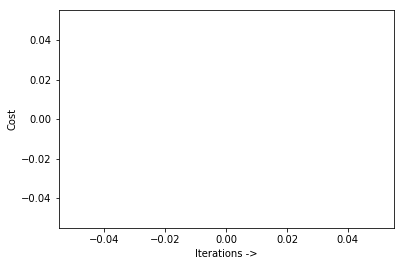

In [15]:
dim=[V,100,50,1]
cost_list,iter_list,W,b=neural_network(0.05,dim,100,'tanh',train_X,train_Y,test_X,test_Y)
plot_cost(iter_list,cost_list)

In [16]:
y_pred=predict(W,b,test_X,dim)
accuracy_score(test_Y,y_pred,normalize=True)

0.9748653500897666